In [1]:
from typing import Dict
import numpy as np
import pandas as pd
from ensmallen_graph import EnsmallenGraph
from extra_keras_metrics import get_minimal_multiclass_metrics, get_standard_binary_metrics
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
from ensmallen_graph.datasets.linqs import Cora, CiteSeer, PubMedDiabetes
from ensmallen_graph.datasets.yue import MashupPPI, node2vecPPI

graph = Cora()

words_only = graph.remove(deny_node_types_set=set(["Word"]))
graph = graph.remove(deny_node_types_set=set(["Word"]))
#graph = graph.remove(singletons=True, selfloops=True)

graph.enable(
    vector_destinations=True,
    vector_outbounds=True
)

In [3]:
graph.set_name("tet")

In [4]:
graph

The undirected graph tet has 2708 nodes with 7 different node types:  the 5 most common are Neural_Networks (nodes number 818), Probabilistic_Methods (nodes number 426), Genetic_Algorithms (nodes number 418), Theory (nodes number 351) and Case_Based (nodes number 298) and 5278 unweighted edges with a single edge type: Paper2Paper, of which none are self-loops. The graph is sparse as it has a density of 0.00144 and has 78 connected components, where the component with most nodes has 2485 nodes and the component with the least nodes has 2 nodes. The graph median node degree is 3, the mean node degree is 3.90, and the node degree mode is 2. The top 5 most central nodes are 35 (degree 168), 6213 (degree 78), 1365 (degree 74), 3229 (degree 65) and 910 (degree 44).The hash of the graph is a330cf2cdce2409d .

In [148]:
graph_name = graph.get_name()
lower_name = graph_name.lower()
path = f"graphs/linqs/{graph_name}/linqs/{lower_name}/{lower_name}/{lower_name}.content"
data = pd.read_csv(path, sep="\t", header=None, index_col=0)
data = data.drop(columns=[data.columns[-1]])
data.index = data.index.astype(str)
data

1     2     3     4     5     6     7     8     9     10    ...  \
0                                                                    ...   
31336       0     0     0     0     0     0     0     0     0     0  ...   
1061127     0     0     0     0     0     0     0     0     0     0  ...   
1106406     0     0     0     0     0     0     0     0     0     0  ...   
13195       0     0     0     0     0     0     0     0     0     0  ...   
37879       0     0     0     0     0     0     0     0     0     0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
1128975     0     0     0     0     0     0     0     0     0     0  ...   
1128977     0     0     0     0     0     0     0     0     0     0  ...   
1128978     0     0     0     0     0     0     0     0     0     0  ...   
117328      0     0     0     0     1     0     0     0     0     0  ...   
24043       0     0     0     0     0     0     0     0     0     0  ...   

         1424  1425  1426  1427  1428  1429  1430  1431  1432  1433  
0                                                                    
31336       0     0     0     1     0     0     0     0     0     0  
1061127     0     0     1     0     0     0     0     0     0     0  
1106406     0     0     0     0     0     0     0     0     0     0  
13195       0     0     0     0     0     0     0     0     0     0  
37879       0     0     0     0     0     0     0     0     0     0  
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
1128975     0     0     0     0     0     0     0     0     0     0  
1128977     0     0     0     0     0     0     0     0     0     0  
1128978     0     0     0     0     0     0     0     0     0     0  
117328      1     0     0     0     0     0     0     0     0     0  
24043       0     0     0     0     0     0     0     0     0     0  

[2708 rows x 1433 columns]

In [149]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam
from embiggen import SkipGram, Node2VecSequence
from ensmallen_graph import EnsmallenGraph  # pylint: disable=no-name-in-module
import pandas as pd
from cache_decorator import Cache

@Cache(
    cache_path="embeddings/skipgram/{graph_name}/{_hash}.csv.xz",
    args_to_ignore=["graph"],
)
def compute_skipgram_embedding(
    graph: EnsmallenGraph,
    graph_name: str,
    return_weight: float = 0.5,
    explore_weight: float = 0.5,
    walk_length: int = 256,
    batch_size: int = 256,
    iterations: int = 30,
    window_size: int = 10,
    embedding_size: int = 20,
    negative_samples: int = 10,
    epochs: int = 100,
    min_delta: int = 0.1,
    patience: int = 5,
    learning_rate: float = 0.01,
) -> pd.DataFrame:
    """Return embedding computed using SkipGram on given graph.

    Parameters
    ----------------------
    graph: EnsmallenGraph,
        Graph to embed.
    graph_name: str,
        Name of the graph to embed.
    return_weight: float,
        Value for the return weight, inverse of the p parameter.
    explore_weight: float,
        Value for the explore weight, inverse of the q parameter.
    walk_length: int = 100,
        Length of the random walks.
    batch_size: int = 256,
        Dimension of the batch size.
    iterations: int = 20,
        Number of iterations per node.
    window_size: int = 4,
        Dimension of the window size for the context.
    embedding_size: int = 100,
        Dimension of the embedding.
    negative_samples: int = 10,
        Number of negative samples to extract using the NCE loss.
    epochs: int = 100,
        Maximum number of epochs to execute.
    min_delta: int = 0.1,
        Minimum delta to wait for improvement of the loss function.
    patience: int = 5,
        Number of epochs to wait for an improvement.
    learning_rate: float = 0.1,
        Learning rate to use with the Nadam optimizer.

    Returns
    ---------------------
    Pandas dataframe with the computed embedding.
    """
    # Creating the training sequence.
    sequence = Node2VecSequence(
        graph,
        walk_length=walk_length,
        batch_size=batch_size,
        iterations=iterations,
        window_size=window_size,
        return_weight=return_weight,
        explore_weight=explore_weight,
        support_mirror_strategy=True
    )
    # Creating the SkipGram model
    model = SkipGram(
        graph.get_nodes_number(),
        embedding_size=embedding_size,
        window_size=window_size,
        negative_samples=negative_samples,
        optimizer=Nadam(learning_rate=learning_rate)
    )
    # Fitting the SkipGram model
    model.fit(
        sequence,
        steps_per_epoch=sequence.steps_per_epoch,
        epochs=epochs,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=min_delta,
                patience=patience,
                mode="min"
            )
        ]
    )
    # Returning the obtained embedding
    return model.get_embedding_dataframe(graph.get_node_names())

In [ ]:
import tensorflow as tf
with tf.distribute.MirroredStrategy(devices=["/GPU:1", "/GPU:2"]).scope():
    node_embedding = compute_skipgram_embedding(graph, graph.get_name()+"_no_words")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Epoch 1/100
 1/11 [=>............................] - ETA: 0s - loss: 164.2709

In [ ]:
from embiggen.visualizations import GraphVisualizations

In [ ]:
visualization = GraphVisualizations()
visualization.fit_transform_nodes(graph, node_embedding, verbose=True)

In [ ]:
visualization.plot_node_types(graph)

In [ ]:
visualization.plot_node_degrees(graph)

In [ ]:
"""Keras Sequence for running Neural Network on graph node-label prediction."""
from typing import Tuple
import tensorflow as tf
import numpy as np
from ensmallen_graph import EnsmallenGraph  # pylint: disable=no-name-in-module
from keras_mixed_sequence import VectorSequence, MixedSequence


class NodeLabelPredictionSequence(VectorSequence):
    """Keras Sequence for running Neural Network on graph link prediction."""

    def __init__(
        self,
        graph: EnsmallenGraph,
        node_ids: np.ndarray = None,
        #features: np.ndarray = None,
        batch_size: int = 2**8,
        elapsed_epochs: int = 0,
        random_state: int = 42
    ):
        """Create new LinkPredictionSequence object.

        Parameters
        --------------------------------
        graph: EnsmallenGraph,
            The graph from which to sample the edges.
        node_ids: np.ndarray = None,
            IDs of the nodes to consider.
        batch_size: int = 2**8,
            The batch size to use.
        elapsed_epochs: int = 0,
            Number of elapsed epochs to init state of generator.
        random_state: int = 42,
            The random state to use to make extraction reproducible.
        """
        self._graph = graph
        self._median = self._graph.degrees_median()
        self._max = self._graph.max_degree()
        if node_ids is None:
            node_ids = np.arange(self._graph.get_nodes_number())
        super().__init__(
            vector=node_ids,
            batch_size=batch_size,
            random_state=random_state,
            elapsed_epochs=elapsed_epochs,
        )

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        """Return batch corresponding to given index.

        Parameters
        ---------------
        idx: int,
            Index corresponding to batch to be returned.

        Returns
        ---------------
        Return Tuple containing X and Y numpy arrays corresponding to given batch index.
        """
        nodes = super().__getitem__(idx)
        return nodes, np.array([
            np.random.choice(self._graph.get_filtered_neighbours(node), size=self._median)
            for node in nodes
        ]), 


In [ ]:
from typing import Tuple
import tensorflow as tf
import numpy as np
from ensmallen_graph import EnsmallenGraph  # pylint: disable=no-name-in-module
from keras_mixed_sequence import VectorSequence, MixedSequence


class NodeLabelPredictionContextualSequence(VectorSequence):

    def __init__(
        self,
        graph: EnsmallenGraph,
        node_ids: np.ndarray,
        y: np.ndarray,
        classes_number: int,
        batch_size: int = 2**8,
        elapsed_epochs: int = 0,
        random_state: int = 42
    ):
        self._graph = graph
        self._median = self._graph.degrees_median()
        self._classes_number = classes_number
        self._missing_data = batch_size//3
        batch_size = self._missing_data*2
        self._labels_sequence = VectorSequence(
            vector=y,
            batch_size=batch_size,
            random_state=random_state,
            elapsed_epochs=elapsed_epochs,
        )
        super().__init__(
            vector=node_ids,
            batch_size=batch_size,
            random_state=random_state,
            elapsed_epochs=elapsed_epochs,
        )

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        """Return batch corresponding to given index.

        Parameters
        ---------------
        idx: int,
            Index corresponding to batch to be returned.

        Returns
        ---------------
        Return Tuple containing X and Y numpy arrays corresponding to given batch index.
        """
        nodes = super().__getitem__(idx)
        real_classes = self._labels_sequence[idx]
        real_contexts = np.array([
            np.random.choice(self._graph.get_filtered_neighbours(node), size=self._median)
            for node in nodes
        ])
        real_contexts = np.hstack([
            real_contexts,
            nodes.reshape(-1, 1)
        ])
        casual_contexts = np.array([
            np.random.choice(self._graph.get_nodes_number(), size=self._median)
            for node in nodes
        ])
        casual_contexts = np.hstack([
            casual_contexts,
            nodes.reshape(-1, 1)
        ])
        classes = np.zeros((self._batch_size + self._missing_data, self._classes_number+1))
        classes[:real_classes.shape[0], :self._classes_number] = real_classes
        classes[real_classes.shape[0]:, self._classes_number] = 1
        contexts = np.vstack([
            real_contexts,
            casual_contexts
        ])
        indices = np.arange(classes.shape[0])
        random_state = np.random.RandomState(seed=idx)
        random_state.shuffle(indices)
        contexts = contexts[indices]
        classes = classes[indices]
        return contexts, classes

In [130]:
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X = np.arange(graph.get_nodes_number())
mask = np.ones_like(X, dtype=bool)
if "Word" in graph.get_node_type_names():
    mask &= graph.get_node_type_names().index("Word") != graph.get_node_types()
if "Unknown" in graph.get_node_type_names():
    mask &= graph.get_node_type_names().index("Unknown") != graph.get_node_types()

X = X[mask]
node_names = np.array(graph.get_node_names())[mask]

# Dropping embedding on unconsidered nodes
filtered_embedding = node_embedding.loc[node_names]
features = data.loc[node_names]
embedding = node_embedding.loc[node_names]
encoder = OneHotEncoder(sparse=False)
y = graph.get_node_types()
y = y[mask]
y = encoder.fit_transform(y.reshape(-1, 1))
splitter = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)
train_indices, test_indices = next(splitter.split(X, y))
X_train, X_test = X[train_indices], X[test_indices]

features_train, features_test = features.iloc[train_indices], features.iloc[test_indices]
embedding_train, embedding_test = filtered_embedding.iloc[train_indices], filtered_embedding.iloc[test_indices]
#combined_train = pd.concat([
#    features_train,
#    embedding_train
#], axis=1)
#combined_test = pd.concat([
#    features_test,
#    embedding_test
#], axis=1)
y_train, y_test = y[train_indices], y[test_indices]

In [32]:
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Concatenate, Embedding, Lambda, Flatten, Reshape, Dropout
from tensorflow.keras import regularizers

In [100]:
model = Sequential(
    [
        Input((embedding_train.shape[1],)),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(
            y_train.shape[1],
            activation="softmax"
        )
    ],
    name="SimpleModel"
)

model.compile(
    optimizer="nadam",
    loss="categorical_crossentropy",
    metrics=get_minimal_multiclass_metrics()
)

model.summary()

Model: "SimpleModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 256)               5376      
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 6)                 1542      
Total params: 72,710
Trainable params: 72,710
Non-trainable params: 0
_________________________________________________________________


In [101]:
history = model.fit(
    embedding_train, y_train,
    validation_data=(embedding_test, y_test),
    epochs=1000,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor="accuracy", min_delta=0.001, patience=5)
    ]
).history

Epoch 1/1000
82/82 [==============================] - 1s 9ms/step - AUPRC: 0.9420 - AUROC: 0.9801 - accuracy: 0.8648 - loss: 0.4202 - precision: 0.9129 - recall: 0.8273 - val_AUPRC: 0.7045 - val_AUROC: 0.8872 - val_accuracy: 0.7152 - val_loss: 1.6369 - val_precision: 0.7520 - val_recall: 0.7060
Epoch 2/1000
82/82 [==============================] - 0s 4ms/step - AUPRC: 0.9929 - AUROC: 0.9982 - accuracy: 0.9632 - loss: 0.1073 - precision: 0.9667 - recall: 0.9567 - val_AUPRC: 0.6976 - val_AUROC: 0.8810 - val_accuracy: 0.7167 - val_loss: 2.0052 - val_precision: 0.7452 - val_recall: 0.7075
Epoch 3/1000
82/82 [==============================] - 0s 4ms/step - AUPRC: 0.9938 - AUROC: 0.9982 - accuracy: 0.9728 - loss: 0.0822 - precision: 0.9750 - recall: 0.9694 - val_AUPRC: 0.6901 - val_AUROC: 0.8793 - val_accuracy: 0.7152 - val_loss: 2.1609 - val_precision: 0.7389 - val_recall: 0.7106
Epoch 4/1000
82/82 [==============================] - 0s 4ms/step - AUPRC: 0.9953 - AUROC: 0.9987 - accuracy: 0.

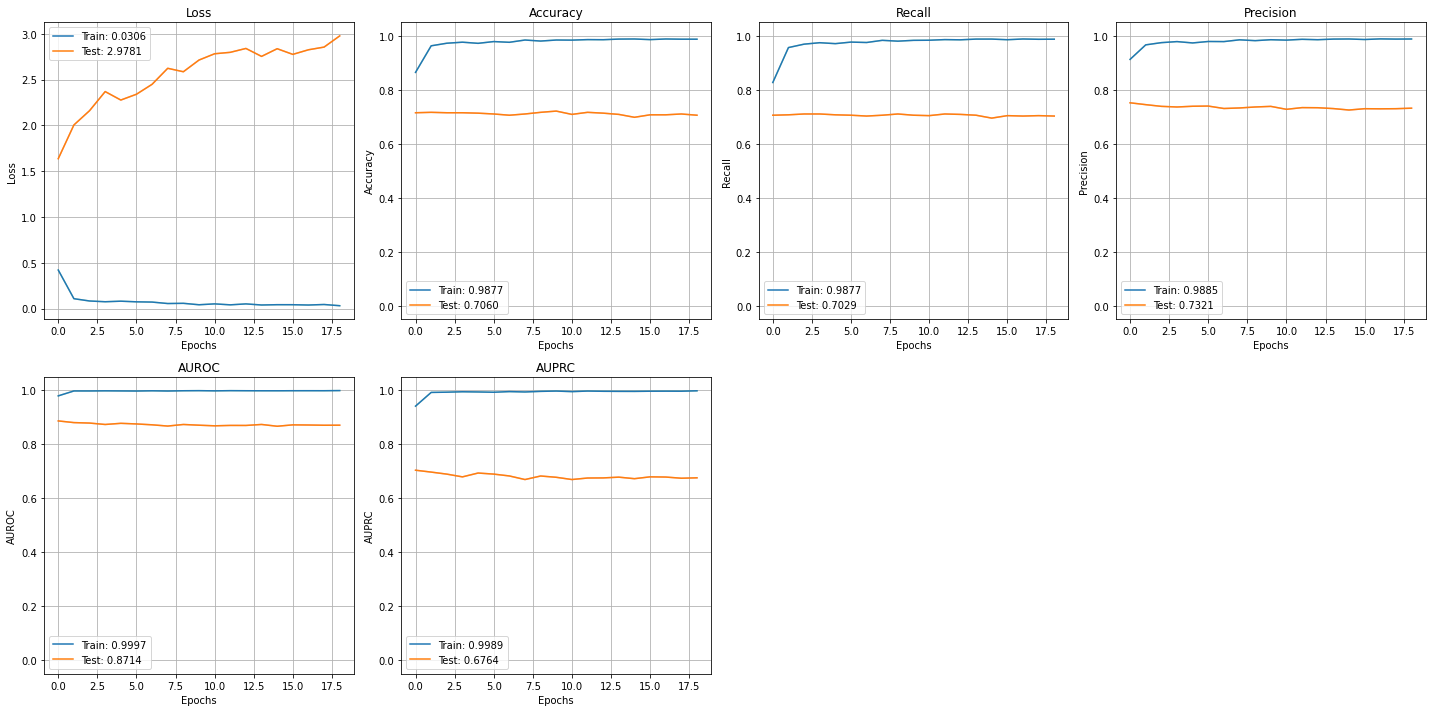

In [102]:
from plot_keras_history import plot_history
plot_history(history)

In [131]:
random_state = 42
batch_size = 128

train_sequence = MixedSequence(
    x=NodeLabelPredictionSequence(graph, X_train, batch_size=batch_size, random_state=random_state),
    y=VectorSequence(y_train, batch_size=batch_size, random_state=random_state)
)

test_sequence = MixedSequence(
    x=NodeLabelPredictionSequence(graph, X_test, batch_size=batch_size, random_state=random_state),
    y=VectorSequence(y_test, batch_size=batch_size, random_state=random_state)
)

In [132]:
embedding = node_embedding

centers_input = Input((1,))
neighbours_input = Input((None,))

node_embedding_layer = Embedding(
    *embedding.shape,
    input_length=None,
    weights=[embedding]
)
embedding_layer.trainable=True

# (batch_size, embedding_size)
centers_embedding = Flatten()(
    # (batch_size, 1, embedding_size)
    embedding_layer(centers_input)
)
# (batch_size, 1, embedding_size)
neighbours_embedding = Lambda(
    lambda x: K.mean(x, axis=1),
    output_shape=(embedding.shape[1],)
)(
    # (batch_size, neighbours, 1, embedding_size)
    embedding_layer(neighbours_input)
)

# (batch_size, 2*embedding_size)
hidden = concatenation = Concatenate()([
    centers_embedding,
    neighbours_embedding,
#   features_input
])

hidden = Dropout(0.8)(hidden)

output = Dense(
    y_train.shape[1],
    #graph.get_node_types_number()-1,
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    #input_shape=(node_embedding.shape[1]*2,),
    activation="softmax"
)(hidden)

model = Model(
    inputs=[
        centers_input,
        neighbours_input
    ],
    outputs=output,
    name="NodeLabelPredictor"
)

model.compile(
    optimizer="nadam",
    loss="categorical_crossentropy",
    metrics=get_minimal_multiclass_metrics()
)

model.summary()

Model: "NodeLabelPredictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_43 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         multiple             65580       input_42[0][0]                   
                                                                 input_43[0][0]                   
__________________________________________________________________________________________________
flatten_18 (Flatten)            (None, 20)           0           embedding_9[8][0

In [133]:
history = model.fit(
    train_sequence,
    validation_data=test_sequence,
    epochs=100000,
    callbacks=[
        EarlyStopping(monitor="accuracy", min_delta=0, patience=100)
    ]
).history

Epoch 1/100000
17/17 [==============================] - 0s 29ms/step - AUPRC: 0.1397 - AUROC: 0.4963 - accuracy: 0.1334 - loss: 11.9242 - precision: 0.1329 - recall: 0.1270 - val_AUPRC: 0.1431 - val_AUROC: 0.4912 - val_accuracy: 0.1679 - val_loss: 5.0015 - val_precision: 0.1557 - val_recall: 0.1218
Epoch 2/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.1391 - AUROC: 0.4904 - accuracy: 0.1394 - loss: 11.3529 - precision: 0.1356 - recall: 0.1288 - val_AUPRC: 0.1421 - val_AUROC: 0.4880 - val_accuracy: 0.1494 - val_loss: 4.7047 - val_precision: 0.1459 - val_recall: 0.1125
Epoch 3/100000
17/17 [==============================] - 1s 37ms/step - AUPRC: 0.1430 - AUROC: 0.5026 - accuracy: 0.1404 - loss: 10.5124 - precision: 0.1404 - recall: 0.1325 - val_AUPRC: 0.1421 - val_AUROC: 0.4952 - val_accuracy: 0.1384 - val_loss: 4.4174 - val_precision: 0.1269 - val_recall: 0.0941
Epoch 4/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.1392 - AUROC: 0.4920 -

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2343 - AUROC: 0.6512 - accuracy: 0.2872 - loss: 1.8410 - precision: 0.5000 - recall: 4.6168e-04 - val_AUPRC: 0.2491 - val_AUROC: 0.6572 - val_accuracy: 0.3026 - val_loss: 1.8273 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 55/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2390 - AUROC: 0.6529 - accuracy: 0.2927 - loss: 1.8341 - precision: 0.3333 - recall: 4.6168e-04 - val_AUPRC: 0.2458 - val_AUROC: 0.6583 - val_accuracy: 0.3026 - val_loss: 1.8286 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 56/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2356 - AUROC: 0.6474 - accuracy: 0.2950 - loss: 1.8435 - precision: 1.0000 - recall: 4.6168e-04 - val_AUPRC: 0.2408 - val_AUROC: 0.6548 - val_accuracy: 0.3007 - val_loss: 1.8315 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 57/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.244

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2465 - AUROC: 0.6594 - accuracy: 0.2982 - loss: 1.8248 - precision: 0.6667 - recall: 0.0018 - val_AUPRC: 0.2416 - val_AUROC: 0.6594 - val_accuracy: 0.3026 - val_loss: 1.8242 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 107/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2462 - AUROC: 0.6613 - accuracy: 0.2950 - loss: 1.8233 - precision: 0.4286 - recall: 0.0014 - val_AUPRC: 0.2399 - val_AUROC: 0.6558 - val_accuracy: 0.3026 - val_loss: 1.8298 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 108/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2437 - AUROC: 0.6532 - accuracy: 0.3024 - loss: 1.8336 - precision: 0.4167 - recall: 0.0023 - val_AUPRC: 0.2374 - val_AUROC: 0.6622 - val_accuracy: 0.3026 - val_loss: 1.8239 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 109/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2409 - AUROC

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2472 - AUROC: 0.6562 - accuracy: 0.2987 - loss: 1.8298 - precision: 0.5000 - recall: 9.2336e-04 - val_AUPRC: 0.2549 - val_AUROC: 0.6644 - val_accuracy: 0.3026 - val_loss: 1.8196 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 159/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2471 - AUROC: 0.6586 - accuracy: 0.2978 - loss: 1.8260 - precision: 0.4000 - recall: 9.2336e-04 - val_AUPRC: 0.2462 - val_AUROC: 0.6587 - val_accuracy: 0.3044 - val_loss: 1.8244 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 160/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2462 - AUROC: 0.6578 - accuracy: 0.2973 - loss: 1.8287 - precision: 0.2857 - recall: 9.2336e-04 - val_AUPRC: 0.2468 - val_AUROC: 0.6642 - val_accuracy: 0.3026 - val_loss: 1.8203 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 161/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2409 - AUROC: 0.6575 - accuracy: 0.2964 - loss: 1.8292 - precision: 0.1667 - recall: 4.6168e-04 - val_AUPRC: 0.2438 - val_AUROC: 0.6602 - val_accuracy: 0.3044 - val_loss: 1.8215 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 211/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2381 - AUROC: 0.6573 - accuracy: 0.2899 - loss: 1.8304 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUPRC: 0.2502 - val_AUROC: 0.6640 - val_accuracy: 0.3044 - val_loss: 1.8176 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 212/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2433 - AUROC: 0.6561 - accuracy: 0.2946 - loss: 1.8303 - precision: 0.3333 - recall: 4.6168e-04 - val_AUPRC: 0.2451 - val_AUROC: 0.6635 - val_accuracy: 0.3026 - val_loss: 1.8195 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 213/100000
17/17 [==============================] - 0s 6ms/step - AUPRC

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2436 - AUROC: 0.6583 - accuracy: 0.2969 - loss: 1.8260 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUPRC: 0.2550 - val_AUROC: 0.6689 - val_accuracy: 0.3026 - val_loss: 1.8142 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 263/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2438 - AUROC: 0.6610 - accuracy: 0.2987 - loss: 1.8226 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUPRC: 0.2676 - val_AUROC: 0.6717 - val_accuracy: 0.3044 - val_loss: 1.8097 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 264/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2400 - AUROC: 0.6561 - accuracy: 0.2969 - loss: 1.8312 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUPRC: 0.2636 - val_AUROC: 0.6690 - val_accuracy: 0.3026 - val_loss: 1.8124 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 265/100000
17/17 [==============================] - 0s 6ms/step

Epoch 315/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2556 - AUROC: 0.6661 - accuracy: 0.3052 - loss: 1.8172 - precision: 0.6923 - recall: 0.0042 - val_AUPRC: 0.2639 - val_AUROC: 0.6757 - val_accuracy: 0.3007 - val_loss: 1.8035 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 316/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2535 - AUROC: 0.6658 - accuracy: 0.3010 - loss: 1.8155 - precision: 0.2500 - recall: 9.2336e-04 - val_AUPRC: 0.2645 - val_AUROC: 0.6760 - val_accuracy: 0.3044 - val_loss: 1.8036 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 317/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2533 - AUROC: 0.6643 - accuracy: 0.2996 - loss: 1.8181 - precision: 0.2857 - recall: 0.0028 - val_AUPRC: 0.2632 - val_AUROC: 0.6756 - val_accuracy: 0.3044 - val_loss: 1.8022 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 318/100000
17/17 [==============================] - 0s 6ms/step - 

Epoch 342/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2508 - AUROC: 0.6712 - accuracy: 0.3075 - loss: 1.8110 - precision: 0.3333 - recall: 0.0028 - val_AUPRC: 0.2512 - val_AUROC: 0.6785 - val_accuracy: 0.3081 - val_loss: 1.8003 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 343/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2565 - AUROC: 0.6648 - accuracy: 0.3033 - loss: 1.8181 - precision: 0.4737 - recall: 0.0042 - val_AUPRC: 0.2612 - val_AUROC: 0.6701 - val_accuracy: 0.3044 - val_loss: 1.8084 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 344/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2600 - AUROC: 0.6685 - accuracy: 0.3015 - loss: 1.8112 - precision: 0.6250 - recall: 0.0069 - val_AUPRC: 0.2679 - val_AUROC: 0.6750 - val_accuracy: 0.3063 - val_loss: 1.7980 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 345/100000
17/17 [==============================] - 0s 6ms/step - AUPR

Epoch 369/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2602 - AUROC: 0.6697 - accuracy: 0.3006 - loss: 1.8105 - precision: 0.5517 - recall: 0.0074 - val_AUPRC: 0.2693 - val_AUROC: 0.6761 - val_accuracy: 0.3100 - val_loss: 1.8017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 370/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2554 - AUROC: 0.6692 - accuracy: 0.3052 - loss: 1.8122 - precision: 0.4545 - recall: 0.0092 - val_AUPRC: 0.2665 - val_AUROC: 0.6763 - val_accuracy: 0.3100 - val_loss: 1.8006 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 371/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2541 - AUROC: 0.6675 - accuracy: 0.3006 - loss: 1.8162 - precision: 0.4545 - recall: 0.0069 - val_AUPRC: 0.2641 - val_AUROC: 0.6757 - val_accuracy: 0.3081 - val_loss: 1.7980 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 372/100000
17/17 [==============================] - 0s 6ms/step - AUPR

Epoch 396/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2557 - AUROC: 0.6703 - accuracy: 0.3139 - loss: 1.8105 - precision: 0.5200 - recall: 0.0060 - val_AUPRC: 0.2688 - val_AUROC: 0.6764 - val_accuracy: 0.3081 - val_loss: 1.7974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 397/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2626 - AUROC: 0.6738 - accuracy: 0.3079 - loss: 1.8021 - precision: 0.5000 - recall: 0.0032 - val_AUPRC: 0.2628 - val_AUROC: 0.6819 - val_accuracy: 0.3081 - val_loss: 1.7965 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 398/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2608 - AUROC: 0.6687 - accuracy: 0.3167 - loss: 1.8101 - precision: 0.4737 - recall: 0.0083 - val_AUPRC: 0.2608 - val_AUROC: 0.6763 - val_accuracy: 0.3100 - val_loss: 1.7979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 399/100000
17/17 [==============================] - 0s 6ms/step - AUPR

Epoch 423/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2698 - AUROC: 0.6824 - accuracy: 0.3093 - loss: 1.7896 - precision: 0.5000 - recall: 0.0065 - val_AUPRC: 0.2840 - val_AUROC: 0.6853 - val_accuracy: 0.3210 - val_loss: 1.7803 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 424/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2617 - AUROC: 0.6748 - accuracy: 0.3102 - loss: 1.8032 - precision: 0.5161 - recall: 0.0074 - val_AUPRC: 0.2752 - val_AUROC: 0.6843 - val_accuracy: 0.3137 - val_loss: 1.7865 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 425/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2698 - AUROC: 0.6782 - accuracy: 0.3061 - loss: 1.7940 - precision: 0.7037 - recall: 0.0088 - val_AUPRC: 0.2713 - val_AUROC: 0.6820 - val_accuracy: 0.3173 - val_loss: 1.7888 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 426/100000
17/17 [==============================] - 0s 6ms/step - AUPR

Epoch 450/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2782 - AUROC: 0.6836 - accuracy: 0.3038 - loss: 1.7887 - precision: 0.5962 - recall: 0.0143 - val_AUPRC: 0.2841 - val_AUROC: 0.6844 - val_accuracy: 0.3210 - val_loss: 1.7836 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 451/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2697 - AUROC: 0.6786 - accuracy: 0.3029 - loss: 1.7963 - precision: 0.5333 - recall: 0.0148 - val_AUPRC: 0.2951 - val_AUROC: 0.6887 - val_accuracy: 0.3303 - val_loss: 1.7761 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 452/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2754 - AUROC: 0.6844 - accuracy: 0.3190 - loss: 1.7845 - precision: 0.5500 - recall: 0.0102 - val_AUPRC: 0.2884 - val_AUROC: 0.6904 - val_accuracy: 0.3266 - val_loss: 1.7771 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 453/100000
17/17 [==============================] - 0s 6ms/step - AUPR

Epoch 477/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2732 - AUROC: 0.6801 - accuracy: 0.3033 - loss: 1.7958 - precision: 0.5139 - recall: 0.0171 - val_AUPRC: 0.3027 - val_AUROC: 0.6931 - val_accuracy: 0.3339 - val_loss: 1.7692 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 478/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2732 - AUROC: 0.6809 - accuracy: 0.3121 - loss: 1.7911 - precision: 0.4444 - recall: 0.0092 - val_AUPRC: 0.3062 - val_AUROC: 0.6969 - val_accuracy: 0.3229 - val_loss: 1.7637 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 479/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2856 - AUROC: 0.6845 - accuracy: 0.3213 - loss: 1.7828 - precision: 0.6338 - recall: 0.0208 - val_AUPRC: 0.2949 - val_AUROC: 0.6933 - val_accuracy: 0.3247 - val_loss: 1.7711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 480/100000
17/17 [==============================] - 0s 6ms/step - AUPR

Epoch 504/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2832 - AUROC: 0.6855 - accuracy: 0.3167 - loss: 1.7808 - precision: 0.5000 - recall: 0.0175 - val_AUPRC: 0.3070 - val_AUROC: 0.7018 - val_accuracy: 0.3321 - val_loss: 1.7599 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 505/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2811 - AUROC: 0.6856 - accuracy: 0.3186 - loss: 1.7811 - precision: 0.5000 - recall: 0.0185 - val_AUPRC: 0.2981 - val_AUROC: 0.6972 - val_accuracy: 0.3321 - val_loss: 1.7654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 506/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2850 - AUROC: 0.6895 - accuracy: 0.3135 - loss: 1.7760 - precision: 0.5190 - recall: 0.0189 - val_AUPRC: 0.3226 - val_AUROC: 0.7019 - val_accuracy: 0.3376 - val_loss: 1.7510 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 507/100000
17/17 [==============================] - 0s 6ms/step - AUPR

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2917 - AUROC: 0.6887 - accuracy: 0.3172 - loss: 1.7736 - precision: 0.6842 - recall: 0.0240 - val_AUPRC: 0.3285 - val_AUROC: 0.7099 - val_accuracy: 0.3395 - val_loss: 1.7393 - val_precision: 1.0000 - val_recall: 0.0092
Epoch 559/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2878 - AUROC: 0.6943 - accuracy: 0.3130 - loss: 1.7679 - precision: 0.5758 - recall: 0.0263 - val_AUPRC: 0.3328 - val_AUROC: 0.7083 - val_accuracy: 0.3284 - val_loss: 1.7424 - val_precision: 1.0000 - val_recall: 0.0074
Epoch 560/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2924 - AUROC: 0.6958 - accuracy: 0.3190 - loss: 1.7642 - precision: 0.6022 - recall: 0.0259 - val_AUPRC: 0.3358 - val_AUROC: 0.7062 - val_accuracy: 0.3395 - val_loss: 1.7449 - val_precision: 1.0000 - val_recall: 0.0037
Epoch 561/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2900 - AUROC: 0.6897 - accuracy: 0.3

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3014 - AUROC: 0.7030 - accuracy: 0.3167 - loss: 1.7520 - precision: 0.6289 - recall: 0.0282 - val_AUPRC: 0.3604 - val_AUROC: 0.7204 - val_accuracy: 0.3542 - val_loss: 1.7148 - val_precision: 1.0000 - val_recall: 0.0055
Epoch 613/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3003 - AUROC: 0.6947 - accuracy: 0.3264 - loss: 1.7654 - precision: 0.5573 - recall: 0.0337 - val_AUPRC: 0.3313 - val_AUROC: 0.7146 - val_accuracy: 0.3247 - val_loss: 1.7335 - val_precision: 1.0000 - val_recall: 0.0037
Epoch 614/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.2914 - AUROC: 0.6966 - accuracy: 0.3186 - loss: 1.7637 - precision: 0.5041 - recall: 0.0286 - val_AUPRC: 0.3378 - val_AUROC: 0.7174 - val_accuracy: 0.3432 - val_loss: 1.7221 - val_precision: 0.7500 - val_recall: 0.0055
Epoch 615/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3061 - AUROC: 0.6996 - accuracy: 0.3

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3148 - AUROC: 0.7086 - accuracy: 0.3338 - loss: 1.7390 - precision: 0.6438 - recall: 0.0476 - val_AUPRC: 0.3618 - val_AUROC: 0.7283 - val_accuracy: 0.3708 - val_loss: 1.6987 - val_precision: 0.9167 - val_recall: 0.0203
Epoch 667/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3264 - AUROC: 0.7136 - accuracy: 0.3426 - loss: 1.7244 - precision: 0.6471 - recall: 0.0457 - val_AUPRC: 0.3696 - val_AUROC: 0.7318 - val_accuracy: 0.3598 - val_loss: 1.6922 - val_precision: 0.8235 - val_recall: 0.0258
Epoch 668/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3180 - AUROC: 0.7111 - accuracy: 0.3412 - loss: 1.7328 - precision: 0.5584 - recall: 0.0508 - val_AUPRC: 0.3542 - val_AUROC: 0.7295 - val_accuracy: 0.3542 - val_loss: 1.7002 - val_precision: 0.8462 - val_recall: 0.0203
Epoch 669/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3089 - AUROC: 0.7087 - accuracy: 0.3

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3273 - AUROC: 0.7183 - accuracy: 0.3375 - loss: 1.7203 - precision: 0.6250 - recall: 0.0531 - val_AUPRC: 0.3892 - val_AUROC: 0.7409 - val_accuracy: 0.3616 - val_loss: 1.6776 - val_precision: 0.9333 - val_recall: 0.0258
Epoch 721/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3240 - AUROC: 0.7165 - accuracy: 0.3407 - loss: 1.7241 - precision: 0.5979 - recall: 0.0536 - val_AUPRC: 0.3921 - val_AUROC: 0.7417 - val_accuracy: 0.3561 - val_loss: 1.6755 - val_precision: 1.0000 - val_recall: 0.0240
Epoch 722/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3203 - AUROC: 0.7161 - accuracy: 0.3301 - loss: 1.7231 - precision: 0.6159 - recall: 0.0466 - val_AUPRC: 0.3761 - val_AUROC: 0.7363 - val_accuracy: 0.3616 - val_loss: 1.6841 - val_precision: 0.8750 - val_recall: 0.0258
Epoch 723/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.3207 - AUROC: 0.7121 - accuracy: 0.3

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3346 - AUROC: 0.7164 - accuracy: 0.3472 - loss: 1.7170 - precision: 0.6025 - recall: 0.0679 - val_AUPRC: 0.3899 - val_AUROC: 0.7452 - val_accuracy: 0.3672 - val_loss: 1.6653 - val_precision: 0.9412 - val_recall: 0.0295
Epoch 775/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3465 - AUROC: 0.7217 - accuracy: 0.3495 - loss: 1.7052 - precision: 0.6652 - recall: 0.0697 - val_AUPRC: 0.4034 - val_AUROC: 0.7477 - val_accuracy: 0.3708 - val_loss: 1.6525 - val_precision: 0.8889 - val_recall: 0.0443
Epoch 776/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3457 - AUROC: 0.7286 - accuracy: 0.3560 - loss: 1.6940 - precision: 0.6402 - recall: 0.0780 - val_AUPRC: 0.3896 - val_AUROC: 0.7445 - val_accuracy: 0.3635 - val_loss: 1.6624 - val_precision: 0.9565 - val_recall: 0.0406
Epoch 777/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3412 - AUROC: 0.7227 - accuracy: 0.3

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3466 - AUROC: 0.7250 - accuracy: 0.3370 - loss: 1.6990 - precision: 0.6162 - recall: 0.0808 - val_AUPRC: 0.4184 - val_AUROC: 0.7655 - val_accuracy: 0.3727 - val_loss: 1.6286 - val_precision: 0.9048 - val_recall: 0.0351
Epoch 829/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.3521 - AUROC: 0.7302 - accuracy: 0.3583 - loss: 1.6875 - precision: 0.6522 - recall: 0.0831 - val_AUPRC: 0.4152 - val_AUROC: 0.7630 - val_accuracy: 0.3745 - val_loss: 1.6270 - val_precision: 0.9375 - val_recall: 0.0554
Epoch 830/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.3429 - AUROC: 0.7338 - accuracy: 0.3490 - loss: 1.6829 - precision: 0.6049 - recall: 0.0799 - val_AUPRC: 0.4295 - val_AUROC: 0.7672 - val_accuracy: 0.3819 - val_loss: 1.6207 - val_precision: 0.9615 - val_recall: 0.0461
Epoch 831/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3610 - AUROC: 0.7339 - accuracy: 0.3

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3510 - AUROC: 0.7359 - accuracy: 0.3601 - loss: 1.6782 - precision: 0.5679 - recall: 0.0849 - val_AUPRC: 0.4395 - val_AUROC: 0.7677 - val_accuracy: 0.3893 - val_loss: 1.6132 - val_precision: 0.9630 - val_recall: 0.0480
Epoch 883/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3618 - AUROC: 0.7355 - accuracy: 0.3721 - loss: 1.6763 - precision: 0.6149 - recall: 0.0914 - val_AUPRC: 0.4422 - val_AUROC: 0.7730 - val_accuracy: 0.3875 - val_loss: 1.5976 - val_precision: 0.8824 - val_recall: 0.0554
Epoch 884/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3729 - AUROC: 0.7484 - accuracy: 0.3850 - loss: 1.6440 - precision: 0.6280 - recall: 0.0849 - val_AUPRC: 0.4467 - val_AUROC: 0.7766 - val_accuracy: 0.4022 - val_loss: 1.5959 - val_precision: 0.9062 - val_recall: 0.0535
Epoch 885/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3663 - AUROC: 0.7387 - accuracy: 0.3

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3701 - AUROC: 0.7422 - accuracy: 0.3753 - loss: 1.6622 - precision: 0.6221 - recall: 0.0988 - val_AUPRC: 0.4544 - val_AUROC: 0.7769 - val_accuracy: 0.3875 - val_loss: 1.5757 - val_precision: 0.9245 - val_recall: 0.0904
Epoch 937/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3811 - AUROC: 0.7553 - accuracy: 0.3818 - loss: 1.6345 - precision: 0.6110 - recall: 0.1080 - val_AUPRC: 0.4499 - val_AUROC: 0.7813 - val_accuracy: 0.4022 - val_loss: 1.5759 - val_precision: 0.8913 - val_recall: 0.0756
Epoch 938/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3578 - AUROC: 0.7479 - accuracy: 0.3698 - loss: 1.6505 - precision: 0.5610 - recall: 0.0891 - val_AUPRC: 0.4712 - val_AUROC: 0.7872 - val_accuracy: 0.4077 - val_loss: 1.5747 - val_precision: 0.9667 - val_recall: 0.0535
Epoch 939/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3801 - AUROC: 0.7538 - accuracy: 0.3

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4067 - AUROC: 0.7633 - accuracy: 0.3850 - loss: 1.6047 - precision: 0.6816 - recall: 0.1196 - val_AUPRC: 0.4788 - val_AUROC: 0.7884 - val_accuracy: 0.4317 - val_loss: 1.5595 - val_precision: 0.9730 - val_recall: 0.0664
Epoch 991/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.3872 - AUROC: 0.7527 - accuracy: 0.3873 - loss: 1.6328 - precision: 0.6427 - recall: 0.1113 - val_AUPRC: 0.4848 - val_AUROC: 0.7934 - val_accuracy: 0.4170 - val_loss: 1.5487 - val_precision: 0.9231 - val_recall: 0.0664
Epoch 992/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3831 - AUROC: 0.7587 - accuracy: 0.3804 - loss: 1.6177 - precision: 0.6322 - recall: 0.1071 - val_AUPRC: 0.4819 - val_AUROC: 0.7881 - val_accuracy: 0.4077 - val_loss: 1.5539 - val_precision: 0.9535 - val_recall: 0.0756
Epoch 993/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3881 - AUROC: 0.7523 - accuracy: 0.3

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3946 - AUROC: 0.7557 - accuracy: 0.3897 - loss: 1.6236 - precision: 0.6402 - recall: 0.1339 - val_AUPRC: 0.4929 - val_AUROC: 0.8022 - val_accuracy: 0.4244 - val_loss: 1.5259 - val_precision: 0.9184 - val_recall: 0.0830
Epoch 1045/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4134 - AUROC: 0.7658 - accuracy: 0.3929 - loss: 1.5979 - precision: 0.6757 - recall: 0.1385 - val_AUPRC: 0.4996 - val_AUROC: 0.8073 - val_accuracy: 0.4446 - val_loss: 1.5201 - val_precision: 0.9524 - val_recall: 0.0738
Epoch 1046/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4046 - AUROC: 0.7674 - accuracy: 0.3892 - loss: 1.5987 - precision: 0.6281 - recall: 0.1279 - val_AUPRC: 0.5200 - val_AUROC: 0.8090 - val_accuracy: 0.4483 - val_loss: 1.5074 - val_precision: 0.9767 - val_recall: 0.0775
Epoch 1047/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.3971 - AUROC: 0.7636 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4117 - AUROC: 0.7682 - accuracy: 0.3984 - loss: 1.6018 - precision: 0.6382 - recall: 0.1343 - val_AUPRC: 0.5139 - val_AUROC: 0.8127 - val_accuracy: 0.4502 - val_loss: 1.4966 - val_precision: 0.9254 - val_recall: 0.1144
Epoch 1099/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4237 - AUROC: 0.7769 - accuracy: 0.4123 - loss: 1.5700 - precision: 0.6563 - recall: 0.1464 - val_AUPRC: 0.5103 - val_AUROC: 0.8070 - val_accuracy: 0.4354 - val_loss: 1.5046 - val_precision: 0.9655 - val_recall: 0.1033
Epoch 1100/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4260 - AUROC: 0.7743 - accuracy: 0.4109 - loss: 1.5760 - precision: 0.6506 - recall: 0.1556 - val_AUPRC: 0.5321 - val_AUROC: 0.8137 - val_accuracy: 0.4686 - val_loss: 1.4835 - val_precision: 0.9474 - val_recall: 0.0996
Epoch 1101/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4166 - AUROC: 0.7712 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4334 - AUROC: 0.7785 - accuracy: 0.4169 - loss: 1.5581 - precision: 0.6716 - recall: 0.1690 - val_AUPRC: 0.5283 - val_AUROC: 0.8213 - val_accuracy: 0.4539 - val_loss: 1.4647 - val_precision: 0.9211 - val_recall: 0.1292
Epoch 1153/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4075 - AUROC: 0.7660 - accuracy: 0.3957 - loss: 1.5991 - precision: 0.6298 - recall: 0.1579 - val_AUPRC: 0.5287 - val_AUROC: 0.8168 - val_accuracy: 0.4594 - val_loss: 1.4758 - val_precision: 0.9211 - val_recall: 0.1292
Epoch 1154/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4256 - AUROC: 0.7804 - accuracy: 0.4220 - loss: 1.5640 - precision: 0.6412 - recall: 0.1510 - val_AUPRC: 0.5210 - val_AUROC: 0.8164 - val_accuracy: 0.4483 - val_loss: 1.4836 - val_precision: 0.9091 - val_recall: 0.0923
Epoch 1155/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4173 - AUROC: 0.7723 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4504 - AUROC: 0.7880 - accuracy: 0.4289 - loss: 1.5283 - precision: 0.6619 - recall: 0.1708 - val_AUPRC: 0.5458 - val_AUROC: 0.8288 - val_accuracy: 0.4649 - val_loss: 1.4467 - val_precision: 0.9114 - val_recall: 0.1328
Epoch 1207/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4325 - AUROC: 0.7815 - accuracy: 0.4035 - loss: 1.5539 - precision: 0.6562 - recall: 0.1745 - val_AUPRC: 0.5588 - val_AUROC: 0.8279 - val_accuracy: 0.4871 - val_loss: 1.4532 - val_precision: 0.9538 - val_recall: 0.1144
Epoch 1208/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4312 - AUROC: 0.7834 - accuracy: 0.4266 - loss: 1.5516 - precision: 0.6568 - recall: 0.1634 - val_AUPRC: 0.5746 - val_AUROC: 0.8366 - val_accuracy: 0.5166 - val_loss: 1.4366 - val_precision: 0.9500 - val_recall: 0.1052
Epoch 1209/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4214 - AUROC: 0.7747 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4438 - AUROC: 0.7828 - accuracy: 0.4243 - loss: 1.5515 - precision: 0.6749 - recall: 0.1898 - val_AUPRC: 0.5690 - val_AUROC: 0.8303 - val_accuracy: 0.4908 - val_loss: 1.4427 - val_precision: 0.9104 - val_recall: 0.1125
Epoch 1261/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4256 - AUROC: 0.7833 - accuracy: 0.4137 - loss: 1.5505 - precision: 0.6387 - recall: 0.1584 - val_AUPRC: 0.5734 - val_AUROC: 0.8285 - val_accuracy: 0.4834 - val_loss: 1.4547 - val_precision: 0.9808 - val_recall: 0.0941
Epoch 1262/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4497 - AUROC: 0.7943 - accuracy: 0.4266 - loss: 1.5211 - precision: 0.6642 - recall: 0.1681 - val_AUPRC: 0.5894 - val_AUROC: 0.8439 - val_accuracy: 0.5055 - val_loss: 1.4115 - val_precision: 0.9583 - val_recall: 0.1273
Epoch 1263/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4436 - AUROC: 0.7872 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4586 - AUROC: 0.7962 - accuracy: 0.4409 - loss: 1.5140 - precision: 0.6405 - recall: 0.2073 - val_AUPRC: 0.5977 - val_AUROC: 0.8485 - val_accuracy: 0.5111 - val_loss: 1.3824 - val_precision: 0.9425 - val_recall: 0.1513
Epoch 1315/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4590 - AUROC: 0.7936 - accuracy: 0.4303 - loss: 1.5166 - precision: 0.6578 - recall: 0.1934 - val_AUPRC: 0.5858 - val_AUROC: 0.8403 - val_accuracy: 0.5092 - val_loss: 1.4091 - val_precision: 0.9136 - val_recall: 0.1365
Epoch 1316/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4514 - AUROC: 0.7958 - accuracy: 0.4298 - loss: 1.5109 - precision: 0.6573 - recall: 0.1833 - val_AUPRC: 0.5853 - val_AUROC: 0.8419 - val_accuracy: 0.5037 - val_loss: 1.4037 - val_precision: 0.9342 - val_recall: 0.1310
Epoch 1317/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4555 - AUROC: 0.7933 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4623 - AUROC: 0.7964 - accuracy: 0.4349 - loss: 1.5082 - precision: 0.6780 - recall: 0.2022 - val_AUPRC: 0.5950 - val_AUROC: 0.8421 - val_accuracy: 0.5240 - val_loss: 1.4027 - val_precision: 0.9383 - val_recall: 0.1402
Epoch 1369/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4742 - AUROC: 0.8045 - accuracy: 0.4529 - loss: 1.4817 - precision: 0.6595 - recall: 0.1976 - val_AUPRC: 0.5958 - val_AUROC: 0.8500 - val_accuracy: 0.5295 - val_loss: 1.3816 - val_precision: 0.8974 - val_recall: 0.1292
Epoch 1370/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4524 - AUROC: 0.7913 - accuracy: 0.4331 - loss: 1.5253 - precision: 0.6401 - recall: 0.1930 - val_AUPRC: 0.6066 - val_AUROC: 0.8511 - val_accuracy: 0.5221 - val_loss: 1.3771 - val_precision: 0.9529 - val_recall: 0.1494
Epoch 1371/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4687 - AUROC: 0.8045 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5038 - AUROC: 0.8176 - accuracy: 0.4778 - loss: 1.4416 - precision: 0.6953 - recall: 0.2318 - val_AUPRC: 0.6245 - val_AUROC: 0.8560 - val_accuracy: 0.5443 - val_loss: 1.3516 - val_precision: 0.8889 - val_recall: 0.1624
Epoch 1423/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4760 - AUROC: 0.8053 - accuracy: 0.4594 - loss: 1.4844 - precision: 0.6728 - recall: 0.2202 - val_AUPRC: 0.6254 - val_AUROC: 0.8532 - val_accuracy: 0.5480 - val_loss: 1.3577 - val_precision: 0.9255 - val_recall: 0.1605
Epoch 1424/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4788 - AUROC: 0.8057 - accuracy: 0.4478 - loss: 1.4805 - precision: 0.6766 - recall: 0.2202 - val_AUPRC: 0.6405 - val_AUROC: 0.8630 - val_accuracy: 0.5572 - val_loss: 1.3358 - val_precision: 0.9545 - val_recall: 0.1550
Epoch 1425/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4941 - AUROC: 0.8125 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4821 - AUROC: 0.8109 - accuracy: 0.4672 - loss: 1.4660 - precision: 0.6723 - recall: 0.2198 - val_AUPRC: 0.6010 - val_AUROC: 0.8573 - val_accuracy: 0.5480 - val_loss: 1.3595 - val_precision: 0.9100 - val_recall: 0.1679
Epoch 1477/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5064 - AUROC: 0.8180 - accuracy: 0.4829 - loss: 1.4388 - precision: 0.7094 - recall: 0.2322 - val_AUPRC: 0.6306 - val_AUROC: 0.8610 - val_accuracy: 0.5572 - val_loss: 1.3357 - val_precision: 0.9688 - val_recall: 0.1716
Epoch 1478/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4852 - AUROC: 0.8105 - accuracy: 0.4501 - loss: 1.4603 - precision: 0.6774 - recall: 0.2230 - val_AUPRC: 0.6338 - val_AUROC: 0.8682 - val_accuracy: 0.5369 - val_loss: 1.3251 - val_precision: 0.9043 - val_recall: 0.1568
Epoch 1479/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.4890 - AUROC: 0.8111 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5030 - AUROC: 0.8208 - accuracy: 0.4686 - loss: 1.4285 - precision: 0.6789 - recall: 0.2304 - val_AUPRC: 0.6449 - val_AUROC: 0.8673 - val_accuracy: 0.5664 - val_loss: 1.3116 - val_precision: 0.9211 - val_recall: 0.1937
Epoch 1531/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5070 - AUROC: 0.8178 - accuracy: 0.4709 - loss: 1.4355 - precision: 0.6769 - recall: 0.2535 - val_AUPRC: 0.6464 - val_AUROC: 0.8695 - val_accuracy: 0.5590 - val_loss: 1.3052 - val_precision: 0.9304 - val_recall: 0.1974
Epoch 1532/100000
17/17 [==============================] - 0s 8ms/step - AUPRC: 0.5091 - AUROC: 0.8251 - accuracy: 0.4700 - loss: 1.4157 - precision: 0.6671 - recall: 0.2442 - val_AUPRC: 0.6494 - val_AUROC: 0.8710 - val_accuracy: 0.5738 - val_loss: 1.2987 - val_precision: 0.9397 - val_recall: 0.2011
Epoch 1533/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.4916 - AUROC: 0.8185 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5189 - AUROC: 0.8251 - accuracy: 0.4889 - loss: 1.4121 - precision: 0.6988 - recall: 0.2507 - val_AUPRC: 0.6540 - val_AUROC: 0.8771 - val_accuracy: 0.5812 - val_loss: 1.2773 - val_precision: 0.9015 - val_recall: 0.2196
Epoch 1585/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.4893 - AUROC: 0.8148 - accuracy: 0.4635 - loss: 1.4559 - precision: 0.6831 - recall: 0.2368 - val_AUPRC: 0.6767 - val_AUROC: 0.8776 - val_accuracy: 0.5996 - val_loss: 1.2690 - val_precision: 0.9398 - val_recall: 0.2306
Epoch 1586/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5056 - AUROC: 0.8222 - accuracy: 0.4765 - loss: 1.4257 - precision: 0.6695 - recall: 0.2544 - val_AUPRC: 0.6652 - val_AUROC: 0.8743 - val_accuracy: 0.6125 - val_loss: 1.2810 - val_precision: 0.9113 - val_recall: 0.2085
Epoch 1587/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5036 - AUROC: 0.8214 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5241 - AUROC: 0.8277 - accuracy: 0.4866 - loss: 1.4048 - precision: 0.7067 - recall: 0.2747 - val_AUPRC: 0.6936 - val_AUROC: 0.8888 - val_accuracy: 0.6107 - val_loss: 1.2445 - val_precision: 0.9489 - val_recall: 0.2399
Epoch 1639/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5176 - AUROC: 0.8276 - accuracy: 0.4825 - loss: 1.4048 - precision: 0.6734 - recall: 0.2465 - val_AUPRC: 0.6558 - val_AUROC: 0.8749 - val_accuracy: 0.5941 - val_loss: 1.2795 - val_precision: 0.9265 - val_recall: 0.2325
Epoch 1640/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5350 - AUROC: 0.8314 - accuracy: 0.4908 - loss: 1.3893 - precision: 0.7092 - recall: 0.2825 - val_AUPRC: 0.6671 - val_AUROC: 0.8755 - val_accuracy: 0.5923 - val_loss: 1.2815 - val_precision: 0.9274 - val_recall: 0.2122
Epoch 1641/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5155 - AUROC: 0.8350 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5147 - AUROC: 0.8284 - accuracy: 0.4788 - loss: 1.4121 - precision: 0.6755 - recall: 0.2585 - val_AUPRC: 0.6992 - val_AUROC: 0.8900 - val_accuracy: 0.6015 - val_loss: 1.2296 - val_precision: 0.9638 - val_recall: 0.2454
Epoch 1693/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5342 - AUROC: 0.8339 - accuracy: 0.4968 - loss: 1.3782 - precision: 0.6951 - recall: 0.2599 - val_AUPRC: 0.7064 - val_AUROC: 0.8944 - val_accuracy: 0.6384 - val_loss: 1.2174 - val_precision: 0.9444 - val_recall: 0.2509
Epoch 1694/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5143 - AUROC: 0.8248 - accuracy: 0.4760 - loss: 1.4179 - precision: 0.6950 - recall: 0.2682 - val_AUPRC: 0.6863 - val_AUROC: 0.8859 - val_accuracy: 0.6089 - val_loss: 1.2415 - val_precision: 0.9197 - val_recall: 0.2325
Epoch 1695/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5246 - AUROC: 0.8304 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5200 - AUROC: 0.8302 - accuracy: 0.4963 - loss: 1.3982 - precision: 0.6728 - recall: 0.2858 - val_AUPRC: 0.6859 - val_AUROC: 0.8850 - val_accuracy: 0.6199 - val_loss: 1.2385 - val_precision: 0.9209 - val_recall: 0.2362
Epoch 1747/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5327 - AUROC: 0.8348 - accuracy: 0.4903 - loss: 1.3850 - precision: 0.6999 - recall: 0.2821 - val_AUPRC: 0.7119 - val_AUROC: 0.8934 - val_accuracy: 0.6199 - val_loss: 1.2106 - val_precision: 0.9507 - val_recall: 0.2491
Epoch 1748/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5479 - AUROC: 0.8399 - accuracy: 0.5046 - loss: 1.3614 - precision: 0.7241 - recall: 0.2835 - val_AUPRC: 0.7106 - val_AUROC: 0.8933 - val_accuracy: 0.6310 - val_loss: 1.2036 - val_precision: 0.9481 - val_recall: 0.2694
Epoch 1749/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5292 - AUROC: 0.8305 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5543 - AUROC: 0.8469 - accuracy: 0.5092 - loss: 1.3342 - precision: 0.6923 - recall: 0.2950 - val_AUPRC: 0.7145 - val_AUROC: 0.8954 - val_accuracy: 0.6365 - val_loss: 1.1900 - val_precision: 0.9423 - val_recall: 0.2712
Epoch 1801/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5558 - AUROC: 0.8452 - accuracy: 0.4991 - loss: 1.3443 - precision: 0.7058 - recall: 0.2913 - val_AUPRC: 0.7035 - val_AUROC: 0.8925 - val_accuracy: 0.6199 - val_loss: 1.2024 - val_precision: 0.9329 - val_recall: 0.2823
Epoch 1802/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5533 - AUROC: 0.8417 - accuracy: 0.5120 - loss: 1.3504 - precision: 0.7005 - recall: 0.2992 - val_AUPRC: 0.7090 - val_AUROC: 0.8938 - val_accuracy: 0.6476 - val_loss: 1.2015 - val_precision: 0.9487 - val_recall: 0.2731
Epoch 1803/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5446 - AUROC: 0.8427 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5533 - AUROC: 0.8425 - accuracy: 0.5120 - loss: 1.3480 - precision: 0.6899 - recall: 0.2927 - val_AUPRC: 0.7241 - val_AUROC: 0.8979 - val_accuracy: 0.6550 - val_loss: 1.1769 - val_precision: 0.9379 - val_recall: 0.2786
Epoch 1855/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5611 - AUROC: 0.8508 - accuracy: 0.5102 - loss: 1.3206 - precision: 0.6898 - recall: 0.3079 - val_AUPRC: 0.7270 - val_AUROC: 0.9000 - val_accuracy: 0.6550 - val_loss: 1.1739 - val_precision: 0.9557 - val_recall: 0.2786
Epoch 1856/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5581 - AUROC: 0.8482 - accuracy: 0.5139 - loss: 1.3315 - precision: 0.7013 - recall: 0.3056 - val_AUPRC: 0.7258 - val_AUROC: 0.8987 - val_accuracy: 0.6550 - val_loss: 1.1722 - val_precision: 0.9512 - val_recall: 0.2878
Epoch 1857/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5521 - AUROC: 0.8440 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5668 - AUROC: 0.8546 - accuracy: 0.5235 - loss: 1.3065 - precision: 0.6909 - recall: 0.3292 - val_AUPRC: 0.7182 - val_AUROC: 0.8989 - val_accuracy: 0.6476 - val_loss: 1.1691 - val_precision: 0.9186 - val_recall: 0.2915
Epoch 1909/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5690 - AUROC: 0.8528 - accuracy: 0.5208 - loss: 1.3103 - precision: 0.6978 - recall: 0.3209 - val_AUPRC: 0.7205 - val_AUROC: 0.9037 - val_accuracy: 0.6624 - val_loss: 1.1590 - val_precision: 0.9290 - val_recall: 0.2897
Epoch 1910/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5478 - AUROC: 0.8468 - accuracy: 0.5088 - loss: 1.3365 - precision: 0.6734 - recall: 0.3056 - val_AUPRC: 0.7249 - val_AUROC: 0.9021 - val_accuracy: 0.6587 - val_loss: 1.1554 - val_precision: 0.9218 - val_recall: 0.3044
Epoch 1911/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5482 - AUROC: 0.8473 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5729 - AUROC: 0.8586 - accuracy: 0.5249 - loss: 1.2884 - precision: 0.7066 - recall: 0.3269 - val_AUPRC: 0.7332 - val_AUROC: 0.8990 - val_accuracy: 0.6697 - val_loss: 1.1526 - val_precision: 0.9243 - val_recall: 0.3155
Epoch 1963/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5829 - AUROC: 0.8559 - accuracy: 0.5434 - loss: 1.2960 - precision: 0.7203 - recall: 0.3449 - val_AUPRC: 0.7436 - val_AUROC: 0.9054 - val_accuracy: 0.6716 - val_loss: 1.1330 - val_precision: 0.9392 - val_recall: 0.3137
Epoch 1964/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5782 - AUROC: 0.8566 - accuracy: 0.5249 - loss: 1.2955 - precision: 0.7107 - recall: 0.3356 - val_AUPRC: 0.7615 - val_AUROC: 0.9132 - val_accuracy: 0.7048 - val_loss: 1.1133 - val_precision: 0.9497 - val_recall: 0.3137
Epoch 1965/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5947 - AUROC: 0.8618 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5771 - AUROC: 0.8548 - accuracy: 0.5166 - loss: 1.2987 - precision: 0.7046 - recall: 0.3370 - val_AUPRC: 0.7600 - val_AUROC: 0.9201 - val_accuracy: 0.6845 - val_loss: 1.0837 - val_precision: 0.9303 - val_recall: 0.3450
Epoch 2017/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5827 - AUROC: 0.8623 - accuracy: 0.5346 - loss: 1.2692 - precision: 0.7088 - recall: 0.3440 - val_AUPRC: 0.7510 - val_AUROC: 0.9112 - val_accuracy: 0.6863 - val_loss: 1.1105 - val_precision: 0.9326 - val_recall: 0.3321
Epoch 2018/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5917 - AUROC: 0.8607 - accuracy: 0.5392 - loss: 1.2736 - precision: 0.7238 - recall: 0.3509 - val_AUPRC: 0.7610 - val_AUROC: 0.9157 - val_accuracy: 0.6845 - val_loss: 1.0903 - val_precision: 0.9479 - val_recall: 0.3358
Epoch 2019/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5956 - AUROC: 0.8663 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5779 - AUROC: 0.8592 - accuracy: 0.5360 - loss: 1.2902 - precision: 0.6914 - recall: 0.3444 - val_AUPRC: 0.7563 - val_AUROC: 0.9170 - val_accuracy: 0.6827 - val_loss: 1.0787 - val_precision: 0.9350 - val_recall: 0.3450
Epoch 2071/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5946 - AUROC: 0.8622 - accuracy: 0.5499 - loss: 1.2755 - precision: 0.7189 - recall: 0.3518 - val_AUPRC: 0.7504 - val_AUROC: 0.9109 - val_accuracy: 0.6993 - val_loss: 1.0971 - val_precision: 0.9227 - val_recall: 0.3524
Epoch 2072/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.6181 - AUROC: 0.8724 - accuracy: 0.5605 - loss: 1.2224 - precision: 0.7517 - recall: 0.3675 - val_AUPRC: 0.7859 - val_AUROC: 0.9223 - val_accuracy: 0.7103 - val_loss: 1.0598 - val_precision: 0.9346 - val_recall: 0.3690
Epoch 2073/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.5865 - AUROC: 0.8631 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5993 - AUROC: 0.8674 - accuracy: 0.5439 - loss: 1.2558 - precision: 0.7182 - recall: 0.3730 - val_AUPRC: 0.7638 - val_AUROC: 0.9163 - val_accuracy: 0.6863 - val_loss: 1.0806 - val_precision: 0.9275 - val_recall: 0.3542
Epoch 2125/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6049 - AUROC: 0.8701 - accuracy: 0.5485 - loss: 1.2368 - precision: 0.7137 - recall: 0.3717 - val_AUPRC: 0.7604 - val_AUROC: 0.9166 - val_accuracy: 0.6974 - val_loss: 1.0782 - val_precision: 0.9299 - val_recall: 0.3672
Epoch 2126/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.5936 - AUROC: 0.8632 - accuracy: 0.5462 - loss: 1.2697 - precision: 0.7066 - recall: 0.3569 - val_AUPRC: 0.7534 - val_AUROC: 0.9097 - val_accuracy: 0.6845 - val_loss: 1.1003 - val_precision: 0.9360 - val_recall: 0.3506
Epoch 2127/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.6083 - AUROC: 0.8678 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6124 - AUROC: 0.8719 - accuracy: 0.5480 - loss: 1.2265 - precision: 0.7224 - recall: 0.3749 - val_AUPRC: 0.7724 - val_AUROC: 0.9188 - val_accuracy: 0.7103 - val_loss: 1.0534 - val_precision: 0.9375 - val_recall: 0.3875
Epoch 2179/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6146 - AUROC: 0.8725 - accuracy: 0.5485 - loss: 1.2250 - precision: 0.7213 - recall: 0.3777 - val_AUPRC: 0.7656 - val_AUROC: 0.9155 - val_accuracy: 0.6827 - val_loss: 1.0666 - val_precision: 0.9295 - val_recall: 0.3893
Epoch 2180/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6219 - AUROC: 0.8764 - accuracy: 0.5688 - loss: 1.2049 - precision: 0.7293 - recall: 0.3818 - val_AUPRC: 0.7850 - val_AUROC: 0.9261 - val_accuracy: 0.7103 - val_loss: 1.0338 - val_precision: 0.9358 - val_recall: 0.3764
Epoch 2181/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6063 - AUROC: 0.8659 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6117 - AUROC: 0.8748 - accuracy: 0.5526 - loss: 1.2217 - precision: 0.7148 - recall: 0.3726 - val_AUPRC: 0.7822 - val_AUROC: 0.9263 - val_accuracy: 0.7122 - val_loss: 1.0320 - val_precision: 0.9378 - val_recall: 0.3893
Epoch 2233/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6094 - AUROC: 0.8718 - accuracy: 0.5596 - loss: 1.2346 - precision: 0.7212 - recall: 0.3786 - val_AUPRC: 0.7857 - val_AUROC: 0.9268 - val_accuracy: 0.7214 - val_loss: 1.0261 - val_precision: 0.9241 - val_recall: 0.4041
Epoch 2234/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.6219 - AUROC: 0.8746 - accuracy: 0.5753 - loss: 1.2128 - precision: 0.7259 - recall: 0.3790 - val_AUPRC: 0.7824 - val_AUROC: 0.9260 - val_accuracy: 0.7214 - val_loss: 1.0338 - val_precision: 0.9324 - val_recall: 0.3819
Epoch 2235/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6183 - AUROC: 0.8734 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6261 - AUROC: 0.8744 - accuracy: 0.5628 - loss: 1.2151 - precision: 0.7420 - recall: 0.3957 - val_AUPRC: 0.7938 - val_AUROC: 0.9284 - val_accuracy: 0.7251 - val_loss: 1.0071 - val_precision: 0.9409 - val_recall: 0.4114
Epoch 2287/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6190 - AUROC: 0.8740 - accuracy: 0.5706 - loss: 1.2289 - precision: 0.7304 - recall: 0.3966 - val_AUPRC: 0.7854 - val_AUROC: 0.9280 - val_accuracy: 0.7269 - val_loss: 1.0176 - val_precision: 0.9270 - val_recall: 0.3985
Epoch 2288/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6376 - AUROC: 0.8801 - accuracy: 0.5789 - loss: 1.2007 - precision: 0.7470 - recall: 0.4007 - val_AUPRC: 0.7957 - val_AUROC: 0.9265 - val_accuracy: 0.7288 - val_loss: 1.0094 - val_precision: 0.9319 - val_recall: 0.4041
Epoch 2289/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6319 - AUROC: 0.8803 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6472 - AUROC: 0.8865 - accuracy: 0.5882 - loss: 1.1623 - precision: 0.7536 - recall: 0.4164 - val_AUPRC: 0.7860 - val_AUROC: 0.9262 - val_accuracy: 0.7196 - val_loss: 1.0195 - val_precision: 0.9064 - val_recall: 0.3930
Epoch 2341/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6241 - AUROC: 0.8786 - accuracy: 0.5683 - loss: 1.1972 - precision: 0.7257 - recall: 0.3957 - val_AUPRC: 0.7917 - val_AUROC: 0.9295 - val_accuracy: 0.7362 - val_loss: 1.0005 - val_precision: 0.9174 - val_recall: 0.4096
Epoch 2342/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6371 - AUROC: 0.8845 - accuracy: 0.5766 - loss: 1.1719 - precision: 0.7185 - recall: 0.3947 - val_AUPRC: 0.7908 - val_AUROC: 0.9289 - val_accuracy: 0.7251 - val_loss: 1.0125 - val_precision: 0.9498 - val_recall: 0.4188
Epoch 2343/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6542 - AUROC: 0.8871 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6563 - AUROC: 0.8858 - accuracy: 0.5951 - loss: 1.1614 - precision: 0.7601 - recall: 0.4257 - val_AUPRC: 0.8047 - val_AUROC: 0.9310 - val_accuracy: 0.7472 - val_loss: 0.9742 - val_precision: 0.9300 - val_recall: 0.4410
Epoch 2395/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6448 - AUROC: 0.8875 - accuracy: 0.5794 - loss: 1.1573 - precision: 0.7332 - recall: 0.4224 - val_AUPRC: 0.7914 - val_AUROC: 0.9269 - val_accuracy: 0.7288 - val_loss: 1.0061 - val_precision: 0.9231 - val_recall: 0.4207
Epoch 2396/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6491 - AUROC: 0.8876 - accuracy: 0.5840 - loss: 1.1494 - precision: 0.7463 - recall: 0.4197 - val_AUPRC: 0.8094 - val_AUROC: 0.9316 - val_accuracy: 0.7362 - val_loss: 0.9702 - val_precision: 0.9390 - val_recall: 0.4262
Epoch 2397/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6483 - AUROC: 0.8864 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6610 - AUROC: 0.8925 - accuracy: 0.5979 - loss: 1.1320 - precision: 0.7603 - recall: 0.4187 - val_AUPRC: 0.8032 - val_AUROC: 0.9344 - val_accuracy: 0.7509 - val_loss: 0.9575 - val_precision: 0.9425 - val_recall: 0.4539
Epoch 2449/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6519 - AUROC: 0.8886 - accuracy: 0.5919 - loss: 1.1499 - precision: 0.7479 - recall: 0.4206 - val_AUPRC: 0.8051 - val_AUROC: 0.9339 - val_accuracy: 0.7343 - val_loss: 0.9717 - val_precision: 0.9352 - val_recall: 0.4262
Epoch 2450/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6410 - AUROC: 0.8833 - accuracy: 0.5956 - loss: 1.1785 - precision: 0.7336 - recall: 0.4234 - val_AUPRC: 0.7993 - val_AUROC: 0.9300 - val_accuracy: 0.7435 - val_loss: 0.9753 - val_precision: 0.9380 - val_recall: 0.4465
Epoch 2451/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6792 - AUROC: 0.8994 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6550 - AUROC: 0.8882 - accuracy: 0.6034 - loss: 1.1554 - precision: 0.7482 - recall: 0.4280 - val_AUPRC: 0.8046 - val_AUROC: 0.9342 - val_accuracy: 0.7325 - val_loss: 0.9590 - val_precision: 0.9119 - val_recall: 0.4391
Epoch 2503/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6523 - AUROC: 0.8899 - accuracy: 0.5896 - loss: 1.1471 - precision: 0.7348 - recall: 0.4284 - val_AUPRC: 0.7991 - val_AUROC: 0.9322 - val_accuracy: 0.7565 - val_loss: 0.9672 - val_precision: 0.9356 - val_recall: 0.4557
Epoch 2504/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6618 - AUROC: 0.8930 - accuracy: 0.6034 - loss: 1.1296 - precision: 0.7536 - recall: 0.4363 - val_AUPRC: 0.8126 - val_AUROC: 0.9356 - val_accuracy: 0.7454 - val_loss: 0.9455 - val_precision: 0.9270 - val_recall: 0.4686
Epoch 2505/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6665 - AUROC: 0.8945 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6606 - AUROC: 0.8921 - accuracy: 0.5896 - loss: 1.1357 - precision: 0.7411 - recall: 0.4335 - val_AUPRC: 0.8107 - val_AUROC: 0.9345 - val_accuracy: 0.7601 - val_loss: 0.9487 - val_precision: 0.9423 - val_recall: 0.4520
Epoch 2557/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6791 - AUROC: 0.9005 - accuracy: 0.6131 - loss: 1.0849 - precision: 0.7561 - recall: 0.4451 - val_AUPRC: 0.8368 - val_AUROC: 0.9439 - val_accuracy: 0.7601 - val_loss: 0.9085 - val_precision: 0.9515 - val_recall: 0.4705
Epoch 2558/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6738 - AUROC: 0.8971 - accuracy: 0.6140 - loss: 1.1067 - precision: 0.7504 - recall: 0.4538 - val_AUPRC: 0.8121 - val_AUROC: 0.9344 - val_accuracy: 0.7583 - val_loss: 0.9320 - val_precision: 0.9247 - val_recall: 0.4760
Epoch 2559/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6702 - AUROC: 0.8948 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6770 - AUROC: 0.8973 - accuracy: 0.6122 - loss: 1.1074 - precision: 0.7451 - recall: 0.4548 - val_AUPRC: 0.8054 - val_AUROC: 0.9347 - val_accuracy: 0.7528 - val_loss: 0.9349 - val_precision: 0.9097 - val_recall: 0.4649
Epoch 2611/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6619 - AUROC: 0.8947 - accuracy: 0.5896 - loss: 1.1270 - precision: 0.7485 - recall: 0.4520 - val_AUPRC: 0.8272 - val_AUROC: 0.9400 - val_accuracy: 0.7675 - val_loss: 0.9066 - val_precision: 0.9397 - val_recall: 0.4889
Epoch 2612/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6580 - AUROC: 0.8920 - accuracy: 0.5849 - loss: 1.1338 - precision: 0.7373 - recall: 0.4354 - val_AUPRC: 0.8151 - val_AUROC: 0.9377 - val_accuracy: 0.7509 - val_loss: 0.9262 - val_precision: 0.9370 - val_recall: 0.4668
Epoch 2613/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6753 - AUROC: 0.8943 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6707 - AUROC: 0.8958 - accuracy: 0.6043 - loss: 1.1096 - precision: 0.7356 - recall: 0.4548 - val_AUPRC: 0.8326 - val_AUROC: 0.9456 - val_accuracy: 0.7583 - val_loss: 0.8870 - val_precision: 0.9458 - val_recall: 0.4834
Epoch 2665/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6793 - AUROC: 0.9011 - accuracy: 0.6057 - loss: 1.0822 - precision: 0.7487 - recall: 0.4677 - val_AUPRC: 0.8311 - val_AUROC: 0.9406 - val_accuracy: 0.7749 - val_loss: 0.9000 - val_precision: 0.9516 - val_recall: 0.5074
Epoch 2666/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6757 - AUROC: 0.9002 - accuracy: 0.6039 - loss: 1.0934 - precision: 0.7494 - recall: 0.4501 - val_AUPRC: 0.8413 - val_AUROC: 0.9488 - val_accuracy: 0.7915 - val_loss: 0.8706 - val_precision: 0.9395 - val_recall: 0.4871
Epoch 2667/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6660 - AUROC: 0.8952 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6758 - AUROC: 0.9005 - accuracy: 0.6136 - loss: 1.0882 - precision: 0.7459 - recall: 0.4566 - val_AUPRC: 0.8250 - val_AUROC: 0.9417 - val_accuracy: 0.7565 - val_loss: 0.8996 - val_precision: 0.9215 - val_recall: 0.4982
Epoch 2719/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6903 - AUROC: 0.9034 - accuracy: 0.6177 - loss: 1.0732 - precision: 0.7674 - recall: 0.4737 - val_AUPRC: 0.8181 - val_AUROC: 0.9388 - val_accuracy: 0.7583 - val_loss: 0.8982 - val_precision: 0.9203 - val_recall: 0.5111
Epoch 2720/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6868 - AUROC: 0.9028 - accuracy: 0.6117 - loss: 1.0787 - precision: 0.7586 - recall: 0.4686 - val_AUPRC: 0.8279 - val_AUROC: 0.9425 - val_accuracy: 0.7601 - val_loss: 0.8878 - val_precision: 0.9322 - val_recall: 0.5074
Epoch 2721/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6926 - AUROC: 0.9010 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6937 - AUROC: 0.9085 - accuracy: 0.6085 - loss: 1.0510 - precision: 0.7487 - recall: 0.4774 - val_AUPRC: 0.8408 - val_AUROC: 0.9483 - val_accuracy: 0.7620 - val_loss: 0.8488 - val_precision: 0.9300 - val_recall: 0.5148
Epoch 2773/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7055 - AUROC: 0.9069 - accuracy: 0.6367 - loss: 1.0548 - precision: 0.7662 - recall: 0.4797 - val_AUPRC: 0.8242 - val_AUROC: 0.9412 - val_accuracy: 0.7694 - val_loss: 0.8769 - val_precision: 0.9088 - val_recall: 0.5148
Epoch 2774/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6852 - AUROC: 0.9053 - accuracy: 0.6140 - loss: 1.0609 - precision: 0.7507 - recall: 0.4728 - val_AUPRC: 0.8238 - val_AUROC: 0.9414 - val_accuracy: 0.7712 - val_loss: 0.8780 - val_precision: 0.9246 - val_recall: 0.5203
Epoch 2775/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6919 - AUROC: 0.9038 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6983 - AUROC: 0.9043 - accuracy: 0.6274 - loss: 1.0648 - precision: 0.7598 - recall: 0.4908 - val_AUPRC: 0.8387 - val_AUROC: 0.9467 - val_accuracy: 0.7694 - val_loss: 0.8540 - val_precision: 0.9283 - val_recall: 0.5258
Epoch 2827/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6864 - AUROC: 0.9015 - accuracy: 0.6251 - loss: 1.0811 - precision: 0.7704 - recall: 0.4801 - val_AUPRC: 0.8375 - val_AUROC: 0.9448 - val_accuracy: 0.7841 - val_loss: 0.8636 - val_precision: 0.9288 - val_recall: 0.5295
Epoch 2828/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6968 - AUROC: 0.9068 - accuracy: 0.6219 - loss: 1.0529 - precision: 0.7661 - recall: 0.4931 - val_AUPRC: 0.8328 - val_AUROC: 0.9464 - val_accuracy: 0.7657 - val_loss: 0.8561 - val_precision: 0.9233 - val_recall: 0.5332
Epoch 2829/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7044 - AUROC: 0.9074 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7279 - AUROC: 0.9188 - accuracy: 0.6551 - loss: 0.9831 - precision: 0.7853 - recall: 0.5083 - val_AUPRC: 0.8432 - val_AUROC: 0.9498 - val_accuracy: 0.7841 - val_loss: 0.8405 - val_precision: 0.9486 - val_recall: 0.5443
Epoch 2881/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7042 - AUROC: 0.9117 - accuracy: 0.6251 - loss: 1.0282 - precision: 0.7633 - recall: 0.5032 - val_AUPRC: 0.8448 - val_AUROC: 0.9493 - val_accuracy: 0.7731 - val_loss: 0.8330 - val_precision: 0.9365 - val_recall: 0.5443
Epoch 2882/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7086 - AUROC: 0.9109 - accuracy: 0.6334 - loss: 1.0290 - precision: 0.7642 - recall: 0.4968 - val_AUPRC: 0.8599 - val_AUROC: 0.9514 - val_accuracy: 0.8118 - val_loss: 0.8177 - val_precision: 0.9484 - val_recall: 0.5424
Epoch 2883/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6913 - AUROC: 0.9062 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7198 - AUROC: 0.9172 - accuracy: 0.6399 - loss: 0.9941 - precision: 0.7640 - recall: 0.5023 - val_AUPRC: 0.8402 - val_AUROC: 0.9500 - val_accuracy: 0.7712 - val_loss: 0.8333 - val_precision: 0.9346 - val_recall: 0.5535
Epoch 2935/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7065 - AUROC: 0.9109 - accuracy: 0.6302 - loss: 1.0281 - precision: 0.7602 - recall: 0.5005 - val_AUPRC: 0.8413 - val_AUROC: 0.9479 - val_accuracy: 0.7731 - val_loss: 0.8347 - val_precision: 0.9306 - val_recall: 0.5443
Epoch 2936/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7020 - AUROC: 0.9101 - accuracy: 0.6316 - loss: 1.0381 - precision: 0.7479 - recall: 0.4903 - val_AUPRC: 0.8345 - val_AUROC: 0.9452 - val_accuracy: 0.7675 - val_loss: 0.8488 - val_precision: 0.9310 - val_recall: 0.5480
Epoch 2937/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7171 - AUROC: 0.9159 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6985 - AUROC: 0.9093 - accuracy: 0.6247 - loss: 1.0512 - precision: 0.7592 - recall: 0.4848 - val_AUPRC: 0.8492 - val_AUROC: 0.9506 - val_accuracy: 0.7731 - val_loss: 0.8261 - val_precision: 0.9317 - val_recall: 0.5535
Epoch 2989/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7036 - AUROC: 0.9108 - accuracy: 0.6279 - loss: 1.0285 - precision: 0.7491 - recall: 0.4852 - val_AUPRC: 0.8373 - val_AUROC: 0.9460 - val_accuracy: 0.7731 - val_loss: 0.8455 - val_precision: 0.9262 - val_recall: 0.5554
Epoch 2990/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.6985 - AUROC: 0.9094 - accuracy: 0.6316 - loss: 1.0351 - precision: 0.7632 - recall: 0.5000 - val_AUPRC: 0.8519 - val_AUROC: 0.9531 - val_accuracy: 0.7712 - val_loss: 0.8061 - val_precision: 0.9424 - val_recall: 0.5738
Epoch 2991/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7153 - AUROC: 0.9153 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7249 - AUROC: 0.9171 - accuracy: 0.6394 - loss: 0.9936 - precision: 0.7771 - recall: 0.5166 - val_AUPRC: 0.8578 - val_AUROC: 0.9517 - val_accuracy: 0.7841 - val_loss: 0.8152 - val_precision: 0.9410 - val_recall: 0.5590
Epoch 3043/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7340 - AUROC: 0.9205 - accuracy: 0.6533 - loss: 0.9748 - precision: 0.7746 - recall: 0.5189 - val_AUPRC: 0.8469 - val_AUROC: 0.9521 - val_accuracy: 0.7786 - val_loss: 0.8196 - val_precision: 0.9379 - val_recall: 0.5572
Epoch 3044/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7137 - AUROC: 0.9122 - accuracy: 0.6385 - loss: 1.0206 - precision: 0.7732 - recall: 0.4958 - val_AUPRC: 0.8480 - val_AUROC: 0.9524 - val_accuracy: 0.7786 - val_loss: 0.8165 - val_precision: 0.9281 - val_recall: 0.5720
Epoch 3045/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7227 - AUROC: 0.9153 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7247 - AUROC: 0.9190 - accuracy: 0.6477 - loss: 0.9812 - precision: 0.7612 - recall: 0.5092 - val_AUPRC: 0.8445 - val_AUROC: 0.9484 - val_accuracy: 0.7860 - val_loss: 0.8095 - val_precision: 0.9331 - val_recall: 0.5923
Epoch 3097/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7198 - AUROC: 0.9164 - accuracy: 0.6547 - loss: 1.0027 - precision: 0.7679 - recall: 0.5240 - val_AUPRC: 0.8579 - val_AUROC: 0.9545 - val_accuracy: 0.7897 - val_loss: 0.7935 - val_precision: 0.9359 - val_recall: 0.5923
Epoch 3098/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7285 - AUROC: 0.9169 - accuracy: 0.6477 - loss: 0.9987 - precision: 0.7746 - recall: 0.5125 - val_AUPRC: 0.8400 - val_AUROC: 0.9500 - val_accuracy: 0.7860 - val_loss: 0.8106 - val_precision: 0.9164 - val_recall: 0.5867
Epoch 3099/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7345 - AUROC: 0.9176 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7502 - AUROC: 0.9247 - accuracy: 0.6611 - loss: 0.9473 - precision: 0.7867 - recall: 0.5466 - val_AUPRC: 0.8459 - val_AUROC: 0.9505 - val_accuracy: 0.7952 - val_loss: 0.7964 - val_precision: 0.9155 - val_recall: 0.5996
Epoch 3151/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7232 - AUROC: 0.9170 - accuracy: 0.6491 - loss: 0.9933 - precision: 0.7583 - recall: 0.5300 - val_AUPRC: 0.8642 - val_AUROC: 0.9549 - val_accuracy: 0.7934 - val_loss: 0.7817 - val_precision: 0.9364 - val_recall: 0.5978
Epoch 3152/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7367 - AUROC: 0.9217 - accuracy: 0.6579 - loss: 0.9679 - precision: 0.7788 - recall: 0.5235 - val_AUPRC: 0.8535 - val_AUROC: 0.9538 - val_accuracy: 0.7915 - val_loss: 0.7794 - val_precision: 0.9272 - val_recall: 0.6107
Epoch 3153/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7352 - AUROC: 0.9206 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7246 - AUROC: 0.9186 - accuracy: 0.6505 - loss: 0.9866 - precision: 0.7573 - recall: 0.5272 - val_AUPRC: 0.8722 - val_AUROC: 0.9573 - val_accuracy: 0.8007 - val_loss: 0.7490 - val_precision: 0.9337 - val_recall: 0.6236
Epoch 3205/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7385 - AUROC: 0.9198 - accuracy: 0.6487 - loss: 0.9781 - precision: 0.7791 - recall: 0.5342 - val_AUPRC: 0.8620 - val_AUROC: 0.9550 - val_accuracy: 0.7860 - val_loss: 0.7752 - val_precision: 0.9430 - val_recall: 0.6107
Epoch 3206/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7374 - AUROC: 0.9209 - accuracy: 0.6565 - loss: 0.9753 - precision: 0.7840 - recall: 0.5379 - val_AUPRC: 0.8510 - val_AUROC: 0.9526 - val_accuracy: 0.7952 - val_loss: 0.7880 - val_precision: 0.9290 - val_recall: 0.6033
Epoch 3207/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7295 - AUROC: 0.9178 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7401 - AUROC: 0.9200 - accuracy: 0.6593 - loss: 0.9727 - precision: 0.7779 - recall: 0.5254 - val_AUPRC: 0.8755 - val_AUROC: 0.9587 - val_accuracy: 0.8229 - val_loss: 0.7457 - val_precision: 0.9440 - val_recall: 0.6218
Epoch 3259/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7353 - AUROC: 0.9203 - accuracy: 0.6510 - loss: 0.9734 - precision: 0.7664 - recall: 0.5226 - val_AUPRC: 0.8593 - val_AUROC: 0.9586 - val_accuracy: 0.8063 - val_loss: 0.7606 - val_precision: 0.9270 - val_recall: 0.6089
Epoch 3260/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7510 - AUROC: 0.9275 - accuracy: 0.6690 - loss: 0.9301 - precision: 0.7794 - recall: 0.5416 - val_AUPRC: 0.8689 - val_AUROC: 0.9566 - val_accuracy: 0.8044 - val_loss: 0.7667 - val_precision: 0.9371 - val_recall: 0.6052
Epoch 3261/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7368 - AUROC: 0.9217 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7446 - AUROC: 0.9272 - accuracy: 0.6584 - loss: 0.9341 - precision: 0.7642 - recall: 0.5328 - val_AUPRC: 0.8463 - val_AUROC: 0.9535 - val_accuracy: 0.7694 - val_loss: 0.7798 - val_precision: 0.9126 - val_recall: 0.6162
Epoch 3313/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7450 - AUROC: 0.9245 - accuracy: 0.6602 - loss: 0.9490 - precision: 0.7748 - recall: 0.5512 - val_AUPRC: 0.8609 - val_AUROC: 0.9550 - val_accuracy: 0.8081 - val_loss: 0.7610 - val_precision: 0.9370 - val_recall: 0.6310
Epoch 3314/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7330 - AUROC: 0.9198 - accuracy: 0.6445 - loss: 0.9760 - precision: 0.7694 - recall: 0.5222 - val_AUPRC: 0.8574 - val_AUROC: 0.9539 - val_accuracy: 0.7915 - val_loss: 0.7627 - val_precision: 0.9251 - val_recall: 0.6384
Epoch 3315/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7502 - AUROC: 0.9267 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7411 - AUROC: 0.9248 - accuracy: 0.6676 - loss: 0.9516 - precision: 0.7824 - recall: 0.5429 - val_AUPRC: 0.8701 - val_AUROC: 0.9595 - val_accuracy: 0.8044 - val_loss: 0.7337 - val_precision: 0.9405 - val_recall: 0.6421
Epoch 3367/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7517 - AUROC: 0.9261 - accuracy: 0.6704 - loss: 0.9399 - precision: 0.7841 - recall: 0.5633 - val_AUPRC: 0.8716 - val_AUROC: 0.9587 - val_accuracy: 0.8007 - val_loss: 0.7406 - val_precision: 0.9357 - val_recall: 0.6439
Epoch 3368/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7572 - AUROC: 0.9280 - accuracy: 0.6768 - loss: 0.9273 - precision: 0.7885 - recall: 0.5596 - val_AUPRC: 0.8650 - val_AUROC: 0.9572 - val_accuracy: 0.7970 - val_loss: 0.7521 - val_precision: 0.9344 - val_recall: 0.6310
Epoch 3369/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7497 - AUROC: 0.9252 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7403 - AUROC: 0.9220 - accuracy: 0.6588 - loss: 0.9639 - precision: 0.7656 - recall: 0.5443 - val_AUPRC: 0.8823 - val_AUROC: 0.9622 - val_accuracy: 0.8247 - val_loss: 0.7060 - val_precision: 0.9499 - val_recall: 0.6642
Epoch 3421/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7588 - AUROC: 0.9281 - accuracy: 0.6657 - loss: 0.9215 - precision: 0.7857 - recall: 0.5637 - val_AUPRC: 0.8564 - val_AUROC: 0.9556 - val_accuracy: 0.7970 - val_loss: 0.7479 - val_precision: 0.9204 - val_recall: 0.6402
Epoch 3422/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7482 - AUROC: 0.9253 - accuracy: 0.6791 - loss: 0.9471 - precision: 0.7795 - recall: 0.5582 - val_AUPRC: 0.8657 - val_AUROC: 0.9585 - val_accuracy: 0.7934 - val_loss: 0.7497 - val_precision: 0.9142 - val_recall: 0.6292
Epoch 3423/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7431 - AUROC: 0.9258 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7469 - AUROC: 0.9257 - accuracy: 0.6704 - loss: 0.9355 - precision: 0.7730 - recall: 0.5582 - val_AUPRC: 0.8720 - val_AUROC: 0.9578 - val_accuracy: 0.8118 - val_loss: 0.7295 - val_precision: 0.9237 - val_recall: 0.6476
Epoch 3475/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7504 - AUROC: 0.9265 - accuracy: 0.6602 - loss: 0.9351 - precision: 0.7844 - recall: 0.5559 - val_AUPRC: 0.8612 - val_AUROC: 0.9552 - val_accuracy: 0.7989 - val_loss: 0.7522 - val_precision: 0.9286 - val_recall: 0.6476
Epoch 3476/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7817 - AUROC: 0.9358 - accuracy: 0.6934 - loss: 0.8770 - precision: 0.8064 - recall: 0.5711 - val_AUPRC: 0.8651 - val_AUROC: 0.9571 - val_accuracy: 0.8044 - val_loss: 0.7358 - val_precision: 0.9346 - val_recall: 0.6587
Epoch 3477/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7568 - AUROC: 0.9298 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7697 - AUROC: 0.9312 - accuracy: 0.6824 - loss: 0.9006 - precision: 0.7917 - recall: 0.5739 - val_AUPRC: 0.8656 - val_AUROC: 0.9575 - val_accuracy: 0.8118 - val_loss: 0.7266 - val_precision: 0.9319 - val_recall: 0.6568
Epoch 3529/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7617 - AUROC: 0.9314 - accuracy: 0.6874 - loss: 0.9058 - precision: 0.7860 - recall: 0.5716 - val_AUPRC: 0.8704 - val_AUROC: 0.9606 - val_accuracy: 0.8155 - val_loss: 0.7136 - val_precision: 0.9339 - val_recall: 0.6513
Epoch 3530/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7640 - AUROC: 0.9327 - accuracy: 0.6810 - loss: 0.9002 - precision: 0.7850 - recall: 0.5799 - val_AUPRC: 0.8647 - val_AUROC: 0.9568 - val_accuracy: 0.8155 - val_loss: 0.7291 - val_precision: 0.9295 - val_recall: 0.6568
Epoch 3531/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7662 - AUROC: 0.9344 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7610 - AUROC: 0.9303 - accuracy: 0.6750 - loss: 0.9153 - precision: 0.7788 - recall: 0.5642 - val_AUPRC: 0.8717 - val_AUROC: 0.9584 - val_accuracy: 0.8229 - val_loss: 0.7119 - val_precision: 0.9244 - val_recall: 0.6771
Epoch 3583/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7791 - AUROC: 0.9364 - accuracy: 0.6953 - loss: 0.8674 - precision: 0.7976 - recall: 0.5896 - val_AUPRC: 0.8708 - val_AUROC: 0.9598 - val_accuracy: 0.8229 - val_loss: 0.7070 - val_precision: 0.9282 - val_recall: 0.6679
Epoch 3584/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7757 - AUROC: 0.9357 - accuracy: 0.6777 - loss: 0.8760 - precision: 0.7989 - recall: 0.5849 - val_AUPRC: 0.8743 - val_AUROC: 0.9615 - val_accuracy: 0.8155 - val_loss: 0.6992 - val_precision: 0.9306 - val_recall: 0.6679
Epoch 3585/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7733 - AUROC: 0.9351 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7857 - AUROC: 0.9393 - accuracy: 0.7027 - loss: 0.8497 - precision: 0.8020 - recall: 0.6039 - val_AUPRC: 0.8717 - val_AUROC: 0.9596 - val_accuracy: 0.8063 - val_loss: 0.7087 - val_precision: 0.9297 - val_recall: 0.6587
Epoch 3637/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7723 - AUROC: 0.9340 - accuracy: 0.6861 - loss: 0.8846 - precision: 0.7950 - recall: 0.5836 - val_AUPRC: 0.8668 - val_AUROC: 0.9581 - val_accuracy: 0.8155 - val_loss: 0.7159 - val_precision: 0.9286 - val_recall: 0.6716
Epoch 3638/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7744 - AUROC: 0.9362 - accuracy: 0.6911 - loss: 0.8708 - precision: 0.7787 - recall: 0.5831 - val_AUPRC: 0.8887 - val_AUROC: 0.9662 - val_accuracy: 0.8118 - val_loss: 0.6629 - val_precision: 0.9355 - val_recall: 0.6956
Epoch 3639/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7951 - AUROC: 0.9409 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7803 - AUROC: 0.9363 - accuracy: 0.6902 - loss: 0.8749 - precision: 0.8005 - recall: 0.5928 - val_AUPRC: 0.8845 - val_AUROC: 0.9648 - val_accuracy: 0.8376 - val_loss: 0.6703 - val_precision: 0.9340 - val_recall: 0.6790
Epoch 3691/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7853 - AUROC: 0.9372 - accuracy: 0.7013 - loss: 0.8671 - precision: 0.7961 - recall: 0.5965 - val_AUPRC: 0.8788 - val_AUROC: 0.9609 - val_accuracy: 0.8210 - val_loss: 0.6892 - val_precision: 0.9350 - val_recall: 0.6900
Epoch 3692/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7888 - AUROC: 0.9379 - accuracy: 0.6976 - loss: 0.8582 - precision: 0.8002 - recall: 0.6011 - val_AUPRC: 0.8715 - val_AUROC: 0.9601 - val_accuracy: 0.8118 - val_loss: 0.6971 - val_precision: 0.9241 - val_recall: 0.6734
Epoch 3693/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7815 - AUROC: 0.9370 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7866 - AUROC: 0.9380 - accuracy: 0.7045 - loss: 0.8569 - precision: 0.7977 - recall: 0.5970 - val_AUPRC: 0.8572 - val_AUROC: 0.9560 - val_accuracy: 0.8007 - val_loss: 0.7284 - val_precision: 0.9173 - val_recall: 0.6753
Epoch 3745/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7838 - AUROC: 0.9371 - accuracy: 0.6958 - loss: 0.8609 - precision: 0.7967 - recall: 0.5951 - val_AUPRC: 0.8658 - val_AUROC: 0.9624 - val_accuracy: 0.8173 - val_loss: 0.6920 - val_precision: 0.9219 - val_recall: 0.6753
Epoch 3746/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7890 - AUROC: 0.9419 - accuracy: 0.7004 - loss: 0.8339 - precision: 0.7980 - recall: 0.6002 - val_AUPRC: 0.8771 - val_AUROC: 0.9592 - val_accuracy: 0.8339 - val_loss: 0.6896 - val_precision: 0.9244 - val_recall: 0.6771
Epoch 3747/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7948 - AUROC: 0.9431 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7774 - AUROC: 0.9368 - accuracy: 0.6828 - loss: 0.8664 - precision: 0.7927 - recall: 0.5845 - val_AUPRC: 0.8833 - val_AUROC: 0.9640 - val_accuracy: 0.8321 - val_loss: 0.6679 - val_precision: 0.9328 - val_recall: 0.6919
Epoch 3799/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7750 - AUROC: 0.9355 - accuracy: 0.6861 - loss: 0.8795 - precision: 0.7895 - recall: 0.5886 - val_AUPRC: 0.8805 - val_AUROC: 0.9619 - val_accuracy: 0.8229 - val_loss: 0.6768 - val_precision: 0.9221 - val_recall: 0.6993
Epoch 3800/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7736 - AUROC: 0.9348 - accuracy: 0.6985 - loss: 0.8760 - precision: 0.7871 - recall: 0.5873 - val_AUPRC: 0.8770 - val_AUROC: 0.9599 - val_accuracy: 0.8173 - val_loss: 0.6891 - val_precision: 0.9286 - val_recall: 0.6956
Epoch 3801/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7840 - AUROC: 0.9385 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7956 - AUROC: 0.9405 - accuracy: 0.7013 - loss: 0.8400 - precision: 0.8087 - recall: 0.5974 - val_AUPRC: 0.8679 - val_AUROC: 0.9609 - val_accuracy: 0.8100 - val_loss: 0.6884 - val_precision: 0.9270 - val_recall: 0.6790
Epoch 3853/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7896 - AUROC: 0.9404 - accuracy: 0.6893 - loss: 0.8419 - precision: 0.8070 - recall: 0.5946 - val_AUPRC: 0.8865 - val_AUROC: 0.9646 - val_accuracy: 0.8266 - val_loss: 0.6465 - val_precision: 0.9238 - val_recall: 0.7159
Epoch 3854/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8099 - AUROC: 0.9448 - accuracy: 0.7267 - loss: 0.8094 - precision: 0.8128 - recall: 0.6233 - val_AUPRC: 0.8770 - val_AUROC: 0.9620 - val_accuracy: 0.8210 - val_loss: 0.6727 - val_precision: 0.9123 - val_recall: 0.7103
Epoch 3855/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7977 - AUROC: 0.9420 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8047 - AUROC: 0.9433 - accuracy: 0.7193 - loss: 0.8174 - precision: 0.8125 - recall: 0.6223 - val_AUPRC: 0.8846 - val_AUROC: 0.9651 - val_accuracy: 0.8118 - val_loss: 0.6652 - val_precision: 0.9159 - val_recall: 0.7030
Epoch 3907/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7861 - AUROC: 0.9382 - accuracy: 0.7036 - loss: 0.8575 - precision: 0.7998 - recall: 0.6048 - val_AUPRC: 0.8847 - val_AUROC: 0.9649 - val_accuracy: 0.8303 - val_loss: 0.6545 - val_precision: 0.9320 - val_recall: 0.7085
Epoch 3908/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8015 - AUROC: 0.9448 - accuracy: 0.7105 - loss: 0.8193 - precision: 0.8073 - recall: 0.6131 - val_AUPRC: 0.8804 - val_AUROC: 0.9630 - val_accuracy: 0.8210 - val_loss: 0.6733 - val_precision: 0.9257 - val_recall: 0.6900
Epoch 3909/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7757 - AUROC: 0.9338 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8127 - AUROC: 0.9471 - accuracy: 0.7304 - loss: 0.7888 - precision: 0.8207 - recall: 0.6214 - val_AUPRC: 0.8848 - val_AUROC: 0.9637 - val_accuracy: 0.8118 - val_loss: 0.6588 - val_precision: 0.9227 - val_recall: 0.7048
Epoch 3961/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8020 - AUROC: 0.9441 - accuracy: 0.7165 - loss: 0.8168 - precision: 0.8163 - recall: 0.6279 - val_AUPRC: 0.8947 - val_AUROC: 0.9670 - val_accuracy: 0.8376 - val_loss: 0.6320 - val_precision: 0.9376 - val_recall: 0.7214
Epoch 3962/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7897 - AUROC: 0.9391 - accuracy: 0.7064 - loss: 0.8492 - precision: 0.7976 - recall: 0.6039 - val_AUPRC: 0.8777 - val_AUROC: 0.9633 - val_accuracy: 0.8303 - val_loss: 0.6597 - val_precision: 0.9059 - val_recall: 0.7103
Epoch 3963/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7888 - AUROC: 0.9400 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7957 - AUROC: 0.9433 - accuracy: 0.7101 - loss: 0.8198 - precision: 0.8023 - recall: 0.6237 - val_AUPRC: 0.8897 - val_AUROC: 0.9666 - val_accuracy: 0.8339 - val_loss: 0.6359 - val_precision: 0.9258 - val_recall: 0.7140
Epoch 4015/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8071 - AUROC: 0.9466 - accuracy: 0.7308 - loss: 0.7971 - precision: 0.8170 - recall: 0.6247 - val_AUPRC: 0.8793 - val_AUROC: 0.9634 - val_accuracy: 0.8266 - val_loss: 0.6622 - val_precision: 0.9203 - val_recall: 0.7030
Epoch 4016/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8069 - AUROC: 0.9456 - accuracy: 0.7225 - loss: 0.7998 - precision: 0.8044 - recall: 0.6191 - val_AUPRC: 0.8780 - val_AUROC: 0.9622 - val_accuracy: 0.8358 - val_loss: 0.6580 - val_precision: 0.9093 - val_recall: 0.7214
Epoch 4017/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8000 - AUROC: 0.9425 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8021 - AUROC: 0.9465 - accuracy: 0.7198 - loss: 0.7984 - precision: 0.8170 - recall: 0.6265 - val_AUPRC: 0.8819 - val_AUROC: 0.9646 - val_accuracy: 0.8210 - val_loss: 0.6438 - val_precision: 0.9236 - val_recall: 0.7362
Epoch 4069/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8216 - AUROC: 0.9503 - accuracy: 0.7313 - loss: 0.7677 - precision: 0.8217 - recall: 0.6468 - val_AUPRC: 0.8750 - val_AUROC: 0.9617 - val_accuracy: 0.8339 - val_loss: 0.6519 - val_precision: 0.9131 - val_recall: 0.7177
Epoch 4070/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8065 - AUROC: 0.9471 - accuracy: 0.7165 - loss: 0.8014 - precision: 0.8146 - recall: 0.6330 - val_AUPRC: 0.8834 - val_AUROC: 0.9656 - val_accuracy: 0.8321 - val_loss: 0.6344 - val_precision: 0.9245 - val_recall: 0.7232
Epoch 4071/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8001 - AUROC: 0.9415 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8078 - AUROC: 0.9463 - accuracy: 0.7151 - loss: 0.7994 - precision: 0.8030 - recall: 0.6247 - val_AUPRC: 0.8885 - val_AUROC: 0.9654 - val_accuracy: 0.8469 - val_loss: 0.6245 - val_precision: 0.9178 - val_recall: 0.7417
Epoch 4123/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.7898 - AUROC: 0.9413 - accuracy: 0.6976 - loss: 0.8368 - precision: 0.7881 - recall: 0.6043 - val_AUPRC: 0.8809 - val_AUROC: 0.9646 - val_accuracy: 0.8155 - val_loss: 0.6475 - val_precision: 0.9175 - val_recall: 0.7177
Epoch 4124/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8125 - AUROC: 0.9464 - accuracy: 0.7216 - loss: 0.7980 - precision: 0.8114 - recall: 0.6417 - val_AUPRC: 0.8887 - val_AUROC: 0.9669 - val_accuracy: 0.8247 - val_loss: 0.6298 - val_precision: 0.9231 - val_recall: 0.7306
Epoch 4125/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8135 - AUROC: 0.9488 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8028 - AUROC: 0.9446 - accuracy: 0.7188 - loss: 0.8089 - precision: 0.8123 - recall: 0.6233 - val_AUPRC: 0.8948 - val_AUROC: 0.9681 - val_accuracy: 0.8358 - val_loss: 0.6208 - val_precision: 0.9242 - val_recall: 0.7196
Epoch 4177/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8143 - AUROC: 0.9481 - accuracy: 0.7253 - loss: 0.7862 - precision: 0.8120 - recall: 0.6320 - val_AUPRC: 0.8864 - val_AUROC: 0.9654 - val_accuracy: 0.8321 - val_loss: 0.6324 - val_precision: 0.9209 - val_recall: 0.7306
Epoch 4178/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8124 - AUROC: 0.9470 - accuracy: 0.7295 - loss: 0.7917 - precision: 0.8158 - recall: 0.6357 - val_AUPRC: 0.8849 - val_AUROC: 0.9657 - val_accuracy: 0.8321 - val_loss: 0.6351 - val_precision: 0.9129 - val_recall: 0.7159
Epoch 4179/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8157 - AUROC: 0.9492 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8193 - AUROC: 0.9489 - accuracy: 0.7313 - loss: 0.7740 - precision: 0.8221 - recall: 0.6505 - val_AUPRC: 0.8909 - val_AUROC: 0.9681 - val_accuracy: 0.8266 - val_loss: 0.6204 - val_precision: 0.9263 - val_recall: 0.7417
Epoch 4231/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8186 - AUROC: 0.9506 - accuracy: 0.7262 - loss: 0.7649 - precision: 0.8189 - recall: 0.6450 - val_AUPRC: 0.8812 - val_AUROC: 0.9642 - val_accuracy: 0.8395 - val_loss: 0.6293 - val_precision: 0.9144 - val_recall: 0.7288
Epoch 4232/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8120 - AUROC: 0.9499 - accuracy: 0.7276 - loss: 0.7756 - precision: 0.8109 - recall: 0.6436 - val_AUPRC: 0.8939 - val_AUROC: 0.9679 - val_accuracy: 0.8339 - val_loss: 0.6102 - val_precision: 0.9140 - val_recall: 0.7251
Epoch 4233/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8112 - AUROC: 0.9485 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8189 - AUROC: 0.9498 - accuracy: 0.7276 - loss: 0.7716 - precision: 0.8167 - recall: 0.6417 - val_AUPRC: 0.8800 - val_AUROC: 0.9656 - val_accuracy: 0.8284 - val_loss: 0.6359 - val_precision: 0.8943 - val_recall: 0.7177
Epoch 4285/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8221 - AUROC: 0.9507 - accuracy: 0.7364 - loss: 0.7626 - precision: 0.8159 - recall: 0.6464 - val_AUPRC: 0.8726 - val_AUROC: 0.9622 - val_accuracy: 0.8395 - val_loss: 0.6413 - val_precision: 0.9042 - val_recall: 0.7491
Epoch 4286/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8268 - AUROC: 0.9506 - accuracy: 0.7405 - loss: 0.7588 - precision: 0.8319 - recall: 0.6445 - val_AUPRC: 0.8903 - val_AUROC: 0.9679 - val_accuracy: 0.8450 - val_loss: 0.6113 - val_precision: 0.9178 - val_recall: 0.7417
Epoch 4287/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8122 - AUROC: 0.9471 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8233 - AUROC: 0.9510 - accuracy: 0.7401 - loss: 0.7553 - precision: 0.8179 - recall: 0.6533 - val_AUPRC: 0.8850 - val_AUROC: 0.9651 - val_accuracy: 0.8266 - val_loss: 0.6267 - val_precision: 0.9025 - val_recall: 0.7343
Epoch 4339/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8334 - AUROC: 0.9545 - accuracy: 0.7405 - loss: 0.7423 - precision: 0.8238 - recall: 0.6519 - val_AUPRC: 0.8889 - val_AUROC: 0.9669 - val_accuracy: 0.8395 - val_loss: 0.6177 - val_precision: 0.9068 - val_recall: 0.7362
Epoch 4340/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8163 - AUROC: 0.9487 - accuracy: 0.7378 - loss: 0.7811 - precision: 0.8116 - recall: 0.6445 - val_AUPRC: 0.8904 - val_AUROC: 0.9667 - val_accuracy: 0.8413 - val_loss: 0.6075 - val_precision: 0.9105 - val_recall: 0.7509
Epoch 4341/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8301 - AUROC: 0.9535 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8206 - AUROC: 0.9492 - accuracy: 0.7267 - loss: 0.7768 - precision: 0.8205 - recall: 0.6371 - val_AUPRC: 0.8920 - val_AUROC: 0.9682 - val_accuracy: 0.8469 - val_loss: 0.5995 - val_precision: 0.9238 - val_recall: 0.7380
Epoch 4393/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8244 - AUROC: 0.9528 - accuracy: 0.7373 - loss: 0.7433 - precision: 0.8164 - recall: 0.6528 - val_AUPRC: 0.8815 - val_AUROC: 0.9647 - val_accuracy: 0.8192 - val_loss: 0.6288 - val_precision: 0.9144 - val_recall: 0.7288
Epoch 4394/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8290 - AUROC: 0.9520 - accuracy: 0.7438 - loss: 0.7498 - precision: 0.8228 - recall: 0.6690 - val_AUPRC: 0.8897 - val_AUROC: 0.9678 - val_accuracy: 0.8450 - val_loss: 0.6059 - val_precision: 0.9174 - val_recall: 0.7583
Epoch 4395/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8269 - AUROC: 0.9532 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8194 - AUROC: 0.9503 - accuracy: 0.7336 - loss: 0.7675 - precision: 0.8164 - recall: 0.6510 - val_AUPRC: 0.8886 - val_AUROC: 0.9658 - val_accuracy: 0.8395 - val_loss: 0.6205 - val_precision: 0.9122 - val_recall: 0.7288
Epoch 4447/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8219 - AUROC: 0.9524 - accuracy: 0.7368 - loss: 0.7477 - precision: 0.8143 - recall: 0.6579 - val_AUPRC: 0.8761 - val_AUROC: 0.9636 - val_accuracy: 0.8192 - val_loss: 0.6454 - val_precision: 0.8869 - val_recall: 0.7232
Epoch 4448/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8290 - AUROC: 0.9514 - accuracy: 0.7322 - loss: 0.7535 - precision: 0.8247 - recall: 0.6560 - val_AUPRC: 0.8837 - val_AUROC: 0.9644 - val_accuracy: 0.8358 - val_loss: 0.6265 - val_precision: 0.9188 - val_recall: 0.7306
Epoch 4449/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8348 - AUROC: 0.9539 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8364 - AUROC: 0.9564 - accuracy: 0.7331 - loss: 0.7183 - precision: 0.8272 - recall: 0.6607 - val_AUPRC: 0.8953 - val_AUROC: 0.9704 - val_accuracy: 0.8432 - val_loss: 0.5905 - val_precision: 0.9021 - val_recall: 0.7306
Epoch 4501/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8196 - AUROC: 0.9510 - accuracy: 0.7271 - loss: 0.7607 - precision: 0.8007 - recall: 0.6454 - val_AUPRC: 0.8979 - val_AUROC: 0.9689 - val_accuracy: 0.8450 - val_loss: 0.5845 - val_precision: 0.9222 - val_recall: 0.7657
Epoch 4502/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8319 - AUROC: 0.9539 - accuracy: 0.7364 - loss: 0.7360 - precision: 0.8225 - recall: 0.6611 - val_AUPRC: 0.8895 - val_AUROC: 0.9676 - val_accuracy: 0.8432 - val_loss: 0.5930 - val_precision: 0.9095 - val_recall: 0.7601
Epoch 4503/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8324 - AUROC: 0.9545 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.8321 - AUROC: 0.9544 - accuracy: 0.7378 - loss: 0.7352 - precision: 0.8188 - recall: 0.6634 - val_AUPRC: 0.8866 - val_AUROC: 0.9658 - val_accuracy: 0.8395 - val_loss: 0.6122 - val_precision: 0.9079 - val_recall: 0.7454
Epoch 4555/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8321 - AUROC: 0.9549 - accuracy: 0.7419 - loss: 0.7306 - precision: 0.8221 - recall: 0.6616 - val_AUPRC: 0.8847 - val_AUROC: 0.9654 - val_accuracy: 0.8358 - val_loss: 0.6088 - val_precision: 0.9091 - val_recall: 0.7565
Epoch 4556/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8342 - AUROC: 0.9539 - accuracy: 0.7507 - loss: 0.7391 - precision: 0.8240 - recall: 0.6722 - val_AUPRC: 0.8704 - val_AUROC: 0.9602 - val_accuracy: 0.8229 - val_loss: 0.6476 - val_precision: 0.8982 - val_recall: 0.7325
Epoch 4557/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.8280 - AUROC: 0.9522 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8455 - AUROC: 0.9589 - accuracy: 0.7544 - loss: 0.6970 - precision: 0.8367 - recall: 0.6837 - val_AUPRC: 0.8942 - val_AUROC: 0.9685 - val_accuracy: 0.8358 - val_loss: 0.5938 - val_precision: 0.9191 - val_recall: 0.7546
Epoch 4609/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8360 - AUROC: 0.9555 - accuracy: 0.7484 - loss: 0.7238 - precision: 0.8293 - recall: 0.6727 - val_AUPRC: 0.8834 - val_AUROC: 0.9648 - val_accuracy: 0.8339 - val_loss: 0.6110 - val_precision: 0.9062 - val_recall: 0.7491
Epoch 4610/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8450 - AUROC: 0.9572 - accuracy: 0.7599 - loss: 0.7065 - precision: 0.8374 - recall: 0.6731 - val_AUPRC: 0.8992 - val_AUROC: 0.9701 - val_accuracy: 0.8450 - val_loss: 0.5759 - val_precision: 0.9085 - val_recall: 0.7694
Epoch 4611/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8303 - AUROC: 0.9547 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8422 - AUROC: 0.9577 - accuracy: 0.7507 - loss: 0.7020 - precision: 0.8311 - recall: 0.6791 - val_AUPRC: 0.8977 - val_AUROC: 0.9698 - val_accuracy: 0.8395 - val_loss: 0.5743 - val_precision: 0.9037 - val_recall: 0.7620
Epoch 4663/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8533 - AUROC: 0.9605 - accuracy: 0.7553 - loss: 0.6833 - precision: 0.8406 - recall: 0.6939 - val_AUPRC: 0.8915 - val_AUROC: 0.9669 - val_accuracy: 0.8487 - val_loss: 0.5962 - val_precision: 0.9022 - val_recall: 0.7657
Epoch 4664/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8256 - AUROC: 0.9531 - accuracy: 0.7345 - loss: 0.7401 - precision: 0.8116 - recall: 0.6662 - val_AUPRC: 0.9059 - val_AUROC: 0.9721 - val_accuracy: 0.8487 - val_loss: 0.5582 - val_precision: 0.9081 - val_recall: 0.7657
Epoch 4665/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8401 - AUROC: 0.9567 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8421 - AUROC: 0.9571 - accuracy: 0.7521 - loss: 0.7102 - precision: 0.8375 - recall: 0.6805 - val_AUPRC: 0.8924 - val_AUROC: 0.9679 - val_accuracy: 0.8469 - val_loss: 0.5886 - val_precision: 0.9065 - val_recall: 0.7509
Epoch 4717/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8442 - AUROC: 0.9581 - accuracy: 0.7548 - loss: 0.7031 - precision: 0.8273 - recall: 0.6745 - val_AUPRC: 0.9017 - val_AUROC: 0.9702 - val_accuracy: 0.8524 - val_loss: 0.5622 - val_precision: 0.9114 - val_recall: 0.7786
Epoch 4718/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8503 - AUROC: 0.9596 - accuracy: 0.7567 - loss: 0.6909 - precision: 0.8331 - recall: 0.6819 - val_AUPRC: 0.9073 - val_AUROC: 0.9734 - val_accuracy: 0.8542 - val_loss: 0.5526 - val_precision: 0.9192 - val_recall: 0.7768
Epoch 4719/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8392 - AUROC: 0.9543 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8460 - AUROC: 0.9571 - accuracy: 0.7553 - loss: 0.7055 - precision: 0.8310 - recall: 0.6833 - val_AUPRC: 0.9048 - val_AUROC: 0.9704 - val_accuracy: 0.8450 - val_loss: 0.5704 - val_precision: 0.9174 - val_recall: 0.7583
Epoch 4771/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8426 - AUROC: 0.9579 - accuracy: 0.7530 - loss: 0.7082 - precision: 0.8285 - recall: 0.6782 - val_AUPRC: 0.9056 - val_AUROC: 0.9708 - val_accuracy: 0.8469 - val_loss: 0.5545 - val_precision: 0.9085 - val_recall: 0.7694
Epoch 4772/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8407 - AUROC: 0.9577 - accuracy: 0.7548 - loss: 0.7029 - precision: 0.8190 - recall: 0.6791 - val_AUPRC: 0.9022 - val_AUROC: 0.9708 - val_accuracy: 0.8487 - val_loss: 0.5588 - val_precision: 0.9154 - val_recall: 0.7786
Epoch 4773/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8416 - AUROC: 0.9568 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8472 - AUROC: 0.9578 - accuracy: 0.7521 - loss: 0.7030 - precision: 0.8279 - recall: 0.6907 - val_AUPRC: 0.8936 - val_AUROC: 0.9663 - val_accuracy: 0.8376 - val_loss: 0.5971 - val_precision: 0.9119 - val_recall: 0.7638
Epoch 4825/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8382 - AUROC: 0.9557 - accuracy: 0.7442 - loss: 0.7189 - precision: 0.8225 - recall: 0.6865 - val_AUPRC: 0.9062 - val_AUROC: 0.9721 - val_accuracy: 0.8432 - val_loss: 0.5524 - val_precision: 0.9263 - val_recall: 0.7657
Epoch 4826/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8422 - AUROC: 0.9564 - accuracy: 0.7502 - loss: 0.7154 - precision: 0.8263 - recall: 0.6699 - val_AUPRC: 0.8971 - val_AUROC: 0.9700 - val_accuracy: 0.8413 - val_loss: 0.5703 - val_precision: 0.9058 - val_recall: 0.7454
Epoch 4827/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8469 - AUROC: 0.9603 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8619 - AUROC: 0.9630 - accuracy: 0.7650 - loss: 0.6597 - precision: 0.8321 - recall: 0.6981 - val_AUPRC: 0.8903 - val_AUROC: 0.9674 - val_accuracy: 0.8229 - val_loss: 0.5926 - val_precision: 0.8850 - val_recall: 0.7528
Epoch 4879/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8441 - AUROC: 0.9590 - accuracy: 0.7530 - loss: 0.7013 - precision: 0.8214 - recall: 0.6837 - val_AUPRC: 0.8974 - val_AUROC: 0.9697 - val_accuracy: 0.8395 - val_loss: 0.5743 - val_precision: 0.9091 - val_recall: 0.7749
Epoch 4880/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8478 - AUROC: 0.9585 - accuracy: 0.7636 - loss: 0.6961 - precision: 0.8430 - recall: 0.6893 - val_AUPRC: 0.8887 - val_AUROC: 0.9668 - val_accuracy: 0.8321 - val_loss: 0.6001 - val_precision: 0.9017 - val_recall: 0.7620
Epoch 4881/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8572 - AUROC: 0.9619 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8355 - AUROC: 0.9554 - accuracy: 0.7419 - loss: 0.7232 - precision: 0.8134 - recall: 0.6764 - val_AUPRC: 0.8956 - val_AUROC: 0.9696 - val_accuracy: 0.8432 - val_loss: 0.5676 - val_precision: 0.9000 - val_recall: 0.7804
Epoch 4933/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8596 - AUROC: 0.9635 - accuracy: 0.7673 - loss: 0.6539 - precision: 0.8319 - recall: 0.7013 - val_AUPRC: 0.8999 - val_AUROC: 0.9698 - val_accuracy: 0.8376 - val_loss: 0.5655 - val_precision: 0.9085 - val_recall: 0.7878
Epoch 4934/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8497 - AUROC: 0.9603 - accuracy: 0.7553 - loss: 0.6819 - precision: 0.8287 - recall: 0.6856 - val_AUPRC: 0.9042 - val_AUROC: 0.9708 - val_accuracy: 0.8450 - val_loss: 0.5600 - val_precision: 0.8951 - val_recall: 0.7712
Epoch 4935/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8511 - AUROC: 0.9597 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8574 - AUROC: 0.9596 - accuracy: 0.7585 - loss: 0.6812 - precision: 0.8368 - recall: 0.6985 - val_AUPRC: 0.9025 - val_AUROC: 0.9712 - val_accuracy: 0.8524 - val_loss: 0.5561 - val_precision: 0.9189 - val_recall: 0.7731
Epoch 4987/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8561 - AUROC: 0.9623 - accuracy: 0.7655 - loss: 0.6620 - precision: 0.8355 - recall: 0.6870 - val_AUPRC: 0.8990 - val_AUROC: 0.9711 - val_accuracy: 0.8450 - val_loss: 0.5536 - val_precision: 0.9019 - val_recall: 0.7804
Epoch 4988/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8655 - AUROC: 0.9639 - accuracy: 0.7742 - loss: 0.6466 - precision: 0.8479 - recall: 0.7050 - val_AUPRC: 0.8987 - val_AUROC: 0.9709 - val_accuracy: 0.8303 - val_loss: 0.5600 - val_precision: 0.8951 - val_recall: 0.7712
Epoch 4989/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8594 - AUROC: 0.9624 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8569 - AUROC: 0.9632 - accuracy: 0.7752 - loss: 0.6528 - precision: 0.8394 - recall: 0.7045 - val_AUPRC: 0.8935 - val_AUROC: 0.9679 - val_accuracy: 0.8376 - val_loss: 0.5812 - val_precision: 0.8972 - val_recall: 0.7731
Epoch 5041/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8533 - AUROC: 0.9603 - accuracy: 0.7673 - loss: 0.6769 - precision: 0.8333 - recall: 0.6994 - val_AUPRC: 0.8990 - val_AUROC: 0.9706 - val_accuracy: 0.8450 - val_loss: 0.5583 - val_precision: 0.9056 - val_recall: 0.7786
Epoch 5042/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8561 - AUROC: 0.9606 - accuracy: 0.7539 - loss: 0.6793 - precision: 0.8221 - recall: 0.6911 - val_AUPRC: 0.8948 - val_AUROC: 0.9687 - val_accuracy: 0.8321 - val_loss: 0.5719 - val_precision: 0.9022 - val_recall: 0.7657
Epoch 5043/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8516 - AUROC: 0.9595 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8541 - AUROC: 0.9605 - accuracy: 0.7544 - loss: 0.6790 - precision: 0.8291 - recall: 0.6898 - val_AUPRC: 0.8979 - val_AUROC: 0.9699 - val_accuracy: 0.8413 - val_loss: 0.5542 - val_precision: 0.8983 - val_recall: 0.7657
Epoch 5095/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8564 - AUROC: 0.9606 - accuracy: 0.7729 - loss: 0.6713 - precision: 0.8363 - recall: 0.7124 - val_AUPRC: 0.8987 - val_AUROC: 0.9697 - val_accuracy: 0.8413 - val_loss: 0.5711 - val_precision: 0.9075 - val_recall: 0.7786
Epoch 5096/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8588 - AUROC: 0.9617 - accuracy: 0.7669 - loss: 0.6694 - precision: 0.8281 - recall: 0.7027 - val_AUPRC: 0.9047 - val_AUROC: 0.9714 - val_accuracy: 0.8376 - val_loss: 0.5523 - val_precision: 0.8946 - val_recall: 0.7675
Epoch 5097/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8510 - AUROC: 0.9610 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8630 - AUROC: 0.9630 - accuracy: 0.7733 - loss: 0.6534 - precision: 0.8459 - recall: 0.7119 - val_AUPRC: 0.9078 - val_AUROC: 0.9739 - val_accuracy: 0.8432 - val_loss: 0.5325 - val_precision: 0.9062 - val_recall: 0.7841
Epoch 5149/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8563 - AUROC: 0.9613 - accuracy: 0.7696 - loss: 0.6686 - precision: 0.8329 - recall: 0.7133 - val_AUPRC: 0.9086 - val_AUROC: 0.9735 - val_accuracy: 0.8506 - val_loss: 0.5329 - val_precision: 0.9015 - val_recall: 0.7768
Epoch 5150/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8558 - AUROC: 0.9629 - accuracy: 0.7567 - loss: 0.6586 - precision: 0.8252 - recall: 0.6930 - val_AUPRC: 0.8914 - val_AUROC: 0.9683 - val_accuracy: 0.8487 - val_loss: 0.5609 - val_precision: 0.9051 - val_recall: 0.7915
Epoch 5151/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8537 - AUROC: 0.9608 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8782 - AUROC: 0.9678 - accuracy: 0.7886 - loss: 0.6102 - precision: 0.8505 - recall: 0.7304 - val_AUPRC: 0.9075 - val_AUROC: 0.9707 - val_accuracy: 0.8432 - val_loss: 0.5475 - val_precision: 0.9009 - val_recall: 0.7712
Epoch 5203/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8639 - AUROC: 0.9645 - accuracy: 0.7825 - loss: 0.6379 - precision: 0.8474 - recall: 0.7128 - val_AUPRC: 0.9017 - val_AUROC: 0.9692 - val_accuracy: 0.8450 - val_loss: 0.5619 - val_precision: 0.9050 - val_recall: 0.7731
Epoch 5204/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8703 - AUROC: 0.9665 - accuracy: 0.7789 - loss: 0.6308 - precision: 0.8399 - recall: 0.7096 - val_AUPRC: 0.8978 - val_AUROC: 0.9706 - val_accuracy: 0.8487 - val_loss: 0.5471 - val_precision: 0.9064 - val_recall: 0.7860
Epoch 5205/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8584 - AUROC: 0.9615 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8715 - AUROC: 0.9656 - accuracy: 0.7729 - loss: 0.6314 - precision: 0.8499 - recall: 0.7059 - val_AUPRC: 0.8974 - val_AUROC: 0.9706 - val_accuracy: 0.8506 - val_loss: 0.5584 - val_precision: 0.9064 - val_recall: 0.8044
Epoch 5257/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8658 - AUROC: 0.9644 - accuracy: 0.7659 - loss: 0.6454 - precision: 0.8404 - recall: 0.7124 - val_AUPRC: 0.9070 - val_AUROC: 0.9715 - val_accuracy: 0.8413 - val_loss: 0.5407 - val_precision: 0.9085 - val_recall: 0.7878
Epoch 5258/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8578 - AUROC: 0.9611 - accuracy: 0.7756 - loss: 0.6802 - precision: 0.8429 - recall: 0.7133 - val_AUPRC: 0.8904 - val_AUROC: 0.9683 - val_accuracy: 0.8413 - val_loss: 0.5705 - val_precision: 0.9004 - val_recall: 0.7841
Epoch 5259/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8648 - AUROC: 0.9648 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8590 - AUROC: 0.9621 - accuracy: 0.7669 - loss: 0.6738 - precision: 0.8310 - recall: 0.7059 - val_AUPRC: 0.9110 - val_AUROC: 0.9724 - val_accuracy: 0.8616 - val_loss: 0.5280 - val_precision: 0.9165 - val_recall: 0.7897
Epoch 5311/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8600 - AUROC: 0.9639 - accuracy: 0.7798 - loss: 0.6424 - precision: 0.8380 - recall: 0.7142 - val_AUPRC: 0.9017 - val_AUROC: 0.9700 - val_accuracy: 0.8432 - val_loss: 0.5514 - val_precision: 0.8981 - val_recall: 0.7804
Epoch 5312/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8597 - AUROC: 0.9636 - accuracy: 0.7641 - loss: 0.6491 - precision: 0.8404 - recall: 0.7004 - val_AUPRC: 0.8927 - val_AUROC: 0.9694 - val_accuracy: 0.8450 - val_loss: 0.5638 - val_precision: 0.9087 - val_recall: 0.7897
Epoch 5313/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8672 - AUROC: 0.9653 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8567 - AUROC: 0.9623 - accuracy: 0.7655 - loss: 0.6658 - precision: 0.8343 - recall: 0.6948 - val_AUPRC: 0.9165 - val_AUROC: 0.9756 - val_accuracy: 0.8524 - val_loss: 0.5144 - val_precision: 0.9002 - val_recall: 0.7823
Epoch 5365/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8744 - AUROC: 0.9663 - accuracy: 0.7853 - loss: 0.6217 - precision: 0.8416 - recall: 0.7165 - val_AUPRC: 0.9054 - val_AUROC: 0.9717 - val_accuracy: 0.8506 - val_loss: 0.5386 - val_precision: 0.8981 - val_recall: 0.7804
Epoch 5366/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8765 - AUROC: 0.9668 - accuracy: 0.7853 - loss: 0.6178 - precision: 0.8455 - recall: 0.7253 - val_AUPRC: 0.8954 - val_AUROC: 0.9686 - val_accuracy: 0.8598 - val_loss: 0.5537 - val_precision: 0.9093 - val_recall: 0.7768
Epoch 5367/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8764 - AUROC: 0.9685 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8890 - AUROC: 0.9708 - accuracy: 0.7946 - loss: 0.5771 - precision: 0.8556 - recall: 0.7331 - val_AUPRC: 0.8898 - val_AUROC: 0.9671 - val_accuracy: 0.8506 - val_loss: 0.5679 - val_precision: 0.8986 - val_recall: 0.8007
Epoch 5419/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8675 - AUROC: 0.9644 - accuracy: 0.7742 - loss: 0.6391 - precision: 0.8342 - recall: 0.7087 - val_AUPRC: 0.8996 - val_AUROC: 0.9702 - val_accuracy: 0.8395 - val_loss: 0.5420 - val_precision: 0.9032 - val_recall: 0.7915
Epoch 5420/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8818 - AUROC: 0.9694 - accuracy: 0.7941 - loss: 0.5965 - precision: 0.8545 - recall: 0.7322 - val_AUPRC: 0.8923 - val_AUROC: 0.9682 - val_accuracy: 0.8413 - val_loss: 0.5796 - val_precision: 0.8873 - val_recall: 0.7841
Epoch 5421/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8681 - AUROC: 0.9668 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8746 - AUROC: 0.9675 - accuracy: 0.7710 - loss: 0.6145 - precision: 0.8407 - recall: 0.7165 - val_AUPRC: 0.9106 - val_AUROC: 0.9720 - val_accuracy: 0.8579 - val_loss: 0.5197 - val_precision: 0.9102 - val_recall: 0.8044
Epoch 5473/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8893 - AUROC: 0.9721 - accuracy: 0.8033 - loss: 0.5700 - precision: 0.8632 - recall: 0.7368 - val_AUPRC: 0.9100 - val_AUROC: 0.9721 - val_accuracy: 0.8469 - val_loss: 0.5267 - val_precision: 0.9017 - val_recall: 0.7786
Epoch 5474/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8816 - AUROC: 0.9693 - accuracy: 0.7710 - loss: 0.5969 - precision: 0.8382 - recall: 0.7221 - val_AUPRC: 0.9072 - val_AUROC: 0.9705 - val_accuracy: 0.8579 - val_loss: 0.5294 - val_precision: 0.9061 - val_recall: 0.8007
Epoch 5475/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8746 - AUROC: 0.9671 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8656 - AUROC: 0.9649 - accuracy: 0.7682 - loss: 0.6390 - precision: 0.8309 - recall: 0.7170 - val_AUPRC: 0.8932 - val_AUROC: 0.9676 - val_accuracy: 0.8450 - val_loss: 0.5667 - val_precision: 0.8987 - val_recall: 0.7860
Epoch 5527/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8777 - AUROC: 0.9681 - accuracy: 0.7876 - loss: 0.6092 - precision: 0.8602 - recall: 0.7299 - val_AUPRC: 0.9084 - val_AUROC: 0.9724 - val_accuracy: 0.8524 - val_loss: 0.5323 - val_precision: 0.9104 - val_recall: 0.7878
Epoch 5528/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8744 - AUROC: 0.9679 - accuracy: 0.7849 - loss: 0.6042 - precision: 0.8489 - recall: 0.7290 - val_AUPRC: 0.9038 - val_AUROC: 0.9741 - val_accuracy: 0.8487 - val_loss: 0.5285 - val_precision: 0.8932 - val_recall: 0.8026
Epoch 5529/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8731 - AUROC: 0.9669 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8844 - AUROC: 0.9710 - accuracy: 0.7941 - loss: 0.5837 - precision: 0.8531 - recall: 0.7295 - val_AUPRC: 0.9054 - val_AUROC: 0.9696 - val_accuracy: 0.8469 - val_loss: 0.5467 - val_precision: 0.8917 - val_recall: 0.7897
Epoch 5581/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8682 - AUROC: 0.9650 - accuracy: 0.7761 - loss: 0.6344 - precision: 0.8334 - recall: 0.7207 - val_AUPRC: 0.9000 - val_AUROC: 0.9689 - val_accuracy: 0.8339 - val_loss: 0.5560 - val_precision: 0.8971 - val_recall: 0.7878
Epoch 5582/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8806 - AUROC: 0.9705 - accuracy: 0.7927 - loss: 0.5882 - precision: 0.8586 - recall: 0.7262 - val_AUPRC: 0.9129 - val_AUROC: 0.9725 - val_accuracy: 0.8487 - val_loss: 0.5199 - val_precision: 0.9023 - val_recall: 0.8007
Epoch 5583/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8748 - AUROC: 0.9670 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8708 - AUROC: 0.9658 - accuracy: 0.7853 - loss: 0.6272 - precision: 0.8445 - recall: 0.7271 - val_AUPRC: 0.8908 - val_AUROC: 0.9682 - val_accuracy: 0.8506 - val_loss: 0.5510 - val_precision: 0.8923 - val_recall: 0.7952
Epoch 5635/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8873 - AUROC: 0.9719 - accuracy: 0.7890 - loss: 0.5727 - precision: 0.8525 - recall: 0.7285 - val_AUPRC: 0.9104 - val_AUROC: 0.9731 - val_accuracy: 0.8542 - val_loss: 0.5244 - val_precision: 0.8981 - val_recall: 0.7970
Epoch 5636/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8921 - AUROC: 0.9726 - accuracy: 0.7982 - loss: 0.5631 - precision: 0.8558 - recall: 0.7401 - val_AUPRC: 0.9075 - val_AUROC: 0.9713 - val_accuracy: 0.8487 - val_loss: 0.5294 - val_precision: 0.9000 - val_recall: 0.7970
Epoch 5637/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8851 - AUROC: 0.9709 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8778 - AUROC: 0.9680 - accuracy: 0.7886 - loss: 0.6030 - precision: 0.8370 - recall: 0.7299 - val_AUPRC: 0.9097 - val_AUROC: 0.9717 - val_accuracy: 0.8616 - val_loss: 0.5256 - val_precision: 0.9014 - val_recall: 0.8100
Epoch 5689/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8754 - AUROC: 0.9673 - accuracy: 0.7816 - loss: 0.6146 - precision: 0.8448 - recall: 0.7262 - val_AUPRC: 0.9086 - val_AUROC: 0.9708 - val_accuracy: 0.8653 - val_loss: 0.5180 - val_precision: 0.9084 - val_recall: 0.8229
Epoch 5690/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8799 - AUROC: 0.9689 - accuracy: 0.7867 - loss: 0.6001 - precision: 0.8422 - recall: 0.7271 - val_AUPRC: 0.9082 - val_AUROC: 0.9712 - val_accuracy: 0.8450 - val_loss: 0.5382 - val_precision: 0.8914 - val_recall: 0.8026
Epoch 5691/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8821 - AUROC: 0.9692 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8856 - AUROC: 0.9682 - accuracy: 0.7992 - loss: 0.6007 - precision: 0.8594 - recall: 0.7424 - val_AUPRC: 0.9047 - val_AUROC: 0.9707 - val_accuracy: 0.8561 - val_loss: 0.5369 - val_precision: 0.9046 - val_recall: 0.8044
Epoch 5743/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8902 - AUROC: 0.9718 - accuracy: 0.8010 - loss: 0.5712 - precision: 0.8606 - recall: 0.7465 - val_AUPRC: 0.8919 - val_AUROC: 0.9682 - val_accuracy: 0.8432 - val_loss: 0.5631 - val_precision: 0.8844 - val_recall: 0.8044
Epoch 5744/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8758 - AUROC: 0.9675 - accuracy: 0.7886 - loss: 0.6115 - precision: 0.8498 - recall: 0.7235 - val_AUPRC: 0.9099 - val_AUROC: 0.9731 - val_accuracy: 0.8487 - val_loss: 0.5254 - val_precision: 0.8969 - val_recall: 0.8026
Epoch 5745/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8818 - AUROC: 0.9693 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8829 - AUROC: 0.9686 - accuracy: 0.7899 - loss: 0.5974 - precision: 0.8462 - recall: 0.7364 - val_AUPRC: 0.8899 - val_AUROC: 0.9659 - val_accuracy: 0.8358 - val_loss: 0.5797 - val_precision: 0.8855 - val_recall: 0.7989
Epoch 5797/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8785 - AUROC: 0.9685 - accuracy: 0.7789 - loss: 0.6026 - precision: 0.8332 - recall: 0.7221 - val_AUPRC: 0.8959 - val_AUROC: 0.9703 - val_accuracy: 0.8432 - val_loss: 0.5502 - val_precision: 0.8951 - val_recall: 0.8026
Epoch 5798/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8800 - AUROC: 0.9686 - accuracy: 0.7839 - loss: 0.6040 - precision: 0.8364 - recall: 0.7341 - val_AUPRC: 0.8954 - val_AUROC: 0.9681 - val_accuracy: 0.8561 - val_loss: 0.5663 - val_precision: 0.8848 - val_recall: 0.8081
Epoch 5799/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8919 - AUROC: 0.9717 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8818 - AUROC: 0.9686 - accuracy: 0.7936 - loss: 0.6014 - precision: 0.8500 - recall: 0.7378 - val_AUPRC: 0.9126 - val_AUROC: 0.9741 - val_accuracy: 0.8487 - val_loss: 0.5147 - val_precision: 0.8996 - val_recall: 0.8100
Epoch 5851/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8870 - AUROC: 0.9700 - accuracy: 0.7973 - loss: 0.5869 - precision: 0.8513 - recall: 0.7479 - val_AUPRC: 0.9121 - val_AUROC: 0.9741 - val_accuracy: 0.8487 - val_loss: 0.5160 - val_precision: 0.8925 - val_recall: 0.8118
Epoch 5852/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8835 - AUROC: 0.9690 - accuracy: 0.7978 - loss: 0.5933 - precision: 0.8535 - recall: 0.7341 - val_AUPRC: 0.9112 - val_AUROC: 0.9727 - val_accuracy: 0.8690 - val_loss: 0.5021 - val_precision: 0.9024 - val_recall: 0.8192
Epoch 5853/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8835 - AUROC: 0.9694 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8913 - AUROC: 0.9719 - accuracy: 0.8019 - loss: 0.5667 - precision: 0.8671 - recall: 0.7442 - val_AUPRC: 0.9134 - val_AUROC: 0.9746 - val_accuracy: 0.8506 - val_loss: 0.5136 - val_precision: 0.9055 - val_recall: 0.8137
Epoch 5905/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8902 - AUROC: 0.9712 - accuracy: 0.8056 - loss: 0.5668 - precision: 0.8625 - recall: 0.7618 - val_AUPRC: 0.9043 - val_AUROC: 0.9701 - val_accuracy: 0.8561 - val_loss: 0.5378 - val_precision: 0.8957 - val_recall: 0.8081
Epoch 5906/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8821 - AUROC: 0.9703 - accuracy: 0.7978 - loss: 0.5777 - precision: 0.8588 - recall: 0.7415 - val_AUPRC: 0.9056 - val_AUROC: 0.9706 - val_accuracy: 0.8506 - val_loss: 0.5324 - val_precision: 0.9010 - val_recall: 0.8063
Epoch 5907/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8914 - AUROC: 0.9701 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8906 - AUROC: 0.9709 - accuracy: 0.7936 - loss: 0.5755 - precision: 0.8477 - recall: 0.7479 - val_AUPRC: 0.9236 - val_AUROC: 0.9773 - val_accuracy: 0.8616 - val_loss: 0.4799 - val_precision: 0.8966 - val_recall: 0.8155
Epoch 5959/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8941 - AUROC: 0.9726 - accuracy: 0.8006 - loss: 0.5554 - precision: 0.8596 - recall: 0.7488 - val_AUPRC: 0.9046 - val_AUROC: 0.9709 - val_accuracy: 0.8635 - val_loss: 0.5290 - val_precision: 0.8978 - val_recall: 0.8266
Epoch 5960/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8958 - AUROC: 0.9740 - accuracy: 0.8130 - loss: 0.5441 - precision: 0.8654 - recall: 0.7659 - val_AUPRC: 0.9161 - val_AUROC: 0.9747 - val_accuracy: 0.8708 - val_loss: 0.4967 - val_precision: 0.9036 - val_recall: 0.8303
Epoch 5961/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8932 - AUROC: 0.9726 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8951 - AUROC: 0.9733 - accuracy: 0.8061 - loss: 0.5477 - precision: 0.8599 - recall: 0.7539 - val_AUPRC: 0.9052 - val_AUROC: 0.9724 - val_accuracy: 0.8339 - val_loss: 0.5276 - val_precision: 0.8838 - val_recall: 0.8137
Epoch 6013/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8847 - AUROC: 0.9692 - accuracy: 0.7904 - loss: 0.5857 - precision: 0.8533 - recall: 0.7415 - val_AUPRC: 0.9068 - val_AUROC: 0.9727 - val_accuracy: 0.8450 - val_loss: 0.5159 - val_precision: 0.8911 - val_recall: 0.8155
Epoch 6014/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8925 - AUROC: 0.9731 - accuracy: 0.7959 - loss: 0.5593 - precision: 0.8494 - recall: 0.7475 - val_AUPRC: 0.9015 - val_AUROC: 0.9695 - val_accuracy: 0.8598 - val_loss: 0.5381 - val_precision: 0.9036 - val_recall: 0.8303
Epoch 6015/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9022 - AUROC: 0.9757 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8923 - AUROC: 0.9723 - accuracy: 0.8033 - loss: 0.5637 - precision: 0.8522 - recall: 0.7562 - val_AUPRC: 0.9008 - val_AUROC: 0.9723 - val_accuracy: 0.8469 - val_loss: 0.5265 - val_precision: 0.8956 - val_recall: 0.8229
Epoch 6067/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8967 - AUROC: 0.9734 - accuracy: 0.8181 - loss: 0.5515 - precision: 0.8640 - recall: 0.7655 - val_AUPRC: 0.9195 - val_AUROC: 0.9755 - val_accuracy: 0.8542 - val_loss: 0.4995 - val_precision: 0.9049 - val_recall: 0.8247
Epoch 6068/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8943 - AUROC: 0.9741 - accuracy: 0.8038 - loss: 0.5482 - precision: 0.8647 - recall: 0.7553 - val_AUPRC: 0.9167 - val_AUROC: 0.9732 - val_accuracy: 0.8524 - val_loss: 0.5057 - val_precision: 0.9085 - val_recall: 0.8247
Epoch 6069/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8968 - AUROC: 0.9720 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8971 - AUROC: 0.9732 - accuracy: 0.8052 - loss: 0.5444 - precision: 0.8616 - recall: 0.7585 - val_AUPRC: 0.9059 - val_AUROC: 0.9718 - val_accuracy: 0.8598 - val_loss: 0.5168 - val_precision: 0.9042 - val_recall: 0.8358
Epoch 6121/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8955 - AUROC: 0.9722 - accuracy: 0.8112 - loss: 0.5581 - precision: 0.8653 - recall: 0.7655 - val_AUPRC: 0.9082 - val_AUROC: 0.9718 - val_accuracy: 0.8376 - val_loss: 0.5264 - val_precision: 0.8943 - val_recall: 0.8118
Epoch 6122/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8821 - AUROC: 0.9702 - accuracy: 0.7932 - loss: 0.5812 - precision: 0.8547 - recall: 0.7331 - val_AUPRC: 0.9111 - val_AUROC: 0.9751 - val_accuracy: 0.8635 - val_loss: 0.5016 - val_precision: 0.8937 - val_recall: 0.8376
Epoch 6123/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8872 - AUROC: 0.9703 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8952 - AUROC: 0.9728 - accuracy: 0.8130 - loss: 0.5553 - precision: 0.8680 - recall: 0.7558 - val_AUPRC: 0.9094 - val_AUROC: 0.9712 - val_accuracy: 0.8598 - val_loss: 0.5069 - val_precision: 0.9034 - val_recall: 0.8284
Epoch 6175/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8998 - AUROC: 0.9764 - accuracy: 0.7996 - loss: 0.5219 - precision: 0.8473 - recall: 0.7558 - val_AUPRC: 0.8997 - val_AUROC: 0.9713 - val_accuracy: 0.8413 - val_loss: 0.5341 - val_precision: 0.8835 - val_recall: 0.8118
Epoch 6176/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8906 - AUROC: 0.9722 - accuracy: 0.8038 - loss: 0.5666 - precision: 0.8574 - recall: 0.7442 - val_AUPRC: 0.9113 - val_AUROC: 0.9746 - val_accuracy: 0.8672 - val_loss: 0.4926 - val_precision: 0.9064 - val_recall: 0.8395
Epoch 6177/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8932 - AUROC: 0.9723 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9010 - AUROC: 0.9751 - accuracy: 0.8079 - loss: 0.5312 - precision: 0.8621 - recall: 0.7562 - val_AUPRC: 0.9115 - val_AUROC: 0.9737 - val_accuracy: 0.8524 - val_loss: 0.5159 - val_precision: 0.8887 - val_recall: 0.8247
Epoch 6229/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8926 - AUROC: 0.9717 - accuracy: 0.7987 - loss: 0.5600 - precision: 0.8498 - recall: 0.7470 - val_AUPRC: 0.9073 - val_AUROC: 0.9737 - val_accuracy: 0.8524 - val_loss: 0.5113 - val_precision: 0.8936 - val_recall: 0.8210
Epoch 6230/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9057 - AUROC: 0.9754 - accuracy: 0.8176 - loss: 0.5263 - precision: 0.8647 - recall: 0.7701 - val_AUPRC: 0.9255 - val_AUROC: 0.9771 - val_accuracy: 0.8598 - val_loss: 0.4741 - val_precision: 0.9032 - val_recall: 0.8266
Epoch 6231/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9041 - AUROC: 0.9758 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8947 - AUROC: 0.9739 - accuracy: 0.8006 - loss: 0.5506 - precision: 0.8599 - recall: 0.7595 - val_AUPRC: 0.9157 - val_AUROC: 0.9759 - val_accuracy: 0.8542 - val_loss: 0.5008 - val_precision: 0.8936 - val_recall: 0.8210
Epoch 6283/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9038 - AUROC: 0.9763 - accuracy: 0.8079 - loss: 0.5199 - precision: 0.8656 - recall: 0.7701 - val_AUPRC: 0.9088 - val_AUROC: 0.9732 - val_accuracy: 0.8542 - val_loss: 0.5162 - val_precision: 0.8891 - val_recall: 0.8284
Epoch 6284/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9018 - AUROC: 0.9765 - accuracy: 0.8107 - loss: 0.5192 - precision: 0.8621 - recall: 0.7590 - val_AUPRC: 0.9137 - val_AUROC: 0.9754 - val_accuracy: 0.8598 - val_loss: 0.5069 - val_precision: 0.8907 - val_recall: 0.8266
Epoch 6285/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8952 - AUROC: 0.9733 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8945 - AUROC: 0.9734 - accuracy: 0.8121 - loss: 0.5474 - precision: 0.8551 - recall: 0.7632 - val_AUPRC: 0.9049 - val_AUROC: 0.9711 - val_accuracy: 0.8487 - val_loss: 0.5379 - val_precision: 0.8882 - val_recall: 0.8210
Epoch 6337/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8874 - AUROC: 0.9711 - accuracy: 0.7904 - loss: 0.5749 - precision: 0.8418 - recall: 0.7368 - val_AUPRC: 0.9193 - val_AUROC: 0.9776 - val_accuracy: 0.8561 - val_loss: 0.4765 - val_precision: 0.8984 - val_recall: 0.8321
Epoch 6338/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8998 - AUROC: 0.9743 - accuracy: 0.8098 - loss: 0.5402 - precision: 0.8665 - recall: 0.7641 - val_AUPRC: 0.9048 - val_AUROC: 0.9721 - val_accuracy: 0.8653 - val_loss: 0.5245 - val_precision: 0.8939 - val_recall: 0.8395
Epoch 6339/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9006 - AUROC: 0.9740 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8998 - AUROC: 0.9753 - accuracy: 0.8093 - loss: 0.5310 - precision: 0.8659 - recall: 0.7604 - val_AUPRC: 0.9188 - val_AUROC: 0.9761 - val_accuracy: 0.8542 - val_loss: 0.4969 - val_precision: 0.9065 - val_recall: 0.8229
Epoch 6391/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9047 - AUROC: 0.9761 - accuracy: 0.8195 - loss: 0.5196 - precision: 0.8719 - recall: 0.7669 - val_AUPRC: 0.9106 - val_AUROC: 0.9737 - val_accuracy: 0.8561 - val_loss: 0.5162 - val_precision: 0.8942 - val_recall: 0.8266
Epoch 6392/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9079 - AUROC: 0.9767 - accuracy: 0.8195 - loss: 0.5155 - precision: 0.8718 - recall: 0.7724 - val_AUPRC: 0.8970 - val_AUROC: 0.9696 - val_accuracy: 0.8413 - val_loss: 0.5580 - val_precision: 0.8878 - val_recall: 0.8173
Epoch 6393/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9111 - AUROC: 0.9776 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9008 - AUROC: 0.9751 - accuracy: 0.8181 - loss: 0.5318 - precision: 0.8639 - recall: 0.7710 - val_AUPRC: 0.9129 - val_AUROC: 0.9745 - val_accuracy: 0.8487 - val_loss: 0.5170 - val_precision: 0.8810 - val_recall: 0.8192
Epoch 6445/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9073 - AUROC: 0.9768 - accuracy: 0.8195 - loss: 0.5094 - precision: 0.8663 - recall: 0.7687 - val_AUPRC: 0.9193 - val_AUROC: 0.9775 - val_accuracy: 0.8672 - val_loss: 0.4866 - val_precision: 0.9040 - val_recall: 0.8339
Epoch 6446/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9044 - AUROC: 0.9758 - accuracy: 0.8158 - loss: 0.5195 - precision: 0.8623 - recall: 0.7632 - val_AUPRC: 0.9095 - val_AUROC: 0.9735 - val_accuracy: 0.8579 - val_loss: 0.5111 - val_precision: 0.8891 - val_recall: 0.8284
Epoch 6447/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9048 - AUROC: 0.9769 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9009 - AUROC: 0.9771 - accuracy: 0.8029 - loss: 0.5176 - precision: 0.8560 - recall: 0.7632 - val_AUPRC: 0.9043 - val_AUROC: 0.9706 - val_accuracy: 0.8542 - val_loss: 0.5354 - val_precision: 0.8843 - val_recall: 0.8321
Epoch 6499/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9076 - AUROC: 0.9772 - accuracy: 0.8149 - loss: 0.5118 - precision: 0.8633 - recall: 0.7724 - val_AUPRC: 0.9179 - val_AUROC: 0.9738 - val_accuracy: 0.8653 - val_loss: 0.4946 - val_precision: 0.9038 - val_recall: 0.8321
Epoch 6500/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8991 - AUROC: 0.9750 - accuracy: 0.8084 - loss: 0.5288 - precision: 0.8502 - recall: 0.7599 - val_AUPRC: 0.9126 - val_AUROC: 0.9745 - val_accuracy: 0.8708 - val_loss: 0.4923 - val_precision: 0.9102 - val_recall: 0.8413
Epoch 6501/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8938 - AUROC: 0.9739 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9025 - AUROC: 0.9755 - accuracy: 0.8186 - loss: 0.5269 - precision: 0.8679 - recall: 0.7733 - val_AUPRC: 0.9201 - val_AUROC: 0.9745 - val_accuracy: 0.8524 - val_loss: 0.4884 - val_precision: 0.9008 - val_recall: 0.8376
Epoch 6553/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9085 - AUROC: 0.9785 - accuracy: 0.8199 - loss: 0.4953 - precision: 0.8631 - recall: 0.7687 - val_AUPRC: 0.9123 - val_AUROC: 0.9750 - val_accuracy: 0.8506 - val_loss: 0.5059 - val_precision: 0.8917 - val_recall: 0.8358
Epoch 6554/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9096 - AUROC: 0.9772 - accuracy: 0.8199 - loss: 0.5119 - precision: 0.8642 - recall: 0.7756 - val_AUPRC: 0.9167 - val_AUROC: 0.9755 - val_accuracy: 0.8672 - val_loss: 0.4910 - val_precision: 0.9071 - val_recall: 0.8469
Epoch 6555/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9030 - AUROC: 0.9736 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9094 - AUROC: 0.9780 - accuracy: 0.8278 - loss: 0.4992 - precision: 0.8799 - recall: 0.7812 - val_AUPRC: 0.9165 - val_AUROC: 0.9765 - val_accuracy: 0.8616 - val_loss: 0.4922 - val_precision: 0.9030 - val_recall: 0.8413
Epoch 6607/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8871 - AUROC: 0.9703 - accuracy: 0.7992 - loss: 0.5826 - precision: 0.8512 - recall: 0.7553 - val_AUPRC: 0.9082 - val_AUROC: 0.9719 - val_accuracy: 0.8469 - val_loss: 0.5364 - val_precision: 0.8818 - val_recall: 0.8118
Epoch 6608/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9080 - AUROC: 0.9768 - accuracy: 0.8236 - loss: 0.5089 - precision: 0.8727 - recall: 0.7784 - val_AUPRC: 0.8941 - val_AUROC: 0.9699 - val_accuracy: 0.8450 - val_loss: 0.5571 - val_precision: 0.8840 - val_recall: 0.8155
Epoch 6609/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9119 - AUROC: 0.9776 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9088 - AUROC: 0.9773 - accuracy: 0.8209 - loss: 0.5081 - precision: 0.8627 - recall: 0.7747 - val_AUPRC: 0.9167 - val_AUROC: 0.9754 - val_accuracy: 0.8708 - val_loss: 0.4823 - val_precision: 0.9028 - val_recall: 0.8395
Epoch 6661/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9001 - AUROC: 0.9753 - accuracy: 0.8126 - loss: 0.5385 - precision: 0.8563 - recall: 0.7678 - val_AUPRC: 0.9179 - val_AUROC: 0.9765 - val_accuracy: 0.8653 - val_loss: 0.4753 - val_precision: 0.9035 - val_recall: 0.8469
Epoch 6662/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9033 - AUROC: 0.9746 - accuracy: 0.8218 - loss: 0.5221 - precision: 0.8640 - recall: 0.7682 - val_AUPRC: 0.9066 - val_AUROC: 0.9728 - val_accuracy: 0.8506 - val_loss: 0.5240 - val_precision: 0.8929 - val_recall: 0.8303
Epoch 6663/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9012 - AUROC: 0.9750 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9134 - AUROC: 0.9783 - accuracy: 0.8292 - loss: 0.4940 - precision: 0.8740 - recall: 0.7849 - val_AUPRC: 0.9092 - val_AUROC: 0.9723 - val_accuracy: 0.8635 - val_loss: 0.5174 - val_precision: 0.8897 - val_recall: 0.8487
Epoch 6715/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9114 - AUROC: 0.9781 - accuracy: 0.8264 - loss: 0.4976 - precision: 0.8729 - recall: 0.7835 - val_AUPRC: 0.9155 - val_AUROC: 0.9761 - val_accuracy: 0.8561 - val_loss: 0.4949 - val_precision: 0.8898 - val_recall: 0.8339
Epoch 6716/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9073 - AUROC: 0.9770 - accuracy: 0.8227 - loss: 0.5089 - precision: 0.8613 - recall: 0.7770 - val_AUPRC: 0.9279 - val_AUROC: 0.9785 - val_accuracy: 0.8727 - val_loss: 0.4607 - val_precision: 0.9030 - val_recall: 0.8413
Epoch 6717/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9007 - AUROC: 0.9735 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9037 - AUROC: 0.9753 - accuracy: 0.8149 - loss: 0.5225 - precision: 0.8594 - recall: 0.7733 - val_AUPRC: 0.9205 - val_AUROC: 0.9766 - val_accuracy: 0.8727 - val_loss: 0.4895 - val_precision: 0.8998 - val_recall: 0.8450
Epoch 6769/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.8967 - AUROC: 0.9727 - accuracy: 0.8075 - loss: 0.5503 - precision: 0.8538 - recall: 0.7604 - val_AUPRC: 0.9159 - val_AUROC: 0.9744 - val_accuracy: 0.8653 - val_loss: 0.5054 - val_precision: 0.8939 - val_recall: 0.8395
Epoch 6770/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9216 - AUROC: 0.9808 - accuracy: 0.8384 - loss: 0.4625 - precision: 0.8796 - recall: 0.7959 - val_AUPRC: 0.9132 - val_AUROC: 0.9752 - val_accuracy: 0.8598 - val_loss: 0.4903 - val_precision: 0.8988 - val_recall: 0.8358
Epoch 6771/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9130 - AUROC: 0.9784 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9088 - AUROC: 0.9778 - accuracy: 0.8149 - loss: 0.5071 - precision: 0.8652 - recall: 0.7705 - val_AUPRC: 0.9119 - val_AUROC: 0.9730 - val_accuracy: 0.8672 - val_loss: 0.5037 - val_precision: 0.9028 - val_recall: 0.8395
Epoch 6823/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9114 - AUROC: 0.9785 - accuracy: 0.8264 - loss: 0.4843 - precision: 0.8692 - recall: 0.7825 - val_AUPRC: 0.9013 - val_AUROC: 0.9710 - val_accuracy: 0.8635 - val_loss: 0.5315 - val_precision: 0.8891 - val_recall: 0.8432
Epoch 6824/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9069 - AUROC: 0.9767 - accuracy: 0.8269 - loss: 0.5110 - precision: 0.8665 - recall: 0.7853 - val_AUPRC: 0.9055 - val_AUROC: 0.9716 - val_accuracy: 0.8616 - val_loss: 0.5278 - val_precision: 0.8902 - val_recall: 0.8376
Epoch 6825/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9173 - AUROC: 0.9799 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9181 - AUROC: 0.9803 - accuracy: 0.8269 - loss: 0.4728 - precision: 0.8762 - recall: 0.7876 - val_AUPRC: 0.9102 - val_AUROC: 0.9723 - val_accuracy: 0.8487 - val_loss: 0.5168 - val_precision: 0.8834 - val_recall: 0.8247
Epoch 6877/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9148 - AUROC: 0.9770 - accuracy: 0.8255 - loss: 0.5014 - precision: 0.8694 - recall: 0.7867 - val_AUPRC: 0.9171 - val_AUROC: 0.9755 - val_accuracy: 0.8524 - val_loss: 0.4966 - val_precision: 0.8909 - val_recall: 0.8284
Epoch 6878/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9097 - AUROC: 0.9773 - accuracy: 0.8190 - loss: 0.5090 - precision: 0.8689 - recall: 0.7742 - val_AUPRC: 0.9205 - val_AUROC: 0.9748 - val_accuracy: 0.8616 - val_loss: 0.4864 - val_precision: 0.8963 - val_recall: 0.8450
Epoch 6879/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9055 - AUROC: 0.9773 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9131 - AUROC: 0.9779 - accuracy: 0.8223 - loss: 0.4929 - precision: 0.8708 - recall: 0.7779 - val_AUPRC: 0.9131 - val_AUROC: 0.9742 - val_accuracy: 0.8487 - val_loss: 0.5195 - val_precision: 0.8774 - val_recall: 0.8321
Epoch 6931/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9140 - AUROC: 0.9772 - accuracy: 0.8223 - loss: 0.5015 - precision: 0.8695 - recall: 0.7816 - val_AUPRC: 0.8965 - val_AUROC: 0.9685 - val_accuracy: 0.8506 - val_loss: 0.5652 - val_precision: 0.8827 - val_recall: 0.8192
Epoch 6932/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9259 - AUROC: 0.9816 - accuracy: 0.8403 - loss: 0.4490 - precision: 0.8848 - recall: 0.8052 - val_AUPRC: 0.9118 - val_AUROC: 0.9736 - val_accuracy: 0.8635 - val_loss: 0.5018 - val_precision: 0.8950 - val_recall: 0.8339
Epoch 6933/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9092 - AUROC: 0.9770 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9142 - AUROC: 0.9792 - accuracy: 0.8296 - loss: 0.4820 - precision: 0.8767 - recall: 0.7849 - val_AUPRC: 0.9152 - val_AUROC: 0.9762 - val_accuracy: 0.8561 - val_loss: 0.4956 - val_precision: 0.8904 - val_recall: 0.8395
Epoch 6985/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9159 - AUROC: 0.9782 - accuracy: 0.8347 - loss: 0.4847 - precision: 0.8813 - recall: 0.7950 - val_AUPRC: 0.9066 - val_AUROC: 0.9724 - val_accuracy: 0.8561 - val_loss: 0.5165 - val_precision: 0.8895 - val_recall: 0.8321
Epoch 6986/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9197 - AUROC: 0.9797 - accuracy: 0.8352 - loss: 0.4695 - precision: 0.8835 - recall: 0.7950 - val_AUPRC: 0.9091 - val_AUROC: 0.9721 - val_accuracy: 0.8579 - val_loss: 0.5232 - val_precision: 0.8922 - val_recall: 0.8395
Epoch 6987/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9106 - AUROC: 0.9764 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9184 - AUROC: 0.9794 - accuracy: 0.8255 - loss: 0.4821 - precision: 0.8701 - recall: 0.7918 - val_AUPRC: 0.9121 - val_AUROC: 0.9743 - val_accuracy: 0.8561 - val_loss: 0.5031 - val_precision: 0.8924 - val_recall: 0.8266
Epoch 7039/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9167 - AUROC: 0.9795 - accuracy: 0.8236 - loss: 0.4843 - precision: 0.8727 - recall: 0.7849 - val_AUPRC: 0.9192 - val_AUROC: 0.9751 - val_accuracy: 0.8708 - val_loss: 0.4824 - val_precision: 0.8926 - val_recall: 0.8432
Epoch 7040/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9131 - AUROC: 0.9775 - accuracy: 0.8163 - loss: 0.4954 - precision: 0.8684 - recall: 0.7802 - val_AUPRC: 0.9057 - val_AUROC: 0.9723 - val_accuracy: 0.8579 - val_loss: 0.5201 - val_precision: 0.8943 - val_recall: 0.8432
Epoch 7041/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9092 - AUROC: 0.9775 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9099 - AUROC: 0.9767 - accuracy: 0.8232 - loss: 0.5010 - precision: 0.8685 - recall: 0.7807 - val_AUPRC: 0.9109 - val_AUROC: 0.9747 - val_accuracy: 0.8542 - val_loss: 0.5127 - val_precision: 0.8821 - val_recall: 0.8284
Epoch 7093/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9100 - AUROC: 0.9768 - accuracy: 0.8232 - loss: 0.5088 - precision: 0.8670 - recall: 0.7798 - val_AUPRC: 0.9159 - val_AUROC: 0.9756 - val_accuracy: 0.8579 - val_loss: 0.5052 - val_precision: 0.8909 - val_recall: 0.8284
Epoch 7094/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9223 - AUROC: 0.9812 - accuracy: 0.8292 - loss: 0.4639 - precision: 0.8810 - recall: 0.7927 - val_AUPRC: 0.9151 - val_AUROC: 0.9754 - val_accuracy: 0.8561 - val_loss: 0.5044 - val_precision: 0.8837 - val_recall: 0.8413
Epoch 7095/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9156 - AUROC: 0.9788 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9131 - AUROC: 0.9784 - accuracy: 0.8329 - loss: 0.4932 - precision: 0.8792 - recall: 0.7932 - val_AUPRC: 0.9230 - val_AUROC: 0.9771 - val_accuracy: 0.8653 - val_loss: 0.4747 - val_precision: 0.8924 - val_recall: 0.8413
Epoch 7147/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9264 - AUROC: 0.9814 - accuracy: 0.8310 - loss: 0.4578 - precision: 0.8809 - recall: 0.7992 - val_AUPRC: 0.9187 - val_AUROC: 0.9745 - val_accuracy: 0.8690 - val_loss: 0.4928 - val_precision: 0.9006 - val_recall: 0.8358
Epoch 7148/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9156 - AUROC: 0.9794 - accuracy: 0.8227 - loss: 0.4755 - precision: 0.8704 - recall: 0.7909 - val_AUPRC: 0.9167 - val_AUROC: 0.9759 - val_accuracy: 0.8579 - val_loss: 0.4909 - val_precision: 0.8880 - val_recall: 0.8339
Epoch 7149/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9175 - AUROC: 0.9792 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9187 - AUROC: 0.9800 - accuracy: 0.8315 - loss: 0.4762 - precision: 0.8759 - recall: 0.7950 - val_AUPRC: 0.9245 - val_AUROC: 0.9778 - val_accuracy: 0.8616 - val_loss: 0.4705 - val_precision: 0.9018 - val_recall: 0.8469
Epoch 7201/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9161 - AUROC: 0.9802 - accuracy: 0.8232 - loss: 0.4793 - precision: 0.8734 - recall: 0.7835 - val_AUPRC: 0.9086 - val_AUROC: 0.9725 - val_accuracy: 0.8653 - val_loss: 0.5065 - val_precision: 0.8939 - val_recall: 0.8395
Epoch 7202/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9272 - AUROC: 0.9818 - accuracy: 0.8453 - loss: 0.4412 - precision: 0.8888 - recall: 0.8047 - val_AUPRC: 0.9138 - val_AUROC: 0.9746 - val_accuracy: 0.8708 - val_loss: 0.4965 - val_precision: 0.8971 - val_recall: 0.8524
Epoch 7203/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9232 - AUROC: 0.9802 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9189 - AUROC: 0.9805 - accuracy: 0.8329 - loss: 0.4658 - precision: 0.8745 - recall: 0.7946 - val_AUPRC: 0.9097 - val_AUROC: 0.9742 - val_accuracy: 0.8542 - val_loss: 0.5286 - val_precision: 0.8874 - val_recall: 0.8284
Epoch 7255/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9230 - AUROC: 0.9805 - accuracy: 0.8370 - loss: 0.4619 - precision: 0.8782 - recall: 0.8019 - val_AUPRC: 0.9127 - val_AUROC: 0.9755 - val_accuracy: 0.8579 - val_loss: 0.5003 - val_precision: 0.8889 - val_recall: 0.8266
Epoch 7256/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9237 - AUROC: 0.9814 - accuracy: 0.8467 - loss: 0.4486 - precision: 0.8827 - recall: 0.8061 - val_AUPRC: 0.9083 - val_AUROC: 0.9736 - val_accuracy: 0.8561 - val_loss: 0.5261 - val_precision: 0.8862 - val_recall: 0.8192
Epoch 7257/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9142 - AUROC: 0.9784 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9201 - AUROC: 0.9807 - accuracy: 0.8218 - loss: 0.4669 - precision: 0.8681 - recall: 0.7812 - val_AUPRC: 0.9044 - val_AUROC: 0.9728 - val_accuracy: 0.8561 - val_loss: 0.5243 - val_precision: 0.8895 - val_recall: 0.8321
Epoch 7309/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9176 - AUROC: 0.9793 - accuracy: 0.8324 - loss: 0.4787 - precision: 0.8698 - recall: 0.7927 - val_AUPRC: 0.8996 - val_AUROC: 0.9692 - val_accuracy: 0.8635 - val_loss: 0.5429 - val_precision: 0.8835 - val_recall: 0.8395
Epoch 7310/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9216 - AUROC: 0.9811 - accuracy: 0.8366 - loss: 0.4638 - precision: 0.8827 - recall: 0.7987 - val_AUPRC: 0.9107 - val_AUROC: 0.9718 - val_accuracy: 0.8672 - val_loss: 0.5196 - val_precision: 0.8965 - val_recall: 0.8469
Epoch 7311/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9197 - AUROC: 0.9797 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9220 - AUROC: 0.9806 - accuracy: 0.8287 - loss: 0.4643 - precision: 0.8707 - recall: 0.7987 - val_AUPRC: 0.9132 - val_AUROC: 0.9744 - val_accuracy: 0.8487 - val_loss: 0.5111 - val_precision: 0.8834 - val_recall: 0.8247
Epoch 7363/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9244 - AUROC: 0.9815 - accuracy: 0.8370 - loss: 0.4577 - precision: 0.8786 - recall: 0.8019 - val_AUPRC: 0.9058 - val_AUROC: 0.9704 - val_accuracy: 0.8450 - val_loss: 0.5510 - val_precision: 0.8711 - val_recall: 0.8229
Epoch 7364/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9150 - AUROC: 0.9776 - accuracy: 0.8324 - loss: 0.4898 - precision: 0.8726 - recall: 0.7969 - val_AUPRC: 0.9085 - val_AUROC: 0.9728 - val_accuracy: 0.8413 - val_loss: 0.5401 - val_precision: 0.8733 - val_recall: 0.8266
Epoch 7365/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9208 - AUROC: 0.9814 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9180 - AUROC: 0.9791 - accuracy: 0.8310 - loss: 0.4755 - precision: 0.8747 - recall: 0.7927 - val_AUPRC: 0.9095 - val_AUROC: 0.9730 - val_accuracy: 0.8672 - val_loss: 0.5262 - val_precision: 0.8939 - val_recall: 0.8395
Epoch 7417/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9256 - AUROC: 0.9820 - accuracy: 0.8356 - loss: 0.4480 - precision: 0.8734 - recall: 0.7959 - val_AUPRC: 0.9119 - val_AUROC: 0.9740 - val_accuracy: 0.8690 - val_loss: 0.5026 - val_precision: 0.8915 - val_recall: 0.8487
Epoch 7418/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9208 - AUROC: 0.9804 - accuracy: 0.8319 - loss: 0.4705 - precision: 0.8793 - recall: 0.7936 - val_AUPRC: 0.9095 - val_AUROC: 0.9724 - val_accuracy: 0.8561 - val_loss: 0.5155 - val_precision: 0.8863 - val_recall: 0.8339
Epoch 7419/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9241 - AUROC: 0.9817 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9316 - AUROC: 0.9846 - accuracy: 0.8500 - loss: 0.4190 - precision: 0.8878 - recall: 0.8149 - val_AUPRC: 0.9058 - val_AUROC: 0.9725 - val_accuracy: 0.8653 - val_loss: 0.5239 - val_precision: 0.8902 - val_recall: 0.8376
Epoch 7471/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9333 - AUROC: 0.9843 - accuracy: 0.8495 - loss: 0.4180 - precision: 0.8915 - recall: 0.8121 - val_AUPRC: 0.9139 - val_AUROC: 0.9754 - val_accuracy: 0.8561 - val_loss: 0.5078 - val_precision: 0.8802 - val_recall: 0.8266
Epoch 7472/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9280 - AUROC: 0.9807 - accuracy: 0.8504 - loss: 0.4578 - precision: 0.8992 - recall: 0.8070 - val_AUPRC: 0.9146 - val_AUROC: 0.9726 - val_accuracy: 0.8690 - val_loss: 0.5047 - val_precision: 0.8949 - val_recall: 0.8487
Epoch 7473/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9253 - AUROC: 0.9807 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9307 - AUROC: 0.9820 - accuracy: 0.8458 - loss: 0.4420 - precision: 0.8895 - recall: 0.8102 - val_AUPRC: 0.9183 - val_AUROC: 0.9755 - val_accuracy: 0.8653 - val_loss: 0.5026 - val_precision: 0.8791 - val_recall: 0.8450
Epoch 7525/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9175 - AUROC: 0.9786 - accuracy: 0.8319 - loss: 0.4790 - precision: 0.8776 - recall: 0.8042 - val_AUPRC: 0.9139 - val_AUROC: 0.9744 - val_accuracy: 0.8635 - val_loss: 0.5047 - val_precision: 0.8895 - val_recall: 0.8469
Epoch 7526/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9224 - AUROC: 0.9810 - accuracy: 0.8361 - loss: 0.4526 - precision: 0.8783 - recall: 0.8029 - val_AUPRC: 0.9196 - val_AUROC: 0.9766 - val_accuracy: 0.8579 - val_loss: 0.4949 - val_precision: 0.8885 - val_recall: 0.8376
Epoch 7527/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9209 - AUROC: 0.9802 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9225 - AUROC: 0.9811 - accuracy: 0.8463 - loss: 0.4554 - precision: 0.8880 - recall: 0.8019 - val_AUPRC: 0.9123 - val_AUROC: 0.9742 - val_accuracy: 0.8616 - val_loss: 0.5121 - val_precision: 0.8953 - val_recall: 0.8358
Epoch 7579/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9232 - AUROC: 0.9809 - accuracy: 0.8380 - loss: 0.4562 - precision: 0.8807 - recall: 0.8079 - val_AUPRC: 0.9069 - val_AUROC: 0.9727 - val_accuracy: 0.8635 - val_loss: 0.5299 - val_precision: 0.8816 - val_recall: 0.8376
Epoch 7580/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9241 - AUROC: 0.9815 - accuracy: 0.8384 - loss: 0.4497 - precision: 0.8778 - recall: 0.8061 - val_AUPRC: 0.9119 - val_AUROC: 0.9744 - val_accuracy: 0.8542 - val_loss: 0.5045 - val_precision: 0.8938 - val_recall: 0.8229
Epoch 7581/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9269 - AUROC: 0.9828 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9337 - AUROC: 0.9850 - accuracy: 0.8495 - loss: 0.4208 - precision: 0.8975 - recall: 0.8167 - val_AUPRC: 0.9117 - val_AUROC: 0.9734 - val_accuracy: 0.8506 - val_loss: 0.5388 - val_precision: 0.8714 - val_recall: 0.8376
Epoch 7633/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9256 - AUROC: 0.9814 - accuracy: 0.8500 - loss: 0.4536 - precision: 0.8859 - recall: 0.8139 - val_AUPRC: 0.9060 - val_AUROC: 0.9743 - val_accuracy: 0.8579 - val_loss: 0.5267 - val_precision: 0.8843 - val_recall: 0.8321
Epoch 7634/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9275 - AUROC: 0.9832 - accuracy: 0.8440 - loss: 0.4344 - precision: 0.8824 - recall: 0.8075 - val_AUPRC: 0.9131 - val_AUROC: 0.9757 - val_accuracy: 0.8653 - val_loss: 0.4961 - val_precision: 0.8893 - val_recall: 0.8303
Epoch 7635/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9253 - AUROC: 0.9815 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9247 - AUROC: 0.9822 - accuracy: 0.8269 - loss: 0.4452 - precision: 0.8686 - recall: 0.7936 - val_AUPRC: 0.9082 - val_AUROC: 0.9723 - val_accuracy: 0.8598 - val_loss: 0.5234 - val_precision: 0.8845 - val_recall: 0.8339
Epoch 7687/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9374 - AUROC: 0.9853 - accuracy: 0.8633 - loss: 0.4033 - precision: 0.8903 - recall: 0.8278 - val_AUPRC: 0.9232 - val_AUROC: 0.9766 - val_accuracy: 0.8727 - val_loss: 0.4734 - val_precision: 0.8969 - val_recall: 0.8506
Epoch 7688/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9279 - AUROC: 0.9825 - accuracy: 0.8421 - loss: 0.4409 - precision: 0.8825 - recall: 0.8116 - val_AUPRC: 0.9248 - val_AUROC: 0.9776 - val_accuracy: 0.8727 - val_loss: 0.4749 - val_precision: 0.9022 - val_recall: 0.8506
Epoch 7689/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9261 - AUROC: 0.9819 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9203 - AUROC: 0.9800 - accuracy: 0.8343 - loss: 0.4688 - precision: 0.8777 - recall: 0.7987 - val_AUPRC: 0.9199 - val_AUROC: 0.9758 - val_accuracy: 0.8708 - val_loss: 0.4817 - val_precision: 0.9014 - val_recall: 0.8432
Epoch 7741/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9266 - AUROC: 0.9830 - accuracy: 0.8380 - loss: 0.4417 - precision: 0.8830 - recall: 0.8116 - val_AUPRC: 0.9148 - val_AUROC: 0.9746 - val_accuracy: 0.8727 - val_loss: 0.4973 - val_precision: 0.8982 - val_recall: 0.8469
Epoch 7742/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9306 - AUROC: 0.9829 - accuracy: 0.8504 - loss: 0.4215 - precision: 0.8893 - recall: 0.8126 - val_AUPRC: 0.9115 - val_AUROC: 0.9742 - val_accuracy: 0.8616 - val_loss: 0.5027 - val_precision: 0.8880 - val_recall: 0.8487
Epoch 7743/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9278 - AUROC: 0.9821 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9208 - AUROC: 0.9798 - accuracy: 0.8366 - loss: 0.4670 - precision: 0.8788 - recall: 0.8038 - val_AUPRC: 0.9188 - val_AUROC: 0.9745 - val_accuracy: 0.8727 - val_loss: 0.4874 - val_precision: 0.8986 - val_recall: 0.8506
Epoch 7795/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9229 - AUROC: 0.9814 - accuracy: 0.8393 - loss: 0.4488 - precision: 0.8751 - recall: 0.8019 - val_AUPRC: 0.9085 - val_AUROC: 0.9742 - val_accuracy: 0.8561 - val_loss: 0.5224 - val_precision: 0.8852 - val_recall: 0.8395
Epoch 7796/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9227 - AUROC: 0.9819 - accuracy: 0.8384 - loss: 0.4495 - precision: 0.8802 - recall: 0.7969 - val_AUPRC: 0.9077 - val_AUROC: 0.9729 - val_accuracy: 0.8672 - val_loss: 0.5193 - val_precision: 0.8928 - val_recall: 0.8450
Epoch 7797/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9246 - AUROC: 0.9815 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9268 - AUROC: 0.9822 - accuracy: 0.8393 - loss: 0.4459 - precision: 0.8807 - recall: 0.8075 - val_AUPRC: 0.9072 - val_AUROC: 0.9709 - val_accuracy: 0.8579 - val_loss: 0.5284 - val_precision: 0.8820 - val_recall: 0.8413
Epoch 7849/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9307 - AUROC: 0.9829 - accuracy: 0.8500 - loss: 0.4326 - precision: 0.8918 - recall: 0.8144 - val_AUPRC: 0.9084 - val_AUROC: 0.9742 - val_accuracy: 0.8561 - val_loss: 0.5198 - val_precision: 0.8852 - val_recall: 0.8395
Epoch 7850/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9315 - AUROC: 0.9842 - accuracy: 0.8430 - loss: 0.4267 - precision: 0.8796 - recall: 0.8093 - val_AUPRC: 0.9105 - val_AUROC: 0.9726 - val_accuracy: 0.8672 - val_loss: 0.5195 - val_precision: 0.8980 - val_recall: 0.8450
Epoch 7851/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9302 - AUROC: 0.9821 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9338 - AUROC: 0.9832 - accuracy: 0.8523 - loss: 0.4245 - precision: 0.8811 - recall: 0.8213 - val_AUPRC: 0.9049 - val_AUROC: 0.9711 - val_accuracy: 0.8506 - val_loss: 0.5354 - val_precision: 0.8704 - val_recall: 0.8303
Epoch 7903/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9299 - AUROC: 0.9816 - accuracy: 0.8467 - loss: 0.4422 - precision: 0.8848 - recall: 0.8121 - val_AUPRC: 0.9034 - val_AUROC: 0.9708 - val_accuracy: 0.8616 - val_loss: 0.5293 - val_precision: 0.8772 - val_recall: 0.8303
Epoch 7904/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9304 - AUROC: 0.9825 - accuracy: 0.8546 - loss: 0.4228 - precision: 0.8993 - recall: 0.8209 - val_AUPRC: 0.9208 - val_AUROC: 0.9760 - val_accuracy: 0.8542 - val_loss: 0.4994 - val_precision: 0.8813 - val_recall: 0.8358
Epoch 7905/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9243 - AUROC: 0.9813 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9303 - AUROC: 0.9829 - accuracy: 0.8490 - loss: 0.4354 - precision: 0.8856 - recall: 0.8149 - val_AUPRC: 0.9092 - val_AUROC: 0.9702 - val_accuracy: 0.8506 - val_loss: 0.5440 - val_precision: 0.8716 - val_recall: 0.8266
Epoch 7957/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9358 - AUROC: 0.9852 - accuracy: 0.8550 - loss: 0.4065 - precision: 0.8911 - recall: 0.8232 - val_AUPRC: 0.9029 - val_AUROC: 0.9700 - val_accuracy: 0.8524 - val_loss: 0.5547 - val_precision: 0.8755 - val_recall: 0.8303
Epoch 7958/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9314 - AUROC: 0.9836 - accuracy: 0.8430 - loss: 0.4257 - precision: 0.8804 - recall: 0.8052 - val_AUPRC: 0.9126 - val_AUROC: 0.9747 - val_accuracy: 0.8672 - val_loss: 0.5054 - val_precision: 0.8874 - val_recall: 0.8432
Epoch 7959/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9344 - AUROC: 0.9843 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9260 - AUROC: 0.9829 - accuracy: 0.8398 - loss: 0.4330 - precision: 0.8776 - recall: 0.8047 - val_AUPRC: 0.9012 - val_AUROC: 0.9701 - val_accuracy: 0.8487 - val_loss: 0.5503 - val_precision: 0.8702 - val_recall: 0.8284
Epoch 8011/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9327 - AUROC: 0.9830 - accuracy: 0.8518 - loss: 0.4241 - precision: 0.8871 - recall: 0.8195 - val_AUPRC: 0.9147 - val_AUROC: 0.9744 - val_accuracy: 0.8801 - val_loss: 0.4826 - val_precision: 0.8948 - val_recall: 0.8635
Epoch 8012/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9289 - AUROC: 0.9823 - accuracy: 0.8486 - loss: 0.4325 - precision: 0.8842 - recall: 0.8144 - val_AUPRC: 0.9174 - val_AUROC: 0.9747 - val_accuracy: 0.8653 - val_loss: 0.5159 - val_precision: 0.8908 - val_recall: 0.8432
Epoch 8013/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9299 - AUROC: 0.9836 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9267 - AUROC: 0.9814 - accuracy: 0.8453 - loss: 0.4440 - precision: 0.8762 - recall: 0.8135 - val_AUPRC: 0.9029 - val_AUROC: 0.9710 - val_accuracy: 0.8598 - val_loss: 0.5441 - val_precision: 0.8833 - val_recall: 0.8376
Epoch 8065/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9329 - AUROC: 0.9837 - accuracy: 0.8435 - loss: 0.4225 - precision: 0.8853 - recall: 0.8163 - val_AUPRC: 0.9151 - val_AUROC: 0.9720 - val_accuracy: 0.8561 - val_loss: 0.5142 - val_precision: 0.8872 - val_recall: 0.8413
Epoch 8066/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9324 - AUROC: 0.9831 - accuracy: 0.8541 - loss: 0.4219 - precision: 0.8896 - recall: 0.8144 - val_AUPRC: 0.8983 - val_AUROC: 0.9692 - val_accuracy: 0.8487 - val_loss: 0.5522 - val_precision: 0.8740 - val_recall: 0.8321
Epoch 8067/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9292 - AUROC: 0.9830 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9362 - AUROC: 0.9847 - accuracy: 0.8509 - loss: 0.4137 - precision: 0.8869 - recall: 0.8218 - val_AUPRC: 0.9127 - val_AUROC: 0.9717 - val_accuracy: 0.8598 - val_loss: 0.5179 - val_precision: 0.8917 - val_recall: 0.8358
Epoch 8119/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9274 - AUROC: 0.9813 - accuracy: 0.8430 - loss: 0.4553 - precision: 0.8856 - recall: 0.8075 - val_AUPRC: 0.9092 - val_AUROC: 0.9736 - val_accuracy: 0.8579 - val_loss: 0.5339 - val_precision: 0.8801 - val_recall: 0.8395
Epoch 8120/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9319 - AUROC: 0.9828 - accuracy: 0.8486 - loss: 0.4300 - precision: 0.8819 - recall: 0.8135 - val_AUPRC: 0.9127 - val_AUROC: 0.9703 - val_accuracy: 0.8635 - val_loss: 0.5275 - val_precision: 0.8818 - val_recall: 0.8395
Epoch 8121/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9397 - AUROC: 0.9862 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9441 - AUROC: 0.9872 - accuracy: 0.8546 - loss: 0.3803 - precision: 0.8987 - recall: 0.8310 - val_AUPRC: 0.9050 - val_AUROC: 0.9715 - val_accuracy: 0.8506 - val_loss: 0.5556 - val_precision: 0.8755 - val_recall: 0.8303
Epoch 8173/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9287 - AUROC: 0.9821 - accuracy: 0.8587 - loss: 0.4364 - precision: 0.8879 - recall: 0.8227 - val_AUPRC: 0.9136 - val_AUROC: 0.9724 - val_accuracy: 0.8745 - val_loss: 0.5014 - val_precision: 0.8960 - val_recall: 0.8579
Epoch 8174/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9393 - AUROC: 0.9846 - accuracy: 0.8569 - loss: 0.4023 - precision: 0.8915 - recall: 0.8273 - val_AUPRC: 0.8983 - val_AUROC: 0.9679 - val_accuracy: 0.8524 - val_loss: 0.5426 - val_precision: 0.8713 - val_recall: 0.8247
Epoch 8175/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9381 - AUROC: 0.9852 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9390 - AUROC: 0.9845 - accuracy: 0.8647 - loss: 0.4020 - precision: 0.8945 - recall: 0.8338 - val_AUPRC: 0.9077 - val_AUROC: 0.9742 - val_accuracy: 0.8635 - val_loss: 0.5240 - val_precision: 0.8852 - val_recall: 0.8395
Epoch 8227/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9418 - AUROC: 0.9854 - accuracy: 0.8647 - loss: 0.4010 - precision: 0.8998 - recall: 0.8329 - val_AUPRC: 0.9075 - val_AUROC: 0.9708 - val_accuracy: 0.8653 - val_loss: 0.5352 - val_precision: 0.8822 - val_recall: 0.8432
Epoch 8228/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9384 - AUROC: 0.9854 - accuracy: 0.8564 - loss: 0.3992 - precision: 0.8909 - recall: 0.8292 - val_AUPRC: 0.9175 - val_AUROC: 0.9738 - val_accuracy: 0.8672 - val_loss: 0.4974 - val_precision: 0.8863 - val_recall: 0.8487
Epoch 8229/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9309 - AUROC: 0.9830 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9367 - AUROC: 0.9846 - accuracy: 0.8486 - loss: 0.4161 - precision: 0.8946 - recall: 0.8153 - val_AUPRC: 0.9108 - val_AUROC: 0.9728 - val_accuracy: 0.8672 - val_loss: 0.5251 - val_precision: 0.8876 - val_recall: 0.8450
Epoch 8281/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9401 - AUROC: 0.9862 - accuracy: 0.8550 - loss: 0.3898 - precision: 0.8948 - recall: 0.8287 - val_AUPRC: 0.9147 - val_AUROC: 0.9740 - val_accuracy: 0.8672 - val_loss: 0.5049 - val_precision: 0.8822 - val_recall: 0.8432
Epoch 8282/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9359 - AUROC: 0.9842 - accuracy: 0.8527 - loss: 0.4176 - precision: 0.8844 - recall: 0.8227 - val_AUPRC: 0.9042 - val_AUROC: 0.9703 - val_accuracy: 0.8690 - val_loss: 0.5208 - val_precision: 0.8885 - val_recall: 0.8376
Epoch 8283/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9425 - AUROC: 0.9868 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9427 - AUROC: 0.9849 - accuracy: 0.8601 - loss: 0.3913 - precision: 0.8918 - recall: 0.8296 - val_AUPRC: 0.9064 - val_AUROC: 0.9715 - val_accuracy: 0.8690 - val_loss: 0.5227 - val_precision: 0.8874 - val_recall: 0.8432
Epoch 8335/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9365 - AUROC: 0.9849 - accuracy: 0.8541 - loss: 0.3998 - precision: 0.8862 - recall: 0.8269 - val_AUPRC: 0.9144 - val_AUROC: 0.9737 - val_accuracy: 0.8598 - val_loss: 0.5159 - val_precision: 0.8796 - val_recall: 0.8358
Epoch 8336/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9391 - AUROC: 0.9855 - accuracy: 0.8615 - loss: 0.3981 - precision: 0.8883 - recall: 0.8301 - val_AUPRC: 0.9163 - val_AUROC: 0.9731 - val_accuracy: 0.8653 - val_loss: 0.5158 - val_precision: 0.8865 - val_recall: 0.8358
Epoch 8337/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9319 - AUROC: 0.9838 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9364 - AUROC: 0.9845 - accuracy: 0.8509 - loss: 0.4095 - precision: 0.8930 - recall: 0.8172 - val_AUPRC: 0.9267 - val_AUROC: 0.9772 - val_accuracy: 0.8708 - val_loss: 0.4716 - val_precision: 0.8902 - val_recall: 0.8524
Epoch 8389/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9390 - AUROC: 0.9856 - accuracy: 0.8500 - loss: 0.4017 - precision: 0.8860 - recall: 0.8181 - val_AUPRC: 0.9102 - val_AUROC: 0.9705 - val_accuracy: 0.8653 - val_loss: 0.5239 - val_precision: 0.8891 - val_recall: 0.8432
Epoch 8390/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9302 - AUROC: 0.9834 - accuracy: 0.8486 - loss: 0.4297 - precision: 0.8900 - recall: 0.8144 - val_AUPRC: 0.9087 - val_AUROC: 0.9723 - val_accuracy: 0.8616 - val_loss: 0.5333 - val_precision: 0.8863 - val_recall: 0.8487
Epoch 8391/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9369 - AUROC: 0.9849 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9441 - AUROC: 0.9877 - accuracy: 0.8643 - loss: 0.3768 - precision: 0.8954 - recall: 0.8416 - val_AUPRC: 0.9120 - val_AUROC: 0.9728 - val_accuracy: 0.8727 - val_loss: 0.5173 - val_precision: 0.8917 - val_recall: 0.8506
Epoch 8443/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9382 - AUROC: 0.9860 - accuracy: 0.8555 - loss: 0.3949 - precision: 0.8877 - recall: 0.8283 - val_AUPRC: 0.9187 - val_AUROC: 0.9762 - val_accuracy: 0.8616 - val_loss: 0.5068 - val_precision: 0.8755 - val_recall: 0.8432
Epoch 8444/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9377 - AUROC: 0.9848 - accuracy: 0.8601 - loss: 0.4013 - precision: 0.8877 - recall: 0.8324 - val_AUPRC: 0.9132 - val_AUROC: 0.9721 - val_accuracy: 0.8708 - val_loss: 0.5064 - val_precision: 0.8949 - val_recall: 0.8487
Epoch 8445/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9335 - AUROC: 0.9846 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9407 - AUROC: 0.9844 - accuracy: 0.8620 - loss: 0.3935 - precision: 0.8977 - recall: 0.8347 - val_AUPRC: 0.9051 - val_AUROC: 0.9716 - val_accuracy: 0.8653 - val_loss: 0.5396 - val_precision: 0.8863 - val_recall: 0.8487
Epoch 8497/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9358 - AUROC: 0.9845 - accuracy: 0.8536 - loss: 0.4072 - precision: 0.8891 - recall: 0.8250 - val_AUPRC: 0.9169 - val_AUROC: 0.9748 - val_accuracy: 0.8635 - val_loss: 0.5131 - val_precision: 0.8853 - val_recall: 0.8542
Epoch 8498/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9323 - AUROC: 0.9838 - accuracy: 0.8490 - loss: 0.4164 - precision: 0.8835 - recall: 0.8232 - val_AUPRC: 0.9195 - val_AUROC: 0.9737 - val_accuracy: 0.8672 - val_loss: 0.5126 - val_precision: 0.8842 - val_recall: 0.8450
Epoch 8499/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9323 - AUROC: 0.9832 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9338 - AUROC: 0.9834 - accuracy: 0.8541 - loss: 0.4151 - precision: 0.8793 - recall: 0.8273 - val_AUPRC: 0.9148 - val_AUROC: 0.9765 - val_accuracy: 0.8616 - val_loss: 0.5258 - val_precision: 0.8764 - val_recall: 0.8376
Epoch 8551/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9409 - AUROC: 0.9857 - accuracy: 0.8596 - loss: 0.3931 - precision: 0.8950 - recall: 0.8301 - val_AUPRC: 0.9139 - val_AUROC: 0.9745 - val_accuracy: 0.8579 - val_loss: 0.5341 - val_precision: 0.8733 - val_recall: 0.8395
Epoch 8552/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9386 - AUROC: 0.9850 - accuracy: 0.8532 - loss: 0.4031 - precision: 0.8888 - recall: 0.8232 - val_AUPRC: 0.9115 - val_AUROC: 0.9717 - val_accuracy: 0.8727 - val_loss: 0.5115 - val_precision: 0.8971 - val_recall: 0.8524
Epoch 8553/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9405 - AUROC: 0.9854 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9434 - AUROC: 0.9861 - accuracy: 0.8555 - loss: 0.3815 - precision: 0.8874 - recall: 0.8223 - val_AUPRC: 0.9159 - val_AUROC: 0.9720 - val_accuracy: 0.8690 - val_loss: 0.5219 - val_precision: 0.8882 - val_recall: 0.8506
Epoch 8605/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9415 - AUROC: 0.9871 - accuracy: 0.8560 - loss: 0.3811 - precision: 0.8955 - recall: 0.8306 - val_AUPRC: 0.9123 - val_AUROC: 0.9734 - val_accuracy: 0.8579 - val_loss: 0.5218 - val_precision: 0.8743 - val_recall: 0.8469
Epoch 8606/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9397 - AUROC: 0.9855 - accuracy: 0.8615 - loss: 0.3923 - precision: 0.8943 - recall: 0.8324 - val_AUPRC: 0.9218 - val_AUROC: 0.9758 - val_accuracy: 0.8616 - val_loss: 0.4841 - val_precision: 0.8930 - val_recall: 0.8469
Epoch 8607/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9373 - AUROC: 0.9852 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9416 - AUROC: 0.9868 - accuracy: 0.8657 - loss: 0.3780 - precision: 0.8956 - recall: 0.8319 - val_AUPRC: 0.9167 - val_AUROC: 0.9737 - val_accuracy: 0.8598 - val_loss: 0.5086 - val_precision: 0.8859 - val_recall: 0.8450
Epoch 8659/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9403 - AUROC: 0.9854 - accuracy: 0.8661 - loss: 0.3873 - precision: 0.8999 - recall: 0.8384 - val_AUPRC: 0.9156 - val_AUROC: 0.9757 - val_accuracy: 0.8635 - val_loss: 0.5062 - val_precision: 0.8795 - val_recall: 0.8487
Epoch 8660/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9428 - AUROC: 0.9861 - accuracy: 0.8643 - loss: 0.3795 - precision: 0.9004 - recall: 0.8389 - val_AUPRC: 0.9105 - val_AUROC: 0.9717 - val_accuracy: 0.8616 - val_loss: 0.5424 - val_precision: 0.8869 - val_recall: 0.8395
Epoch 8661/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9424 - AUROC: 0.9857 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9431 - AUROC: 0.9867 - accuracy: 0.8578 - loss: 0.3786 - precision: 0.8937 - recall: 0.8269 - val_AUPRC: 0.9113 - val_AUROC: 0.9729 - val_accuracy: 0.8690 - val_loss: 0.5079 - val_precision: 0.8872 - val_recall: 0.8413
Epoch 8713/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9415 - AUROC: 0.9850 - accuracy: 0.8578 - loss: 0.3977 - precision: 0.8942 - recall: 0.8273 - val_AUPRC: 0.9207 - val_AUROC: 0.9747 - val_accuracy: 0.8598 - val_loss: 0.5124 - val_precision: 0.8837 - val_recall: 0.8413
Epoch 8714/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9333 - AUROC: 0.9837 - accuracy: 0.8490 - loss: 0.4169 - precision: 0.8796 - recall: 0.8195 - val_AUPRC: 0.9059 - val_AUROC: 0.9710 - val_accuracy: 0.8653 - val_loss: 0.5354 - val_precision: 0.8882 - val_recall: 0.8358
Epoch 8715/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9437 - AUROC: 0.9862 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9388 - AUROC: 0.9849 - accuracy: 0.8467 - loss: 0.4003 - precision: 0.8830 - recall: 0.8255 - val_AUPRC: 0.9166 - val_AUROC: 0.9731 - val_accuracy: 0.8653 - val_loss: 0.5323 - val_precision: 0.8812 - val_recall: 0.8487
Epoch 8767/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9523 - AUROC: 0.9889 - accuracy: 0.8818 - loss: 0.3479 - precision: 0.9113 - recall: 0.8541 - val_AUPRC: 0.9088 - val_AUROC: 0.9716 - val_accuracy: 0.8672 - val_loss: 0.5143 - val_precision: 0.8885 - val_recall: 0.8524
Epoch 8768/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9449 - AUROC: 0.9858 - accuracy: 0.8647 - loss: 0.3806 - precision: 0.8996 - recall: 0.8393 - val_AUPRC: 0.9162 - val_AUROC: 0.9741 - val_accuracy: 0.8653 - val_loss: 0.4931 - val_precision: 0.8911 - val_recall: 0.8450
Epoch 8769/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9365 - AUROC: 0.9853 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9374 - AUROC: 0.9851 - accuracy: 0.8527 - loss: 0.3997 - precision: 0.8831 - recall: 0.8269 - val_AUPRC: 0.9155 - val_AUROC: 0.9749 - val_accuracy: 0.8561 - val_loss: 0.5359 - val_precision: 0.8791 - val_recall: 0.8450
Epoch 8821/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9412 - AUROC: 0.9862 - accuracy: 0.8560 - loss: 0.3897 - precision: 0.8928 - recall: 0.8232 - val_AUPRC: 0.9216 - val_AUROC: 0.9769 - val_accuracy: 0.8690 - val_loss: 0.4915 - val_precision: 0.8827 - val_recall: 0.8469
Epoch 8822/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9439 - AUROC: 0.9866 - accuracy: 0.8666 - loss: 0.3737 - precision: 0.9007 - recall: 0.8458 - val_AUPRC: 0.9191 - val_AUROC: 0.9742 - val_accuracy: 0.8635 - val_loss: 0.5031 - val_precision: 0.8819 - val_recall: 0.8542
Epoch 8823/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9380 - AUROC: 0.9847 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9434 - AUROC: 0.9869 - accuracy: 0.8601 - loss: 0.3751 - precision: 0.8942 - recall: 0.8310 - val_AUPRC: 0.9124 - val_AUROC: 0.9716 - val_accuracy: 0.8672 - val_loss: 0.5329 - val_precision: 0.8880 - val_recall: 0.8487
Epoch 8875/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9410 - AUROC: 0.9857 - accuracy: 0.8610 - loss: 0.3886 - precision: 0.8919 - recall: 0.8301 - val_AUPRC: 0.9184 - val_AUROC: 0.9735 - val_accuracy: 0.8616 - val_loss: 0.5232 - val_precision: 0.8846 - val_recall: 0.8487
Epoch 8876/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9514 - AUROC: 0.9894 - accuracy: 0.8813 - loss: 0.3424 - precision: 0.9072 - recall: 0.8532 - val_AUPRC: 0.9076 - val_AUROC: 0.9719 - val_accuracy: 0.8653 - val_loss: 0.5285 - val_precision: 0.8876 - val_recall: 0.8450
Epoch 8877/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9428 - AUROC: 0.9864 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9433 - AUROC: 0.9867 - accuracy: 0.8703 - loss: 0.3740 - precision: 0.8980 - recall: 0.8458 - val_AUPRC: 0.9190 - val_AUROC: 0.9744 - val_accuracy: 0.8635 - val_loss: 0.5145 - val_precision: 0.8831 - val_recall: 0.8506
Epoch 8929/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9408 - AUROC: 0.9854 - accuracy: 0.8587 - loss: 0.3950 - precision: 0.8941 - recall: 0.8306 - val_AUPRC: 0.9061 - val_AUROC: 0.9704 - val_accuracy: 0.8653 - val_loss: 0.5301 - val_precision: 0.8815 - val_recall: 0.8506
Epoch 8930/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9392 - AUROC: 0.9849 - accuracy: 0.8693 - loss: 0.3972 - precision: 0.8974 - recall: 0.8440 - val_AUPRC: 0.9047 - val_AUROC: 0.9710 - val_accuracy: 0.8598 - val_loss: 0.5386 - val_precision: 0.8807 - val_recall: 0.8579
Epoch 8931/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9395 - AUROC: 0.9853 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9502 - AUROC: 0.9885 - accuracy: 0.8707 - loss: 0.3546 - precision: 0.9042 - recall: 0.8495 - val_AUPRC: 0.9165 - val_AUROC: 0.9740 - val_accuracy: 0.8690 - val_loss: 0.5214 - val_precision: 0.8783 - val_recall: 0.8524
Epoch 8983/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9446 - AUROC: 0.9868 - accuracy: 0.8643 - loss: 0.3764 - precision: 0.8926 - recall: 0.8403 - val_AUPRC: 0.9090 - val_AUROC: 0.9704 - val_accuracy: 0.8506 - val_loss: 0.5614 - val_precision: 0.8784 - val_recall: 0.8395
Epoch 8984/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9474 - AUROC: 0.9873 - accuracy: 0.8624 - loss: 0.3638 - precision: 0.8922 - recall: 0.8407 - val_AUPRC: 0.9088 - val_AUROC: 0.9702 - val_accuracy: 0.8616 - val_loss: 0.5366 - val_precision: 0.8854 - val_recall: 0.8413
Epoch 8985/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9455 - AUROC: 0.9863 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9475 - AUROC: 0.9883 - accuracy: 0.8689 - loss: 0.3556 - precision: 0.9013 - recall: 0.8393 - val_AUPRC: 0.9074 - val_AUROC: 0.9696 - val_accuracy: 0.8745 - val_loss: 0.5395 - val_precision: 0.8887 - val_recall: 0.8542
Epoch 9037/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9474 - AUROC: 0.9877 - accuracy: 0.8670 - loss: 0.3681 - precision: 0.8984 - recall: 0.8407 - val_AUPRC: 0.9166 - val_AUROC: 0.9760 - val_accuracy: 0.8653 - val_loss: 0.4936 - val_precision: 0.8868 - val_recall: 0.8524
Epoch 9038/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9452 - AUROC: 0.9873 - accuracy: 0.8615 - loss: 0.3692 - precision: 0.8930 - recall: 0.8361 - val_AUPRC: 0.9039 - val_AUROC: 0.9697 - val_accuracy: 0.8542 - val_loss: 0.5651 - val_precision: 0.8692 - val_recall: 0.8339
Epoch 9039/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9442 - AUROC: 0.9869 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9352 - AUROC: 0.9848 - accuracy: 0.8490 - loss: 0.4088 - precision: 0.8829 - recall: 0.8250 - val_AUPRC: 0.9107 - val_AUROC: 0.9692 - val_accuracy: 0.8672 - val_loss: 0.5248 - val_precision: 0.8947 - val_recall: 0.8469
Epoch 9091/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9496 - AUROC: 0.9875 - accuracy: 0.8758 - loss: 0.3651 - precision: 0.9076 - recall: 0.8527 - val_AUPRC: 0.9116 - val_AUROC: 0.9735 - val_accuracy: 0.8561 - val_loss: 0.5297 - val_precision: 0.8740 - val_recall: 0.8450
Epoch 9092/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9505 - AUROC: 0.9885 - accuracy: 0.8790 - loss: 0.3466 - precision: 0.9125 - recall: 0.8573 - val_AUPRC: 0.9231 - val_AUROC: 0.9740 - val_accuracy: 0.8672 - val_loss: 0.5064 - val_precision: 0.8895 - val_recall: 0.8469
Epoch 9093/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9504 - AUROC: 0.9879 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9517 - AUROC: 0.9886 - accuracy: 0.8707 - loss: 0.3464 - precision: 0.9042 - recall: 0.8495 - val_AUPRC: 0.9117 - val_AUROC: 0.9727 - val_accuracy: 0.8598 - val_loss: 0.5540 - val_precision: 0.8784 - val_recall: 0.8395
Epoch 9145/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9385 - AUROC: 0.9848 - accuracy: 0.8601 - loss: 0.3978 - precision: 0.8880 - recall: 0.8343 - val_AUPRC: 0.9100 - val_AUROC: 0.9704 - val_accuracy: 0.8727 - val_loss: 0.5249 - val_precision: 0.8880 - val_recall: 0.8487
Epoch 9146/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9456 - AUROC: 0.9867 - accuracy: 0.8610 - loss: 0.3679 - precision: 0.8979 - recall: 0.8366 - val_AUPRC: 0.9040 - val_AUROC: 0.9695 - val_accuracy: 0.8708 - val_loss: 0.5478 - val_precision: 0.8851 - val_recall: 0.8524
Epoch 9147/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9417 - AUROC: 0.9861 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9368 - AUROC: 0.9852 - accuracy: 0.8560 - loss: 0.3991 - precision: 0.8877 - recall: 0.8319 - val_AUPRC: 0.9142 - val_AUROC: 0.9703 - val_accuracy: 0.8653 - val_loss: 0.5377 - val_precision: 0.8807 - val_recall: 0.8579
Epoch 9199/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9482 - AUROC: 0.9876 - accuracy: 0.8726 - loss: 0.3592 - precision: 0.9017 - recall: 0.8472 - val_AUPRC: 0.9072 - val_AUROC: 0.9701 - val_accuracy: 0.8635 - val_loss: 0.5570 - val_precision: 0.8769 - val_recall: 0.8542
Epoch 9200/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9534 - AUROC: 0.9897 - accuracy: 0.8832 - loss: 0.3315 - precision: 0.9094 - recall: 0.8578 - val_AUPRC: 0.9160 - val_AUROC: 0.9719 - val_accuracy: 0.8616 - val_loss: 0.5247 - val_precision: 0.8733 - val_recall: 0.8524
Epoch 9201/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9493 - AUROC: 0.9884 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9427 - AUROC: 0.9857 - accuracy: 0.8629 - loss: 0.3836 - precision: 0.8915 - recall: 0.8380 - val_AUPRC: 0.9064 - val_AUROC: 0.9710 - val_accuracy: 0.8653 - val_loss: 0.5471 - val_precision: 0.8829 - val_recall: 0.8487
Epoch 9253/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9510 - AUROC: 0.9880 - accuracy: 0.8726 - loss: 0.3538 - precision: 0.9010 - recall: 0.8444 - val_AUPRC: 0.9087 - val_AUROC: 0.9717 - val_accuracy: 0.8672 - val_loss: 0.5407 - val_precision: 0.8779 - val_recall: 0.8487
Epoch 9254/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9425 - AUROC: 0.9861 - accuracy: 0.8592 - loss: 0.3766 - precision: 0.8936 - recall: 0.8338 - val_AUPRC: 0.9103 - val_AUROC: 0.9718 - val_accuracy: 0.8524 - val_loss: 0.5526 - val_precision: 0.8691 - val_recall: 0.8450
Epoch 9255/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9445 - AUROC: 0.9865 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9472 - AUROC: 0.9866 - accuracy: 0.8740 - loss: 0.3655 - precision: 0.9015 - recall: 0.8532 - val_AUPRC: 0.9097 - val_AUROC: 0.9695 - val_accuracy: 0.8653 - val_loss: 0.5412 - val_precision: 0.8828 - val_recall: 0.8616
Epoch 9307/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9496 - AUROC: 0.9882 - accuracy: 0.8721 - loss: 0.3574 - precision: 0.9007 - recall: 0.8458 - val_AUPRC: 0.9157 - val_AUROC: 0.9734 - val_accuracy: 0.8635 - val_loss: 0.5191 - val_precision: 0.8781 - val_recall: 0.8506
Epoch 9308/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9463 - AUROC: 0.9878 - accuracy: 0.8610 - loss: 0.3655 - precision: 0.8910 - recall: 0.8338 - val_AUPRC: 0.9057 - val_AUROC: 0.9689 - val_accuracy: 0.8672 - val_loss: 0.5352 - val_precision: 0.8824 - val_recall: 0.8579
Epoch 9309/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9453 - AUROC: 0.9874 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9440 - AUROC: 0.9867 - accuracy: 0.8661 - loss: 0.3731 - precision: 0.8951 - recall: 0.8393 - val_AUPRC: 0.9002 - val_AUROC: 0.9670 - val_accuracy: 0.8579 - val_loss: 0.5882 - val_precision: 0.8719 - val_recall: 0.8413
Epoch 9361/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9461 - AUROC: 0.9867 - accuracy: 0.8730 - loss: 0.3625 - precision: 0.9069 - recall: 0.8453 - val_AUPRC: 0.9133 - val_AUROC: 0.9705 - val_accuracy: 0.8653 - val_loss: 0.5231 - val_precision: 0.8772 - val_recall: 0.8432
Epoch 9362/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9476 - AUROC: 0.9882 - accuracy: 0.8777 - loss: 0.3615 - precision: 0.9015 - recall: 0.8453 - val_AUPRC: 0.9174 - val_AUROC: 0.9745 - val_accuracy: 0.8616 - val_loss: 0.5205 - val_precision: 0.8779 - val_recall: 0.8487
Epoch 9363/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9447 - AUROC: 0.9861 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9452 - AUROC: 0.9873 - accuracy: 0.8680 - loss: 0.3717 - precision: 0.8967 - recall: 0.8412 - val_AUPRC: 0.9035 - val_AUROC: 0.9675 - val_accuracy: 0.8672 - val_loss: 0.5523 - val_precision: 0.8827 - val_recall: 0.8469
Epoch 9415/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9515 - AUROC: 0.9893 - accuracy: 0.8698 - loss: 0.3460 - precision: 0.9071 - recall: 0.8476 - val_AUPRC: 0.9199 - val_AUROC: 0.9733 - val_accuracy: 0.8672 - val_loss: 0.5246 - val_precision: 0.8790 - val_recall: 0.8579
Epoch 9416/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9616 - AUROC: 0.9904 - accuracy: 0.8869 - loss: 0.3092 - precision: 0.9189 - recall: 0.8633 - val_AUPRC: 0.9099 - val_AUROC: 0.9696 - val_accuracy: 0.8598 - val_loss: 0.5549 - val_precision: 0.8798 - val_recall: 0.8506
Epoch 9417/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9490 - AUROC: 0.9882 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9517 - AUROC: 0.9884 - accuracy: 0.8740 - loss: 0.3484 - precision: 0.9013 - recall: 0.8476 - val_AUPRC: 0.9017 - val_AUROC: 0.9698 - val_accuracy: 0.8745 - val_loss: 0.5510 - val_precision: 0.8950 - val_recall: 0.8653
Epoch 9469/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9486 - AUROC: 0.9879 - accuracy: 0.8666 - loss: 0.3590 - precision: 0.8960 - recall: 0.8393 - val_AUPRC: 0.9024 - val_AUROC: 0.9698 - val_accuracy: 0.8542 - val_loss: 0.5828 - val_precision: 0.8793 - val_recall: 0.8469
Epoch 9470/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9518 - AUROC: 0.9887 - accuracy: 0.8781 - loss: 0.3402 - precision: 0.9112 - recall: 0.8532 - val_AUPRC: 0.9094 - val_AUROC: 0.9703 - val_accuracy: 0.8672 - val_loss: 0.5473 - val_precision: 0.8891 - val_recall: 0.8579
Epoch 9471/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9509 - AUROC: 0.9882 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9523 - AUROC: 0.9884 - accuracy: 0.8772 - loss: 0.3399 - precision: 0.9057 - recall: 0.8513 - val_AUPRC: 0.9104 - val_AUROC: 0.9698 - val_accuracy: 0.8616 - val_loss: 0.5470 - val_precision: 0.8733 - val_recall: 0.8524
Epoch 9523/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9464 - AUROC: 0.9871 - accuracy: 0.8680 - loss: 0.3701 - precision: 0.8928 - recall: 0.8458 - val_AUPRC: 0.9137 - val_AUROC: 0.9713 - val_accuracy: 0.8727 - val_loss: 0.5327 - val_precision: 0.8840 - val_recall: 0.8579
Epoch 9524/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9565 - AUROC: 0.9905 - accuracy: 0.8804 - loss: 0.3272 - precision: 0.9035 - recall: 0.8513 - val_AUPRC: 0.9167 - val_AUROC: 0.9735 - val_accuracy: 0.8616 - val_loss: 0.5040 - val_precision: 0.8767 - val_recall: 0.8524
Epoch 9525/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9530 - AUROC: 0.9888 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9467 - AUROC: 0.9876 - accuracy: 0.8638 - loss: 0.3627 - precision: 0.8868 - recall: 0.8393 - val_AUPRC: 0.9074 - val_AUROC: 0.9688 - val_accuracy: 0.8764 - val_loss: 0.5509 - val_precision: 0.8914 - val_recall: 0.8635
Epoch 9577/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9528 - AUROC: 0.9891 - accuracy: 0.8800 - loss: 0.3369 - precision: 0.9079 - recall: 0.8509 - val_AUPRC: 0.9089 - val_AUROC: 0.9698 - val_accuracy: 0.8598 - val_loss: 0.5648 - val_precision: 0.8750 - val_recall: 0.8524
Epoch 9578/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9518 - AUROC: 0.9892 - accuracy: 0.8786 - loss: 0.3458 - precision: 0.9080 - recall: 0.8523 - val_AUPRC: 0.9072 - val_AUROC: 0.9691 - val_accuracy: 0.8653 - val_loss: 0.5520 - val_precision: 0.8807 - val_recall: 0.8579
Epoch 9579/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9513 - AUROC: 0.9876 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9563 - AUROC: 0.9902 - accuracy: 0.8804 - loss: 0.3286 - precision: 0.9098 - recall: 0.8573 - val_AUPRC: 0.8982 - val_AUROC: 0.9659 - val_accuracy: 0.8561 - val_loss: 0.5910 - val_precision: 0.8674 - val_recall: 0.8450
Epoch 9631/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9504 - AUROC: 0.9885 - accuracy: 0.8749 - loss: 0.3554 - precision: 0.8990 - recall: 0.8509 - val_AUPRC: 0.9102 - val_AUROC: 0.9709 - val_accuracy: 0.8708 - val_loss: 0.5271 - val_precision: 0.8878 - val_recall: 0.8616
Epoch 9632/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9494 - AUROC: 0.9879 - accuracy: 0.8666 - loss: 0.3520 - precision: 0.8954 - recall: 0.8380 - val_AUPRC: 0.9193 - val_AUROC: 0.9739 - val_accuracy: 0.8893 - val_loss: 0.4907 - val_precision: 0.9017 - val_recall: 0.8801
Epoch 9633/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9433 - AUROC: 0.9864 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9523 - AUROC: 0.9894 - accuracy: 0.8749 - loss: 0.3389 - precision: 0.9034 - recall: 0.8467 - val_AUPRC: 0.9107 - val_AUROC: 0.9692 - val_accuracy: 0.8635 - val_loss: 0.5630 - val_precision: 0.8838 - val_recall: 0.8561
Epoch 9685/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9518 - AUROC: 0.9888 - accuracy: 0.8772 - loss: 0.3469 - precision: 0.9038 - recall: 0.8500 - val_AUPRC: 0.9062 - val_AUROC: 0.9690 - val_accuracy: 0.8542 - val_loss: 0.5526 - val_precision: 0.8702 - val_recall: 0.8413
Epoch 9686/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9540 - AUROC: 0.9889 - accuracy: 0.8740 - loss: 0.3382 - precision: 0.9049 - recall: 0.8523 - val_AUPRC: 0.9135 - val_AUROC: 0.9712 - val_accuracy: 0.8542 - val_loss: 0.5483 - val_precision: 0.8707 - val_recall: 0.8450
Epoch 9687/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9527 - AUROC: 0.9887 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9569 - AUROC: 0.9902 - accuracy: 0.8813 - loss: 0.3280 - precision: 0.9117 - recall: 0.8629 - val_AUPRC: 0.9192 - val_AUROC: 0.9731 - val_accuracy: 0.8672 - val_loss: 0.5234 - val_precision: 0.8821 - val_recall: 0.8561
Epoch 9739/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9514 - AUROC: 0.9886 - accuracy: 0.8717 - loss: 0.3439 - precision: 0.8975 - recall: 0.8490 - val_AUPRC: 0.9065 - val_AUROC: 0.9690 - val_accuracy: 0.8635 - val_loss: 0.5610 - val_precision: 0.8743 - val_recall: 0.8469
Epoch 9740/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9609 - AUROC: 0.9912 - accuracy: 0.8915 - loss: 0.3055 - precision: 0.9189 - recall: 0.8730 - val_AUPRC: 0.9125 - val_AUROC: 0.9698 - val_accuracy: 0.8616 - val_loss: 0.5245 - val_precision: 0.8848 - val_recall: 0.8506
Epoch 9741/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9445 - AUROC: 0.9874 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9484 - AUROC: 0.9879 - accuracy: 0.8781 - loss: 0.3576 - precision: 0.9041 - recall: 0.8615 - val_AUPRC: 0.9129 - val_AUROC: 0.9714 - val_accuracy: 0.8616 - val_loss: 0.5477 - val_precision: 0.8771 - val_recall: 0.8561
Epoch 9793/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9465 - AUROC: 0.9866 - accuracy: 0.8689 - loss: 0.3650 - precision: 0.8956 - recall: 0.8435 - val_AUPRC: 0.9220 - val_AUROC: 0.9743 - val_accuracy: 0.8672 - val_loss: 0.4930 - val_precision: 0.8889 - val_recall: 0.8561
Epoch 9794/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9554 - AUROC: 0.9896 - accuracy: 0.8841 - loss: 0.3289 - precision: 0.9152 - recall: 0.8569 - val_AUPRC: 0.9148 - val_AUROC: 0.9709 - val_accuracy: 0.8616 - val_loss: 0.5422 - val_precision: 0.8788 - val_recall: 0.8561
Epoch 9795/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9605 - AUROC: 0.9913 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9581 - AUROC: 0.9903 - accuracy: 0.8910 - loss: 0.3155 - precision: 0.9167 - recall: 0.8693 - val_AUPRC: 0.9029 - val_AUROC: 0.9678 - val_accuracy: 0.8672 - val_loss: 0.5705 - val_precision: 0.8908 - val_recall: 0.8579
Epoch 9847/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9473 - AUROC: 0.9868 - accuracy: 0.8707 - loss: 0.3642 - precision: 0.8983 - recall: 0.8486 - val_AUPRC: 0.9131 - val_AUROC: 0.9696 - val_accuracy: 0.8653 - val_loss: 0.5456 - val_precision: 0.8851 - val_recall: 0.8524
Epoch 9848/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9516 - AUROC: 0.9888 - accuracy: 0.8740 - loss: 0.3432 - precision: 0.9031 - recall: 0.8472 - val_AUPRC: 0.9168 - val_AUROC: 0.9710 - val_accuracy: 0.8764 - val_loss: 0.5167 - val_precision: 0.8883 - val_recall: 0.8653
Epoch 9849/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9487 - AUROC: 0.9876 - accuracy: 

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9492 - AUROC: 0.9881 - accuracy: 0.8698 - loss: 0.3540 - precision: 0.8992 - recall: 0.8481 - val_AUPRC: 0.9004 - val_AUROC: 0.9666 - val_accuracy: 0.8653 - val_loss: 0.5958 - val_precision: 0.8870 - val_recall: 0.8542
Epoch 9901/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9555 - AUROC: 0.9886 - accuracy: 0.8887 - loss: 0.3337 - precision: 0.9106 - recall: 0.8652 - val_AUPRC: 0.9126 - val_AUROC: 0.9714 - val_accuracy: 0.8727 - val_loss: 0.5538 - val_precision: 0.8845 - val_recall: 0.8616
Epoch 9902/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9603 - AUROC: 0.9910 - accuracy: 0.8841 - loss: 0.3106 - precision: 0.9130 - recall: 0.8573 - val_AUPRC: 0.9130 - val_AUROC: 0.9706 - val_accuracy: 0.8635 - val_loss: 0.5263 - val_precision: 0.8738 - val_recall: 0.8561
Epoch 9903/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9583 - AUROC: 0.9906 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9577 - AUROC: 0.9902 - accuracy: 0.8786 - loss: 0.3240 - precision: 0.9084 - recall: 0.8564 - val_AUPRC: 0.9065 - val_AUROC: 0.9658 - val_accuracy: 0.8690 - val_loss: 0.5666 - val_precision: 0.8778 - val_recall: 0.8616
Epoch 9955/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9499 - AUROC: 0.9877 - accuracy: 0.8717 - loss: 0.3608 - precision: 0.9038 - recall: 0.8463 - val_AUPRC: 0.9009 - val_AUROC: 0.9666 - val_accuracy: 0.8524 - val_loss: 0.5956 - val_precision: 0.8664 - val_recall: 0.8376
Epoch 9956/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9513 - AUROC: 0.9889 - accuracy: 0.8689 - loss: 0.3404 - precision: 0.8963 - recall: 0.8458 - val_AUPRC: 0.8990 - val_AUROC: 0.9665 - val_accuracy: 0.8727 - val_loss: 0.5758 - val_precision: 0.8848 - val_recall: 0.8506
Epoch 9957/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9512 - AUROC: 0.9883 - accuracy: 

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9568 - AUROC: 0.9901 - accuracy: 0.8786 - loss: 0.3267 - precision: 0.8999 - recall: 0.8592 - val_AUPRC: 0.9009 - val_AUROC: 0.9663 - val_accuracy: 0.8579 - val_loss: 0.5837 - val_precision: 0.8703 - val_recall: 0.8542
Epoch 10009/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9499 - AUROC: 0.9884 - accuracy: 0.8735 - loss: 0.3559 - precision: 0.9047 - recall: 0.8504 - val_AUPRC: 0.9133 - val_AUROC: 0.9724 - val_accuracy: 0.8616 - val_loss: 0.5422 - val_precision: 0.8800 - val_recall: 0.8524
Epoch 10010/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9518 - AUROC: 0.9891 - accuracy: 0.8790 - loss: 0.3389 - precision: 0.9102 - recall: 0.8467 - val_AUPRC: 0.9154 - val_AUROC: 0.9705 - val_accuracy: 0.8598 - val_loss: 0.5432 - val_precision: 0.8762 - val_recall: 0.8487
Epoch 10011/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9519 - AUROC: 0.9883 - accurac

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9532 - AUROC: 0.9885 - accuracy: 0.8758 - loss: 0.3393 - precision: 0.8977 - recall: 0.8550 - val_AUPRC: 0.9037 - val_AUROC: 0.9667 - val_accuracy: 0.8487 - val_loss: 0.5645 - val_precision: 0.8617 - val_recall: 0.8395
Epoch 10063/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9579 - AUROC: 0.9903 - accuracy: 0.8809 - loss: 0.3185 - precision: 0.9089 - recall: 0.8569 - val_AUPRC: 0.9043 - val_AUROC: 0.9676 - val_accuracy: 0.8653 - val_loss: 0.5615 - val_precision: 0.8840 - val_recall: 0.8579
Epoch 10064/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9591 - AUROC: 0.9904 - accuracy: 0.8837 - loss: 0.3143 - precision: 0.9036 - recall: 0.8652 - val_AUPRC: 0.9103 - val_AUROC: 0.9708 - val_accuracy: 0.8653 - val_loss: 0.5527 - val_precision: 0.8790 - val_recall: 0.8579
Epoch 10065/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9596 - AUROC: 0.9906 - accurac

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9528 - AUROC: 0.9888 - accuracy: 0.8712 - loss: 0.3355 - precision: 0.9048 - recall: 0.8513 - val_AUPRC: 0.9076 - val_AUROC: 0.9688 - val_accuracy: 0.8635 - val_loss: 0.5513 - val_precision: 0.8738 - val_recall: 0.8561
Epoch 10117/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9593 - AUROC: 0.9908 - accuracy: 0.8892 - loss: 0.3123 - precision: 0.9153 - recall: 0.8684 - val_AUPRC: 0.9104 - val_AUROC: 0.9698 - val_accuracy: 0.8708 - val_loss: 0.5490 - val_precision: 0.8864 - val_recall: 0.8635
Epoch 10118/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9538 - AUROC: 0.9888 - accuracy: 0.8698 - loss: 0.3411 - precision: 0.9030 - recall: 0.8509 - val_AUPRC: 0.9061 - val_AUROC: 0.9679 - val_accuracy: 0.8542 - val_loss: 0.5927 - val_precision: 0.8658 - val_recall: 0.8450
Epoch 10119/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9552 - AUROC: 0.9900 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9536 - AUROC: 0.9893 - accuracy: 0.8823 - loss: 0.3301 - precision: 0.9090 - recall: 0.8578 - val_AUPRC: 0.9027 - val_AUROC: 0.9657 - val_accuracy: 0.8653 - val_loss: 0.5764 - val_precision: 0.8769 - val_recall: 0.8542
Epoch 10171/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9566 - AUROC: 0.9895 - accuracy: 0.8804 - loss: 0.3307 - precision: 0.9092 - recall: 0.8596 - val_AUPRC: 0.9101 - val_AUROC: 0.9709 - val_accuracy: 0.8616 - val_loss: 0.5461 - val_precision: 0.8764 - val_recall: 0.8506
Epoch 10172/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9555 - AUROC: 0.9894 - accuracy: 0.8878 - loss: 0.3281 - precision: 0.9182 - recall: 0.8652 - val_AUPRC: 0.9073 - val_AUROC: 0.9692 - val_accuracy: 0.8708 - val_loss: 0.5609 - val_precision: 0.8897 - val_recall: 0.8635
Epoch 10173/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9578 - AUROC: 0.9901 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9600 - AUROC: 0.9898 - accuracy: 0.8887 - loss: 0.3087 - precision: 0.9162 - recall: 0.8629 - val_AUPRC: 0.9093 - val_AUROC: 0.9708 - val_accuracy: 0.8579 - val_loss: 0.5657 - val_precision: 0.8748 - val_recall: 0.8506
Epoch 10225/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9603 - AUROC: 0.9909 - accuracy: 0.8920 - loss: 0.3116 - precision: 0.9133 - recall: 0.8703 - val_AUPRC: 0.9062 - val_AUROC: 0.9667 - val_accuracy: 0.8745 - val_loss: 0.5555 - val_precision: 0.8887 - val_recall: 0.8690
Epoch 10226/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9490 - AUROC: 0.9877 - accuracy: 0.8693 - loss: 0.3581 - precision: 0.8930 - recall: 0.8440 - val_AUPRC: 0.9131 - val_AUROC: 0.9699 - val_accuracy: 0.8524 - val_loss: 0.5498 - val_precision: 0.8679 - val_recall: 0.8487
Epoch 10227/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9531 - AUROC: 0.9884 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9614 - AUROC: 0.9913 - accuracy: 0.8892 - loss: 0.3065 - precision: 0.9161 - recall: 0.8624 - val_AUPRC: 0.9130 - val_AUROC: 0.9681 - val_accuracy: 0.8727 - val_loss: 0.5385 - val_precision: 0.8840 - val_recall: 0.8579
Epoch 10279/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9557 - AUROC: 0.9894 - accuracy: 0.8735 - loss: 0.3272 - precision: 0.9009 - recall: 0.8564 - val_AUPRC: 0.9049 - val_AUROC: 0.9667 - val_accuracy: 0.8561 - val_loss: 0.5712 - val_precision: 0.8740 - val_recall: 0.8450
Epoch 10280/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9615 - AUROC: 0.9914 - accuracy: 0.8897 - loss: 0.3019 - precision: 0.9167 - recall: 0.8684 - val_AUPRC: 0.9104 - val_AUROC: 0.9701 - val_accuracy: 0.8745 - val_loss: 0.5378 - val_precision: 0.8826 - val_recall: 0.8598
Epoch 10281/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9564 - AUROC: 0.9890 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9558 - AUROC: 0.9895 - accuracy: 0.8804 - loss: 0.3301 - precision: 0.9076 - recall: 0.8615 - val_AUPRC: 0.9062 - val_AUROC: 0.9666 - val_accuracy: 0.8542 - val_loss: 0.5777 - val_precision: 0.8612 - val_recall: 0.8469
Epoch 10333/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9527 - AUROC: 0.9886 - accuracy: 0.8772 - loss: 0.3426 - precision: 0.9026 - recall: 0.8555 - val_AUPRC: 0.9080 - val_AUROC: 0.9681 - val_accuracy: 0.8727 - val_loss: 0.5566 - val_precision: 0.8818 - val_recall: 0.8672
Epoch 10334/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9599 - AUROC: 0.9898 - accuracy: 0.8873 - loss: 0.3048 - precision: 0.9088 - recall: 0.8652 - val_AUPRC: 0.8992 - val_AUROC: 0.9674 - val_accuracy: 0.8561 - val_loss: 0.5871 - val_precision: 0.8710 - val_recall: 0.8469
Epoch 10335/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9587 - AUROC: 0.9900 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9645 - AUROC: 0.9926 - accuracy: 0.8934 - loss: 0.2867 - precision: 0.9126 - recall: 0.8730 - val_AUPRC: 0.9078 - val_AUROC: 0.9662 - val_accuracy: 0.8616 - val_loss: 0.5897 - val_precision: 0.8776 - val_recall: 0.8598
Epoch 10387/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9518 - AUROC: 0.9891 - accuracy: 0.8744 - loss: 0.3458 - precision: 0.9000 - recall: 0.8513 - val_AUPRC: 0.9090 - val_AUROC: 0.9690 - val_accuracy: 0.8690 - val_loss: 0.5762 - val_precision: 0.8805 - val_recall: 0.8561
Epoch 10388/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9565 - AUROC: 0.9899 - accuracy: 0.8790 - loss: 0.3235 - precision: 0.9060 - recall: 0.8587 - val_AUPRC: 0.9129 - val_AUROC: 0.9709 - val_accuracy: 0.8635 - val_loss: 0.5425 - val_precision: 0.8868 - val_recall: 0.8524
Epoch 10389/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9527 - AUROC: 0.9882 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9643 - AUROC: 0.9912 - accuracy: 0.8924 - loss: 0.2941 - precision: 0.9193 - recall: 0.8781 - val_AUPRC: 0.9119 - val_AUROC: 0.9700 - val_accuracy: 0.8708 - val_loss: 0.5503 - val_precision: 0.8828 - val_recall: 0.8616
Epoch 10441/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9525 - AUROC: 0.9886 - accuracy: 0.8841 - loss: 0.3433 - precision: 0.9084 - recall: 0.8610 - val_AUPRC: 0.9103 - val_AUROC: 0.9701 - val_accuracy: 0.8764 - val_loss: 0.5196 - val_precision: 0.8832 - val_recall: 0.8653
Epoch 10442/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9555 - AUROC: 0.9894 - accuracy: 0.8800 - loss: 0.3289 - precision: 0.9059 - recall: 0.8624 - val_AUPRC: 0.9044 - val_AUROC: 0.9674 - val_accuracy: 0.8653 - val_loss: 0.5664 - val_precision: 0.8809 - val_recall: 0.8598
Epoch 10443/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9616 - AUROC: 0.9911 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9577 - AUROC: 0.9896 - accuracy: 0.8846 - loss: 0.3233 - precision: 0.9074 - recall: 0.8638 - val_AUPRC: 0.9005 - val_AUROC: 0.9660 - val_accuracy: 0.8635 - val_loss: 0.5807 - val_precision: 0.8838 - val_recall: 0.8561
Epoch 10495/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9602 - AUROC: 0.9907 - accuracy: 0.8883 - loss: 0.3137 - precision: 0.9154 - recall: 0.8643 - val_AUPRC: 0.9052 - val_AUROC: 0.9665 - val_accuracy: 0.8672 - val_loss: 0.5670 - val_precision: 0.8843 - val_recall: 0.8598
Epoch 10496/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9611 - AUROC: 0.9906 - accuracy: 0.8864 - loss: 0.3049 - precision: 0.9071 - recall: 0.8657 - val_AUPRC: 0.8936 - val_AUROC: 0.9621 - val_accuracy: 0.8672 - val_loss: 0.6194 - val_precision: 0.8788 - val_recall: 0.8561
Epoch 10497/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9614 - AUROC: 0.9912 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9631 - AUROC: 0.9918 - accuracy: 0.8873 - loss: 0.2964 - precision: 0.9147 - recall: 0.8661 - val_AUPRC: 0.8928 - val_AUROC: 0.9624 - val_accuracy: 0.8616 - val_loss: 0.5975 - val_precision: 0.8767 - val_recall: 0.8524
Epoch 10549/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9527 - AUROC: 0.9891 - accuracy: 0.8712 - loss: 0.3508 - precision: 0.8979 - recall: 0.8523 - val_AUPRC: 0.9074 - val_AUROC: 0.9672 - val_accuracy: 0.8616 - val_loss: 0.5641 - val_precision: 0.8774 - val_recall: 0.8579
Epoch 10550/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9632 - AUROC: 0.9915 - accuracy: 0.8892 - loss: 0.2991 - precision: 0.9154 - recall: 0.8693 - val_AUPRC: 0.9033 - val_AUROC: 0.9677 - val_accuracy: 0.8561 - val_loss: 0.5752 - val_precision: 0.8736 - val_recall: 0.8542
Epoch 10551/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9512 - AUROC: 0.9882 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9598 - AUROC: 0.9907 - accuracy: 0.8864 - loss: 0.3123 - precision: 0.9093 - recall: 0.8610 - val_AUPRC: 0.9038 - val_AUROC: 0.9673 - val_accuracy: 0.8708 - val_loss: 0.5887 - val_precision: 0.8762 - val_recall: 0.8616
Epoch 10603/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9605 - AUROC: 0.9913 - accuracy: 0.8823 - loss: 0.3091 - precision: 0.9036 - recall: 0.8652 - val_AUPRC: 0.9091 - val_AUROC: 0.9676 - val_accuracy: 0.8801 - val_loss: 0.5793 - val_precision: 0.8906 - val_recall: 0.8708
Epoch 10604/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9624 - AUROC: 0.9909 - accuracy: 0.8878 - loss: 0.3010 - precision: 0.9087 - recall: 0.8726 - val_AUPRC: 0.9090 - val_AUROC: 0.9679 - val_accuracy: 0.8653 - val_loss: 0.5626 - val_precision: 0.8816 - val_recall: 0.8653
Epoch 10605/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9580 - AUROC: 0.9908 - accurac

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9667 - AUROC: 0.9919 - accuracy: 0.9063 - loss: 0.2799 - precision: 0.9252 - recall: 0.8855 - val_AUPRC: 0.9004 - val_AUROC: 0.9645 - val_accuracy: 0.8561 - val_loss: 0.6012 - val_precision: 0.8738 - val_recall: 0.8432
Epoch 10657/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9618 - AUROC: 0.9919 - accuracy: 0.8975 - loss: 0.2981 - precision: 0.9164 - recall: 0.8758 - val_AUPRC: 0.9166 - val_AUROC: 0.9699 - val_accuracy: 0.8727 - val_loss: 0.5379 - val_precision: 0.8878 - val_recall: 0.8616
Epoch 10658/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9635 - AUROC: 0.9920 - accuracy: 0.8883 - loss: 0.2912 - precision: 0.9109 - recall: 0.8680 - val_AUPRC: 0.9096 - val_AUROC: 0.9668 - val_accuracy: 0.8635 - val_loss: 0.5684 - val_precision: 0.8814 - val_recall: 0.8635
Epoch 10659/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9650 - AUROC: 0.9917 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9562 - AUROC: 0.9890 - accuracy: 0.8809 - loss: 0.3223 - precision: 0.9073 - recall: 0.8633 - val_AUPRC: 0.9062 - val_AUROC: 0.9676 - val_accuracy: 0.8708 - val_loss: 0.5867 - val_precision: 0.8857 - val_recall: 0.8579
Epoch 10711/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9595 - AUROC: 0.9896 - accuracy: 0.8832 - loss: 0.3175 - precision: 0.9057 - recall: 0.8643 - val_AUPRC: 0.9044 - val_AUROC: 0.9670 - val_accuracy: 0.8616 - val_loss: 0.5648 - val_precision: 0.8805 - val_recall: 0.8561
Epoch 10712/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9643 - AUROC: 0.9916 - accuracy: 0.8920 - loss: 0.2947 - precision: 0.9178 - recall: 0.8712 - val_AUPRC: 0.8956 - val_AUROC: 0.9626 - val_accuracy: 0.8635 - val_loss: 0.5957 - val_precision: 0.8857 - val_recall: 0.8579
Epoch 10713/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9560 - AUROC: 0.9898 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9669 - AUROC: 0.9928 - accuracy: 0.8975 - loss: 0.2762 - precision: 0.9220 - recall: 0.8726 - val_AUPRC: 0.9134 - val_AUROC: 0.9700 - val_accuracy: 0.8690 - val_loss: 0.5563 - val_precision: 0.8797 - val_recall: 0.8635
Epoch 10765/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9578 - AUROC: 0.9892 - accuracy: 0.8915 - loss: 0.3247 - precision: 0.9131 - recall: 0.8689 - val_AUPRC: 0.9087 - val_AUROC: 0.9681 - val_accuracy: 0.8635 - val_loss: 0.5727 - val_precision: 0.8771 - val_recall: 0.8561
Epoch 10766/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9592 - AUROC: 0.9899 - accuracy: 0.8860 - loss: 0.3224 - precision: 0.9099 - recall: 0.8629 - val_AUPRC: 0.9006 - val_AUROC: 0.9661 - val_accuracy: 0.8579 - val_loss: 0.6187 - val_precision: 0.8776 - val_recall: 0.8469
Epoch 10767/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9625 - AUROC: 0.9916 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9629 - AUROC: 0.9915 - accuracy: 0.8934 - loss: 0.2926 - precision: 0.9143 - recall: 0.8721 - val_AUPRC: 0.9001 - val_AUROC: 0.9653 - val_accuracy: 0.8635 - val_loss: 0.6218 - val_precision: 0.8757 - val_recall: 0.8579
Epoch 10819/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9662 - AUROC: 0.9925 - accuracy: 0.9017 - loss: 0.2785 - precision: 0.9222 - recall: 0.8809 - val_AUPRC: 0.9058 - val_AUROC: 0.9670 - val_accuracy: 0.8745 - val_loss: 0.5893 - val_precision: 0.8872 - val_recall: 0.8708
Epoch 10820/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9560 - AUROC: 0.9895 - accuracy: 0.8832 - loss: 0.3217 - precision: 0.9105 - recall: 0.8638 - val_AUPRC: 0.9139 - val_AUROC: 0.9712 - val_accuracy: 0.8672 - val_loss: 0.5490 - val_precision: 0.8811 - val_recall: 0.8616
Epoch 10821/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9610 - AUROC: 0.9901 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9634 - AUROC: 0.9915 - accuracy: 0.8957 - loss: 0.3003 - precision: 0.9158 - recall: 0.8689 - val_AUPRC: 0.9032 - val_AUROC: 0.9662 - val_accuracy: 0.8616 - val_loss: 0.5868 - val_precision: 0.8819 - val_recall: 0.8542
Epoch 10873/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9559 - AUROC: 0.9894 - accuracy: 0.8827 - loss: 0.3221 - precision: 0.9083 - recall: 0.8643 - val_AUPRC: 0.9040 - val_AUROC: 0.9660 - val_accuracy: 0.8672 - val_loss: 0.5792 - val_precision: 0.8826 - val_recall: 0.8598
Epoch 10874/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9656 - AUROC: 0.9918 - accuracy: 0.9030 - loss: 0.2843 - precision: 0.9281 - recall: 0.8823 - val_AUPRC: 0.9048 - val_AUROC: 0.9678 - val_accuracy: 0.8616 - val_loss: 0.5968 - val_precision: 0.8764 - val_recall: 0.8506
Epoch 10875/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9655 - AUROC: 0.9919 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9569 - AUROC: 0.9897 - accuracy: 0.8837 - loss: 0.3197 - precision: 0.9086 - recall: 0.8624 - val_AUPRC: 0.9018 - val_AUROC: 0.9683 - val_accuracy: 0.8598 - val_loss: 0.5906 - val_precision: 0.8698 - val_recall: 0.8506
Epoch 10927/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9576 - AUROC: 0.9901 - accuracy: 0.8878 - loss: 0.3168 - precision: 0.9084 - recall: 0.8657 - val_AUPRC: 0.9203 - val_AUROC: 0.9708 - val_accuracy: 0.8653 - val_loss: 0.5379 - val_precision: 0.8788 - val_recall: 0.8561
Epoch 10928/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9647 - AUROC: 0.9913 - accuracy: 0.8975 - loss: 0.2936 - precision: 0.9220 - recall: 0.8786 - val_AUPRC: 0.9028 - val_AUROC: 0.9672 - val_accuracy: 0.8598 - val_loss: 0.5789 - val_precision: 0.8687 - val_recall: 0.8542
Epoch 10929/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9638 - AUROC: 0.9915 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9616 - AUROC: 0.9907 - accuracy: 0.8966 - loss: 0.3078 - precision: 0.9143 - recall: 0.8772 - val_AUPRC: 0.9011 - val_AUROC: 0.9670 - val_accuracy: 0.8506 - val_loss: 0.5979 - val_precision: 0.8672 - val_recall: 0.8432
Epoch 10981/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9625 - AUROC: 0.9914 - accuracy: 0.8878 - loss: 0.2949 - precision: 0.9095 - recall: 0.8680 - val_AUPRC: 0.9135 - val_AUROC: 0.9690 - val_accuracy: 0.8635 - val_loss: 0.5773 - val_precision: 0.8778 - val_recall: 0.8616
Epoch 10982/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9618 - AUROC: 0.9910 - accuracy: 0.8897 - loss: 0.2991 - precision: 0.9107 - recall: 0.8712 - val_AUPRC: 0.9086 - val_AUROC: 0.9681 - val_accuracy: 0.8672 - val_loss: 0.5868 - val_precision: 0.8790 - val_recall: 0.8579
Epoch 10983/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9649 - AUROC: 0.9918 - accurac

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9591 - AUROC: 0.9903 - accuracy: 0.8920 - loss: 0.3140 - precision: 0.9131 - recall: 0.8684 - val_AUPRC: 0.9112 - val_AUROC: 0.9691 - val_accuracy: 0.8782 - val_loss: 0.5655 - val_precision: 0.8918 - val_recall: 0.8672
Epoch 11035/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9604 - AUROC: 0.9910 - accuracy: 0.8897 - loss: 0.2944 - precision: 0.9135 - recall: 0.8633 - val_AUPRC: 0.9051 - val_AUROC: 0.9683 - val_accuracy: 0.8727 - val_loss: 0.5469 - val_precision: 0.8874 - val_recall: 0.8579
Epoch 11036/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9638 - AUROC: 0.9916 - accuracy: 0.8924 - loss: 0.2965 - precision: 0.9172 - recall: 0.8744 - val_AUPRC: 0.9042 - val_AUROC: 0.9667 - val_accuracy: 0.8542 - val_loss: 0.6085 - val_precision: 0.8665 - val_recall: 0.8506
Epoch 11037/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9623 - AUROC: 0.9915 - accurac

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9584 - AUROC: 0.9909 - accuracy: 0.8823 - loss: 0.3164 - precision: 0.9062 - recall: 0.8606 - val_AUPRC: 0.9096 - val_AUROC: 0.9657 - val_accuracy: 0.8653 - val_loss: 0.5666 - val_precision: 0.8807 - val_recall: 0.8579
Epoch 11089/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9604 - AUROC: 0.9904 - accuracy: 0.8813 - loss: 0.3076 - precision: 0.9062 - recall: 0.8657 - val_AUPRC: 0.9060 - val_AUROC: 0.9690 - val_accuracy: 0.8561 - val_loss: 0.5671 - val_precision: 0.8745 - val_recall: 0.8487
Epoch 11090/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9636 - AUROC: 0.9905 - accuracy: 0.8975 - loss: 0.2997 - precision: 0.9147 - recall: 0.8767 - val_AUPRC: 0.9080 - val_AUROC: 0.9696 - val_accuracy: 0.8672 - val_loss: 0.5631 - val_precision: 0.8845 - val_recall: 0.8616
Epoch 11091/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9670 - AUROC: 0.9927 - accurac

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9604 - AUROC: 0.9911 - accuracy: 0.8897 - loss: 0.3066 - precision: 0.9064 - recall: 0.8717 - val_AUPRC: 0.9086 - val_AUROC: 0.9680 - val_accuracy: 0.8672 - val_loss: 0.5752 - val_precision: 0.8861 - val_recall: 0.8616
Epoch 11143/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9614 - AUROC: 0.9906 - accuracy: 0.8850 - loss: 0.3076 - precision: 0.9084 - recall: 0.8610 - val_AUPRC: 0.9075 - val_AUROC: 0.9693 - val_accuracy: 0.8764 - val_loss: 0.5638 - val_precision: 0.8874 - val_recall: 0.8727
Epoch 11144/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9684 - AUROC: 0.9926 - accuracy: 0.8966 - loss: 0.2780 - precision: 0.9177 - recall: 0.8809 - val_AUPRC: 0.9099 - val_AUROC: 0.9701 - val_accuracy: 0.8579 - val_loss: 0.5854 - val_precision: 0.8701 - val_recall: 0.8524
Epoch 11145/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9593 - AUROC: 0.9900 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9610 - AUROC: 0.9908 - accuracy: 0.8892 - loss: 0.3046 - precision: 0.9138 - recall: 0.8707 - val_AUPRC: 0.9020 - val_AUROC: 0.9661 - val_accuracy: 0.8542 - val_loss: 0.6261 - val_precision: 0.8677 - val_recall: 0.8469
Epoch 11197/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9622 - AUROC: 0.9912 - accuracy: 0.8850 - loss: 0.2980 - precision: 0.9098 - recall: 0.8707 - val_AUPRC: 0.9054 - val_AUROC: 0.9665 - val_accuracy: 0.8616 - val_loss: 0.5933 - val_precision: 0.8687 - val_recall: 0.8542
Epoch 11198/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9656 - AUROC: 0.9921 - accuracy: 0.8915 - loss: 0.2831 - precision: 0.9166 - recall: 0.8777 - val_AUPRC: 0.9053 - val_AUROC: 0.9669 - val_accuracy: 0.8616 - val_loss: 0.6169 - val_precision: 0.8752 - val_recall: 0.8542
Epoch 11199/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9662 - AUROC: 0.9925 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9630 - AUROC: 0.9917 - accuracy: 0.8906 - loss: 0.2903 - precision: 0.9157 - recall: 0.8730 - val_AUPRC: 0.9011 - val_AUROC: 0.9641 - val_accuracy: 0.8598 - val_loss: 0.6190 - val_precision: 0.8729 - val_recall: 0.8487
Epoch 11251/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9636 - AUROC: 0.9910 - accuracy: 0.8957 - loss: 0.2954 - precision: 0.9165 - recall: 0.8763 - val_AUPRC: 0.8999 - val_AUROC: 0.9651 - val_accuracy: 0.8616 - val_loss: 0.6268 - val_precision: 0.8717 - val_recall: 0.8524
Epoch 11252/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9652 - AUROC: 0.9911 - accuracy: 0.8970 - loss: 0.2895 - precision: 0.9203 - recall: 0.8800 - val_AUPRC: 0.9050 - val_AUROC: 0.9682 - val_accuracy: 0.8598 - val_loss: 0.6021 - val_precision: 0.8719 - val_recall: 0.8542
Epoch 11253/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9661 - AUROC: 0.9926 - accurac

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9638 - AUROC: 0.9923 - accuracy: 0.8938 - loss: 0.2830 - precision: 0.9114 - recall: 0.8790 - val_AUPRC: 0.9137 - val_AUROC: 0.9718 - val_accuracy: 0.8690 - val_loss: 0.5760 - val_precision: 0.8811 - val_recall: 0.8616
Epoch 11305/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9642 - AUROC: 0.9916 - accuracy: 0.8966 - loss: 0.2854 - precision: 0.9159 - recall: 0.8804 - val_AUPRC: 0.8918 - val_AUROC: 0.9627 - val_accuracy: 0.8653 - val_loss: 0.6249 - val_precision: 0.8771 - val_recall: 0.8561
Epoch 11306/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9642 - AUROC: 0.9918 - accuracy: 0.8938 - loss: 0.2894 - precision: 0.9121 - recall: 0.8772 - val_AUPRC: 0.9065 - val_AUROC: 0.9699 - val_accuracy: 0.8635 - val_loss: 0.6021 - val_precision: 0.8719 - val_recall: 0.8542
Epoch 11307/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9650 - AUROC: 0.9918 - accurac

Epoch 11358/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9674 - AUROC: 0.9926 - accuracy: 0.8947 - loss: 0.2778 - precision: 0.9134 - recall: 0.8763 - val_AUPRC: 0.9110 - val_AUROC: 0.9710 - val_accuracy: 0.8506 - val_loss: 0.5742 - val_precision: 0.8691 - val_recall: 0.8450
Epoch 11359/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9652 - AUROC: 0.9921 - accuracy: 0.8966 - loss: 0.2895 - precision: 0.9251 - recall: 0.8781 - val_AUPRC: 0.8989 - val_AUROC: 0.9667 - val_accuracy: 0.8524 - val_loss: 0.6128 - val_precision: 0.8665 - val_recall: 0.8506
Epoch 11360/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9656 - AUROC: 0.9928 - accuracy: 0.8994 - loss: 0.2819 - precision: 0.9236 - recall: 0.8818 - val_AUPRC: 0.8990 - val_AUROC: 0.9647 - val_accuracy: 0.8579 - val_loss: 0.6281 - val_precision: 0.8705 - val_recall: 0.8561
Epoch 11361/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9648 - AURO

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9679 - AUROC: 0.9926 - accuracy: 0.9035 - loss: 0.2754 - precision: 0.9216 - recall: 0.8846 - val_AUPRC: 0.8920 - val_AUROC: 0.9629 - val_accuracy: 0.8506 - val_loss: 0.6438 - val_precision: 0.8612 - val_recall: 0.8469
Epoch 11413/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9681 - AUROC: 0.9927 - accuracy: 0.8989 - loss: 0.2750 - precision: 0.9170 - recall: 0.8823 - val_AUPRC: 0.8989 - val_AUROC: 0.9660 - val_accuracy: 0.8561 - val_loss: 0.6132 - val_precision: 0.8717 - val_recall: 0.8524
Epoch 11414/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9614 - AUROC: 0.9913 - accuracy: 0.8892 - loss: 0.3005 - precision: 0.9124 - recall: 0.8749 - val_AUPRC: 0.9099 - val_AUROC: 0.9687 - val_accuracy: 0.8672 - val_loss: 0.5765 - val_precision: 0.8878 - val_recall: 0.8616
Epoch 11415/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9633 - AUROC: 0.9922 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9720 - AUROC: 0.9938 - accuracy: 0.9077 - loss: 0.2565 - precision: 0.9291 - recall: 0.8897 - val_AUPRC: 0.9066 - val_AUROC: 0.9684 - val_accuracy: 0.8727 - val_loss: 0.5727 - val_precision: 0.8832 - val_recall: 0.8653
Epoch 11467/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9661 - AUROC: 0.9926 - accuracy: 0.8910 - loss: 0.2809 - precision: 0.9177 - recall: 0.8809 - val_AUPRC: 0.9071 - val_AUROC: 0.9685 - val_accuracy: 0.8745 - val_loss: 0.5856 - val_precision: 0.8883 - val_recall: 0.8653
Epoch 11468/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9670 - AUROC: 0.9924 - accuracy: 0.8920 - loss: 0.2840 - precision: 0.9148 - recall: 0.8777 - val_AUPRC: 0.9044 - val_AUROC: 0.9664 - val_accuracy: 0.8690 - val_loss: 0.5911 - val_precision: 0.8738 - val_recall: 0.8561
Epoch 11469/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9668 - AUROC: 0.9926 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9655 - AUROC: 0.9914 - accuracy: 0.8915 - loss: 0.2869 - precision: 0.9151 - recall: 0.8753 - val_AUPRC: 0.9062 - val_AUROC: 0.9675 - val_accuracy: 0.8616 - val_loss: 0.5953 - val_precision: 0.8752 - val_recall: 0.8542
Epoch 11521/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9651 - AUROC: 0.9928 - accuracy: 0.8906 - loss: 0.2859 - precision: 0.9127 - recall: 0.8735 - val_AUPRC: 0.9001 - val_AUROC: 0.9644 - val_accuracy: 0.8672 - val_loss: 0.5841 - val_precision: 0.8861 - val_recall: 0.8616
Epoch 11522/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9654 - AUROC: 0.9917 - accuracy: 0.8878 - loss: 0.2904 - precision: 0.9128 - recall: 0.8749 - val_AUPRC: 0.9060 - val_AUROC: 0.9650 - val_accuracy: 0.8561 - val_loss: 0.5915 - val_precision: 0.8701 - val_recall: 0.8524
Epoch 11523/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9681 - AUROC: 0.9926 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9669 - AUROC: 0.9927 - accuracy: 0.8966 - loss: 0.2784 - precision: 0.9220 - recall: 0.8790 - val_AUPRC: 0.8970 - val_AUROC: 0.9656 - val_accuracy: 0.8653 - val_loss: 0.6140 - val_precision: 0.8764 - val_recall: 0.8635
Epoch 11575/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9680 - AUROC: 0.9924 - accuracy: 0.9058 - loss: 0.2786 - precision: 0.9299 - recall: 0.8883 - val_AUPRC: 0.9049 - val_AUROC: 0.9663 - val_accuracy: 0.8764 - val_loss: 0.5988 - val_precision: 0.8887 - val_recall: 0.8690
Epoch 11576/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9689 - AUROC: 0.9932 - accuracy: 0.8984 - loss: 0.2684 - precision: 0.9224 - recall: 0.8832 - val_AUPRC: 0.9060 - val_AUROC: 0.9695 - val_accuracy: 0.8635 - val_loss: 0.6176 - val_precision: 0.8792 - val_recall: 0.8598
Epoch 11577/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9593 - AUROC: 0.9892 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9645 - AUROC: 0.9908 - accuracy: 0.8994 - loss: 0.2917 - precision: 0.9208 - recall: 0.8800 - val_AUPRC: 0.8966 - val_AUROC: 0.9640 - val_accuracy: 0.8598 - val_loss: 0.6219 - val_precision: 0.8802 - val_recall: 0.8542
Epoch 11629/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9629 - AUROC: 0.9910 - accuracy: 0.8984 - loss: 0.2942 - precision: 0.9161 - recall: 0.8767 - val_AUPRC: 0.9009 - val_AUROC: 0.9642 - val_accuracy: 0.8690 - val_loss: 0.5900 - val_precision: 0.8851 - val_recall: 0.8672
Epoch 11630/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9661 - AUROC: 0.9917 - accuracy: 0.8980 - loss: 0.2845 - precision: 0.9184 - recall: 0.8837 - val_AUPRC: 0.8969 - val_AUROC: 0.9660 - val_accuracy: 0.8616 - val_loss: 0.6332 - val_precision: 0.8673 - val_recall: 0.8561
Epoch 11631/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9674 - AUROC: 0.9927 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9671 - AUROC: 0.9923 - accuracy: 0.8998 - loss: 0.2757 - precision: 0.9200 - recall: 0.8809 - val_AUPRC: 0.9044 - val_AUROC: 0.9673 - val_accuracy: 0.8708 - val_loss: 0.5947 - val_precision: 0.8885 - val_recall: 0.8672
Epoch 11683/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9723 - AUROC: 0.9936 - accuracy: 0.9077 - loss: 0.2550 - precision: 0.9282 - recall: 0.8892 - val_AUPRC: 0.8958 - val_AUROC: 0.9627 - val_accuracy: 0.8561 - val_loss: 0.6377 - val_precision: 0.8715 - val_recall: 0.8506
Epoch 11684/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9672 - AUROC: 0.9923 - accuracy: 0.8970 - loss: 0.2738 - precision: 0.9213 - recall: 0.8804 - val_AUPRC: 0.8971 - val_AUROC: 0.9633 - val_accuracy: 0.8616 - val_loss: 0.6512 - val_precision: 0.8722 - val_recall: 0.8561
Epoch 11685/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9659 - AUROC: 0.9917 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9692 - AUROC: 0.9935 - accuracy: 0.9044 - loss: 0.2648 - precision: 0.9217 - recall: 0.8855 - val_AUPRC: 0.9021 - val_AUROC: 0.9658 - val_accuracy: 0.8616 - val_loss: 0.6242 - val_precision: 0.8741 - val_recall: 0.8579
Epoch 11737/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9650 - AUROC: 0.9925 - accuracy: 0.8920 - loss: 0.2849 - precision: 0.9146 - recall: 0.8698 - val_AUPRC: 0.8978 - val_AUROC: 0.9622 - val_accuracy: 0.8616 - val_loss: 0.6310 - val_precision: 0.8724 - val_recall: 0.8579
Epoch 11738/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9719 - AUROC: 0.9937 - accuracy: 0.9081 - loss: 0.2500 - precision: 0.9266 - recall: 0.8920 - val_AUPRC: 0.9004 - val_AUROC: 0.9666 - val_accuracy: 0.8653 - val_loss: 0.6070 - val_precision: 0.8774 - val_recall: 0.8579
Epoch 11739/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9711 - AUROC: 0.9933 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9623 - AUROC: 0.9904 - accuracy: 0.8952 - loss: 0.3062 - precision: 0.9188 - recall: 0.8721 - val_AUPRC: 0.9046 - val_AUROC: 0.9674 - val_accuracy: 0.8616 - val_loss: 0.5909 - val_precision: 0.8771 - val_recall: 0.8561
Epoch 11791/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9633 - AUROC: 0.9911 - accuracy: 0.8938 - loss: 0.2965 - precision: 0.9163 - recall: 0.8800 - val_AUPRC: 0.9059 - val_AUROC: 0.9695 - val_accuracy: 0.8708 - val_loss: 0.5723 - val_precision: 0.8795 - val_recall: 0.8616
Epoch 11792/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9692 - AUROC: 0.9930 - accuracy: 0.9086 - loss: 0.2684 - precision: 0.9250 - recall: 0.8938 - val_AUPRC: 0.8934 - val_AUROC: 0.9638 - val_accuracy: 0.8672 - val_loss: 0.6341 - val_precision: 0.8834 - val_recall: 0.8524
Epoch 11793/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9668 - AUROC: 0.9927 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9679 - AUROC: 0.9922 - accuracy: 0.9044 - loss: 0.2724 - precision: 0.9270 - recall: 0.8910 - val_AUPRC: 0.8987 - val_AUROC: 0.9674 - val_accuracy: 0.8653 - val_loss: 0.6026 - val_precision: 0.8795 - val_recall: 0.8616
Epoch 11845/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9712 - AUROC: 0.9935 - accuracy: 0.9044 - loss: 0.2560 - precision: 0.9252 - recall: 0.8846 - val_AUPRC: 0.9031 - val_AUROC: 0.9675 - val_accuracy: 0.8598 - val_loss: 0.5994 - val_precision: 0.8786 - val_recall: 0.8542
Epoch 11846/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9689 - AUROC: 0.9922 - accuracy: 0.9146 - loss: 0.2627 - precision: 0.9295 - recall: 0.9007 - val_AUPRC: 0.9032 - val_AUROC: 0.9652 - val_accuracy: 0.8561 - val_loss: 0.6270 - val_precision: 0.8698 - val_recall: 0.8506
Epoch 11847/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9713 - AUROC: 0.9937 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9678 - AUROC: 0.9923 - accuracy: 0.8998 - loss: 0.2669 - precision: 0.9195 - recall: 0.8804 - val_AUPRC: 0.9035 - val_AUROC: 0.9665 - val_accuracy: 0.8616 - val_loss: 0.6119 - val_precision: 0.8748 - val_recall: 0.8506
Epoch 11899/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9682 - AUROC: 0.9924 - accuracy: 0.8984 - loss: 0.2705 - precision: 0.9188 - recall: 0.8832 - val_AUPRC: 0.9030 - val_AUROC: 0.9668 - val_accuracy: 0.8653 - val_loss: 0.5886 - val_precision: 0.8824 - val_recall: 0.8579
Epoch 11900/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9705 - AUROC: 0.9931 - accuracy: 0.9054 - loss: 0.2538 - precision: 0.9288 - recall: 0.8860 - val_AUPRC: 0.9037 - val_AUROC: 0.9660 - val_accuracy: 0.8672 - val_loss: 0.6113 - val_precision: 0.8792 - val_recall: 0.8598
Epoch 11901/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9749 - AUROC: 0.9943 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9658 - AUROC: 0.9921 - accuracy: 0.8975 - loss: 0.2719 - precision: 0.9161 - recall: 0.8823 - val_AUPRC: 0.8907 - val_AUROC: 0.9636 - val_accuracy: 0.8635 - val_loss: 0.6271 - val_precision: 0.8736 - val_recall: 0.8542
Epoch 11953/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9662 - AUROC: 0.9922 - accuracy: 0.8984 - loss: 0.2780 - precision: 0.9192 - recall: 0.8823 - val_AUPRC: 0.9039 - val_AUROC: 0.9683 - val_accuracy: 0.8616 - val_loss: 0.6050 - val_precision: 0.8724 - val_recall: 0.8579
Epoch 11954/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9736 - AUROC: 0.9948 - accuracy: 0.9072 - loss: 0.2471 - precision: 0.9284 - recall: 0.8920 - val_AUPRC: 0.8899 - val_AUROC: 0.9610 - val_accuracy: 0.8524 - val_loss: 0.6747 - val_precision: 0.8628 - val_recall: 0.8469
Epoch 11955/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9721 - AUROC: 0.9934 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9699 - AUROC: 0.9928 - accuracy: 0.9104 - loss: 0.2602 - precision: 0.9282 - recall: 0.8957 - val_AUPRC: 0.8854 - val_AUROC: 0.9615 - val_accuracy: 0.8635 - val_loss: 0.6744 - val_precision: 0.8741 - val_recall: 0.8579
Epoch 12007/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9706 - AUROC: 0.9936 - accuracy: 0.9067 - loss: 0.2545 - precision: 0.9245 - recall: 0.8929 - val_AUPRC: 0.8995 - val_AUROC: 0.9646 - val_accuracy: 0.8542 - val_loss: 0.6173 - val_precision: 0.8712 - val_recall: 0.8487
Epoch 12008/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9693 - AUROC: 0.9928 - accuracy: 0.9012 - loss: 0.2659 - precision: 0.9242 - recall: 0.8892 - val_AUPRC: 0.8869 - val_AUROC: 0.9615 - val_accuracy: 0.8561 - val_loss: 0.6550 - val_precision: 0.8717 - val_recall: 0.8524
Epoch 12009/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9658 - AUROC: 0.9915 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9674 - AUROC: 0.9922 - accuracy: 0.9067 - loss: 0.2721 - precision: 0.9246 - recall: 0.8883 - val_AUPRC: 0.9012 - val_AUROC: 0.9653 - val_accuracy: 0.8653 - val_loss: 0.6117 - val_precision: 0.8786 - val_recall: 0.8542
Epoch 12061/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9724 - AUROC: 0.9930 - accuracy: 0.9123 - loss: 0.2539 - precision: 0.9331 - recall: 0.9017 - val_AUPRC: 0.8989 - val_AUROC: 0.9662 - val_accuracy: 0.8727 - val_loss: 0.6072 - val_precision: 0.8849 - val_recall: 0.8653
Epoch 12062/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9697 - AUROC: 0.9927 - accuracy: 0.9067 - loss: 0.2678 - precision: 0.9289 - recall: 0.8924 - val_AUPRC: 0.8860 - val_AUROC: 0.9608 - val_accuracy: 0.8616 - val_loss: 0.6608 - val_precision: 0.8670 - val_recall: 0.8542
Epoch 12063/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9740 - AUROC: 0.9944 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9698 - AUROC: 0.9930 - accuracy: 0.8980 - loss: 0.2614 - precision: 0.9201 - recall: 0.8827 - val_AUPRC: 0.9025 - val_AUROC: 0.9669 - val_accuracy: 0.8745 - val_loss: 0.6208 - val_precision: 0.8816 - val_recall: 0.8653
Epoch 12115/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9759 - AUROC: 0.9941 - accuracy: 0.9155 - loss: 0.2373 - precision: 0.9316 - recall: 0.8998 - val_AUPRC: 0.9000 - val_AUROC: 0.9650 - val_accuracy: 0.8524 - val_loss: 0.6401 - val_precision: 0.8598 - val_recall: 0.8487
Epoch 12116/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9598 - AUROC: 0.9901 - accuracy: 0.8892 - loss: 0.3072 - precision: 0.9119 - recall: 0.8693 - val_AUPRC: 0.8975 - val_AUROC: 0.9620 - val_accuracy: 0.8653 - val_loss: 0.6326 - val_precision: 0.8743 - val_recall: 0.8598
Epoch 12117/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9731 - AUROC: 0.9938 - accurac

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9669 - AUROC: 0.9919 - accuracy: 0.9035 - loss: 0.2741 - precision: 0.9211 - recall: 0.8841 - val_AUPRC: 0.8991 - val_AUROC: 0.9662 - val_accuracy: 0.8672 - val_loss: 0.6315 - val_precision: 0.8764 - val_recall: 0.8635
Epoch 12169/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9715 - AUROC: 0.9930 - accuracy: 0.9100 - loss: 0.2540 - precision: 0.9298 - recall: 0.8929 - val_AUPRC: 0.8985 - val_AUROC: 0.9642 - val_accuracy: 0.8561 - val_loss: 0.6481 - val_precision: 0.8691 - val_recall: 0.8450
Epoch 12170/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9750 - AUROC: 0.9946 - accuracy: 0.9155 - loss: 0.2363 - precision: 0.9302 - recall: 0.9040 - val_AUPRC: 0.8996 - val_AUROC: 0.9651 - val_accuracy: 0.8598 - val_loss: 0.6060 - val_precision: 0.8719 - val_recall: 0.8542
Epoch 12171/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9689 - AUROC: 0.9928 - accurac

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9783 - AUROC: 0.9953 - accuracy: 0.9238 - loss: 0.2246 - precision: 0.9384 - recall: 0.9072 - val_AUPRC: 0.9044 - val_AUROC: 0.9680 - val_accuracy: 0.8708 - val_loss: 0.6031 - val_precision: 0.8766 - val_recall: 0.8653
Epoch 12223/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9691 - AUROC: 0.9921 - accuracy: 0.9035 - loss: 0.2724 - precision: 0.9219 - recall: 0.8883 - val_AUPRC: 0.8976 - val_AUROC: 0.9654 - val_accuracy: 0.8653 - val_loss: 0.6256 - val_precision: 0.8776 - val_recall: 0.8598
Epoch 12224/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9699 - AUROC: 0.9931 - accuracy: 0.9063 - loss: 0.2629 - precision: 0.9256 - recall: 0.8901 - val_AUPRC: 0.8950 - val_AUROC: 0.9667 - val_accuracy: 0.8561 - val_loss: 0.6485 - val_precision: 0.8670 - val_recall: 0.8542
Epoch 12225/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9720 - AUROC: 0.9938 - accurac

17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9698 - AUROC: 0.9925 - accuracy: 0.9095 - loss: 0.2668 - precision: 0.9287 - recall: 0.8906 - val_AUPRC: 0.9003 - val_AUROC: 0.9660 - val_accuracy: 0.8635 - val_loss: 0.6407 - val_precision: 0.8743 - val_recall: 0.8598
Epoch 12277/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9635 - AUROC: 0.9910 - accuracy: 0.8998 - loss: 0.2883 - precision: 0.9172 - recall: 0.8846 - val_AUPRC: 0.8834 - val_AUROC: 0.9596 - val_accuracy: 0.8506 - val_loss: 0.6987 - val_precision: 0.8593 - val_recall: 0.8450
Epoch 12278/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9698 - AUROC: 0.9932 - accuracy: 0.9067 - loss: 0.2606 - precision: 0.9221 - recall: 0.8910 - val_AUPRC: 0.8957 - val_AUROC: 0.9638 - val_accuracy: 0.8690 - val_loss: 0.6250 - val_precision: 0.8785 - val_recall: 0.8672
Epoch 12279/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9690 - AUROC: 0.9928 - accurac

17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9685 - AUROC: 0.9925 - accuracy: 0.8989 - loss: 0.2612 - precision: 0.9206 - recall: 0.8832 - val_AUPRC: 0.8984 - val_AUROC: 0.9640 - val_accuracy: 0.8542 - val_loss: 0.6233 - val_precision: 0.8682 - val_recall: 0.8506
Epoch 12331/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9695 - AUROC: 0.9925 - accuracy: 0.9086 - loss: 0.2596 - precision: 0.9251 - recall: 0.8901 - val_AUPRC: 0.9011 - val_AUROC: 0.9653 - val_accuracy: 0.8506 - val_loss: 0.6447 - val_precision: 0.8609 - val_recall: 0.8450
Epoch 12332/100000
17/17 [==============================] - 0s 7ms/step - AUPRC: 0.9667 - AUROC: 0.9925 - accuracy: 0.9072 - loss: 0.2674 - precision: 0.9248 - recall: 0.8920 - val_AUPRC: 0.8990 - val_AUROC: 0.9641 - val_accuracy: 0.8635 - val_loss: 0.6258 - val_precision: 0.8759 - val_recall: 0.8598
Epoch 12333/100000
17/17 [==============================] - 0s 6ms/step - AUPRC: 0.9708 - AUROC: 0.9927 - accurac

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9711 - AUROC: 0.9938 - accuracy: 0.9012 - loss: 0.2556 - precision: 0.9216 - recall: 0.8850 - val_AUPRC: 0.8966 - val_AUROC: 0.9648 - val_accuracy: 0.8653 - val_loss: 0.6421 - val_precision: 0.8729 - val_recall: 0.8616
Epoch 12385/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9711 - AUROC: 0.9928 - accuracy: 0.9067 - loss: 0.2547 - precision: 0.9253 - recall: 0.8920 - val_AUPRC: 0.9038 - val_AUROC: 0.9672 - val_accuracy: 0.8672 - val_loss: 0.6047 - val_precision: 0.8762 - val_recall: 0.8616
Epoch 12386/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9685 - AUROC: 0.9924 - accuracy: 0.9021 - loss: 0.2677 - precision: 0.9224 - recall: 0.8887 - val_AUPRC: 0.8992 - val_AUROC: 0.9658 - val_accuracy: 0.8690 - val_loss: 0.6062 - val_precision: 0.8828 - val_recall: 0.8616
Epoch 12387/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9736 - AUROC: 0.9933 - ac

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9709 - AUROC: 0.9935 - accuracy: 0.8975 - loss: 0.2560 - precision: 0.9178 - recall: 0.8864 - val_AUPRC: 0.8867 - val_AUROC: 0.9605 - val_accuracy: 0.8635 - val_loss: 0.6973 - val_precision: 0.8802 - val_recall: 0.8542
Epoch 12439/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9698 - AUROC: 0.9926 - accuracy: 0.9021 - loss: 0.2688 - precision: 0.9192 - recall: 0.8878 - val_AUPRC: 0.8925 - val_AUROC: 0.9620 - val_accuracy: 0.8579 - val_loss: 0.6735 - val_precision: 0.8722 - val_recall: 0.8561
Epoch 12440/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9732 - AUROC: 0.9940 - accuracy: 0.9090 - loss: 0.2481 - precision: 0.9297 - recall: 0.8915 - val_AUPRC: 0.8973 - val_AUROC: 0.9651 - val_accuracy: 0.8432 - val_loss: 0.6779 - val_precision: 0.8569 - val_recall: 0.8395
Epoch 12441/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9694 - AUROC: 0.9935 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9716 - AUROC: 0.9939 - accuracy: 0.9104 - loss: 0.2470 - precision: 0.9280 - recall: 0.8924 - val_AUPRC: 0.8913 - val_AUROC: 0.9636 - val_accuracy: 0.8653 - val_loss: 0.6739 - val_precision: 0.8771 - val_recall: 0.8561
Epoch 12493/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9726 - AUROC: 0.9933 - accuracy: 0.9114 - loss: 0.2546 - precision: 0.9309 - recall: 0.8957 - val_AUPRC: 0.9003 - val_AUROC: 0.9668 - val_accuracy: 0.8616 - val_loss: 0.6216 - val_precision: 0.8788 - val_recall: 0.8561
Epoch 12494/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9731 - AUROC: 0.9938 - accuracy: 0.9123 - loss: 0.2500 - precision: 0.9326 - recall: 0.8943 - val_AUPRC: 0.9022 - val_AUROC: 0.9654 - val_accuracy: 0.8635 - val_loss: 0.6424 - val_precision: 0.8759 - val_recall: 0.8598
Epoch 12495/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9715 - AUROC: 0.9941 - a

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9700 - AUROC: 0.9928 - accuracy: 0.9090 - loss: 0.2676 - precision: 0.9276 - recall: 0.8934 - val_AUPRC: 0.8944 - val_AUROC: 0.9620 - val_accuracy: 0.8598 - val_loss: 0.6737 - val_precision: 0.8696 - val_recall: 0.8487
Epoch 12520/100000
17/17 [==============================] - 2s 103ms/step - AUPRC: 0.9714 - AUROC: 0.9930 - accuracy: 0.9114 - loss: 0.2519 - precision: 0.9267 - recall: 0.8934 - val_AUPRC: 0.8921 - val_AUROC: 0.9628 - val_accuracy: 0.8653 - val_loss: 0.6585 - val_precision: 0.8741 - val_recall: 0.8579
Epoch 12521/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9671 - AUROC: 0.9925 - accuracy: 0.8984 - loss: 0.2721 - precision: 0.9156 - recall: 0.8869 - val_AUPRC: 0.9002 - val_AUROC: 0.9652 - val_accuracy: 0.8653 - val_loss: 0.6218 - val_precision: 0.8755 - val_recall: 0.8561
Epoch 12522/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9703 - AUROC: 0.9925 - ac

17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9692 - AUROC: 0.9926 - accuracy: 0.9012 - loss: 0.2748 - precision: 0.9150 - recall: 0.8846 - val_AUPRC: 0.8928 - val_AUROC: 0.9628 - val_accuracy: 0.8598 - val_loss: 0.6261 - val_precision: 0.8783 - val_recall: 0.8524
Epoch 12574/100000
17/17 [==============================] - 2s 94ms/step - AUPRC: 0.9703 - AUROC: 0.9932 - accuracy: 0.9054 - loss: 0.2524 - precision: 0.9229 - recall: 0.8897 - val_AUPRC: 0.8879 - val_AUROC: 0.9613 - val_accuracy: 0.8542 - val_loss: 0.6857 - val_precision: 0.8679 - val_recall: 0.8487
Epoch 12575/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9703 - AUROC: 0.9930 - accuracy: 0.9049 - loss: 0.2641 - precision: 0.9241 - recall: 0.8823 - val_AUPRC: 0.8992 - val_AUROC: 0.9648 - val_accuracy: 0.8598 - val_loss: 0.6454 - val_precision: 0.8724 - val_recall: 0.8579
Epoch 12576/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9742 - AUROC: 0.9940 - a

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9745 - AUROC: 0.9940 - accuracy: 0.9118 - loss: 0.2409 - precision: 0.9303 - recall: 0.8938 - val_AUPRC: 0.8902 - val_AUROC: 0.9622 - val_accuracy: 0.8579 - val_loss: 0.6633 - val_precision: 0.8771 - val_recall: 0.8561
Epoch 12628/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9731 - AUROC: 0.9939 - accuracy: 0.9104 - loss: 0.2373 - precision: 0.9292 - recall: 0.8906 - val_AUPRC: 0.8984 - val_AUROC: 0.9650 - val_accuracy: 0.8635 - val_loss: 0.6443 - val_precision: 0.8717 - val_recall: 0.8524
Epoch 12629/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9757 - AUROC: 0.9945 - accuracy: 0.9215 - loss: 0.2278 - precision: 0.9359 - recall: 0.9030 - val_AUPRC: 0.8958 - val_AUROC: 0.9656 - val_accuracy: 0.8469 - val_loss: 0.6666 - val_precision: 0.8590 - val_recall: 0.8432
Epoch 12630/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9690 - AUROC: 0.9927 - ac

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9677 - AUROC: 0.9929 - accuracy: 0.8984 - loss: 0.2661 - precision: 0.9169 - recall: 0.8809 - val_AUPRC: 0.8907 - val_AUROC: 0.9625 - val_accuracy: 0.8579 - val_loss: 0.6950 - val_precision: 0.8687 - val_recall: 0.8542
Epoch 12682/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9771 - AUROC: 0.9947 - accuracy: 0.9183 - loss: 0.2311 - precision: 0.9352 - recall: 0.8989 - val_AUPRC: 0.8943 - val_AUROC: 0.9625 - val_accuracy: 0.8764 - val_loss: 0.6530 - val_precision: 0.8872 - val_recall: 0.8708
Epoch 12683/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9703 - AUROC: 0.9929 - accuracy: 0.9054 - loss: 0.2577 - precision: 0.9255 - recall: 0.8887 - val_AUPRC: 0.8979 - val_AUROC: 0.9657 - val_accuracy: 0.8616 - val_loss: 0.6291 - val_precision: 0.8701 - val_recall: 0.8524
Epoch 12684/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9658 - AUROC: 0.9921 - acc

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9724 - AUROC: 0.9934 - accuracy: 0.9100 - loss: 0.2514 - precision: 0.9219 - recall: 0.8943 - val_AUPRC: 0.9020 - val_AUROC: 0.9673 - val_accuracy: 0.8635 - val_loss: 0.6305 - val_precision: 0.8797 - val_recall: 0.8635
Epoch 12736/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9720 - AUROC: 0.9927 - accuracy: 0.9132 - loss: 0.2479 - precision: 0.9329 - recall: 0.8989 - val_AUPRC: 0.8893 - val_AUROC: 0.9612 - val_accuracy: 0.8506 - val_loss: 0.7222 - val_precision: 0.8612 - val_recall: 0.8469
Epoch 12737/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9700 - AUROC: 0.9936 - accuracy: 0.9003 - loss: 0.2575 - precision: 0.9207 - recall: 0.8850 - val_AUPRC: 0.8981 - val_AUROC: 0.9641 - val_accuracy: 0.8690 - val_loss: 0.6466 - val_precision: 0.8783 - val_recall: 0.8653
Epoch 12738/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9733 - AUROC: 0.9935 - acc

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9757 - AUROC: 0.9944 - accuracy: 0.9127 - loss: 0.2315 - precision: 0.9322 - recall: 0.9007 - val_AUPRC: 0.8905 - val_AUROC: 0.9617 - val_accuracy: 0.8598 - val_loss: 0.6934 - val_precision: 0.8719 - val_recall: 0.8542
Epoch 12790/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9677 - AUROC: 0.9923 - accuracy: 0.9077 - loss: 0.2652 - precision: 0.9282 - recall: 0.8957 - val_AUPRC: 0.8934 - val_AUROC: 0.9638 - val_accuracy: 0.8524 - val_loss: 0.6664 - val_precision: 0.8663 - val_recall: 0.8487
Epoch 12791/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9717 - AUROC: 0.9930 - accuracy: 0.9049 - loss: 0.2538 - precision: 0.9251 - recall: 0.8897 - val_AUPRC: 0.8846 - val_AUROC: 0.9602 - val_accuracy: 0.8450 - val_loss: 0.6907 - val_precision: 0.8566 - val_recall: 0.8376
Epoch 12792/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9741 - AUROC: 0.9938 - a

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9728 - AUROC: 0.9937 - accuracy: 0.9090 - loss: 0.2493 - precision: 0.9277 - recall: 0.8887 - val_AUPRC: 0.8991 - val_AUROC: 0.9647 - val_accuracy: 0.8782 - val_loss: 0.6270 - val_precision: 0.8887 - val_recall: 0.8690
Epoch 12844/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9670 - AUROC: 0.9923 - accuracy: 0.9081 - loss: 0.2654 - precision: 0.9240 - recall: 0.8924 - val_AUPRC: 0.8974 - val_AUROC: 0.9657 - val_accuracy: 0.8616 - val_loss: 0.6615 - val_precision: 0.8757 - val_recall: 0.8579
Epoch 12845/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9742 - AUROC: 0.9944 - accuracy: 0.9114 - loss: 0.2392 - precision: 0.9294 - recall: 0.8929 - val_AUPRC: 0.8978 - val_AUROC: 0.9656 - val_accuracy: 0.8561 - val_loss: 0.6726 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 12846/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9729 - AUROC: 0.9942 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9659 - AUROC: 0.9924 - accuracy: 0.9021 - loss: 0.2720 - precision: 0.9167 - recall: 0.8897 - val_AUPRC: 0.8870 - val_AUROC: 0.9598 - val_accuracy: 0.8616 - val_loss: 0.7038 - val_precision: 0.8752 - val_recall: 0.8542
Epoch 12898/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9742 - AUROC: 0.9944 - accuracy: 0.9021 - loss: 0.2399 - precision: 0.9228 - recall: 0.8887 - val_AUPRC: 0.8878 - val_AUROC: 0.9620 - val_accuracy: 0.8542 - val_loss: 0.6795 - val_precision: 0.8715 - val_recall: 0.8506
Epoch 12899/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9757 - AUROC: 0.9948 - accuracy: 0.9183 - loss: 0.2302 - precision: 0.9349 - recall: 0.9012 - val_AUPRC: 0.8896 - val_AUROC: 0.9609 - val_accuracy: 0.8635 - val_loss: 0.7012 - val_precision: 0.8745 - val_recall: 0.8616
Epoch 12900/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9743 - AUROC: 0.9940 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9719 - AUROC: 0.9937 - accuracy: 0.9118 - loss: 0.2435 - precision: 0.9261 - recall: 0.8966 - val_AUPRC: 0.9004 - val_AUROC: 0.9648 - val_accuracy: 0.8727 - val_loss: 0.6326 - val_precision: 0.8804 - val_recall: 0.8690
Epoch 12952/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9741 - AUROC: 0.9940 - accuracy: 0.9077 - loss: 0.2382 - precision: 0.9259 - recall: 0.8943 - val_AUPRC: 0.8932 - val_AUROC: 0.9647 - val_accuracy: 0.8635 - val_loss: 0.6903 - val_precision: 0.8733 - val_recall: 0.8524
Epoch 12953/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9751 - AUROC: 0.9945 - accuracy: 0.9095 - loss: 0.2352 - precision: 0.9337 - recall: 0.8966 - val_AUPRC: 0.8932 - val_AUROC: 0.9646 - val_accuracy: 0.8616 - val_loss: 0.6643 - val_precision: 0.8724 - val_recall: 0.8579
Epoch 12954/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9716 - AUROC: 0.9931 - acc

17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9775 - AUROC: 0.9952 - accuracy: 0.9155 - loss: 0.2256 - precision: 0.9337 - recall: 0.9030 - val_AUPRC: 0.9001 - val_AUROC: 0.9647 - val_accuracy: 0.8579 - val_loss: 0.6543 - val_precision: 0.8752 - val_recall: 0.8542
Epoch 13006/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9732 - AUROC: 0.9936 - accuracy: 0.9077 - loss: 0.2478 - precision: 0.9261 - recall: 0.8906 - val_AUPRC: 0.8936 - val_AUROC: 0.9617 - val_accuracy: 0.8616 - val_loss: 0.7172 - val_precision: 0.8703 - val_recall: 0.8542
Epoch 13007/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9686 - AUROC: 0.9929 - accuracy: 0.9035 - loss: 0.2675 - precision: 0.9202 - recall: 0.8897 - val_AUPRC: 0.8902 - val_AUROC: 0.9630 - val_accuracy: 0.8524 - val_loss: 0.6843 - val_precision: 0.8688 - val_recall: 0.8432
Epoch 13008/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9713 - AUROC: 0.9935 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9766 - AUROC: 0.9945 - accuracy: 0.9123 - loss: 0.2308 - precision: 0.9329 - recall: 0.8980 - val_AUPRC: 0.8861 - val_AUROC: 0.9612 - val_accuracy: 0.8487 - val_loss: 0.7209 - val_precision: 0.8628 - val_recall: 0.8469
Epoch 13060/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9711 - AUROC: 0.9935 - accuracy: 0.9100 - loss: 0.2550 - precision: 0.9267 - recall: 0.8924 - val_AUPRC: 0.8936 - val_AUROC: 0.9620 - val_accuracy: 0.8561 - val_loss: 0.6913 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 13061/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9769 - AUROC: 0.9951 - accuracy: 0.9141 - loss: 0.2285 - precision: 0.9288 - recall: 0.9035 - val_AUPRC: 0.8895 - val_AUROC: 0.9625 - val_accuracy: 0.8653 - val_loss: 0.7005 - val_precision: 0.8694 - val_recall: 0.8598
Epoch 13062/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9746 - AUROC: 0.9945 - acc

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9729 - AUROC: 0.9942 - accuracy: 0.9058 - loss: 0.2479 - precision: 0.9243 - recall: 0.8901 - val_AUPRC: 0.8856 - val_AUROC: 0.9591 - val_accuracy: 0.8598 - val_loss: 0.7309 - val_precision: 0.8759 - val_recall: 0.8598
Epoch 13114/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9725 - AUROC: 0.9934 - accuracy: 0.9063 - loss: 0.2452 - precision: 0.9273 - recall: 0.8897 - val_AUPRC: 0.8912 - val_AUROC: 0.9623 - val_accuracy: 0.8524 - val_loss: 0.7003 - val_precision: 0.8630 - val_recall: 0.8487
Epoch 13115/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9720 - AUROC: 0.9934 - accuracy: 0.9035 - loss: 0.2584 - precision: 0.9226 - recall: 0.8920 - val_AUPRC: 0.8921 - val_AUROC: 0.9626 - val_accuracy: 0.8506 - val_loss: 0.7028 - val_precision: 0.8598 - val_recall: 0.8487
Epoch 13116/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9745 - AUROC: 0.9940 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9753 - AUROC: 0.9942 - accuracy: 0.9114 - loss: 0.2414 - precision: 0.9309 - recall: 0.8961 - val_AUPRC: 0.8974 - val_AUROC: 0.9654 - val_accuracy: 0.8598 - val_loss: 0.6642 - val_precision: 0.8722 - val_recall: 0.8561
Epoch 13168/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9750 - AUROC: 0.9946 - accuracy: 0.9100 - loss: 0.2375 - precision: 0.9225 - recall: 0.8957 - val_AUPRC: 0.9039 - val_AUROC: 0.9676 - val_accuracy: 0.8727 - val_loss: 0.6371 - val_precision: 0.8806 - val_recall: 0.8708
Epoch 13169/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9727 - AUROC: 0.9938 - accuracy: 0.9141 - loss: 0.2410 - precision: 0.9304 - recall: 0.9007 - val_AUPRC: 0.8877 - val_AUROC: 0.9616 - val_accuracy: 0.8653 - val_loss: 0.6899 - val_precision: 0.8811 - val_recall: 0.8616
Epoch 13170/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9753 - AUROC: 0.9945 - ac

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9743 - AUROC: 0.9939 - accuracy: 0.9178 - loss: 0.2364 - precision: 0.9363 - recall: 0.9026 - val_AUPRC: 0.8877 - val_AUROC: 0.9617 - val_accuracy: 0.8598 - val_loss: 0.6917 - val_precision: 0.8677 - val_recall: 0.8469
Epoch 13222/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9716 - AUROC: 0.9934 - accuracy: 0.9086 - loss: 0.2542 - precision: 0.9278 - recall: 0.8957 - val_AUPRC: 0.8937 - val_AUROC: 0.9626 - val_accuracy: 0.8635 - val_loss: 0.6846 - val_precision: 0.8795 - val_recall: 0.8616
Epoch 13223/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9763 - AUROC: 0.9946 - accuracy: 0.9118 - loss: 0.2271 - precision: 0.9302 - recall: 0.8980 - val_AUPRC: 0.8909 - val_AUROC: 0.9633 - val_accuracy: 0.8764 - val_loss: 0.6592 - val_precision: 0.8860 - val_recall: 0.8745
Epoch 13224/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9722 - AUROC: 0.9934 - ac

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9761 - AUROC: 0.9947 - accuracy: 0.9095 - loss: 0.2363 - precision: 0.9277 - recall: 0.8947 - val_AUPRC: 0.8805 - val_AUROC: 0.9602 - val_accuracy: 0.8542 - val_loss: 0.7604 - val_precision: 0.8628 - val_recall: 0.8469
Epoch 13276/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9777 - AUROC: 0.9951 - accuracy: 0.9192 - loss: 0.2191 - precision: 0.9328 - recall: 0.9040 - val_AUPRC: 0.8986 - val_AUROC: 0.9647 - val_accuracy: 0.8616 - val_loss: 0.6671 - val_precision: 0.8673 - val_recall: 0.8561
Epoch 13277/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9794 - AUROC: 0.9954 - accuracy: 0.9215 - loss: 0.2115 - precision: 0.9372 - recall: 0.9095 - val_AUPRC: 0.8963 - val_AUROC: 0.9636 - val_accuracy: 0.8708 - val_loss: 0.6777 - val_precision: 0.8766 - val_recall: 0.8653
Epoch 13278/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9696 - AUROC: 0.9931 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9749 - AUROC: 0.9948 - accuracy: 0.9063 - loss: 0.2280 - precision: 0.9229 - recall: 0.8957 - val_AUPRC: 0.8893 - val_AUROC: 0.9594 - val_accuracy: 0.8635 - val_loss: 0.7100 - val_precision: 0.8727 - val_recall: 0.8598
Epoch 13330/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9725 - AUROC: 0.9939 - accuracy: 0.9123 - loss: 0.2471 - precision: 0.9302 - recall: 0.8989 - val_AUPRC: 0.8955 - val_AUROC: 0.9645 - val_accuracy: 0.8598 - val_loss: 0.6613 - val_precision: 0.8673 - val_recall: 0.8561
Epoch 13331/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9728 - AUROC: 0.9934 - accuracy: 0.9151 - loss: 0.2482 - precision: 0.9324 - recall: 0.8980 - val_AUPRC: 0.8842 - val_AUROC: 0.9602 - val_accuracy: 0.8635 - val_loss: 0.6938 - val_precision: 0.8705 - val_recall: 0.8561
Epoch 13332/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9732 - AUROC: 0.9945 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9744 - AUROC: 0.9939 - accuracy: 0.9229 - loss: 0.2268 - precision: 0.9386 - recall: 0.9109 - val_AUPRC: 0.9005 - val_AUROC: 0.9658 - val_accuracy: 0.8653 - val_loss: 0.6584 - val_precision: 0.8762 - val_recall: 0.8616
Epoch 13384/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9735 - AUROC: 0.9940 - accuracy: 0.9058 - loss: 0.2448 - precision: 0.9234 - recall: 0.8910 - val_AUPRC: 0.8915 - val_AUROC: 0.9627 - val_accuracy: 0.8579 - val_loss: 0.6724 - val_precision: 0.8673 - val_recall: 0.8561
Epoch 13385/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9750 - AUROC: 0.9940 - accuracy: 0.9127 - loss: 0.2336 - precision: 0.9287 - recall: 0.8966 - val_AUPRC: 0.8960 - val_AUROC: 0.9625 - val_accuracy: 0.8727 - val_loss: 0.6820 - val_precision: 0.8818 - val_recall: 0.8672
Epoch 13386/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9804 - AUROC: 0.9953 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9734 - AUROC: 0.9934 - accuracy: 0.9127 - loss: 0.2447 - precision: 0.9259 - recall: 0.8998 - val_AUPRC: 0.8947 - val_AUROC: 0.9618 - val_accuracy: 0.8745 - val_loss: 0.6717 - val_precision: 0.8818 - val_recall: 0.8672
Epoch 13438/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9759 - AUROC: 0.9946 - accuracy: 0.9155 - loss: 0.2273 - precision: 0.9318 - recall: 0.9021 - val_AUPRC: 0.8941 - val_AUROC: 0.9637 - val_accuracy: 0.8653 - val_loss: 0.6687 - val_precision: 0.8731 - val_recall: 0.8635
Epoch 13439/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9714 - AUROC: 0.9933 - accuracy: 0.9095 - loss: 0.2449 - precision: 0.9269 - recall: 0.8961 - val_AUPRC: 0.8949 - val_AUROC: 0.9636 - val_accuracy: 0.8745 - val_loss: 0.6510 - val_precision: 0.8891 - val_recall: 0.8727
Epoch 13440/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9755 - AUROC: 0.9942 - acc

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9785 - AUROC: 0.9953 - accuracy: 0.9187 - loss: 0.2135 - precision: 0.9356 - recall: 0.9118 - val_AUPRC: 0.8920 - val_AUROC: 0.9626 - val_accuracy: 0.8672 - val_loss: 0.6833 - val_precision: 0.8727 - val_recall: 0.8598
Epoch 13492/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9768 - AUROC: 0.9940 - accuracy: 0.9220 - loss: 0.2263 - precision: 0.9345 - recall: 0.9086 - val_AUPRC: 0.8843 - val_AUROC: 0.9603 - val_accuracy: 0.8616 - val_loss: 0.7078 - val_precision: 0.8701 - val_recall: 0.8524
Epoch 13493/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9721 - AUROC: 0.9942 - accuracy: 0.9132 - loss: 0.2447 - precision: 0.9282 - recall: 0.8952 - val_AUPRC: 0.8904 - val_AUROC: 0.9625 - val_accuracy: 0.8579 - val_loss: 0.7188 - val_precision: 0.8649 - val_recall: 0.8506
Epoch 13494/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9749 - AUROC: 0.9942 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9761 - AUROC: 0.9938 - accuracy: 0.9137 - loss: 0.2309 - precision: 0.9269 - recall: 0.9021 - val_AUPRC: 0.8955 - val_AUROC: 0.9632 - val_accuracy: 0.8727 - val_loss: 0.6655 - val_precision: 0.8853 - val_recall: 0.8690
Epoch 13546/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9733 - AUROC: 0.9938 - accuracy: 0.9054 - loss: 0.2416 - precision: 0.9239 - recall: 0.8906 - val_AUPRC: 0.8841 - val_AUROC: 0.9590 - val_accuracy: 0.8579 - val_loss: 0.7558 - val_precision: 0.8652 - val_recall: 0.8524
Epoch 13547/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9786 - AUROC: 0.9957 - accuracy: 0.9183 - loss: 0.2117 - precision: 0.9346 - recall: 0.9035 - val_AUPRC: 0.8951 - val_AUROC: 0.9639 - val_accuracy: 0.8450 - val_loss: 0.6858 - val_precision: 0.8609 - val_recall: 0.8450
Epoch 13548/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9728 - AUROC: 0.9934 - ac

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9799 - AUROC: 0.9954 - accuracy: 0.9192 - loss: 0.2108 - precision: 0.9343 - recall: 0.9058 - val_AUPRC: 0.8983 - val_AUROC: 0.9643 - val_accuracy: 0.8672 - val_loss: 0.6459 - val_precision: 0.8828 - val_recall: 0.8616
Epoch 13573/100000
17/17 [==============================] - 2s 102ms/step - AUPRC: 0.9753 - AUROC: 0.9945 - accuracy: 0.9132 - loss: 0.2322 - precision: 0.9353 - recall: 0.8947 - val_AUPRC: 0.8894 - val_AUROC: 0.9615 - val_accuracy: 0.8616 - val_loss: 0.6995 - val_precision: 0.8809 - val_recall: 0.8598
Epoch 13574/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9744 - AUROC: 0.9938 - accuracy: 0.9086 - loss: 0.2474 - precision: 0.9268 - recall: 0.9007 - val_AUPRC: 0.8888 - val_AUROC: 0.9620 - val_accuracy: 0.8653 - val_loss: 0.7288 - val_precision: 0.8738 - val_recall: 0.8561
Epoch 13575/100000
17/17 [==============================] - 2s 102ms/step - AUPRC: 0.9743 - AUROC: 0.9940 -

Epoch 13626/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9766 - AUROC: 0.9946 - accuracy: 0.9164 - loss: 0.2210 - precision: 0.9276 - recall: 0.9049 - val_AUPRC: 0.8870 - val_AUROC: 0.9606 - val_accuracy: 0.8616 - val_loss: 0.7099 - val_precision: 0.8722 - val_recall: 0.8561
Epoch 13627/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9766 - AUROC: 0.9948 - accuracy: 0.9137 - loss: 0.2289 - precision: 0.9323 - recall: 0.9021 - val_AUPRC: 0.8948 - val_AUROC: 0.9654 - val_accuracy: 0.8653 - val_loss: 0.6971 - val_precision: 0.8776 - val_recall: 0.8598
Epoch 13628/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9773 - AUROC: 0.9947 - accuracy: 0.9164 - loss: 0.2264 - precision: 0.9329 - recall: 0.9054 - val_AUPRC: 0.8844 - val_AUROC: 0.9611 - val_accuracy: 0.8506 - val_loss: 0.7635 - val_precision: 0.8628 - val_recall: 0.8469
Epoch 13629/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9731 - 

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9783 - AUROC: 0.9950 - accuracy: 0.9095 - loss: 0.2231 - precision: 0.9278 - recall: 0.8952 - val_AUPRC: 0.8937 - val_AUROC: 0.9632 - val_accuracy: 0.8616 - val_loss: 0.7173 - val_precision: 0.8743 - val_recall: 0.8598
Epoch 13654/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9784 - AUROC: 0.9951 - accuracy: 0.9151 - loss: 0.2237 - precision: 0.9301 - recall: 0.9030 - val_AUPRC: 0.8971 - val_AUROC: 0.9653 - val_accuracy: 0.8635 - val_loss: 0.6987 - val_precision: 0.8727 - val_recall: 0.8598
Epoch 13655/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9757 - AUROC: 0.9946 - accuracy: 0.9081 - loss: 0.2350 - precision: 0.9313 - recall: 0.8957 - val_AUPRC: 0.8963 - val_AUROC: 0.9638 - val_accuracy: 0.8598 - val_loss: 0.6871 - val_precision: 0.8755 - val_recall: 0.8561
Epoch 13656/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9727 - AUROC: 0.9941 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9813 - AUROC: 0.9959 - accuracy: 0.9257 - loss: 0.2005 - precision: 0.9361 - recall: 0.9137 - val_AUPRC: 0.8939 - val_AUROC: 0.9618 - val_accuracy: 0.8616 - val_loss: 0.7075 - val_precision: 0.8776 - val_recall: 0.8598
Epoch 13708/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9782 - AUROC: 0.9950 - accuracy: 0.9215 - loss: 0.2179 - precision: 0.9351 - recall: 0.9054 - val_AUPRC: 0.8902 - val_AUROC: 0.9620 - val_accuracy: 0.8635 - val_loss: 0.6676 - val_precision: 0.8715 - val_recall: 0.8635
Epoch 13709/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9743 - AUROC: 0.9944 - accuracy: 0.9123 - loss: 0.2393 - precision: 0.9343 - recall: 0.8989 - val_AUPRC: 0.8907 - val_AUROC: 0.9622 - val_accuracy: 0.8616 - val_loss: 0.7163 - val_precision: 0.8708 - val_recall: 0.8579
Epoch 13710/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9788 - AUROC: 0.9947 - ac

17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9722 - AUROC: 0.9922 - accuracy: 0.9137 - loss: 0.2535 - precision: 0.9274 - recall: 0.8966 - val_AUPRC: 0.8960 - val_AUROC: 0.9645 - val_accuracy: 0.8616 - val_loss: 0.6774 - val_precision: 0.8752 - val_recall: 0.8542
Epoch 13762/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9777 - AUROC: 0.9954 - accuracy: 0.9169 - loss: 0.2232 - precision: 0.9340 - recall: 0.9017 - val_AUPRC: 0.8940 - val_AUROC: 0.9640 - val_accuracy: 0.8782 - val_loss: 0.6800 - val_precision: 0.8845 - val_recall: 0.8764
Epoch 13763/100000
17/17 [==============================] - 2s 102ms/step - AUPRC: 0.9776 - AUROC: 0.9948 - accuracy: 0.9187 - loss: 0.2227 - precision: 0.9354 - recall: 0.9086 - val_AUPRC: 0.8947 - val_AUROC: 0.9641 - val_accuracy: 0.8561 - val_loss: 0.7291 - val_precision: 0.8679 - val_recall: 0.8487
Epoch 13764/100000
17/17 [==============================] - 2s 103ms/step - AUPRC: 0.9738 - AUROC: 0.9935 -

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9751 - AUROC: 0.9938 - accuracy: 0.9197 - loss: 0.2247 - precision: 0.9335 - recall: 0.9067 - val_AUPRC: 0.8848 - val_AUROC: 0.9589 - val_accuracy: 0.8542 - val_loss: 0.7498 - val_precision: 0.8638 - val_recall: 0.8542
Epoch 13816/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9763 - AUROC: 0.9945 - accuracy: 0.9141 - loss: 0.2253 - precision: 0.9267 - recall: 0.8989 - val_AUPRC: 0.8888 - val_AUROC: 0.9612 - val_accuracy: 0.8653 - val_loss: 0.7316 - val_precision: 0.8799 - val_recall: 0.8653
Epoch 13817/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9792 - AUROC: 0.9952 - accuracy: 0.9192 - loss: 0.2099 - precision: 0.9364 - recall: 0.9044 - val_AUPRC: 0.8931 - val_AUROC: 0.9626 - val_accuracy: 0.8561 - val_loss: 0.7101 - val_precision: 0.8682 - val_recall: 0.8506
Epoch 13818/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9730 - AUROC: 0.9944 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9798 - AUROC: 0.9955 - accuracy: 0.9211 - loss: 0.2088 - precision: 0.9337 - recall: 0.9100 - val_AUPRC: 0.8888 - val_AUROC: 0.9616 - val_accuracy: 0.8598 - val_loss: 0.7109 - val_precision: 0.8736 - val_recall: 0.8542
Epoch 13870/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9746 - AUROC: 0.9939 - accuracy: 0.9049 - loss: 0.2376 - precision: 0.9258 - recall: 0.8934 - val_AUPRC: 0.8893 - val_AUROC: 0.9602 - val_accuracy: 0.8764 - val_loss: 0.6805 - val_precision: 0.8806 - val_recall: 0.8708
Epoch 13871/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9745 - AUROC: 0.9941 - accuracy: 0.9114 - loss: 0.2413 - precision: 0.9286 - recall: 0.9003 - val_AUPRC: 0.8957 - val_AUROC: 0.9624 - val_accuracy: 0.8524 - val_loss: 0.7111 - val_precision: 0.8614 - val_recall: 0.8487
Epoch 13872/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9759 - AUROC: 0.9947 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9822 - AUROC: 0.9963 - accuracy: 0.9280 - loss: 0.2014 - precision: 0.9412 - recall: 0.9164 - val_AUPRC: 0.8887 - val_AUROC: 0.9598 - val_accuracy: 0.8579 - val_loss: 0.7172 - val_precision: 0.8741 - val_recall: 0.8579
Epoch 13924/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9754 - AUROC: 0.9942 - accuracy: 0.9137 - loss: 0.2273 - precision: 0.9292 - recall: 0.9026 - val_AUPRC: 0.8964 - val_AUROC: 0.9634 - val_accuracy: 0.8672 - val_loss: 0.6867 - val_precision: 0.8835 - val_recall: 0.8672
Epoch 13925/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9803 - AUROC: 0.9962 - accuracy: 0.9169 - loss: 0.2101 - precision: 0.9344 - recall: 0.9003 - val_AUPRC: 0.8889 - val_AUROC: 0.9633 - val_accuracy: 0.8653 - val_loss: 0.6939 - val_precision: 0.8845 - val_recall: 0.8616
Epoch 13926/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9753 - AUROC: 0.9940 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9779 - AUROC: 0.9946 - accuracy: 0.9252 - loss: 0.2172 - precision: 0.9382 - recall: 0.9104 - val_AUPRC: 0.8948 - val_AUROC: 0.9652 - val_accuracy: 0.8616 - val_loss: 0.7003 - val_precision: 0.8689 - val_recall: 0.8561
Epoch 13978/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9770 - AUROC: 0.9949 - accuracy: 0.9187 - loss: 0.2284 - precision: 0.9337 - recall: 0.9040 - val_AUPRC: 0.8844 - val_AUROC: 0.9599 - val_accuracy: 0.8616 - val_loss: 0.7493 - val_precision: 0.8715 - val_recall: 0.8506
Epoch 13979/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9776 - AUROC: 0.9955 - accuracy: 0.9141 - loss: 0.2157 - precision: 0.9312 - recall: 0.9003 - val_AUPRC: 0.8945 - val_AUROC: 0.9651 - val_accuracy: 0.8542 - val_loss: 0.7074 - val_precision: 0.8601 - val_recall: 0.8506
Epoch 13980/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9796 - AUROC: 0.9950 - ac

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9775 - AUROC: 0.9949 - accuracy: 0.9114 - loss: 0.2266 - precision: 0.9282 - recall: 0.9007 - val_AUPRC: 0.8808 - val_AUROC: 0.9556 - val_accuracy: 0.8542 - val_loss: 0.7726 - val_precision: 0.8652 - val_recall: 0.8524
Epoch 14032/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9720 - AUROC: 0.9936 - accuracy: 0.9155 - loss: 0.2361 - precision: 0.9285 - recall: 0.8998 - val_AUPRC: 0.8814 - val_AUROC: 0.9595 - val_accuracy: 0.8561 - val_loss: 0.7568 - val_precision: 0.8682 - val_recall: 0.8506
Epoch 14033/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9780 - AUROC: 0.9947 - accuracy: 0.9220 - loss: 0.2214 - precision: 0.9414 - recall: 0.9118 - val_AUPRC: 0.8926 - val_AUROC: 0.9631 - val_accuracy: 0.8653 - val_loss: 0.7226 - val_precision: 0.8717 - val_recall: 0.8653
Epoch 14034/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9749 - AUROC: 0.9943 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9819 - AUROC: 0.9960 - accuracy: 0.9303 - loss: 0.2011 - precision: 0.9444 - recall: 0.9178 - val_AUPRC: 0.8994 - val_AUROC: 0.9656 - val_accuracy: 0.8579 - val_loss: 0.6913 - val_precision: 0.8675 - val_recall: 0.8579
Epoch 14086/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9765 - AUROC: 0.9944 - accuracy: 0.9187 - loss: 0.2309 - precision: 0.9338 - recall: 0.9049 - val_AUPRC: 0.8979 - val_AUROC: 0.9633 - val_accuracy: 0.8598 - val_loss: 0.7152 - val_precision: 0.8689 - val_recall: 0.8561
Epoch 14087/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9769 - AUROC: 0.9948 - accuracy: 0.9201 - loss: 0.2209 - precision: 0.9342 - recall: 0.9104 - val_AUPRC: 0.8978 - val_AUROC: 0.9650 - val_accuracy: 0.8690 - val_loss: 0.6730 - val_precision: 0.8849 - val_recall: 0.8653
Epoch 14088/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9753 - AUROC: 0.9939 - ac

17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9744 - AUROC: 0.9943 - accuracy: 0.9063 - loss: 0.2331 - precision: 0.9243 - recall: 0.8961 - val_AUPRC: 0.8882 - val_AUROC: 0.9618 - val_accuracy: 0.8524 - val_loss: 0.7163 - val_precision: 0.8642 - val_recall: 0.8450
Epoch 14140/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9810 - AUROC: 0.9958 - accuracy: 0.9271 - loss: 0.1998 - precision: 0.9431 - recall: 0.9178 - val_AUPRC: 0.8977 - val_AUROC: 0.9643 - val_accuracy: 0.8579 - val_loss: 0.7154 - val_precision: 0.8673 - val_recall: 0.8561
Epoch 14141/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9759 - AUROC: 0.9951 - accuracy: 0.9146 - loss: 0.2263 - precision: 0.9296 - recall: 0.9026 - val_AUPRC: 0.8906 - val_AUROC: 0.9608 - val_accuracy: 0.8598 - val_loss: 0.7401 - val_precision: 0.8703 - val_recall: 0.8542
Epoch 14142/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9785 - AUROC: 0.9949 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9811 - AUROC: 0.9953 - accuracy: 0.9257 - loss: 0.2047 - precision: 0.9392 - recall: 0.9123 - val_AUPRC: 0.8815 - val_AUROC: 0.9580 - val_accuracy: 0.8579 - val_loss: 0.7605 - val_precision: 0.8673 - val_recall: 0.8561
Epoch 14194/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9782 - AUROC: 0.9951 - accuracy: 0.9160 - loss: 0.2142 - precision: 0.9343 - recall: 0.9058 - val_AUPRC: 0.9046 - val_AUROC: 0.9666 - val_accuracy: 0.8653 - val_loss: 0.6539 - val_precision: 0.8766 - val_recall: 0.8653
Epoch 14195/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9818 - AUROC: 0.9964 - accuracy: 0.9211 - loss: 0.1997 - precision: 0.9340 - recall: 0.9077 - val_AUPRC: 0.8918 - val_AUROC: 0.9629 - val_accuracy: 0.8635 - val_loss: 0.6792 - val_precision: 0.8780 - val_recall: 0.8635
Epoch 14196/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9809 - AUROC: 0.9951 - a

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9779 - AUROC: 0.9950 - accuracy: 0.9160 - loss: 0.2157 - precision: 0.9322 - recall: 0.9072 - val_AUPRC: 0.8823 - val_AUROC: 0.9603 - val_accuracy: 0.8561 - val_loss: 0.7358 - val_precision: 0.8703 - val_recall: 0.8542
Epoch 14248/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9773 - AUROC: 0.9951 - accuracy: 0.9146 - loss: 0.2200 - precision: 0.9319 - recall: 0.9030 - val_AUPRC: 0.8841 - val_AUROC: 0.9604 - val_accuracy: 0.8690 - val_loss: 0.7401 - val_precision: 0.8778 - val_recall: 0.8616
Epoch 14249/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9803 - AUROC: 0.9962 - accuracy: 0.9187 - loss: 0.2068 - precision: 0.9345 - recall: 0.9086 - val_AUPRC: 0.8833 - val_AUROC: 0.9601 - val_accuracy: 0.8579 - val_loss: 0.7323 - val_precision: 0.8649 - val_recall: 0.8506
Epoch 14250/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9769 - AUROC: 0.9944 - acc

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9783 - AUROC: 0.9953 - accuracy: 0.9169 - loss: 0.2153 - precision: 0.9296 - recall: 0.9021 - val_AUPRC: 0.8787 - val_AUROC: 0.9573 - val_accuracy: 0.8598 - val_loss: 0.7800 - val_precision: 0.8738 - val_recall: 0.8561
Epoch 14302/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9752 - AUROC: 0.9942 - accuracy: 0.9164 - loss: 0.2383 - precision: 0.9314 - recall: 0.9030 - val_AUPRC: 0.8873 - val_AUROC: 0.9606 - val_accuracy: 0.8635 - val_loss: 0.7388 - val_precision: 0.8741 - val_recall: 0.8579
Epoch 14303/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9816 - AUROC: 0.9959 - accuracy: 0.9252 - loss: 0.2029 - precision: 0.9408 - recall: 0.9100 - val_AUPRC: 0.8966 - val_AUROC: 0.9647 - val_accuracy: 0.8635 - val_loss: 0.7081 - val_precision: 0.8743 - val_recall: 0.8598
Epoch 14304/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9804 - AUROC: 0.9958 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9826 - AUROC: 0.9965 - accuracy: 0.9289 - loss: 0.1964 - precision: 0.9443 - recall: 0.9164 - val_AUPRC: 0.8882 - val_AUROC: 0.9621 - val_accuracy: 0.8542 - val_loss: 0.7610 - val_precision: 0.8638 - val_recall: 0.8542
Epoch 14356/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9716 - AUROC: 0.9935 - accuracy: 0.9132 - loss: 0.2471 - precision: 0.9282 - recall: 0.9007 - val_AUPRC: 0.8854 - val_AUROC: 0.9586 - val_accuracy: 0.8672 - val_loss: 0.7675 - val_precision: 0.8783 - val_recall: 0.8653
Epoch 14357/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9777 - AUROC: 0.9948 - accuracy: 0.9132 - loss: 0.2205 - precision: 0.9284 - recall: 0.9040 - val_AUPRC: 0.8972 - val_AUROC: 0.9642 - val_accuracy: 0.8690 - val_loss: 0.6981 - val_precision: 0.8868 - val_recall: 0.8672
Epoch 14358/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9743 - AUROC: 0.9931 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9810 - AUROC: 0.9955 - accuracy: 0.9234 - loss: 0.2008 - precision: 0.9382 - recall: 0.9109 - val_AUPRC: 0.8865 - val_AUROC: 0.9613 - val_accuracy: 0.8598 - val_loss: 0.7415 - val_precision: 0.8752 - val_recall: 0.8542
Epoch 14410/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9822 - AUROC: 0.9963 - accuracy: 0.9197 - loss: 0.1980 - precision: 0.9364 - recall: 0.9104 - val_AUPRC: 0.8804 - val_AUROC: 0.9574 - val_accuracy: 0.8561 - val_loss: 0.7618 - val_precision: 0.8712 - val_recall: 0.8487
Epoch 14411/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9795 - AUROC: 0.9950 - accuracy: 0.9224 - loss: 0.2194 - precision: 0.9389 - recall: 0.9146 - val_AUPRC: 0.8786 - val_AUROC: 0.9573 - val_accuracy: 0.8561 - val_loss: 0.7777 - val_precision: 0.8665 - val_recall: 0.8506
Epoch 14412/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9838 - AUROC: 0.9967 - acc

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9790 - AUROC: 0.9949 - accuracy: 0.9192 - loss: 0.2151 - precision: 0.9363 - recall: 0.9090 - val_AUPRC: 0.8879 - val_AUROC: 0.9616 - val_accuracy: 0.8690 - val_loss: 0.7584 - val_precision: 0.8750 - val_recall: 0.8653
Epoch 14464/100000
17/17 [==============================] - 2s 94ms/step - AUPRC: 0.9793 - AUROC: 0.9951 - accuracy: 0.9187 - loss: 0.2203 - precision: 0.9353 - recall: 0.9072 - val_AUPRC: 0.8772 - val_AUROC: 0.9584 - val_accuracy: 0.8506 - val_loss: 0.7982 - val_precision: 0.8598 - val_recall: 0.8487
Epoch 14465/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9805 - AUROC: 0.9951 - accuracy: 0.9215 - loss: 0.2131 - precision: 0.9364 - recall: 0.9104 - val_AUPRC: 0.8938 - val_AUROC: 0.9639 - val_accuracy: 0.8672 - val_loss: 0.7147 - val_precision: 0.8814 - val_recall: 0.8635
Epoch 14466/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9814 - AUROC: 0.9959 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9754 - AUROC: 0.9946 - accuracy: 0.9169 - loss: 0.2264 - precision: 0.9321 - recall: 0.9058 - val_AUPRC: 0.8929 - val_AUROC: 0.9623 - val_accuracy: 0.8690 - val_loss: 0.7248 - val_precision: 0.8759 - val_recall: 0.8598
Epoch 14518/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9754 - AUROC: 0.9936 - accuracy: 0.9197 - loss: 0.2328 - precision: 0.9398 - recall: 0.9017 - val_AUPRC: 0.8854 - val_AUROC: 0.9614 - val_accuracy: 0.8635 - val_loss: 0.7312 - val_precision: 0.8743 - val_recall: 0.8598
Epoch 14519/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9767 - AUROC: 0.9951 - accuracy: 0.9160 - loss: 0.2228 - precision: 0.9341 - recall: 0.9026 - val_AUPRC: 0.8894 - val_AUROC: 0.9613 - val_accuracy: 0.8653 - val_loss: 0.7211 - val_precision: 0.8826 - val_recall: 0.8598
Epoch 14520/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9794 - AUROC: 0.9954 - acc

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9805 - AUROC: 0.9959 - accuracy: 0.9183 - loss: 0.2105 - precision: 0.9316 - recall: 0.9123 - val_AUPRC: 0.8876 - val_AUROC: 0.9635 - val_accuracy: 0.8487 - val_loss: 0.7723 - val_precision: 0.8623 - val_recall: 0.8432
Epoch 14572/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9793 - AUROC: 0.9948 - accuracy: 0.9266 - loss: 0.2140 - precision: 0.9392 - recall: 0.9127 - val_AUPRC: 0.8787 - val_AUROC: 0.9582 - val_accuracy: 0.8561 - val_loss: 0.7851 - val_precision: 0.8663 - val_recall: 0.8487
Epoch 14573/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9770 - AUROC: 0.9949 - accuracy: 0.9155 - loss: 0.2161 - precision: 0.9297 - recall: 0.9035 - val_AUPRC: 0.8863 - val_AUROC: 0.9613 - val_accuracy: 0.8542 - val_loss: 0.7354 - val_precision: 0.8691 - val_recall: 0.8450
Epoch 14574/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9805 - AUROC: 0.9958 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9834 - AUROC: 0.9964 - accuracy: 0.9294 - loss: 0.1937 - precision: 0.9418 - recall: 0.9187 - val_AUPRC: 0.8801 - val_AUROC: 0.9588 - val_accuracy: 0.8561 - val_loss: 0.7928 - val_precision: 0.8738 - val_recall: 0.8561
Epoch 14626/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9780 - AUROC: 0.9951 - accuracy: 0.9211 - loss: 0.2147 - precision: 0.9349 - recall: 0.9090 - val_AUPRC: 0.8837 - val_AUROC: 0.9596 - val_accuracy: 0.8616 - val_loss: 0.7827 - val_precision: 0.8710 - val_recall: 0.8598
Epoch 14627/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9831 - AUROC: 0.9963 - accuracy: 0.9294 - loss: 0.1892 - precision: 0.9395 - recall: 0.9174 - val_AUPRC: 0.8805 - val_AUROC: 0.9578 - val_accuracy: 0.8616 - val_loss: 0.7630 - val_precision: 0.8710 - val_recall: 0.8598
Epoch 14628/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9799 - AUROC: 0.9956 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9816 - AUROC: 0.9955 - accuracy: 0.9340 - loss: 0.1876 - precision: 0.9461 - recall: 0.9238 - val_AUPRC: 0.8861 - val_AUROC: 0.9601 - val_accuracy: 0.8672 - val_loss: 0.7485 - val_precision: 0.8778 - val_recall: 0.8616
Epoch 14680/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9827 - AUROC: 0.9960 - accuracy: 0.9275 - loss: 0.1931 - precision: 0.9402 - recall: 0.9146 - val_AUPRC: 0.8830 - val_AUROC: 0.9588 - val_accuracy: 0.8579 - val_loss: 0.7788 - val_precision: 0.8719 - val_recall: 0.8542
Epoch 14681/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9796 - AUROC: 0.9954 - accuracy: 0.9206 - loss: 0.2071 - precision: 0.9359 - recall: 0.9095 - val_AUPRC: 0.8882 - val_AUROC: 0.9619 - val_accuracy: 0.8579 - val_loss: 0.7679 - val_precision: 0.8708 - val_recall: 0.8579
Epoch 14682/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9802 - AUROC: 0.9952 - acc

17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9847 - AUROC: 0.9966 - accuracy: 0.9317 - loss: 0.1785 - precision: 0.9426 - recall: 0.9252 - val_AUPRC: 0.8877 - val_AUROC: 0.9620 - val_accuracy: 0.8524 - val_loss: 0.7622 - val_precision: 0.8647 - val_recall: 0.8487
Epoch 14734/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9838 - AUROC: 0.9965 - accuracy: 0.9307 - loss: 0.1824 - precision: 0.9420 - recall: 0.9224 - val_AUPRC: 0.8811 - val_AUROC: 0.9593 - val_accuracy: 0.8561 - val_loss: 0.7948 - val_precision: 0.8705 - val_recall: 0.8561
Epoch 14735/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9796 - AUROC: 0.9952 - accuracy: 0.9206 - loss: 0.2122 - precision: 0.9371 - recall: 0.9077 - val_AUPRC: 0.8810 - val_AUROC: 0.9592 - val_accuracy: 0.8598 - val_loss: 0.7738 - val_precision: 0.8692 - val_recall: 0.8579
Epoch 14736/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9797 - AUROC: 0.9953 - acc

17/17 [==============================] - 2s 102ms/step - AUPRC: 0.9809 - AUROC: 0.9957 - accuracy: 0.9271 - loss: 0.2026 - precision: 0.9376 - recall: 0.9164 - val_AUPRC: 0.8924 - val_AUROC: 0.9637 - val_accuracy: 0.8616 - val_loss: 0.7636 - val_precision: 0.8727 - val_recall: 0.8598
Epoch 14788/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9801 - AUROC: 0.9958 - accuracy: 0.9155 - loss: 0.2024 - precision: 0.9290 - recall: 0.9067 - val_AUPRC: 0.8785 - val_AUROC: 0.9569 - val_accuracy: 0.8561 - val_loss: 0.8020 - val_precision: 0.8652 - val_recall: 0.8524
Epoch 14789/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9817 - AUROC: 0.9956 - accuracy: 0.9284 - loss: 0.2000 - precision: 0.9416 - recall: 0.9155 - val_AUPRC: 0.8806 - val_AUROC: 0.9572 - val_accuracy: 0.8579 - val_loss: 0.7913 - val_precision: 0.8689 - val_recall: 0.8561
Epoch 14790/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9838 - AUROC: 0.9964 -

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9785 - AUROC: 0.9941 - accuracy: 0.9243 - loss: 0.2187 - precision: 0.9350 - recall: 0.9169 - val_AUPRC: 0.8771 - val_AUROC: 0.9583 - val_accuracy: 0.8561 - val_loss: 0.7959 - val_precision: 0.8705 - val_recall: 0.8561
Epoch 14842/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9830 - AUROC: 0.9958 - accuracy: 0.9280 - loss: 0.1939 - precision: 0.9379 - recall: 0.9206 - val_AUPRC: 0.8826 - val_AUROC: 0.9597 - val_accuracy: 0.8598 - val_loss: 0.7772 - val_precision: 0.8689 - val_recall: 0.8561
Epoch 14843/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9771 - AUROC: 0.9948 - accuracy: 0.9183 - loss: 0.2172 - precision: 0.9337 - recall: 0.9109 - val_AUPRC: 0.8886 - val_AUROC: 0.9591 - val_accuracy: 0.8635 - val_loss: 0.7668 - val_precision: 0.8710 - val_recall: 0.8598
Epoch 14844/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9828 - AUROC: 0.9959 - ac

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9800 - AUROC: 0.9954 - accuracy: 0.9243 - loss: 0.2072 - precision: 0.9380 - recall: 0.9146 - val_AUPRC: 0.8869 - val_AUROC: 0.9617 - val_accuracy: 0.8727 - val_loss: 0.6994 - val_precision: 0.8806 - val_recall: 0.8708
Epoch 14896/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9823 - AUROC: 0.9961 - accuracy: 0.9247 - loss: 0.1961 - precision: 0.9420 - recall: 0.9141 - val_AUPRC: 0.8699 - val_AUROC: 0.9545 - val_accuracy: 0.8653 - val_loss: 0.8078 - val_precision: 0.8715 - val_recall: 0.8635
Epoch 14897/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9807 - AUROC: 0.9955 - accuracy: 0.9192 - loss: 0.2020 - precision: 0.9321 - recall: 0.9063 - val_AUPRC: 0.8861 - val_AUROC: 0.9603 - val_accuracy: 0.8506 - val_loss: 0.7654 - val_precision: 0.8601 - val_recall: 0.8506
Epoch 14898/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9846 - AUROC: 0.9964 - ac

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9835 - AUROC: 0.9964 - accuracy: 0.9335 - loss: 0.1875 - precision: 0.9429 - recall: 0.9229 - val_AUPRC: 0.8718 - val_AUROC: 0.9553 - val_accuracy: 0.8579 - val_loss: 0.8360 - val_precision: 0.8657 - val_recall: 0.8561
Epoch 14950/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9800 - AUROC: 0.9958 - accuracy: 0.9271 - loss: 0.2022 - precision: 0.9400 - recall: 0.9178 - val_AUPRC: 0.8758 - val_AUROC: 0.9560 - val_accuracy: 0.8690 - val_loss: 0.7918 - val_precision: 0.8745 - val_recall: 0.8616
Epoch 14951/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9791 - AUROC: 0.9955 - accuracy: 0.9211 - loss: 0.2073 - precision: 0.9399 - recall: 0.9090 - val_AUPRC: 0.8821 - val_AUROC: 0.9589 - val_accuracy: 0.8653 - val_loss: 0.7786 - val_precision: 0.8780 - val_recall: 0.8635
Epoch 14952/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9806 - AUROC: 0.9956 - a

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9759 - AUROC: 0.9944 - accuracy: 0.9229 - loss: 0.2222 - precision: 0.9401 - recall: 0.9132 - val_AUPRC: 0.8806 - val_AUROC: 0.9583 - val_accuracy: 0.8506 - val_loss: 0.8050 - val_precision: 0.8569 - val_recall: 0.8506
Epoch 14977/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9787 - AUROC: 0.9950 - accuracy: 0.9206 - loss: 0.2112 - precision: 0.9374 - recall: 0.9118 - val_AUPRC: 0.8852 - val_AUROC: 0.9611 - val_accuracy: 0.8708 - val_loss: 0.7278 - val_precision: 0.8799 - val_recall: 0.8653
Epoch 14978/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9817 - AUROC: 0.9955 - accuracy: 0.9275 - loss: 0.1911 - precision: 0.9411 - recall: 0.9155 - val_AUPRC: 0.8787 - val_AUROC: 0.9584 - val_accuracy: 0.8616 - val_loss: 0.7598 - val_precision: 0.8790 - val_recall: 0.8579
Epoch 14979/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9780 - AUROC: 0.9950 - acc

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9794 - AUROC: 0.9947 - accuracy: 0.9178 - loss: 0.2169 - precision: 0.9354 - recall: 0.9026 - val_AUPRC: 0.8805 - val_AUROC: 0.9579 - val_accuracy: 0.8598 - val_loss: 0.7685 - val_precision: 0.8692 - val_recall: 0.8579
Epoch 15004/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9766 - AUROC: 0.9941 - accuracy: 0.9211 - loss: 0.2268 - precision: 0.9367 - recall: 0.9081 - val_AUPRC: 0.8865 - val_AUROC: 0.9617 - val_accuracy: 0.8450 - val_loss: 0.7649 - val_precision: 0.8571 - val_recall: 0.8413
Epoch 15005/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9809 - AUROC: 0.9962 - accuracy: 0.9201 - loss: 0.2052 - precision: 0.9353 - recall: 0.9081 - val_AUPRC: 0.8848 - val_AUROC: 0.9590 - val_accuracy: 0.8506 - val_loss: 0.7735 - val_precision: 0.8614 - val_recall: 0.8487
Epoch 15006/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9778 - AUROC: 0.9950 - ac

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9813 - AUROC: 0.9960 - accuracy: 0.9266 - loss: 0.1909 - precision: 0.9401 - recall: 0.9132 - val_AUPRC: 0.8853 - val_AUROC: 0.9604 - val_accuracy: 0.8635 - val_loss: 0.7612 - val_precision: 0.8792 - val_recall: 0.8598
Epoch 15058/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9827 - AUROC: 0.9957 - accuracy: 0.9280 - loss: 0.1920 - precision: 0.9427 - recall: 0.9197 - val_AUPRC: 0.8791 - val_AUROC: 0.9578 - val_accuracy: 0.8598 - val_loss: 0.7759 - val_precision: 0.8743 - val_recall: 0.8598
Epoch 15059/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9803 - AUROC: 0.9953 - accuracy: 0.9192 - loss: 0.2011 - precision: 0.9309 - recall: 0.9081 - val_AUPRC: 0.8821 - val_AUROC: 0.9585 - val_accuracy: 0.8616 - val_loss: 0.8018 - val_precision: 0.8710 - val_recall: 0.8598
Epoch 15060/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9827 - AUROC: 0.9958 - ac

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9792 - AUROC: 0.9952 - accuracy: 0.9132 - loss: 0.2115 - precision: 0.9340 - recall: 0.9021 - val_AUPRC: 0.8786 - val_AUROC: 0.9573 - val_accuracy: 0.8635 - val_loss: 0.7985 - val_precision: 0.8743 - val_recall: 0.8598
Epoch 15112/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9812 - AUROC: 0.9958 - accuracy: 0.9261 - loss: 0.1982 - precision: 0.9398 - recall: 0.9146 - val_AUPRC: 0.8811 - val_AUROC: 0.9594 - val_accuracy: 0.8727 - val_loss: 0.7708 - val_precision: 0.8835 - val_recall: 0.8672
Epoch 15113/100000
17/17 [==============================] - 2s 102ms/step - AUPRC: 0.9818 - AUROC: 0.9960 - accuracy: 0.9238 - loss: 0.1922 - precision: 0.9351 - recall: 0.9174 - val_AUPRC: 0.8819 - val_AUROC: 0.9588 - val_accuracy: 0.8616 - val_loss: 0.7807 - val_precision: 0.8662 - val_recall: 0.8598
Epoch 15114/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9818 - AUROC: 0.9962 - a

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9838 - AUROC: 0.9966 - accuracy: 0.9331 - loss: 0.1854 - precision: 0.9415 - recall: 0.9211 - val_AUPRC: 0.8796 - val_AUROC: 0.9588 - val_accuracy: 0.8579 - val_loss: 0.7889 - val_precision: 0.8692 - val_recall: 0.8579
Epoch 15166/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9797 - AUROC: 0.9949 - accuracy: 0.9257 - loss: 0.2078 - precision: 0.9441 - recall: 0.9123 - val_AUPRC: 0.8848 - val_AUROC: 0.9609 - val_accuracy: 0.8616 - val_loss: 0.7727 - val_precision: 0.8705 - val_recall: 0.8561
Epoch 15167/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9809 - AUROC: 0.9959 - accuracy: 0.9280 - loss: 0.1994 - precision: 0.9385 - recall: 0.9160 - val_AUPRC: 0.8811 - val_AUROC: 0.9601 - val_accuracy: 0.8524 - val_loss: 0.8132 - val_precision: 0.8715 - val_recall: 0.8506
Epoch 15168/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9827 - AUROC: 0.9959 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9856 - AUROC: 0.9969 - accuracy: 0.9354 - loss: 0.1764 - precision: 0.9466 - recall: 0.9257 - val_AUPRC: 0.8840 - val_AUROC: 0.9600 - val_accuracy: 0.8653 - val_loss: 0.7892 - val_precision: 0.8741 - val_recall: 0.8579
Epoch 15220/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9803 - AUROC: 0.9955 - accuracy: 0.9252 - loss: 0.2040 - precision: 0.9366 - recall: 0.9137 - val_AUPRC: 0.8851 - val_AUROC: 0.9606 - val_accuracy: 0.8690 - val_loss: 0.7955 - val_precision: 0.8766 - val_recall: 0.8653
Epoch 15221/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9826 - AUROC: 0.9955 - accuracy: 0.9340 - loss: 0.1880 - precision: 0.9438 - recall: 0.9234 - val_AUPRC: 0.8802 - val_AUROC: 0.9589 - val_accuracy: 0.8579 - val_loss: 0.8049 - val_precision: 0.8687 - val_recall: 0.8542
Epoch 15222/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9825 - AUROC: 0.9963 - a

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9794 - AUROC: 0.9953 - accuracy: 0.9275 - loss: 0.2075 - precision: 0.9402 - recall: 0.9141 - val_AUPRC: 0.8768 - val_AUROC: 0.9579 - val_accuracy: 0.8653 - val_loss: 0.8092 - val_precision: 0.8795 - val_recall: 0.8616
Epoch 15274/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9816 - AUROC: 0.9961 - accuracy: 0.9229 - loss: 0.1942 - precision: 0.9369 - recall: 0.9123 - val_AUPRC: 0.8861 - val_AUROC: 0.9616 - val_accuracy: 0.8579 - val_loss: 0.8104 - val_precision: 0.8617 - val_recall: 0.8506
Epoch 15275/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9812 - AUROC: 0.9953 - accuracy: 0.9294 - loss: 0.2038 - precision: 0.9453 - recall: 0.9174 - val_AUPRC: 0.8804 - val_AUROC: 0.9574 - val_accuracy: 0.8653 - val_loss: 0.8039 - val_precision: 0.8729 - val_recall: 0.8616
Epoch 15276/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9786 - AUROC: 0.9953 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9832 - AUROC: 0.9960 - accuracy: 0.9303 - loss: 0.1922 - precision: 0.9442 - recall: 0.9211 - val_AUPRC: 0.8857 - val_AUROC: 0.9620 - val_accuracy: 0.8672 - val_loss: 0.7548 - val_precision: 0.8762 - val_recall: 0.8616
Epoch 15328/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9861 - AUROC: 0.9968 - accuracy: 0.9349 - loss: 0.1744 - precision: 0.9457 - recall: 0.9252 - val_AUPRC: 0.8876 - val_AUROC: 0.9617 - val_accuracy: 0.8469 - val_loss: 0.7857 - val_precision: 0.8574 - val_recall: 0.8432
Epoch 15329/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9845 - AUROC: 0.9968 - accuracy: 0.9331 - loss: 0.1807 - precision: 0.9436 - recall: 0.9261 - val_AUPRC: 0.8839 - val_AUROC: 0.9602 - val_accuracy: 0.8635 - val_loss: 0.7893 - val_precision: 0.8762 - val_recall: 0.8616
Epoch 15330/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9801 - AUROC: 0.9953 - ac

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9806 - AUROC: 0.9950 - accuracy: 0.9211 - loss: 0.2076 - precision: 0.9365 - recall: 0.9123 - val_AUPRC: 0.8665 - val_AUROC: 0.9538 - val_accuracy: 0.8524 - val_loss: 0.8372 - val_precision: 0.8630 - val_recall: 0.8487
Epoch 15382/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9810 - AUROC: 0.9957 - accuracy: 0.9275 - loss: 0.1958 - precision: 0.9411 - recall: 0.9146 - val_AUPRC: 0.8783 - val_AUROC: 0.9579 - val_accuracy: 0.8616 - val_loss: 0.7909 - val_precision: 0.8722 - val_recall: 0.8561
Epoch 15383/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9835 - AUROC: 0.9963 - accuracy: 0.9331 - loss: 0.1807 - precision: 0.9474 - recall: 0.9238 - val_AUPRC: 0.8750 - val_AUROC: 0.9558 - val_accuracy: 0.8561 - val_loss: 0.8272 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 15384/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9816 - AUROC: 0.9959 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9838 - AUROC: 0.9965 - accuracy: 0.9294 - loss: 0.1891 - precision: 0.9445 - recall: 0.9201 - val_AUPRC: 0.8766 - val_AUROC: 0.9564 - val_accuracy: 0.8542 - val_loss: 0.8478 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 15436/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9843 - AUROC: 0.9966 - accuracy: 0.9400 - loss: 0.1789 - precision: 0.9495 - recall: 0.9294 - val_AUPRC: 0.8891 - val_AUROC: 0.9636 - val_accuracy: 0.8561 - val_loss: 0.7565 - val_precision: 0.8663 - val_recall: 0.8487
Epoch 15437/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9806 - AUROC: 0.9957 - accuracy: 0.9271 - loss: 0.1931 - precision: 0.9369 - recall: 0.9187 - val_AUPRC: 0.8858 - val_AUROC: 0.9616 - val_accuracy: 0.8487 - val_loss: 0.8180 - val_precision: 0.8579 - val_recall: 0.8469
Epoch 15438/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9831 - AUROC: 0.9961 - acc

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9840 - AUROC: 0.9961 - accuracy: 0.9317 - loss: 0.1826 - precision: 0.9505 - recall: 0.9211 - val_AUPRC: 0.8761 - val_AUROC: 0.9578 - val_accuracy: 0.8635 - val_loss: 0.8285 - val_precision: 0.8694 - val_recall: 0.8598
Epoch 15490/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9844 - AUROC: 0.9969 - accuracy: 0.9294 - loss: 0.1837 - precision: 0.9437 - recall: 0.9215 - val_AUPRC: 0.8784 - val_AUROC: 0.9573 - val_accuracy: 0.8653 - val_loss: 0.7975 - val_precision: 0.8731 - val_recall: 0.8635
Epoch 15491/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9839 - AUROC: 0.9962 - accuracy: 0.9340 - loss: 0.1820 - precision: 0.9448 - recall: 0.9252 - val_AUPRC: 0.8677 - val_AUROC: 0.9557 - val_accuracy: 0.8561 - val_loss: 0.8786 - val_precision: 0.8617 - val_recall: 0.8506
Epoch 15492/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9788 - AUROC: 0.9945 - a

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9823 - AUROC: 0.9962 - accuracy: 0.9215 - loss: 0.1929 - precision: 0.9367 - recall: 0.9090 - val_AUPRC: 0.8895 - val_AUROC: 0.9636 - val_accuracy: 0.8524 - val_loss: 0.7720 - val_precision: 0.8636 - val_recall: 0.8524
Epoch 15544/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9852 - AUROC: 0.9964 - accuracy: 0.9326 - loss: 0.1715 - precision: 0.9433 - recall: 0.9215 - val_AUPRC: 0.8837 - val_AUROC: 0.9576 - val_accuracy: 0.8635 - val_loss: 0.8240 - val_precision: 0.8699 - val_recall: 0.8635
Epoch 15545/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9849 - AUROC: 0.9967 - accuracy: 0.9344 - loss: 0.1753 - precision: 0.9476 - recall: 0.9261 - val_AUPRC: 0.8895 - val_AUROC: 0.9616 - val_accuracy: 0.8672 - val_loss: 0.7824 - val_precision: 0.8764 - val_recall: 0.8635
Epoch 15546/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9833 - AUROC: 0.9960 - acc

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9811 - AUROC: 0.9959 - accuracy: 0.9238 - loss: 0.1984 - precision: 0.9376 - recall: 0.9160 - val_AUPRC: 0.8777 - val_AUROC: 0.9585 - val_accuracy: 0.8542 - val_loss: 0.8502 - val_precision: 0.8617 - val_recall: 0.8506
Epoch 15598/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9783 - AUROC: 0.9948 - accuracy: 0.9289 - loss: 0.2121 - precision: 0.9387 - recall: 0.9192 - val_AUPRC: 0.8785 - val_AUROC: 0.9571 - val_accuracy: 0.8561 - val_loss: 0.8331 - val_precision: 0.8684 - val_recall: 0.8524
Epoch 15599/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9841 - AUROC: 0.9969 - accuracy: 0.9331 - loss: 0.1881 - precision: 0.9428 - recall: 0.9201 - val_AUPRC: 0.8832 - val_AUROC: 0.9572 - val_accuracy: 0.8579 - val_loss: 0.8132 - val_precision: 0.8622 - val_recall: 0.8542
Epoch 15600/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9753 - AUROC: 0.9939 - ac

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9805 - AUROC: 0.9953 - accuracy: 0.9243 - loss: 0.2057 - precision: 0.9366 - recall: 0.9146 - val_AUPRC: 0.8857 - val_AUROC: 0.9609 - val_accuracy: 0.8579 - val_loss: 0.7983 - val_precision: 0.8647 - val_recall: 0.8487
Epoch 15652/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9803 - AUROC: 0.9958 - accuracy: 0.9271 - loss: 0.2006 - precision: 0.9403 - recall: 0.9169 - val_AUPRC: 0.8827 - val_AUROC: 0.9610 - val_accuracy: 0.8672 - val_loss: 0.7888 - val_precision: 0.8780 - val_recall: 0.8635
Epoch 15653/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9825 - AUROC: 0.9966 - accuracy: 0.9243 - loss: 0.1912 - precision: 0.9379 - recall: 0.9132 - val_AUPRC: 0.8849 - val_AUROC: 0.9602 - val_accuracy: 0.8635 - val_loss: 0.8337 - val_precision: 0.8696 - val_recall: 0.8616
Epoch 15654/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9831 - AUROC: 0.9965 - acc

17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9786 - AUROC: 0.9949 - accuracy: 0.9201 - loss: 0.2170 - precision: 0.9335 - recall: 0.9067 - val_AUPRC: 0.8833 - val_AUROC: 0.9588 - val_accuracy: 0.8653 - val_loss: 0.8019 - val_precision: 0.8764 - val_recall: 0.8635
Epoch 15706/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9820 - AUROC: 0.9959 - accuracy: 0.9294 - loss: 0.1927 - precision: 0.9407 - recall: 0.9151 - val_AUPRC: 0.8741 - val_AUROC: 0.9557 - val_accuracy: 0.8598 - val_loss: 0.8491 - val_precision: 0.8687 - val_recall: 0.8542
Epoch 15707/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9824 - AUROC: 0.9952 - accuracy: 0.9340 - loss: 0.1902 - precision: 0.9479 - recall: 0.9247 - val_AUPRC: 0.8834 - val_AUROC: 0.9602 - val_accuracy: 0.8672 - val_loss: 0.7788 - val_precision: 0.8766 - val_recall: 0.8653
Epoch 15708/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9785 - AUROC: 0.9944 - a

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9808 - AUROC: 0.9950 - accuracy: 0.9280 - loss: 0.1984 - precision: 0.9401 - recall: 0.9123 - val_AUPRC: 0.8908 - val_AUROC: 0.9621 - val_accuracy: 0.8616 - val_loss: 0.7768 - val_precision: 0.8705 - val_recall: 0.8561
Epoch 15760/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9867 - AUROC: 0.9969 - accuracy: 0.9400 - loss: 0.1704 - precision: 0.9519 - recall: 0.9312 - val_AUPRC: 0.8774 - val_AUROC: 0.9569 - val_accuracy: 0.8708 - val_loss: 0.8421 - val_precision: 0.8783 - val_recall: 0.8653
Epoch 15761/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9820 - AUROC: 0.9949 - accuracy: 0.9344 - loss: 0.1900 - precision: 0.9442 - recall: 0.9224 - val_AUPRC: 0.8726 - val_AUROC: 0.9552 - val_accuracy: 0.8506 - val_loss: 0.8530 - val_precision: 0.8582 - val_recall: 0.8487
Epoch 15762/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9823 - AUROC: 0.9962 - acc

17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9842 - AUROC: 0.9959 - accuracy: 0.9349 - loss: 0.1779 - precision: 0.9465 - recall: 0.9234 - val_AUPRC: 0.8775 - val_AUROC: 0.9577 - val_accuracy: 0.8579 - val_loss: 0.8317 - val_precision: 0.8673 - val_recall: 0.8561
Epoch 15814/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9824 - AUROC: 0.9956 - accuracy: 0.9312 - loss: 0.1950 - precision: 0.9455 - recall: 0.9220 - val_AUPRC: 0.8824 - val_AUROC: 0.9575 - val_accuracy: 0.8690 - val_loss: 0.8078 - val_precision: 0.8787 - val_recall: 0.8690
Epoch 15815/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9816 - AUROC: 0.9959 - accuracy: 0.9252 - loss: 0.1933 - precision: 0.9353 - recall: 0.9146 - val_AUPRC: 0.8792 - val_AUROC: 0.9576 - val_accuracy: 0.8616 - val_loss: 0.8343 - val_precision: 0.8680 - val_recall: 0.8616
Epoch 15816/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9836 - AUROC: 0.9967 - a

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9796 - AUROC: 0.9951 - accuracy: 0.9247 - loss: 0.2100 - precision: 0.9344 - recall: 0.9146 - val_AUPRC: 0.8724 - val_AUROC: 0.9549 - val_accuracy: 0.8579 - val_loss: 0.8807 - val_precision: 0.8649 - val_recall: 0.8506
Epoch 15868/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9807 - AUROC: 0.9955 - accuracy: 0.9307 - loss: 0.1932 - precision: 0.9451 - recall: 0.9224 - val_AUPRC: 0.8765 - val_AUROC: 0.9581 - val_accuracy: 0.8708 - val_loss: 0.7962 - val_precision: 0.8778 - val_recall: 0.8616
Epoch 15869/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9852 - AUROC: 0.9965 - accuracy: 0.9317 - loss: 0.1756 - precision: 0.9423 - recall: 0.9266 - val_AUPRC: 0.8801 - val_AUROC: 0.9599 - val_accuracy: 0.8690 - val_loss: 0.8175 - val_precision: 0.8795 - val_recall: 0.8616
Epoch 15870/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9844 - AUROC: 0.9961 - ac

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9840 - AUROC: 0.9964 - accuracy: 0.9344 - loss: 0.1784 - precision: 0.9460 - recall: 0.9224 - val_AUPRC: 0.8759 - val_AUROC: 0.9570 - val_accuracy: 0.8561 - val_loss: 0.8420 - val_precision: 0.8654 - val_recall: 0.8542
Epoch 15922/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9843 - AUROC: 0.9963 - accuracy: 0.9312 - loss: 0.1846 - precision: 0.9397 - recall: 0.9215 - val_AUPRC: 0.8705 - val_AUROC: 0.9538 - val_accuracy: 0.8579 - val_loss: 0.8860 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 15923/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9807 - AUROC: 0.9956 - accuracy: 0.9261 - loss: 0.2037 - precision: 0.9360 - recall: 0.9183 - val_AUPRC: 0.8858 - val_AUROC: 0.9605 - val_accuracy: 0.8653 - val_loss: 0.8001 - val_precision: 0.8715 - val_recall: 0.8635
Epoch 15924/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9833 - AUROC: 0.9964 - acc

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9784 - AUROC: 0.9948 - accuracy: 0.9243 - loss: 0.2100 - precision: 0.9379 - recall: 0.9132 - val_AUPRC: 0.8796 - val_AUROC: 0.9568 - val_accuracy: 0.8653 - val_loss: 0.8480 - val_precision: 0.8729 - val_recall: 0.8616
Epoch 15949/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9831 - AUROC: 0.9959 - accuracy: 0.9307 - loss: 0.1864 - precision: 0.9405 - recall: 0.9192 - val_AUPRC: 0.8659 - val_AUROC: 0.9529 - val_accuracy: 0.8469 - val_loss: 0.9514 - val_precision: 0.8609 - val_recall: 0.8450
Epoch 15950/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9846 - AUROC: 0.9967 - accuracy: 0.9354 - loss: 0.1755 - precision: 0.9466 - recall: 0.9257 - val_AUPRC: 0.8740 - val_AUROC: 0.9555 - val_accuracy: 0.8506 - val_loss: 0.8656 - val_precision: 0.8655 - val_recall: 0.8432
Epoch 15951/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9845 - AUROC: 0.9964 - a

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9833 - AUROC: 0.9965 - accuracy: 0.9252 - loss: 0.1883 - precision: 0.9415 - recall: 0.9137 - val_AUPRC: 0.8838 - val_AUROC: 0.9599 - val_accuracy: 0.8598 - val_loss: 0.8500 - val_precision: 0.8692 - val_recall: 0.8579
Epoch 16003/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9819 - AUROC: 0.9958 - accuracy: 0.9284 - loss: 0.1939 - precision: 0.9421 - recall: 0.9164 - val_AUPRC: 0.8801 - val_AUROC: 0.9574 - val_accuracy: 0.8653 - val_loss: 0.8413 - val_precision: 0.8757 - val_recall: 0.8579
Epoch 16004/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9824 - AUROC: 0.9957 - accuracy: 0.9229 - loss: 0.1917 - precision: 0.9407 - recall: 0.9151 - val_AUPRC: 0.8732 - val_AUROC: 0.9566 - val_accuracy: 0.8579 - val_loss: 0.8882 - val_precision: 0.8643 - val_recall: 0.8579
Epoch 16005/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9838 - AUROC: 0.9963 - acc

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9812 - AUROC: 0.9956 - accuracy: 0.9220 - loss: 0.2012 - precision: 0.9365 - recall: 0.9118 - val_AUPRC: 0.8778 - val_AUROC: 0.9578 - val_accuracy: 0.8542 - val_loss: 0.8572 - val_precision: 0.8619 - val_recall: 0.8524
Epoch 16057/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9776 - AUROC: 0.9948 - accuracy: 0.9215 - loss: 0.2105 - precision: 0.9338 - recall: 0.9114 - val_AUPRC: 0.8749 - val_AUROC: 0.9538 - val_accuracy: 0.8727 - val_loss: 0.8267 - val_precision: 0.8856 - val_recall: 0.8708
Epoch 16058/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9839 - AUROC: 0.9964 - accuracy: 0.9326 - loss: 0.1800 - precision: 0.9487 - recall: 0.9224 - val_AUPRC: 0.8731 - val_AUROC: 0.9571 - val_accuracy: 0.8432 - val_loss: 0.8548 - val_precision: 0.8610 - val_recall: 0.8339
Epoch 16059/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9847 - AUROC: 0.9967 - acc

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9828 - AUROC: 0.9963 - accuracy: 0.9271 - loss: 0.1878 - precision: 0.9364 - recall: 0.9174 - val_AUPRC: 0.8715 - val_AUROC: 0.9560 - val_accuracy: 0.8653 - val_loss: 0.8852 - val_precision: 0.8710 - val_recall: 0.8598
Epoch 16111/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9851 - AUROC: 0.9966 - accuracy: 0.9363 - loss: 0.1799 - precision: 0.9464 - recall: 0.9220 - val_AUPRC: 0.8868 - val_AUROC: 0.9604 - val_accuracy: 0.8745 - val_loss: 0.7835 - val_precision: 0.8832 - val_recall: 0.8653
Epoch 16112/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9875 - AUROC: 0.9972 - accuracy: 0.9395 - loss: 0.1589 - precision: 0.9559 - recall: 0.9303 - val_AUPRC: 0.8799 - val_AUROC: 0.9579 - val_accuracy: 0.8616 - val_loss: 0.8780 - val_precision: 0.8741 - val_recall: 0.8579
Epoch 16113/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9848 - AUROC: 0.9967 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9868 - AUROC: 0.9970 - accuracy: 0.9326 - loss: 0.1664 - precision: 0.9441 - recall: 0.9280 - val_AUPRC: 0.8773 - val_AUROC: 0.9586 - val_accuracy: 0.8561 - val_loss: 0.8628 - val_precision: 0.8679 - val_recall: 0.8487
Epoch 16165/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9853 - AUROC: 0.9964 - accuracy: 0.9354 - loss: 0.1713 - precision: 0.9458 - recall: 0.9266 - val_AUPRC: 0.8700 - val_AUROC: 0.9559 - val_accuracy: 0.8450 - val_loss: 0.8886 - val_precision: 0.8588 - val_recall: 0.8413
Epoch 16166/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9835 - AUROC: 0.9962 - accuracy: 0.9312 - loss: 0.1864 - precision: 0.9438 - recall: 0.9234 - val_AUPRC: 0.8713 - val_AUROC: 0.9562 - val_accuracy: 0.8542 - val_loss: 0.8552 - val_precision: 0.8622 - val_recall: 0.8542
Epoch 16167/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9865 - AUROC: 0.9968 - acc

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9872 - AUROC: 0.9975 - accuracy: 0.9395 - loss: 0.1576 - precision: 0.9515 - recall: 0.9326 - val_AUPRC: 0.8816 - val_AUROC: 0.9574 - val_accuracy: 0.8487 - val_loss: 0.8659 - val_precision: 0.8647 - val_recall: 0.8487
Epoch 16219/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9846 - AUROC: 0.9966 - accuracy: 0.9312 - loss: 0.1825 - precision: 0.9439 - recall: 0.9160 - val_AUPRC: 0.8692 - val_AUROC: 0.9536 - val_accuracy: 0.8487 - val_loss: 0.8951 - val_precision: 0.8529 - val_recall: 0.8450
Epoch 16220/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9813 - AUROC: 0.9964 - accuracy: 0.9229 - loss: 0.1994 - precision: 0.9361 - recall: 0.9067 - val_AUPRC: 0.8622 - val_AUROC: 0.9521 - val_accuracy: 0.8506 - val_loss: 0.9227 - val_precision: 0.8630 - val_recall: 0.8487
Epoch 16221/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9856 - AUROC: 0.9966 - ac

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9845 - AUROC: 0.9960 - accuracy: 0.9326 - loss: 0.1820 - precision: 0.9467 - recall: 0.9266 - val_AUPRC: 0.8778 - val_AUROC: 0.9571 - val_accuracy: 0.8598 - val_loss: 0.8608 - val_precision: 0.8694 - val_recall: 0.8598
Epoch 16246/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9879 - AUROC: 0.9975 - accuracy: 0.9391 - loss: 0.1619 - precision: 0.9522 - recall: 0.9298 - val_AUPRC: 0.8737 - val_AUROC: 0.9570 - val_accuracy: 0.8635 - val_loss: 0.8643 - val_precision: 0.8762 - val_recall: 0.8616
Epoch 16247/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9847 - AUROC: 0.9969 - accuracy: 0.9321 - loss: 0.1762 - precision: 0.9479 - recall: 0.9247 - val_AUPRC: 0.8669 - val_AUROC: 0.9538 - val_accuracy: 0.8672 - val_loss: 0.8645 - val_precision: 0.8748 - val_recall: 0.8635
Epoch 16248/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9829 - AUROC: 0.9956 - ac

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9854 - AUROC: 0.9963 - accuracy: 0.9335 - loss: 0.1783 - precision: 0.9439 - recall: 0.9238 - val_AUPRC: 0.8726 - val_AUROC: 0.9552 - val_accuracy: 0.8506 - val_loss: 0.9286 - val_precision: 0.8593 - val_recall: 0.8450
Epoch 16300/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9806 - AUROC: 0.9953 - accuracy: 0.9266 - loss: 0.1983 - precision: 0.9381 - recall: 0.9169 - val_AUPRC: 0.8699 - val_AUROC: 0.9542 - val_accuracy: 0.8561 - val_loss: 0.9053 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 16301/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9844 - AUROC: 0.9966 - accuracy: 0.9363 - loss: 0.1698 - precision: 0.9489 - recall: 0.9261 - val_AUPRC: 0.8816 - val_AUROC: 0.9576 - val_accuracy: 0.8672 - val_loss: 0.8331 - val_precision: 0.8783 - val_recall: 0.8653
Epoch 16302/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9835 - AUROC: 0.9964 - 

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9840 - AUROC: 0.9966 - accuracy: 0.9326 - loss: 0.1783 - precision: 0.9483 - recall: 0.9224 - val_AUPRC: 0.8751 - val_AUROC: 0.9572 - val_accuracy: 0.8672 - val_loss: 0.8814 - val_precision: 0.8764 - val_recall: 0.8635
Epoch 16327/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9799 - AUROC: 0.9953 - accuracy: 0.9289 - loss: 0.2032 - precision: 0.9364 - recall: 0.9174 - val_AUPRC: 0.8808 - val_AUROC: 0.9591 - val_accuracy: 0.8635 - val_loss: 0.8745 - val_precision: 0.8694 - val_recall: 0.8598
Epoch 16328/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9833 - AUROC: 0.9965 - accuracy: 0.9344 - loss: 0.1795 - precision: 0.9452 - recall: 0.9243 - val_AUPRC: 0.8740 - val_AUROC: 0.9566 - val_accuracy: 0.8542 - val_loss: 0.8974 - val_precision: 0.8601 - val_recall: 0.8506
Epoch 16329/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9831 - AUROC: 0.9957 - acc

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9860 - AUROC: 0.9969 - accuracy: 0.9386 - loss: 0.1687 - precision: 0.9494 - recall: 0.9266 - val_AUPRC: 0.8742 - val_AUROC: 0.9579 - val_accuracy: 0.8487 - val_loss: 0.8895 - val_precision: 0.8628 - val_recall: 0.8469
Epoch 16381/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9864 - AUROC: 0.9970 - accuracy: 0.9331 - loss: 0.1658 - precision: 0.9457 - recall: 0.9243 - val_AUPRC: 0.8723 - val_AUROC: 0.9554 - val_accuracy: 0.8598 - val_loss: 0.8745 - val_precision: 0.8727 - val_recall: 0.8598
Epoch 16382/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9815 - AUROC: 0.9956 - accuracy: 0.9317 - loss: 0.1941 - precision: 0.9407 - recall: 0.9229 - val_AUPRC: 0.8801 - val_AUROC: 0.9582 - val_accuracy: 0.8561 - val_loss: 0.8731 - val_precision: 0.8717 - val_recall: 0.8524
Epoch 16383/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9867 - AUROC: 0.9972 - ac

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9830 - AUROC: 0.9963 - accuracy: 0.9331 - loss: 0.1823 - precision: 0.9502 - recall: 0.9243 - val_AUPRC: 0.8822 - val_AUROC: 0.9594 - val_accuracy: 0.8561 - val_loss: 0.8436 - val_precision: 0.8657 - val_recall: 0.8561
Epoch 16435/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9829 - AUROC: 0.9961 - accuracy: 0.9321 - loss: 0.1825 - precision: 0.9428 - recall: 0.9201 - val_AUPRC: 0.8751 - val_AUROC: 0.9568 - val_accuracy: 0.8672 - val_loss: 0.8636 - val_precision: 0.8764 - val_recall: 0.8635
Epoch 16436/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9817 - AUROC: 0.9951 - accuracy: 0.9367 - loss: 0.1867 - precision: 0.9463 - recall: 0.9266 - val_AUPRC: 0.8679 - val_AUROC: 0.9539 - val_accuracy: 0.8598 - val_loss: 0.8936 - val_precision: 0.8638 - val_recall: 0.8542
Epoch 16437/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9835 - AUROC: 0.9962 - acc

17/17 [==============================] - 2s 103ms/step - AUPRC: 0.9836 - AUROC: 0.9963 - accuracy: 0.9289 - loss: 0.1747 - precision: 0.9447 - recall: 0.9234 - val_AUPRC: 0.8670 - val_AUROC: 0.9545 - val_accuracy: 0.8542 - val_loss: 0.9227 - val_precision: 0.8652 - val_recall: 0.8524
Epoch 16489/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9842 - AUROC: 0.9965 - accuracy: 0.9335 - loss: 0.1763 - precision: 0.9450 - recall: 0.9206 - val_AUPRC: 0.8768 - val_AUROC: 0.9577 - val_accuracy: 0.8579 - val_loss: 0.8981 - val_precision: 0.8619 - val_recall: 0.8524
Epoch 16490/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9856 - AUROC: 0.9970 - accuracy: 0.9349 - loss: 0.1738 - precision: 0.9470 - recall: 0.9247 - val_AUPRC: 0.8653 - val_AUROC: 0.9543 - val_accuracy: 0.8376 - val_loss: 0.9542 - val_precision: 0.8439 - val_recall: 0.8376
Epoch 16491/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9857 - AUROC: 0.9973 - ac

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9815 - AUROC: 0.9959 - accuracy: 0.9238 - loss: 0.1989 - precision: 0.9398 - recall: 0.9155 - val_AUPRC: 0.8740 - val_AUROC: 0.9562 - val_accuracy: 0.8598 - val_loss: 0.8819 - val_precision: 0.8657 - val_recall: 0.8561
Epoch 16543/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9824 - AUROC: 0.9958 - accuracy: 0.9289 - loss: 0.1945 - precision: 0.9396 - recall: 0.9197 - val_AUPRC: 0.8825 - val_AUROC: 0.9592 - val_accuracy: 0.8708 - val_loss: 0.8762 - val_precision: 0.8816 - val_recall: 0.8653
Epoch 16544/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9838 - AUROC: 0.9961 - accuracy: 0.9317 - loss: 0.1814 - precision: 0.9425 - recall: 0.9229 - val_AUPRC: 0.8698 - val_AUROC: 0.9535 - val_accuracy: 0.8672 - val_loss: 0.8885 - val_precision: 0.8764 - val_recall: 0.8635
Epoch 16545/100000
17/17 [==============================] - 2s 102ms/step - AUPRC: 0.9866 - AUROC: 0.9968 - ac

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9838 - AUROC: 0.9964 - accuracy: 0.9294 - loss: 0.1788 - precision: 0.9401 - recall: 0.9206 - val_AUPRC: 0.8650 - val_AUROC: 0.9520 - val_accuracy: 0.8524 - val_loss: 0.9037 - val_precision: 0.8625 - val_recall: 0.8450
Epoch 16597/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9835 - AUROC: 0.9961 - accuracy: 0.9331 - loss: 0.1838 - precision: 0.9426 - recall: 0.9247 - val_AUPRC: 0.8707 - val_AUROC: 0.9532 - val_accuracy: 0.8598 - val_loss: 0.9254 - val_precision: 0.8673 - val_recall: 0.8561
Epoch 16598/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9884 - AUROC: 0.9976 - accuracy: 0.9414 - loss: 0.1525 - precision: 0.9500 - recall: 0.9307 - val_AUPRC: 0.8678 - val_AUROC: 0.9525 - val_accuracy: 0.8561 - val_loss: 0.9462 - val_precision: 0.8601 - val_recall: 0.8506
Epoch 16599/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9838 - AUROC: 0.9963 - 

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9887 - AUROC: 0.9977 - accuracy: 0.9428 - loss: 0.1554 - precision: 0.9539 - recall: 0.9363 - val_AUPRC: 0.8751 - val_AUROC: 0.9560 - val_accuracy: 0.8598 - val_loss: 0.8797 - val_precision: 0.8738 - val_recall: 0.8561
Epoch 16651/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9882 - AUROC: 0.9969 - accuracy: 0.9418 - loss: 0.1534 - precision: 0.9535 - recall: 0.9367 - val_AUPRC: 0.8757 - val_AUROC: 0.9554 - val_accuracy: 0.8616 - val_loss: 0.9047 - val_precision: 0.8715 - val_recall: 0.8506
Epoch 16652/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9858 - AUROC: 0.9969 - accuracy: 0.9391 - loss: 0.1673 - precision: 0.9507 - recall: 0.9266 - val_AUPRC: 0.8803 - val_AUROC: 0.9593 - val_accuracy: 0.8616 - val_loss: 0.8763 - val_precision: 0.8738 - val_recall: 0.8561
Epoch 16653/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9846 - AUROC: 0.9960 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9869 - AUROC: 0.9969 - accuracy: 0.9372 - loss: 0.1574 - precision: 0.9522 - recall: 0.9289 - val_AUPRC: 0.8705 - val_AUROC: 0.9555 - val_accuracy: 0.8672 - val_loss: 0.8773 - val_precision: 0.8745 - val_recall: 0.8616
Epoch 16705/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9872 - AUROC: 0.9969 - accuracy: 0.9303 - loss: 0.1643 - precision: 0.9461 - recall: 0.9238 - val_AUPRC: 0.8629 - val_AUROC: 0.9509 - val_accuracy: 0.8561 - val_loss: 0.9496 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 16706/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9838 - AUROC: 0.9961 - accuracy: 0.9349 - loss: 0.1752 - precision: 0.9493 - recall: 0.9257 - val_AUPRC: 0.8735 - val_AUROC: 0.9547 - val_accuracy: 0.8579 - val_loss: 0.8829 - val_precision: 0.8657 - val_recall: 0.8561
Epoch 16707/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9807 - AUROC: 0.9953 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9850 - AUROC: 0.9966 - accuracy: 0.9409 - loss: 0.1727 - precision: 0.9497 - recall: 0.9326 - val_AUPRC: 0.8673 - val_AUROC: 0.9548 - val_accuracy: 0.8598 - val_loss: 0.9098 - val_precision: 0.8689 - val_recall: 0.8561
Epoch 16759/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9864 - AUROC: 0.9971 - accuracy: 0.9367 - loss: 0.1619 - precision: 0.9476 - recall: 0.9275 - val_AUPRC: 0.8754 - val_AUROC: 0.9564 - val_accuracy: 0.8635 - val_loss: 0.8750 - val_precision: 0.8724 - val_recall: 0.8579
Epoch 16760/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9873 - AUROC: 0.9973 - accuracy: 0.9409 - loss: 0.1618 - precision: 0.9497 - recall: 0.9331 - val_AUPRC: 0.8747 - val_AUROC: 0.9561 - val_accuracy: 0.8506 - val_loss: 0.8862 - val_precision: 0.8601 - val_recall: 0.8506
Epoch 16761/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9847 - AUROC: 0.9965 - acc

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9855 - AUROC: 0.9965 - accuracy: 0.9418 - loss: 0.1699 - precision: 0.9511 - recall: 0.9331 - val_AUPRC: 0.8722 - val_AUROC: 0.9566 - val_accuracy: 0.8598 - val_loss: 0.9096 - val_precision: 0.8757 - val_recall: 0.8579
Epoch 16813/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9837 - AUROC: 0.9965 - accuracy: 0.9358 - loss: 0.1809 - precision: 0.9466 - recall: 0.9252 - val_AUPRC: 0.8770 - val_AUROC: 0.9584 - val_accuracy: 0.8708 - val_loss: 0.8683 - val_precision: 0.8851 - val_recall: 0.8672
Epoch 16814/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9804 - AUROC: 0.9954 - accuracy: 0.9220 - loss: 0.1989 - precision: 0.9370 - recall: 0.9132 - val_AUPRC: 0.8782 - val_AUROC: 0.9581 - val_accuracy: 0.8579 - val_loss: 0.8890 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 16815/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9842 - AUROC: 0.9964 - ac

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9860 - AUROC: 0.9968 - accuracy: 0.9344 - loss: 0.1673 - precision: 0.9450 - recall: 0.9280 - val_AUPRC: 0.8721 - val_AUROC: 0.9544 - val_accuracy: 0.8653 - val_loss: 0.9146 - val_precision: 0.8748 - val_recall: 0.8635
Epoch 16867/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9836 - AUROC: 0.9954 - accuracy: 0.9372 - loss: 0.1850 - precision: 0.9466 - recall: 0.9321 - val_AUPRC: 0.8710 - val_AUROC: 0.9567 - val_accuracy: 0.8579 - val_loss: 0.8997 - val_precision: 0.8649 - val_recall: 0.8506
Epoch 16868/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9853 - AUROC: 0.9964 - accuracy: 0.9395 - loss: 0.1733 - precision: 0.9492 - recall: 0.9312 - val_AUPRC: 0.8693 - val_AUROC: 0.9550 - val_accuracy: 0.8542 - val_loss: 0.9361 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 16869/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9849 - AUROC: 0.9966 - acc

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9832 - AUROC: 0.9962 - accuracy: 0.9280 - loss: 0.1859 - precision: 0.9381 - recall: 0.9174 - val_AUPRC: 0.8681 - val_AUROC: 0.9557 - val_accuracy: 0.8598 - val_loss: 0.9116 - val_precision: 0.8701 - val_recall: 0.8524
Epoch 16921/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9896 - AUROC: 0.9979 - accuracy: 0.9451 - loss: 0.1502 - precision: 0.9575 - recall: 0.9354 - val_AUPRC: 0.8767 - val_AUROC: 0.9577 - val_accuracy: 0.8635 - val_loss: 0.9049 - val_precision: 0.8741 - val_recall: 0.8579
Epoch 16922/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9846 - AUROC: 0.9963 - accuracy: 0.9386 - loss: 0.1672 - precision: 0.9478 - recall: 0.9307 - val_AUPRC: 0.8761 - val_AUROC: 0.9545 - val_accuracy: 0.8635 - val_loss: 0.9162 - val_precision: 0.8759 - val_recall: 0.8598
Epoch 16923/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9856 - AUROC: 0.9965 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9844 - AUROC: 0.9968 - accuracy: 0.9261 - loss: 0.1817 - precision: 0.9413 - recall: 0.9187 - val_AUPRC: 0.8736 - val_AUROC: 0.9563 - val_accuracy: 0.8598 - val_loss: 0.9075 - val_precision: 0.8692 - val_recall: 0.8579
Epoch 16975/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9821 - AUROC: 0.9958 - accuracy: 0.9224 - loss: 0.1968 - precision: 0.9344 - recall: 0.9146 - val_AUPRC: 0.8589 - val_AUROC: 0.9511 - val_accuracy: 0.8487 - val_loss: 0.9283 - val_precision: 0.8561 - val_recall: 0.8450
Epoch 16976/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9872 - AUROC: 0.9968 - accuracy: 0.9409 - loss: 0.1603 - precision: 0.9535 - recall: 0.9372 - val_AUPRC: 0.8699 - val_AUROC: 0.9550 - val_accuracy: 0.8561 - val_loss: 0.8806 - val_precision: 0.8684 - val_recall: 0.8524
Epoch 16977/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9875 - AUROC: 0.9973 - acc

Epoch 17001/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9849 - AUROC: 0.9963 - accuracy: 0.9317 - loss: 0.1772 - precision: 0.9448 - recall: 0.9252 - val_AUPRC: 0.8624 - val_AUROC: 0.9525 - val_accuracy: 0.8542 - val_loss: 0.9399 - val_precision: 0.8682 - val_recall: 0.8506
Epoch 17002/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9859 - AUROC: 0.9970 - accuracy: 0.9377 - loss: 0.1641 - precision: 0.9466 - recall: 0.9335 - val_AUPRC: 0.8558 - val_AUROC: 0.9502 - val_accuracy: 0.8469 - val_loss: 0.9672 - val_precision: 0.8510 - val_recall: 0.8432
Epoch 17003/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9860 - AUROC: 0.9967 - accuracy: 0.9331 - loss: 0.1722 - precision: 0.9439 - recall: 0.9238 - val_AUPRC: 0.8692 - val_AUROC: 0.9546 - val_accuracy: 0.8487 - val_loss: 0.9466 - val_precision: 0.8596 - val_recall: 0.8469
Epoch 17004/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9829 - 

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9859 - AUROC: 0.9966 - accuracy: 0.9317 - loss: 0.1757 - precision: 0.9453 - recall: 0.9257 - val_AUPRC: 0.8665 - val_AUROC: 0.9529 - val_accuracy: 0.8616 - val_loss: 0.9267 - val_precision: 0.8708 - val_recall: 0.8579
Epoch 17029/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9862 - AUROC: 0.9964 - accuracy: 0.9432 - loss: 0.1593 - precision: 0.9557 - recall: 0.9354 - val_AUPRC: 0.8724 - val_AUROC: 0.9562 - val_accuracy: 0.8690 - val_loss: 0.8805 - val_precision: 0.8797 - val_recall: 0.8635
Epoch 17030/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9864 - AUROC: 0.9969 - accuracy: 0.9391 - loss: 0.1645 - precision: 0.9482 - recall: 0.9289 - val_AUPRC: 0.8620 - val_AUROC: 0.9508 - val_accuracy: 0.8506 - val_loss: 0.9631 - val_precision: 0.8625 - val_recall: 0.8450
Epoch 17031/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9857 - AUROC: 0.9968 - a

Epoch 17055/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9844 - AUROC: 0.9965 - accuracy: 0.9307 - loss: 0.1748 - precision: 0.9451 - recall: 0.9220 - val_AUPRC: 0.8719 - val_AUROC: 0.9561 - val_accuracy: 0.8579 - val_loss: 0.9386 - val_precision: 0.8736 - val_recall: 0.8542
Epoch 17056/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9875 - AUROC: 0.9973 - accuracy: 0.9358 - loss: 0.1652 - precision: 0.9494 - recall: 0.9266 - val_AUPRC: 0.8697 - val_AUROC: 0.9556 - val_accuracy: 0.8561 - val_loss: 0.9376 - val_precision: 0.8663 - val_recall: 0.8487
Epoch 17057/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9858 - AUROC: 0.9965 - accuracy: 0.9344 - loss: 0.1707 - precision: 0.9452 - recall: 0.9229 - val_AUPRC: 0.8717 - val_AUROC: 0.9552 - val_accuracy: 0.8653 - val_loss: 0.8927 - val_precision: 0.8729 - val_recall: 0.8616
Epoch 17058/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9863 - 

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9822 - AUROC: 0.9959 - accuracy: 0.9289 - loss: 0.1938 - precision: 0.9414 - recall: 0.9197 - val_AUPRC: 0.8698 - val_AUROC: 0.9549 - val_accuracy: 0.8579 - val_loss: 0.9183 - val_precision: 0.8622 - val_recall: 0.8542
Epoch 17083/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9867 - AUROC: 0.9969 - accuracy: 0.9414 - loss: 0.1614 - precision: 0.9482 - recall: 0.9298 - val_AUPRC: 0.8550 - val_AUROC: 0.9484 - val_accuracy: 0.8506 - val_loss: 0.9972 - val_precision: 0.8609 - val_recall: 0.8450
Epoch 17084/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9809 - AUROC: 0.9948 - accuracy: 0.9404 - loss: 0.1903 - precision: 0.9518 - recall: 0.9303 - val_AUPRC: 0.8743 - val_AUROC: 0.9548 - val_accuracy: 0.8598 - val_loss: 0.9139 - val_precision: 0.8724 - val_recall: 0.8579
Epoch 17085/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9857 - AUROC: 0.9970 - ac

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9907 - AUROC: 0.9981 - accuracy: 0.9432 - loss: 0.1397 - precision: 0.9544 - recall: 0.9367 - val_AUPRC: 0.8744 - val_AUROC: 0.9557 - val_accuracy: 0.8690 - val_loss: 0.9091 - val_precision: 0.8734 - val_recall: 0.8653
Epoch 17137/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9888 - AUROC: 0.9976 - accuracy: 0.9423 - loss: 0.1482 - precision: 0.9542 - recall: 0.9340 - val_AUPRC: 0.8629 - val_AUROC: 0.9527 - val_accuracy: 0.8506 - val_loss: 0.9742 - val_precision: 0.8601 - val_recall: 0.8506
Epoch 17138/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9825 - AUROC: 0.9953 - accuracy: 0.9358 - loss: 0.1868 - precision: 0.9447 - recall: 0.9234 - val_AUPRC: 0.8802 - val_AUROC: 0.9578 - val_accuracy: 0.8690 - val_loss: 0.8789 - val_precision: 0.8816 - val_recall: 0.8653
Epoch 17139/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9839 - AUROC: 0.9963 - ac

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9878 - AUROC: 0.9972 - accuracy: 0.9363 - loss: 0.1577 - precision: 0.9478 - recall: 0.9298 - val_AUPRC: 0.8781 - val_AUROC: 0.9571 - val_accuracy: 0.8635 - val_loss: 0.9251 - val_precision: 0.8738 - val_recall: 0.8561
Epoch 17191/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9846 - AUROC: 0.9961 - accuracy: 0.9307 - loss: 0.1776 - precision: 0.9438 - recall: 0.9234 - val_AUPRC: 0.8734 - val_AUROC: 0.9552 - val_accuracy: 0.8542 - val_loss: 0.9625 - val_precision: 0.8614 - val_recall: 0.8487
Epoch 17192/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9840 - AUROC: 0.9960 - accuracy: 0.9409 - loss: 0.1707 - precision: 0.9483 - recall: 0.9321 - val_AUPRC: 0.8552 - val_AUROC: 0.9520 - val_accuracy: 0.8579 - val_loss: 0.9959 - val_precision: 0.8665 - val_recall: 0.8506
Epoch 17193/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9863 - AUROC: 0.9969 - ac

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9868 - AUROC: 0.9966 - accuracy: 0.9381 - loss: 0.1658 - precision: 0.9451 - recall: 0.9303 - val_AUPRC: 0.8690 - val_AUROC: 0.9545 - val_accuracy: 0.8579 - val_loss: 0.9374 - val_precision: 0.8689 - val_recall: 0.8561
Epoch 17245/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9884 - AUROC: 0.9976 - accuracy: 0.9437 - loss: 0.1467 - precision: 0.9528 - recall: 0.9326 - val_AUPRC: 0.8699 - val_AUROC: 0.9566 - val_accuracy: 0.8579 - val_loss: 0.9353 - val_precision: 0.8701 - val_recall: 0.8524
Epoch 17246/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9841 - AUROC: 0.9962 - accuracy: 0.9289 - loss: 0.1816 - precision: 0.9413 - recall: 0.9187 - val_AUPRC: 0.8547 - val_AUROC: 0.9479 - val_accuracy: 0.8469 - val_loss: 1.0025 - val_precision: 0.8558 - val_recall: 0.8432
Epoch 17247/100000
17/17 [==============================] - 2s 94ms/step - AUPRC: 0.9876 - AUROC: 0.9976 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9856 - AUROC: 0.9972 - accuracy: 0.9303 - loss: 0.1734 - precision: 0.9451 - recall: 0.9220 - val_AUPRC: 0.8678 - val_AUROC: 0.9523 - val_accuracy: 0.8672 - val_loss: 0.9624 - val_precision: 0.8762 - val_recall: 0.8616
Epoch 17299/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9884 - AUROC: 0.9975 - accuracy: 0.9428 - loss: 0.1467 - precision: 0.9535 - recall: 0.9363 - val_AUPRC: 0.8710 - val_AUROC: 0.9543 - val_accuracy: 0.8524 - val_loss: 0.9540 - val_precision: 0.8633 - val_recall: 0.8506
Epoch 17300/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9878 - AUROC: 0.9973 - accuracy: 0.9367 - loss: 0.1506 - precision: 0.9473 - recall: 0.9298 - val_AUPRC: 0.8636 - val_AUROC: 0.9539 - val_accuracy: 0.8616 - val_loss: 0.9550 - val_precision: 0.8692 - val_recall: 0.8579
Epoch 17301/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9864 - AUROC: 0.9973 - ac

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9874 - AUROC: 0.9967 - accuracy: 0.9400 - loss: 0.1528 - precision: 0.9502 - recall: 0.9335 - val_AUPRC: 0.8637 - val_AUROC: 0.9523 - val_accuracy: 0.8690 - val_loss: 0.9487 - val_precision: 0.8783 - val_recall: 0.8653
Epoch 17353/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9890 - AUROC: 0.9971 - accuracy: 0.9492 - loss: 0.1513 - precision: 0.9603 - recall: 0.9386 - val_AUPRC: 0.8634 - val_AUROC: 0.9509 - val_accuracy: 0.8579 - val_loss: 0.9790 - val_precision: 0.8654 - val_recall: 0.8542
Epoch 17354/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9875 - AUROC: 0.9972 - accuracy: 0.9423 - loss: 0.1597 - precision: 0.9495 - recall: 0.9381 - val_AUPRC: 0.8749 - val_AUROC: 0.9565 - val_accuracy: 0.8653 - val_loss: 0.9244 - val_precision: 0.8778 - val_recall: 0.8616
Epoch 17355/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9853 - AUROC: 0.9967 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9871 - AUROC: 0.9967 - accuracy: 0.9377 - loss: 0.1641 - precision: 0.9509 - recall: 0.9298 - val_AUPRC: 0.8613 - val_AUROC: 0.9502 - val_accuracy: 0.8598 - val_loss: 1.0167 - val_precision: 0.8643 - val_recall: 0.8579
Epoch 17407/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9850 - AUROC: 0.9967 - accuracy: 0.9317 - loss: 0.1803 - precision: 0.9422 - recall: 0.9252 - val_AUPRC: 0.8580 - val_AUROC: 0.9508 - val_accuracy: 0.8598 - val_loss: 1.0001 - val_precision: 0.8646 - val_recall: 0.8598
Epoch 17408/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9811 - AUROC: 0.9954 - accuracy: 0.9280 - loss: 0.1909 - precision: 0.9384 - recall: 0.9211 - val_AUPRC: 0.8724 - val_AUROC: 0.9547 - val_accuracy: 0.8579 - val_loss: 0.9385 - val_precision: 0.8636 - val_recall: 0.8524
Epoch 17409/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9823 - AUROC: 0.9958 - acc

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9872 - AUROC: 0.9969 - accuracy: 0.9377 - loss: 0.1618 - precision: 0.9485 - recall: 0.9275 - val_AUPRC: 0.8705 - val_AUROC: 0.9561 - val_accuracy: 0.8653 - val_loss: 0.9415 - val_precision: 0.8743 - val_recall: 0.8598
Epoch 17461/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9823 - AUROC: 0.9951 - accuracy: 0.9349 - loss: 0.1833 - precision: 0.9442 - recall: 0.9289 - val_AUPRC: 0.8591 - val_AUROC: 0.9493 - val_accuracy: 0.8653 - val_loss: 0.9814 - val_precision: 0.8764 - val_recall: 0.8635
Epoch 17462/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9882 - AUROC: 0.9973 - accuracy: 0.9395 - loss: 0.1588 - precision: 0.9472 - recall: 0.9271 - val_AUPRC: 0.8637 - val_AUROC: 0.9516 - val_accuracy: 0.8635 - val_loss: 0.9644 - val_precision: 0.8743 - val_recall: 0.8598
Epoch 17463/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9859 - AUROC: 0.9966 - 

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9867 - AUROC: 0.9972 - accuracy: 0.9372 - loss: 0.1578 - precision: 0.9486 - recall: 0.9280 - val_AUPRC: 0.8703 - val_AUROC: 0.9548 - val_accuracy: 0.8561 - val_loss: 0.9480 - val_precision: 0.8649 - val_recall: 0.8506
Epoch 17515/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9837 - AUROC: 0.9959 - accuracy: 0.9312 - loss: 0.1795 - precision: 0.9453 - recall: 0.9257 - val_AUPRC: 0.8667 - val_AUROC: 0.9516 - val_accuracy: 0.8616 - val_loss: 0.9706 - val_precision: 0.8692 - val_recall: 0.8579
Epoch 17516/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9860 - AUROC: 0.9967 - accuracy: 0.9354 - loss: 0.1671 - precision: 0.9468 - recall: 0.9280 - val_AUPRC: 0.8644 - val_AUROC: 0.9511 - val_accuracy: 0.8598 - val_loss: 0.9960 - val_precision: 0.8652 - val_recall: 0.8524
Epoch 17517/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9861 - AUROC: 0.9970 - ac

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9900 - AUROC: 0.9980 - accuracy: 0.9437 - loss: 0.1440 - precision: 0.9539 - recall: 0.9367 - val_AUPRC: 0.8742 - val_AUROC: 0.9563 - val_accuracy: 0.8542 - val_loss: 0.9266 - val_precision: 0.8649 - val_recall: 0.8506
Epoch 17569/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9833 - AUROC: 0.9965 - accuracy: 0.9307 - loss: 0.1831 - precision: 0.9428 - recall: 0.9215 - val_AUPRC: 0.8662 - val_AUROC: 0.9528 - val_accuracy: 0.8672 - val_loss: 0.9329 - val_precision: 0.8729 - val_recall: 0.8616
Epoch 17570/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9889 - AUROC: 0.9976 - accuracy: 0.9400 - loss: 0.1518 - precision: 0.9480 - recall: 0.9335 - val_AUPRC: 0.8695 - val_AUROC: 0.9545 - val_accuracy: 0.8579 - val_loss: 0.9625 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 17571/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9873 - AUROC: 0.9969 - acc

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9835 - AUROC: 0.9963 - accuracy: 0.9326 - loss: 0.1754 - precision: 0.9460 - recall: 0.9224 - val_AUPRC: 0.8602 - val_AUROC: 0.9510 - val_accuracy: 0.8561 - val_loss: 0.9936 - val_precision: 0.8652 - val_recall: 0.8524
Epoch 17623/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9844 - AUROC: 0.9957 - accuracy: 0.9409 - loss: 0.1866 - precision: 0.9501 - recall: 0.9312 - val_AUPRC: 0.8656 - val_AUROC: 0.9520 - val_accuracy: 0.8616 - val_loss: 0.9785 - val_precision: 0.8708 - val_recall: 0.8579
Epoch 17624/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9858 - AUROC: 0.9969 - accuracy: 0.9377 - loss: 0.1706 - precision: 0.9491 - recall: 0.9289 - val_AUPRC: 0.8720 - val_AUROC: 0.9547 - val_accuracy: 0.8672 - val_loss: 0.9358 - val_precision: 0.8762 - val_recall: 0.8616
Epoch 17625/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9838 - AUROC: 0.9959 - ac

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9843 - AUROC: 0.9961 - accuracy: 0.9294 - loss: 0.1765 - precision: 0.9406 - recall: 0.9206 - val_AUPRC: 0.8704 - val_AUROC: 0.9535 - val_accuracy: 0.8672 - val_loss: 0.9440 - val_precision: 0.8748 - val_recall: 0.8635
Epoch 17677/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9887 - AUROC: 0.9975 - accuracy: 0.9432 - loss: 0.1449 - precision: 0.9562 - recall: 0.9367 - val_AUPRC: 0.8694 - val_AUROC: 0.9534 - val_accuracy: 0.8616 - val_loss: 0.9695 - val_precision: 0.8727 - val_recall: 0.8598
Epoch 17678/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9902 - AUROC: 0.9982 - accuracy: 0.9469 - loss: 0.1434 - precision: 0.9554 - recall: 0.9386 - val_AUPRC: 0.8717 - val_AUROC: 0.9560 - val_accuracy: 0.8635 - val_loss: 0.9566 - val_precision: 0.8727 - val_recall: 0.8598
Epoch 17679/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9871 - AUROC: 0.9967 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9853 - AUROC: 0.9966 - accuracy: 0.9331 - loss: 0.1738 - precision: 0.9443 - recall: 0.9234 - val_AUPRC: 0.8685 - val_AUROC: 0.9547 - val_accuracy: 0.8469 - val_loss: 0.9615 - val_precision: 0.8593 - val_recall: 0.8450
Epoch 17731/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9863 - AUROC: 0.9967 - accuracy: 0.9395 - loss: 0.1647 - precision: 0.9483 - recall: 0.9317 - val_AUPRC: 0.8547 - val_AUROC: 0.9489 - val_accuracy: 0.8561 - val_loss: 1.0105 - val_precision: 0.8654 - val_recall: 0.8542
Epoch 17732/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9905 - AUROC: 0.9981 - accuracy: 0.9506 - loss: 0.1409 - precision: 0.9605 - recall: 0.9428 - val_AUPRC: 0.8652 - val_AUROC: 0.9523 - val_accuracy: 0.8635 - val_loss: 0.9725 - val_precision: 0.8743 - val_recall: 0.8598
Epoch 17733/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9873 - AUROC: 0.9974 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9875 - AUROC: 0.9977 - accuracy: 0.9331 - loss: 0.1633 - precision: 0.9430 - recall: 0.9238 - val_AUPRC: 0.8680 - val_AUROC: 0.9548 - val_accuracy: 0.8542 - val_loss: 0.9947 - val_precision: 0.8649 - val_recall: 0.8506
Epoch 17785/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9875 - AUROC: 0.9971 - accuracy: 0.9446 - loss: 0.1517 - precision: 0.9553 - recall: 0.9363 - val_AUPRC: 0.8619 - val_AUROC: 0.9526 - val_accuracy: 0.8542 - val_loss: 1.0381 - val_precision: 0.8649 - val_recall: 0.8506
Epoch 17786/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9862 - AUROC: 0.9964 - accuracy: 0.9488 - loss: 0.1566 - precision: 0.9588 - recall: 0.9446 - val_AUPRC: 0.8690 - val_AUROC: 0.9544 - val_accuracy: 0.8635 - val_loss: 0.9907 - val_precision: 0.8727 - val_recall: 0.8598
Epoch 17787/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9883 - AUROC: 0.9977 - acc

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9899 - AUROC: 0.9979 - accuracy: 0.9460 - loss: 0.1444 - precision: 0.9536 - recall: 0.9391 - val_AUPRC: 0.8591 - val_AUROC: 0.9484 - val_accuracy: 0.8653 - val_loss: 0.9937 - val_precision: 0.8811 - val_recall: 0.8616
Epoch 17839/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9835 - AUROC: 0.9962 - accuracy: 0.9354 - loss: 0.1771 - precision: 0.9432 - recall: 0.9275 - val_AUPRC: 0.8624 - val_AUROC: 0.9537 - val_accuracy: 0.8635 - val_loss: 0.9925 - val_precision: 0.8762 - val_recall: 0.8616
Epoch 17840/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9858 - AUROC: 0.9971 - accuracy: 0.9284 - loss: 0.1718 - precision: 0.9406 - recall: 0.9211 - val_AUPRC: 0.8681 - val_AUROC: 0.9536 - val_accuracy: 0.8432 - val_loss: 0.9857 - val_precision: 0.8555 - val_recall: 0.8413
Epoch 17841/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9868 - AUROC: 0.9967 - acc

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9885 - AUROC: 0.9973 - accuracy: 0.9501 - loss: 0.1510 - precision: 0.9570 - recall: 0.9455 - val_AUPRC: 0.8590 - val_AUROC: 0.9508 - val_accuracy: 0.8598 - val_loss: 1.0295 - val_precision: 0.8625 - val_recall: 0.8561
Epoch 17893/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9884 - AUROC: 0.9974 - accuracy: 0.9418 - loss: 0.1526 - precision: 0.9524 - recall: 0.9335 - val_AUPRC: 0.8581 - val_AUROC: 0.9500 - val_accuracy: 0.8542 - val_loss: 1.0415 - val_precision: 0.8617 - val_recall: 0.8506
Epoch 17894/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9897 - AUROC: 0.9976 - accuracy: 0.9432 - loss: 0.1437 - precision: 0.9516 - recall: 0.9349 - val_AUPRC: 0.8722 - val_AUROC: 0.9551 - val_accuracy: 0.8598 - val_loss: 0.9882 - val_precision: 0.8692 - val_recall: 0.8579
Epoch 17895/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9861 - AUROC: 0.9966 - ac

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9880 - AUROC: 0.9975 - accuracy: 0.9432 - loss: 0.1615 - precision: 0.9559 - recall: 0.9307 - val_AUPRC: 0.8716 - val_AUROC: 0.9556 - val_accuracy: 0.8708 - val_loss: 0.9360 - val_precision: 0.8835 - val_recall: 0.8672
Epoch 17947/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9896 - AUROC: 0.9975 - accuracy: 0.9455 - loss: 0.1480 - precision: 0.9552 - recall: 0.9349 - val_AUPRC: 0.8694 - val_AUROC: 0.9528 - val_accuracy: 0.8598 - val_loss: 0.9616 - val_precision: 0.8687 - val_recall: 0.8542
Epoch 17948/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9890 - AUROC: 0.9975 - accuracy: 0.9460 - loss: 0.1478 - precision: 0.9563 - recall: 0.9386 - val_AUPRC: 0.8730 - val_AUROC: 0.9564 - val_accuracy: 0.8653 - val_loss: 0.9554 - val_precision: 0.8741 - val_recall: 0.8579
Epoch 17949/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9875 - AUROC: 0.9970 - a

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9855 - AUROC: 0.9960 - accuracy: 0.9428 - loss: 0.1630 - precision: 0.9489 - recall: 0.9340 - val_AUPRC: 0.8624 - val_AUROC: 0.9517 - val_accuracy: 0.8506 - val_loss: 1.0517 - val_precision: 0.8674 - val_recall: 0.8450
Epoch 18001/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9887 - AUROC: 0.9977 - accuracy: 0.9404 - loss: 0.1535 - precision: 0.9480 - recall: 0.9344 - val_AUPRC: 0.8557 - val_AUROC: 0.9494 - val_accuracy: 0.8524 - val_loss: 1.0571 - val_precision: 0.8639 - val_recall: 0.8432
Epoch 18002/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9878 - AUROC: 0.9971 - accuracy: 0.9404 - loss: 0.1548 - precision: 0.9506 - recall: 0.9335 - val_AUPRC: 0.8661 - val_AUROC: 0.9535 - val_accuracy: 0.8413 - val_loss: 1.0308 - val_precision: 0.8563 - val_recall: 0.8358
Epoch 18003/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9878 - AUROC: 0.9975 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9858 - AUROC: 0.9964 - accuracy: 0.9391 - loss: 0.1669 - precision: 0.9497 - recall: 0.9326 - val_AUPRC: 0.8626 - val_AUROC: 0.9511 - val_accuracy: 0.8487 - val_loss: 1.0589 - val_precision: 0.8609 - val_recall: 0.8450
Epoch 18055/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9865 - AUROC: 0.9971 - accuracy: 0.9391 - loss: 0.1622 - precision: 0.9496 - recall: 0.9317 - val_AUPRC: 0.8612 - val_AUROC: 0.9511 - val_accuracy: 0.8579 - val_loss: 0.9993 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 18056/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9872 - AUROC: 0.9970 - accuracy: 0.9377 - loss: 0.1590 - precision: 0.9461 - recall: 0.9312 - val_AUPRC: 0.8617 - val_AUROC: 0.9508 - val_accuracy: 0.8635 - val_loss: 0.9992 - val_precision: 0.8694 - val_recall: 0.8598
Epoch 18057/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9866 - AUROC: 0.9970 - a

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9882 - AUROC: 0.9976 - accuracy: 0.9404 - loss: 0.1590 - precision: 0.9464 - recall: 0.9284 - val_AUPRC: 0.8688 - val_AUROC: 0.9559 - val_accuracy: 0.8616 - val_loss: 0.9669 - val_precision: 0.8741 - val_recall: 0.8579
Epoch 18109/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9919 - AUROC: 0.9982 - accuracy: 0.9506 - loss: 0.1235 - precision: 0.9582 - recall: 0.9418 - val_AUPRC: 0.8650 - val_AUROC: 0.9538 - val_accuracy: 0.8524 - val_loss: 1.0604 - val_precision: 0.8628 - val_recall: 0.8469
Epoch 18110/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9866 - AUROC: 0.9966 - accuracy: 0.9395 - loss: 0.1581 - precision: 0.9469 - recall: 0.9307 - val_AUPRC: 0.8642 - val_AUROC: 0.9534 - val_accuracy: 0.8616 - val_loss: 0.9959 - val_precision: 0.8703 - val_recall: 0.8542
Epoch 18111/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9881 - AUROC: 0.9971 - acc

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9851 - AUROC: 0.9970 - accuracy: 0.9331 - loss: 0.1712 - precision: 0.9431 - recall: 0.9252 - val_AUPRC: 0.8623 - val_AUROC: 0.9517 - val_accuracy: 0.8469 - val_loss: 1.0300 - val_precision: 0.8539 - val_recall: 0.8413
Epoch 18163/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9849 - AUROC: 0.9961 - accuracy: 0.9377 - loss: 0.1693 - precision: 0.9461 - recall: 0.9317 - val_AUPRC: 0.8595 - val_AUROC: 0.9501 - val_accuracy: 0.8524 - val_loss: 1.0716 - val_precision: 0.8601 - val_recall: 0.8506
Epoch 18164/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9875 - AUROC: 0.9972 - accuracy: 0.9404 - loss: 0.1577 - precision: 0.9520 - recall: 0.9340 - val_AUPRC: 0.8518 - val_AUROC: 0.9472 - val_accuracy: 0.8616 - val_loss: 1.0574 - val_precision: 0.8757 - val_recall: 0.8579
Epoch 18165/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9897 - AUROC: 0.9977 - acc

17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9863 - AUROC: 0.9969 - accuracy: 0.9391 - loss: 0.1594 - precision: 0.9487 - recall: 0.9312 - val_AUPRC: 0.8676 - val_AUROC: 0.9535 - val_accuracy: 0.8635 - val_loss: 1.0033 - val_precision: 0.8713 - val_recall: 0.8616
Epoch 18217/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9896 - AUROC: 0.9978 - accuracy: 0.9488 - loss: 0.1446 - precision: 0.9600 - recall: 0.9409 - val_AUPRC: 0.8615 - val_AUROC: 0.9527 - val_accuracy: 0.8487 - val_loss: 1.0562 - val_precision: 0.8577 - val_recall: 0.8450
Epoch 18218/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9870 - AUROC: 0.9970 - accuracy: 0.9423 - loss: 0.1602 - precision: 0.9543 - recall: 0.9344 - val_AUPRC: 0.8624 - val_AUROC: 0.9514 - val_accuracy: 0.8690 - val_loss: 0.9866 - val_precision: 0.8797 - val_recall: 0.8635
Epoch 18219/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9870 - AUROC: 0.9965 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9871 - AUROC: 0.9969 - accuracy: 0.9455 - loss: 0.1527 - precision: 0.9544 - recall: 0.9377 - val_AUPRC: 0.8591 - val_AUROC: 0.9515 - val_accuracy: 0.8487 - val_loss: 1.0797 - val_precision: 0.8609 - val_recall: 0.8450
Epoch 18271/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9879 - AUROC: 0.9970 - accuracy: 0.9423 - loss: 0.1595 - precision: 0.9516 - recall: 0.9349 - val_AUPRC: 0.8703 - val_AUROC: 0.9545 - val_accuracy: 0.8672 - val_loss: 0.9760 - val_precision: 0.8724 - val_recall: 0.8579
Epoch 18272/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9857 - AUROC: 0.9967 - accuracy: 0.9386 - loss: 0.1656 - precision: 0.9464 - recall: 0.9298 - val_AUPRC: 0.8664 - val_AUROC: 0.9527 - val_accuracy: 0.8653 - val_loss: 1.0174 - val_precision: 0.8724 - val_recall: 0.8579
Epoch 18273/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9884 - AUROC: 0.9971 - ac

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9887 - AUROC: 0.9977 - accuracy: 0.9423 - loss: 0.1466 - precision: 0.9511 - recall: 0.9344 - val_AUPRC: 0.8556 - val_AUROC: 0.9496 - val_accuracy: 0.8579 - val_loss: 1.0749 - val_precision: 0.8682 - val_recall: 0.8506
Epoch 18325/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9889 - AUROC: 0.9976 - accuracy: 0.9437 - loss: 0.1482 - precision: 0.9513 - recall: 0.9372 - val_AUPRC: 0.8604 - val_AUROC: 0.9519 - val_accuracy: 0.8579 - val_loss: 1.0580 - val_precision: 0.8652 - val_recall: 0.8524
Epoch 18326/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9899 - AUROC: 0.9975 - accuracy: 0.9455 - loss: 0.1428 - precision: 0.9522 - recall: 0.9372 - val_AUPRC: 0.8633 - val_AUROC: 0.9522 - val_accuracy: 0.8616 - val_loss: 1.0375 - val_precision: 0.8719 - val_recall: 0.8542
Epoch 18327/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9878 - AUROC: 0.9975 - a

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9870 - AUROC: 0.9965 - accuracy: 0.9446 - loss: 0.1556 - precision: 0.9535 - recall: 0.9367 - val_AUPRC: 0.8695 - val_AUROC: 0.9548 - val_accuracy: 0.8708 - val_loss: 0.9766 - val_precision: 0.8818 - val_recall: 0.8672
Epoch 18379/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9829 - AUROC: 0.9957 - accuracy: 0.9284 - loss: 0.1842 - precision: 0.9402 - recall: 0.9215 - val_AUPRC: 0.8644 - val_AUROC: 0.9524 - val_accuracy: 0.8635 - val_loss: 0.9936 - val_precision: 0.8694 - val_recall: 0.8598
Epoch 18380/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9873 - AUROC: 0.9971 - accuracy: 0.9492 - loss: 0.1494 - precision: 0.9574 - recall: 0.9437 - val_AUPRC: 0.8608 - val_AUROC: 0.9521 - val_accuracy: 0.8635 - val_loss: 1.0264 - val_precision: 0.8708 - val_recall: 0.8579
Epoch 18381/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9881 - AUROC: 0.9974 - acc

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9859 - AUROC: 0.9963 - accuracy: 0.9395 - loss: 0.1592 - precision: 0.9492 - recall: 0.9317 - val_AUPRC: 0.8631 - val_AUROC: 0.9513 - val_accuracy: 0.8598 - val_loss: 1.0714 - val_precision: 0.8703 - val_recall: 0.8542
Epoch 18433/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9913 - AUROC: 0.9976 - accuracy: 0.9566 - loss: 0.1279 - precision: 0.9644 - recall: 0.9501 - val_AUPRC: 0.8639 - val_AUROC: 0.9518 - val_accuracy: 0.8524 - val_loss: 1.0383 - val_precision: 0.8633 - val_recall: 0.8506
Epoch 18434/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9830 - AUROC: 0.9958 - accuracy: 0.9307 - loss: 0.1833 - precision: 0.9426 - recall: 0.9247 - val_AUPRC: 0.8647 - val_AUROC: 0.9541 - val_accuracy: 0.8598 - val_loss: 1.0012 - val_precision: 0.8692 - val_recall: 0.8579
Epoch 18435/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9888 - AUROC: 0.9972 - ac

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9858 - AUROC: 0.9966 - accuracy: 0.9400 - loss: 0.1690 - precision: 0.9509 - recall: 0.9303 - val_AUPRC: 0.8564 - val_AUROC: 0.9477 - val_accuracy: 0.8598 - val_loss: 1.0823 - val_precision: 0.8689 - val_recall: 0.8561
Epoch 18487/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9803 - AUROC: 0.9947 - accuracy: 0.9307 - loss: 0.1997 - precision: 0.9382 - recall: 0.9247 - val_AUPRC: 0.8691 - val_AUROC: 0.9542 - val_accuracy: 0.8653 - val_loss: 1.0036 - val_precision: 0.8809 - val_recall: 0.8598
Epoch 18488/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9884 - AUROC: 0.9972 - accuracy: 0.9469 - loss: 0.1487 - precision: 0.9563 - recall: 0.9404 - val_AUPRC: 0.8672 - val_AUROC: 0.9539 - val_accuracy: 0.8524 - val_loss: 1.0374 - val_precision: 0.8598 - val_recall: 0.8487
Epoch 18489/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9881 - AUROC: 0.9973 - ac

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9873 - AUROC: 0.9971 - accuracy: 0.9395 - loss: 0.1512 - precision: 0.9488 - recall: 0.9331 - val_AUPRC: 0.8496 - val_AUROC: 0.9481 - val_accuracy: 0.8561 - val_loss: 1.0916 - val_precision: 0.8649 - val_recall: 0.8506
Epoch 18541/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9894 - AUROC: 0.9975 - accuracy: 0.9460 - loss: 0.1407 - precision: 0.9549 - recall: 0.9381 - val_AUPRC: 0.8626 - val_AUROC: 0.9526 - val_accuracy: 0.8542 - val_loss: 1.0709 - val_precision: 0.8630 - val_recall: 0.8487
Epoch 18542/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9852 - AUROC: 0.9961 - accuracy: 0.9317 - loss: 0.1687 - precision: 0.9430 - recall: 0.9247 - val_AUPRC: 0.8599 - val_AUROC: 0.9497 - val_accuracy: 0.8542 - val_loss: 1.0743 - val_precision: 0.8633 - val_recall: 0.8506
Epoch 18543/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9893 - AUROC: 0.9978 - acc

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9879 - AUROC: 0.9972 - accuracy: 0.9464 - loss: 0.1526 - precision: 0.9522 - recall: 0.9391 - val_AUPRC: 0.8608 - val_AUROC: 0.9511 - val_accuracy: 0.8616 - val_loss: 1.0337 - val_precision: 0.8703 - val_recall: 0.8542
Epoch 18595/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9895 - AUROC: 0.9980 - accuracy: 0.9418 - loss: 0.1431 - precision: 0.9521 - recall: 0.9354 - val_AUPRC: 0.8672 - val_AUROC: 0.9519 - val_accuracy: 0.8616 - val_loss: 1.0649 - val_precision: 0.8710 - val_recall: 0.8598
Epoch 18596/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9882 - AUROC: 0.9971 - accuracy: 0.9404 - loss: 0.1529 - precision: 0.9524 - recall: 0.9340 - val_AUPRC: 0.8583 - val_AUROC: 0.9483 - val_accuracy: 0.8598 - val_loss: 1.0642 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 18597/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9877 - AUROC: 0.9974 - ac

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9886 - AUROC: 0.9976 - accuracy: 0.9381 - loss: 0.1517 - precision: 0.9474 - recall: 0.9317 - val_AUPRC: 0.8662 - val_AUROC: 0.9549 - val_accuracy: 0.8598 - val_loss: 1.0475 - val_precision: 0.8659 - val_recall: 0.8579
Epoch 18649/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9899 - AUROC: 0.9981 - accuracy: 0.9418 - loss: 0.1463 - precision: 0.9498 - recall: 0.9354 - val_AUPRC: 0.8630 - val_AUROC: 0.9534 - val_accuracy: 0.8672 - val_loss: 1.0434 - val_precision: 0.8734 - val_recall: 0.8653
Epoch 18650/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9898 - AUROC: 0.9977 - accuracy: 0.9488 - loss: 0.1482 - precision: 0.9578 - recall: 0.9441 - val_AUPRC: 0.8667 - val_AUROC: 0.9550 - val_accuracy: 0.8653 - val_loss: 1.0134 - val_precision: 0.8727 - val_recall: 0.8598
Epoch 18651/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9883 - AUROC: 0.9975 - acc

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9872 - AUROC: 0.9971 - accuracy: 0.9391 - loss: 0.1626 - precision: 0.9509 - recall: 0.9303 - val_AUPRC: 0.8789 - val_AUROC: 0.9580 - val_accuracy: 0.8616 - val_loss: 0.9718 - val_precision: 0.8727 - val_recall: 0.8598
Epoch 18703/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9894 - AUROC: 0.9971 - accuracy: 0.9414 - loss: 0.1451 - precision: 0.9494 - recall: 0.9354 - val_AUPRC: 0.8683 - val_AUROC: 0.9532 - val_accuracy: 0.8579 - val_loss: 1.0461 - val_precision: 0.8689 - val_recall: 0.8561
Epoch 18704/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9899 - AUROC: 0.9975 - accuracy: 0.9492 - loss: 0.1392 - precision: 0.9583 - recall: 0.9432 - val_AUPRC: 0.8521 - val_AUROC: 0.9461 - val_accuracy: 0.8524 - val_loss: 1.0903 - val_precision: 0.8582 - val_recall: 0.8487
Epoch 18705/100000
17/17 [==============================] - 2s 103ms/step - AUPRC: 0.9879 - AUROC: 0.9969 - ac

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9863 - AUROC: 0.9966 - accuracy: 0.9367 - loss: 0.1655 - precision: 0.9490 - recall: 0.9284 - val_AUPRC: 0.8452 - val_AUROC: 0.9448 - val_accuracy: 0.8524 - val_loss: 1.1546 - val_precision: 0.8577 - val_recall: 0.8450
Epoch 18730/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9881 - AUROC: 0.9970 - accuracy: 0.9437 - loss: 0.1493 - precision: 0.9522 - recall: 0.9386 - val_AUPRC: 0.8562 - val_AUROC: 0.9490 - val_accuracy: 0.8542 - val_loss: 1.0906 - val_precision: 0.8630 - val_recall: 0.8487
Epoch 18731/100000
17/17 [==============================] - 2s 107ms/step - AUPRC: 0.9899 - AUROC: 0.9981 - accuracy: 0.9418 - loss: 0.1479 - precision: 0.9556 - recall: 0.9331 - val_AUPRC: 0.8587 - val_AUROC: 0.9501 - val_accuracy: 0.8542 - val_loss: 1.0959 - val_precision: 0.8582 - val_recall: 0.8487
Epoch 18732/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9884 - AUROC: 0.9973 - a

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9884 - AUROC: 0.9977 - accuracy: 0.9377 - loss: 0.1517 - precision: 0.9482 - recall: 0.9289 - val_AUPRC: 0.8552 - val_AUROC: 0.9490 - val_accuracy: 0.8616 - val_loss: 1.1084 - val_precision: 0.8675 - val_recall: 0.8579
Epoch 18784/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9893 - AUROC: 0.9973 - accuracy: 0.9524 - loss: 0.1405 - precision: 0.9606 - recall: 0.9464 - val_AUPRC: 0.8606 - val_AUROC: 0.9512 - val_accuracy: 0.8579 - val_loss: 1.0813 - val_precision: 0.8652 - val_recall: 0.8524
Epoch 18785/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9904 - AUROC: 0.9977 - accuracy: 0.9515 - loss: 0.1408 - precision: 0.9591 - recall: 0.9423 - val_AUPRC: 0.8616 - val_AUROC: 0.9520 - val_accuracy: 0.8616 - val_loss: 1.0624 - val_precision: 0.8703 - val_recall: 0.8542
Epoch 18786/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9885 - AUROC: 0.9975 - 

17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9896 - AUROC: 0.9976 - accuracy: 0.9418 - loss: 0.1414 - precision: 0.9491 - recall: 0.9381 - val_AUPRC: 0.8602 - val_AUROC: 0.9511 - val_accuracy: 0.8598 - val_loss: 1.0774 - val_precision: 0.8687 - val_recall: 0.8542
Epoch 18838/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9904 - AUROC: 0.9976 - accuracy: 0.9548 - loss: 0.1327 - precision: 0.9585 - recall: 0.9478 - val_AUPRC: 0.8531 - val_AUROC: 0.9466 - val_accuracy: 0.8616 - val_loss: 1.1236 - val_precision: 0.8703 - val_recall: 0.8542
Epoch 18839/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9874 - AUROC: 0.9970 - accuracy: 0.9441 - loss: 0.1475 - precision: 0.9516 - recall: 0.9349 - val_AUPRC: 0.8610 - val_AUROC: 0.9512 - val_accuracy: 0.8542 - val_loss: 1.1054 - val_precision: 0.8609 - val_recall: 0.8450
Epoch 18840/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9903 - AUROC: 0.9977 - a

17/17 [==============================] - 2s 93ms/step - AUPRC: 0.9901 - AUROC: 0.9981 - accuracy: 0.9418 - loss: 0.1383 - precision: 0.9531 - recall: 0.9377 - val_AUPRC: 0.8604 - val_AUROC: 0.9496 - val_accuracy: 0.8579 - val_loss: 1.0719 - val_precision: 0.8619 - val_recall: 0.8524
Epoch 18892/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9893 - AUROC: 0.9978 - accuracy: 0.9404 - loss: 0.1442 - precision: 0.9502 - recall: 0.9331 - val_AUPRC: 0.8599 - val_AUROC: 0.9512 - val_accuracy: 0.8579 - val_loss: 1.0402 - val_precision: 0.8641 - val_recall: 0.8561
Epoch 18893/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9906 - AUROC: 0.9980 - accuracy: 0.9418 - loss: 0.1374 - precision: 0.9535 - recall: 0.9363 - val_AUPRC: 0.8568 - val_AUROC: 0.9475 - val_accuracy: 0.8542 - val_loss: 1.0657 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 18894/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9867 - AUROC: 0.9966 - ac

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9873 - AUROC: 0.9970 - accuracy: 0.9386 - loss: 0.1584 - precision: 0.9488 - recall: 0.9331 - val_AUPRC: 0.8559 - val_AUROC: 0.9482 - val_accuracy: 0.8542 - val_loss: 1.0860 - val_precision: 0.8682 - val_recall: 0.8506
Epoch 18946/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9869 - AUROC: 0.9966 - accuracy: 0.9478 - loss: 0.1532 - precision: 0.9571 - recall: 0.9367 - val_AUPRC: 0.8512 - val_AUROC: 0.9476 - val_accuracy: 0.8524 - val_loss: 1.1280 - val_precision: 0.8663 - val_recall: 0.8487
Epoch 18947/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9888 - AUROC: 0.9977 - accuracy: 0.9404 - loss: 0.1575 - precision: 0.9519 - recall: 0.9317 - val_AUPRC: 0.8592 - val_AUROC: 0.9493 - val_accuracy: 0.8561 - val_loss: 1.0978 - val_precision: 0.8670 - val_recall: 0.8542
Epoch 18948/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9906 - AUROC: 0.9979 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9879 - AUROC: 0.9971 - accuracy: 0.9386 - loss: 0.1598 - precision: 0.9497 - recall: 0.9331 - val_AUPRC: 0.8724 - val_AUROC: 0.9563 - val_accuracy: 0.8542 - val_loss: 1.0392 - val_precision: 0.8638 - val_recall: 0.8542
Epoch 19000/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9900 - AUROC: 0.9976 - accuracy: 0.9483 - loss: 0.1325 - precision: 0.9561 - recall: 0.9446 - val_AUPRC: 0.8530 - val_AUROC: 0.9481 - val_accuracy: 0.8635 - val_loss: 1.1214 - val_precision: 0.8731 - val_recall: 0.8635
Epoch 19001/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9915 - AUROC: 0.9983 - accuracy: 0.9469 - loss: 0.1294 - precision: 0.9533 - recall: 0.9423 - val_AUPRC: 0.8644 - val_AUROC: 0.9523 - val_accuracy: 0.8506 - val_loss: 1.0870 - val_precision: 0.8598 - val_recall: 0.8487
Epoch 19002/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9874 - AUROC: 0.9970 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9893 - AUROC: 0.9977 - accuracy: 0.9474 - loss: 0.1496 - precision: 0.9536 - recall: 0.9391 - val_AUPRC: 0.8591 - val_AUROC: 0.9512 - val_accuracy: 0.8635 - val_loss: 1.0991 - val_precision: 0.8710 - val_recall: 0.8598
Epoch 19054/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9889 - AUROC: 0.9971 - accuracy: 0.9478 - loss: 0.1478 - precision: 0.9546 - recall: 0.9418 - val_AUPRC: 0.8581 - val_AUROC: 0.9509 - val_accuracy: 0.8542 - val_loss: 1.0759 - val_precision: 0.8617 - val_recall: 0.8506
Epoch 19055/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9872 - AUROC: 0.9967 - accuracy: 0.9474 - loss: 0.1516 - precision: 0.9533 - recall: 0.9423 - val_AUPRC: 0.8475 - val_AUROC: 0.9469 - val_accuracy: 0.8542 - val_loss: 1.1440 - val_precision: 0.8579 - val_recall: 0.8469
Epoch 19056/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9895 - AUROC: 0.9979 - ac

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9904 - AUROC: 0.9980 - accuracy: 0.9534 - loss: 0.1359 - precision: 0.9620 - recall: 0.9474 - val_AUPRC: 0.8523 - val_AUROC: 0.9465 - val_accuracy: 0.8598 - val_loss: 1.1474 - val_precision: 0.8727 - val_recall: 0.8598
Epoch 19108/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9887 - AUROC: 0.9974 - accuracy: 0.9432 - loss: 0.1496 - precision: 0.9535 - recall: 0.9367 - val_AUPRC: 0.8585 - val_AUROC: 0.9501 - val_accuracy: 0.8506 - val_loss: 1.1514 - val_precision: 0.8614 - val_recall: 0.8487
Epoch 19109/100000
17/17 [==============================] - 2s 102ms/step - AUPRC: 0.9878 - AUROC: 0.9969 - accuracy: 0.9441 - loss: 0.1525 - precision: 0.9512 - recall: 0.9367 - val_AUPRC: 0.8585 - val_AUROC: 0.9495 - val_accuracy: 0.8506 - val_loss: 1.0889 - val_precision: 0.8693 - val_recall: 0.8469
Epoch 19110/100000
17/17 [==============================] - 2s 103ms/step - AUPRC: 0.9918 - AUROC: 0.9983 - 

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9871 - AUROC: 0.9969 - accuracy: 0.9409 - loss: 0.1535 - precision: 0.9493 - recall: 0.9344 - val_AUPRC: 0.8654 - val_AUROC: 0.9527 - val_accuracy: 0.8598 - val_loss: 1.0869 - val_precision: 0.8722 - val_recall: 0.8561
Epoch 19162/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9868 - AUROC: 0.9965 - accuracy: 0.9432 - loss: 0.1575 - precision: 0.9530 - recall: 0.9354 - val_AUPRC: 0.8572 - val_AUROC: 0.9478 - val_accuracy: 0.8506 - val_loss: 1.1231 - val_precision: 0.8628 - val_recall: 0.8469
Epoch 19163/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9900 - AUROC: 0.9980 - accuracy: 0.9469 - loss: 0.1452 - precision: 0.9554 - recall: 0.9400 - val_AUPRC: 0.8548 - val_AUROC: 0.9486 - val_accuracy: 0.8542 - val_loss: 1.0722 - val_precision: 0.8633 - val_recall: 0.8506
Epoch 19164/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9884 - AUROC: 0.9975 - ac

17/17 [==============================] - 2s 102ms/step - AUPRC: 0.9868 - AUROC: 0.9972 - accuracy: 0.9409 - loss: 0.1597 - precision: 0.9528 - recall: 0.9326 - val_AUPRC: 0.8510 - val_AUROC: 0.9473 - val_accuracy: 0.8616 - val_loss: 1.1026 - val_precision: 0.8729 - val_recall: 0.8616
Epoch 19216/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9883 - AUROC: 0.9972 - accuracy: 0.9451 - loss: 0.1472 - precision: 0.9544 - recall: 0.9372 - val_AUPRC: 0.8459 - val_AUROC: 0.9435 - val_accuracy: 0.8561 - val_loss: 1.1580 - val_precision: 0.8654 - val_recall: 0.8542
Epoch 19217/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9908 - AUROC: 0.9980 - accuracy: 0.9460 - loss: 0.1348 - precision: 0.9535 - recall: 0.9377 - val_AUPRC: 0.8524 - val_AUROC: 0.9482 - val_accuracy: 0.8579 - val_loss: 1.1776 - val_precision: 0.8652 - val_recall: 0.8524
Epoch 19218/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9905 - AUROC: 0.9973 - a

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9917 - AUROC: 0.9979 - accuracy: 0.9557 - loss: 0.1242 - precision: 0.9657 - recall: 0.9478 - val_AUPRC: 0.8624 - val_AUROC: 0.9520 - val_accuracy: 0.8598 - val_loss: 1.0980 - val_precision: 0.8654 - val_recall: 0.8542
Epoch 19270/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9901 - AUROC: 0.9978 - accuracy: 0.9455 - loss: 0.1359 - precision: 0.9528 - recall: 0.9418 - val_AUPRC: 0.8675 - val_AUROC: 0.9545 - val_accuracy: 0.8524 - val_loss: 1.0784 - val_precision: 0.8614 - val_recall: 0.8487
Epoch 19271/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9916 - AUROC: 0.9979 - accuracy: 0.9501 - loss: 0.1319 - precision: 0.9605 - recall: 0.9437 - val_AUPRC: 0.8560 - val_AUROC: 0.9498 - val_accuracy: 0.8598 - val_loss: 1.1347 - val_precision: 0.8654 - val_recall: 0.8542
Epoch 19272/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9908 - AUROC: 0.9981 - acc

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9874 - AUROC: 0.9969 - accuracy: 0.9414 - loss: 0.1567 - precision: 0.9494 - recall: 0.9354 - val_AUPRC: 0.8538 - val_AUROC: 0.9485 - val_accuracy: 0.8635 - val_loss: 1.1140 - val_precision: 0.8748 - val_recall: 0.8635
Epoch 19324/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9846 - AUROC: 0.9960 - accuracy: 0.9474 - loss: 0.1573 - precision: 0.9573 - recall: 0.9409 - val_AUPRC: 0.8532 - val_AUROC: 0.9480 - val_accuracy: 0.8487 - val_loss: 1.1554 - val_precision: 0.8598 - val_recall: 0.8487
Epoch 19325/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9896 - AUROC: 0.9974 - accuracy: 0.9483 - loss: 0.1437 - precision: 0.9582 - recall: 0.9409 - val_AUPRC: 0.8473 - val_AUROC: 0.9467 - val_accuracy: 0.8542 - val_loss: 1.1505 - val_precision: 0.8652 - val_recall: 0.8524
Epoch 19326/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9839 - AUROC: 0.9963 - acc

17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9871 - AUROC: 0.9965 - accuracy: 0.9432 - loss: 0.1537 - precision: 0.9522 - recall: 0.9381 - val_AUPRC: 0.8493 - val_AUROC: 0.9465 - val_accuracy: 0.8616 - val_loss: 1.1148 - val_precision: 0.8727 - val_recall: 0.8598
Epoch 19378/100000
17/17 [==============================] - 2s 102ms/step - AUPRC: 0.9902 - AUROC: 0.9980 - accuracy: 0.9474 - loss: 0.1416 - precision: 0.9558 - recall: 0.9377 - val_AUPRC: 0.8586 - val_AUROC: 0.9488 - val_accuracy: 0.8579 - val_loss: 1.1168 - val_precision: 0.8652 - val_recall: 0.8524
Epoch 19379/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9922 - AUROC: 0.9984 - accuracy: 0.9446 - loss: 0.1291 - precision: 0.9577 - recall: 0.9404 - val_AUPRC: 0.8575 - val_AUROC: 0.9490 - val_accuracy: 0.8506 - val_loss: 1.1832 - val_precision: 0.8579 - val_recall: 0.8469
Epoch 19380/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9896 - AUROC: 0.9977 - ac

17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9905 - AUROC: 0.9978 - accuracy: 0.9506 - loss: 0.1306 - precision: 0.9581 - recall: 0.9404 - val_AUPRC: 0.8415 - val_AUROC: 0.9434 - val_accuracy: 0.8487 - val_loss: 1.1657 - val_precision: 0.8574 - val_recall: 0.8432
Epoch 19432/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9871 - AUROC: 0.9965 - accuracy: 0.9418 - loss: 0.1522 - precision: 0.9499 - recall: 0.9358 - val_AUPRC: 0.8563 - val_AUROC: 0.9501 - val_accuracy: 0.8506 - val_loss: 1.1029 - val_precision: 0.8563 - val_recall: 0.8469
Epoch 19433/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9884 - AUROC: 0.9975 - accuracy: 0.9455 - loss: 0.1466 - precision: 0.9509 - recall: 0.9381 - val_AUPRC: 0.8666 - val_AUROC: 0.9525 - val_accuracy: 0.8561 - val_loss: 1.0720 - val_precision: 0.8684 - val_recall: 0.8524
Epoch 19434/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9901 - AUROC: 0.9977 - a

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9890 - AUROC: 0.9972 - accuracy: 0.9464 - loss: 0.1396 - precision: 0.9529 - recall: 0.9428 - val_AUPRC: 0.8614 - val_AUROC: 0.9513 - val_accuracy: 0.8542 - val_loss: 1.1213 - val_precision: 0.8636 - val_recall: 0.8524
Epoch 19486/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9899 - AUROC: 0.9977 - accuracy: 0.9483 - loss: 0.1418 - precision: 0.9578 - recall: 0.9428 - val_AUPRC: 0.8510 - val_AUROC: 0.9471 - val_accuracy: 0.8542 - val_loss: 1.1395 - val_precision: 0.8652 - val_recall: 0.8524
Epoch 19487/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9907 - AUROC: 0.9982 - accuracy: 0.9474 - loss: 0.1328 - precision: 0.9559 - recall: 0.9404 - val_AUPRC: 0.8607 - val_AUROC: 0.9508 - val_accuracy: 0.8579 - val_loss: 1.0608 - val_precision: 0.8673 - val_recall: 0.8561
Epoch 19488/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9911 - AUROC: 0.9983 - ac

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9897 - AUROC: 0.9976 - accuracy: 0.9446 - loss: 0.1404 - precision: 0.9497 - recall: 0.9414 - val_AUPRC: 0.8531 - val_AUROC: 0.9499 - val_accuracy: 0.8542 - val_loss: 1.1547 - val_precision: 0.8654 - val_recall: 0.8542
Epoch 19540/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9904 - AUROC: 0.9981 - accuracy: 0.9455 - loss: 0.1397 - precision: 0.9509 - recall: 0.9381 - val_AUPRC: 0.8529 - val_AUROC: 0.9486 - val_accuracy: 0.8413 - val_loss: 1.1914 - val_precision: 0.8539 - val_recall: 0.8413
Epoch 19541/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9908 - AUROC: 0.9976 - accuracy: 0.9469 - loss: 0.1374 - precision: 0.9586 - recall: 0.9414 - val_AUPRC: 0.8513 - val_AUROC: 0.9464 - val_accuracy: 0.8506 - val_loss: 1.2146 - val_precision: 0.8601 - val_recall: 0.8506
Epoch 19542/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9897 - AUROC: 0.9974 - 

17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9910 - AUROC: 0.9980 - accuracy: 0.9478 - loss: 0.1338 - precision: 0.9595 - recall: 0.9418 - val_AUPRC: 0.8614 - val_AUROC: 0.9528 - val_accuracy: 0.8542 - val_loss: 1.1011 - val_precision: 0.8668 - val_recall: 0.8524
Epoch 19567/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9858 - AUROC: 0.9970 - accuracy: 0.9363 - loss: 0.1652 - precision: 0.9449 - recall: 0.9266 - val_AUPRC: 0.8579 - val_AUROC: 0.9504 - val_accuracy: 0.8542 - val_loss: 1.1254 - val_precision: 0.8679 - val_recall: 0.8487
Epoch 19568/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9880 - AUROC: 0.9970 - accuracy: 0.9423 - loss: 0.1575 - precision: 0.9490 - recall: 0.9367 - val_AUPRC: 0.8540 - val_AUROC: 0.9493 - val_accuracy: 0.8579 - val_loss: 1.1322 - val_precision: 0.8705 - val_recall: 0.8561
Epoch 19569/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9919 - AUROC: 0.9984 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9909 - AUROC: 0.9981 - accuracy: 0.9455 - loss: 0.1368 - precision: 0.9540 - recall: 0.9391 - val_AUPRC: 0.8538 - val_AUROC: 0.9490 - val_accuracy: 0.8506 - val_loss: 1.1394 - val_precision: 0.8630 - val_recall: 0.8487
Epoch 19621/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9879 - AUROC: 0.9973 - accuracy: 0.9409 - loss: 0.1426 - precision: 0.9486 - recall: 0.9363 - val_AUPRC: 0.8496 - val_AUROC: 0.9470 - val_accuracy: 0.8339 - val_loss: 1.1599 - val_precision: 0.8446 - val_recall: 0.8321
Epoch 19622/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9895 - AUROC: 0.9977 - accuracy: 0.9432 - loss: 0.1477 - precision: 0.9507 - recall: 0.9340 - val_AUPRC: 0.8521 - val_AUROC: 0.9466 - val_accuracy: 0.8506 - val_loss: 1.1490 - val_precision: 0.8598 - val_recall: 0.8487
Epoch 19623/100000
17/17 [==============================] - 2s 101ms/step - AUPRC: 0.9904 - AUROC: 0.9976 - ac

17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9910 - AUROC: 0.9981 - accuracy: 0.9506 - loss: 0.1390 - precision: 0.9579 - recall: 0.9446 - val_AUPRC: 0.8573 - val_AUROC: 0.9484 - val_accuracy: 0.8524 - val_loss: 1.1323 - val_precision: 0.8644 - val_recall: 0.8469
Epoch 19675/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9886 - AUROC: 0.9970 - accuracy: 0.9428 - loss: 0.1526 - precision: 0.9530 - recall: 0.9367 - val_AUPRC: 0.8581 - val_AUROC: 0.9485 - val_accuracy: 0.8506 - val_loss: 1.1505 - val_precision: 0.8582 - val_recall: 0.8487
Epoch 19676/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9916 - AUROC: 0.9985 - accuracy: 0.9501 - loss: 0.1316 - precision: 0.9578 - recall: 0.9432 - val_AUPRC: 0.8507 - val_AUROC: 0.9471 - val_accuracy: 0.8506 - val_loss: 1.1229 - val_precision: 0.8582 - val_recall: 0.8487
Epoch 19677/100000
17/17 [==============================] - 2s 95ms/step - AUPRC: 0.9889 - AUROC: 0.9972 - acc

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9889 - AUROC: 0.9977 - accuracy: 0.9428 - loss: 0.1476 - precision: 0.9512 - recall: 0.9358 - val_AUPRC: 0.8436 - val_AUROC: 0.9407 - val_accuracy: 0.8487 - val_loss: 1.2075 - val_precision: 0.8625 - val_recall: 0.8450
Epoch 19729/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9874 - AUROC: 0.9970 - accuracy: 0.9400 - loss: 0.1586 - precision: 0.9516 - recall: 0.9349 - val_AUPRC: 0.8624 - val_AUROC: 0.9526 - val_accuracy: 0.8579 - val_loss: 1.1174 - val_precision: 0.8705 - val_recall: 0.8561
Epoch 19730/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9903 - AUROC: 0.9979 - accuracy: 0.9446 - loss: 0.1350 - precision: 0.9517 - recall: 0.9372 - val_AUPRC: 0.8535 - val_AUROC: 0.9473 - val_accuracy: 0.8542 - val_loss: 1.1890 - val_precision: 0.8638 - val_recall: 0.8542
Epoch 19731/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9905 - AUROC: 0.9979 - a

17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9904 - AUROC: 0.9981 - accuracy: 0.9423 - loss: 0.1380 - precision: 0.9475 - recall: 0.9335 - val_AUPRC: 0.8613 - val_AUROC: 0.9525 - val_accuracy: 0.8469 - val_loss: 1.1657 - val_precision: 0.8625 - val_recall: 0.8450
Epoch 19783/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9901 - AUROC: 0.9977 - accuracy: 0.9497 - loss: 0.1451 - precision: 0.9596 - recall: 0.9437 - val_AUPRC: 0.8409 - val_AUROC: 0.9421 - val_accuracy: 0.8524 - val_loss: 1.2212 - val_precision: 0.8596 - val_recall: 0.8469
Epoch 19784/100000
17/17 [==============================] - 2s 97ms/step - AUPRC: 0.9897 - AUROC: 0.9976 - accuracy: 0.9423 - loss: 0.1439 - precision: 0.9520 - recall: 0.9349 - val_AUPRC: 0.8514 - val_AUROC: 0.9472 - val_accuracy: 0.8524 - val_loss: 1.2085 - val_precision: 0.8614 - val_recall: 0.8487
Epoch 19785/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9898 - AUROC: 0.9973 - acc

17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9919 - AUROC: 0.9984 - accuracy: 0.9529 - loss: 0.1247 - precision: 0.9562 - recall: 0.9478 - val_AUPRC: 0.8603 - val_AUROC: 0.9511 - val_accuracy: 0.8487 - val_loss: 1.1123 - val_precision: 0.8593 - val_recall: 0.8450
Epoch 19837/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9920 - AUROC: 0.9986 - accuracy: 0.9515 - loss: 0.1272 - precision: 0.9600 - recall: 0.9423 - val_AUPRC: 0.8446 - val_AUROC: 0.9449 - val_accuracy: 0.8506 - val_loss: 1.1921 - val_precision: 0.8569 - val_recall: 0.8506
Epoch 19838/100000
17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9906 - AUROC: 0.9979 - accuracy: 0.9515 - loss: 0.1419 - precision: 0.9577 - recall: 0.9418 - val_AUPRC: 0.8465 - val_AUROC: 0.9442 - val_accuracy: 0.8450 - val_loss: 1.1984 - val_precision: 0.8505 - val_recall: 0.8395
Epoch 19839/100000
17/17 [==============================] - 2s 100ms/step - AUPRC: 0.9899 - AUROC: 0.9977 - 

17/17 [==============================] - 2s 99ms/step - AUPRC: 0.9917 - AUROC: 0.9976 - accuracy: 0.9511 - loss: 0.1259 - precision: 0.9557 - recall: 0.9464 - val_AUPRC: 0.8460 - val_AUROC: 0.9451 - val_accuracy: 0.8450 - val_loss: 1.1952 - val_precision: 0.8571 - val_recall: 0.8413
Epoch 19891/100000
17/17 [==============================] - 2s 96ms/step - AUPRC: 0.9905 - AUROC: 0.9977 - accuracy: 0.9451 - loss: 0.1409 - precision: 0.9563 - recall: 0.9404 - val_AUPRC: 0.8444 - val_AUROC: 0.9456 - val_accuracy: 0.8450 - val_loss: 1.2285 - val_precision: 0.8521 - val_recall: 0.8395
Epoch 19892/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9897 - AUROC: 0.9973 - accuracy: 0.9488 - loss: 0.1374 - precision: 0.9559 - recall: 0.9400 - val_AUPRC: 0.8455 - val_AUROC: 0.9441 - val_accuracy: 0.8432 - val_loss: 1.2143 - val_precision: 0.8526 - val_recall: 0.8432
Epoch 19893/100000
17/17 [==============================] - 2s 98ms/step - AUPRC: 0.9869 - AUROC: 0.9966 - acc

KeyboardInterrupt: 

In [ ]:
from plot_keras_history import plot_history

plot_history(history, interpolate=True)

In [141]:
model.layers[2].weights[0].numpy().shape

(3279, 20)

In [144]:
len(graph.get_node_names())

2708

In [137]:
updated_embedding = pd.DataFrame(
    model.layers[2].weights[0].numpy(),
    index=node_embedding.index
)

ValueError: Shape of passed values is (3279, 20), indices imply (2708, 20)

### Model based on real and fake contexts

In [311]:
def real_fake_context_model(
    embedding,
    contexts_number: int,
    classes: int
)->Model:

    contexts_input = Input((contexts_number,))
    embedding_layer = Embedding(
        *embedding.shape,
        input_length=contexts_number,
        weights=[embedding]
    )
    embedding_layer.trainable=True

    # (batch_size, 1, embedding_size)
    #hidden = neighbours_embedding = Lambda(
    #    lambda x: K.mean(x, axis=1),
    #    output_shape=(embedding.shape[1],)
    #)(
    #    # (batch_size, neighbours, 1, embedding_size)
    #    embedding_layer(contexts_input)
    #)
    
    hidden = Flatten()(embedding_layer(contexts_input))
    
    #for i in range(5):
    #    hidden = Dense(64, activation="relu")(hidden)
    
    output = Dense(
        classes + 1,
        #graph.get_node_types_number()-1,
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        #input_shape=(node_embedding.shape[1]*2,),
        activation="softmax"
    )(hidden)

    model = Model(
        inputs=contexts_input,
        outputs=output,
        name="NodeLabelPredictor"
    )

    model.compile(
        optimizer="nadam",
        loss="categorical_crossentropy",
        metrics=get_minimal_multiclass_metrics()
    )

    model.summary()
    return model

In [312]:
batch_size = 512
train_sequence = NodeLabelPredictionContextualSequence(
    graph,
    X_train,
    y_train,
    batch_size=batch_size,
    classes_number=y_train.shape[1],
    random_state=random_state
)

test_sequence = NodeLabelPredictionContextualSequence(
    graph,
    X_test,
    y_test,
    batch_size=batch_size,
    classes_number=y_train.shape[1],
    random_state=random_state
)

In [313]:
model = real_fake_context_model(
    node_embedding,
    graph.degrees_median() + 1,
    y_train.shape[1]
)

Model: "NodeLabelPredictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 3, 50)             166350    
_________________________________________________________________
flatten_28 (Flatten)         (None, 150)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 7)                 1057      
Total params: 167,407
Trainable params: 167,407
Non-trainable params: 0
_________________________________________________________________


In [314]:
history = model.fit(
    train_sequence,
    validation_data=test_sequence,
    epochs=1000,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="accuracy", min_delta=0.001, patience=50)
    ]
).history

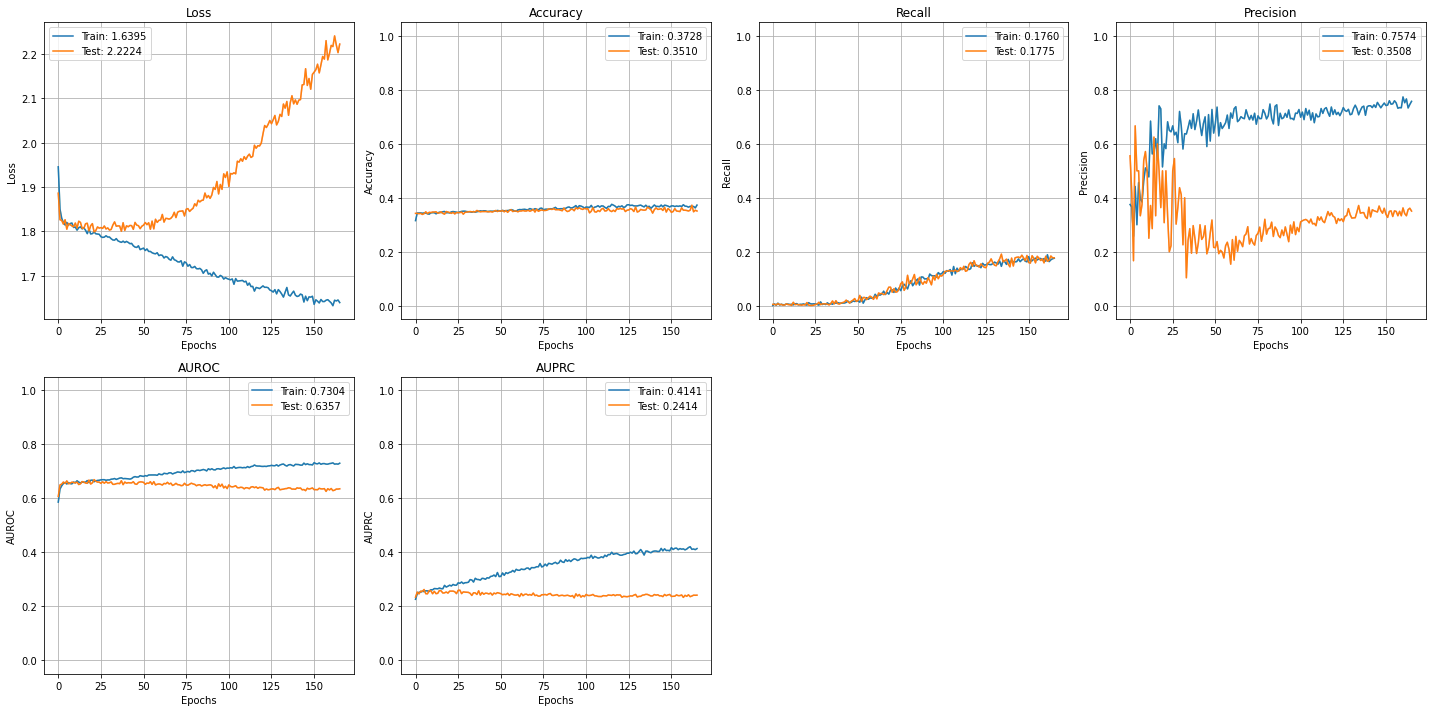

In [315]:
from plot_keras_history import plot_history

plot_history(history)

In [316]:
embedding = pd.DataFrame(
    model.layers[1].weights[0].numpy(),
    index= node_embedding.index
)

In [317]:
visualization = GraphVisualizations()
visualization.fit_transform_nodes(graph, embedding, verbose=True)

(<Figure size 1500x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'Nodes types - CiteSeer'}>)

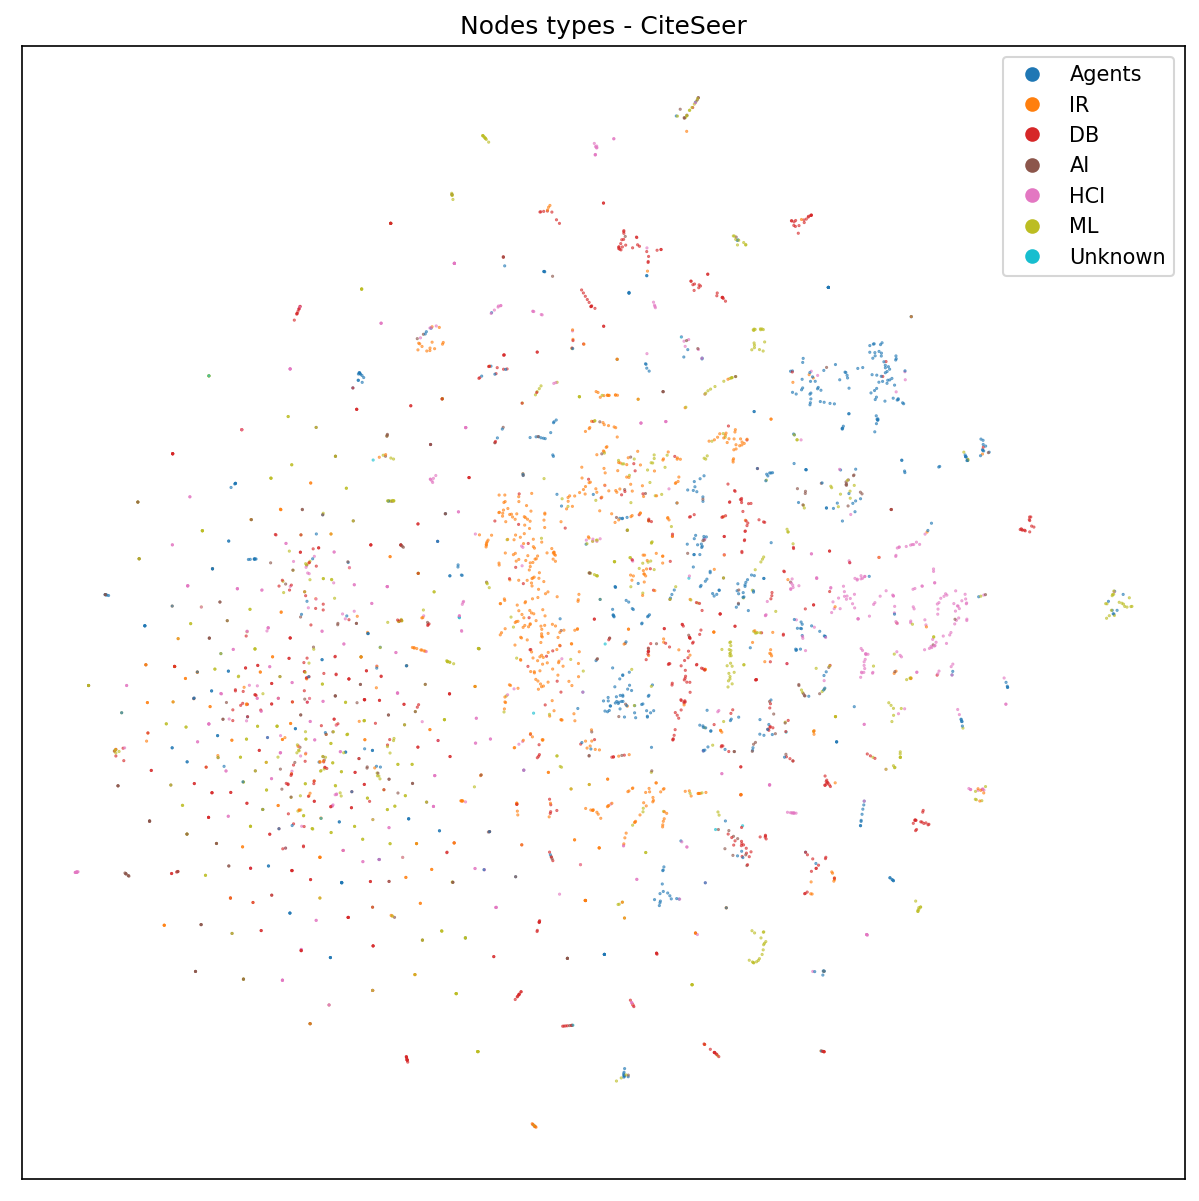

In [318]:
visualization.plot_node_types(graph)